In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 2312)
(3944610, 8)
validation
(464344, 2312)
(464344, 8)
test
(574820, 2312)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2312)]            0         


 dense (Dense)               (None, 1024)              2368512   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 3058568 (11.67 MB)


Trainable params: 3058568 (11.67 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 9:30 - loss: 2.2914 - STD: 0.0751 - MAE: 0.2167

  3/395 [..............................] - ETA: 11s - loss: 2.1684 - STD: 0.0576 - MAE: 0.2164 

  5/395 [..............................] - ETA: 13s - loss: 2.1238 - STD: 0.0481 - MAE: 0.2165

  6/395 [..............................] - ETA: 14s - loss: 2.1154 - STD: 0.0470 - MAE: 0.2166

  7/395 [..............................] - ETA: 15s - loss: 2.1106 - STD: 0.0469 - MAE: 0.2166

  8/395 [..............................] - ETA: 16s - loss: 2.1066 - STD: 0.0471 - MAE: 0.2165

  9/395 [..............................] - ETA: 16s - loss: 2.1032 - STD: 0.0470 - MAE: 0.2165

 10/395 [..............................] - ETA: 17s - loss: 2.0995 - STD: 0.0465 - MAE: 0.2165

 11/395 [..............................] - ETA: 17s - loss: 2.0956 - STD: 0.0457 - MAE: 0.2165

 12/395 [..............................] - ETA: 17s - loss: 2.0921 - STD: 0.0447 - MAE: 0.2165

 13/395 [..............................] - ETA: 17s - loss: 2.0890 - STD: 0.0437 - MAE: 0.2165

 14/395 [>.............................] - ETA: 17s - loss: 2.0865 - STD: 0.0427 - MAE: 0.2166

 15/395 [>.............................] - ETA: 18s - loss: 2.0842 - STD: 0.0419 - MAE: 0.2166

 16/395 [>.............................] - ETA: 18s - loss: 2.0825 - STD: 0.0412 - MAE: 0.2166

 17/395 [>.............................] - ETA: 33s - loss: 2.0816 - STD: 0.0407 - MAE: 0.2166

 19/395 [>.............................] - ETA: 30s - loss: 2.0789 - STD: 0.0400 - MAE: 0.2166

 21/395 [>.............................] - ETA: 28s - loss: 2.0767 - STD: 0.0395 - MAE: 0.2166

 23/395 [>.............................] - ETA: 27s - loss: 2.0746 - STD: 0.0389 - MAE: 0.2166

 24/395 [>.............................] - ETA: 26s - loss: 2.0735 - STD: 0.0386 - MAE: 0.2166

 25/395 [>.............................] - ETA: 26s - loss: 2.0724 - STD: 0.0384 - MAE: 0.2166

 26/395 [>.............................] - ETA: 26s - loss: 2.0714 - STD: 0.0382 - MAE: 0.2166

 27/395 [=>............................] - ETA: 25s - loss: 2.0702 - STD: 0.0380 - MAE: 0.2166

 28/395 [=>............................] - ETA: 25s - loss: 2.0693 - STD: 0.0378 - MAE: 0.2166

 29/395 [=>............................] - ETA: 25s - loss: 2.0684 - STD: 0.0377 - MAE: 0.2166

 30/395 [=>............................] - ETA: 25s - loss: 2.0675 - STD: 0.0375 - MAE: 0.2166

 31/395 [=>............................] - ETA: 24s - loss: 2.0666 - STD: 0.0373 - MAE: 0.2166

 32/395 [=>............................] - ETA: 24s - loss: 2.0656 - STD: 0.0372 - MAE: 0.2165

 33/395 [=>............................] - ETA: 24s - loss: 2.0646 - STD: 0.0372 - MAE: 0.2165

 34/395 [=>............................] - ETA: 24s - loss: 2.0636 - STD: 0.0371 - MAE: 0.2165

 35/395 [=>............................] - ETA: 23s - loss: 2.0625 - STD: 0.0371 - MAE: 0.2165

 36/395 [=>............................] - ETA: 23s - loss: 2.0612 - STD: 0.0370 - MAE: 0.2164

 37/395 [=>............................] - ETA: 23s - loss: 2.0599 - STD: 0.0369 - MAE: 0.2164

 38/395 [=>............................] - ETA: 23s - loss: 2.0585 - STD: 0.0369 - MAE: 0.2164

 39/395 [=>............................] - ETA: 23s - loss: 2.0571 - STD: 0.0369 - MAE: 0.2163

 40/395 [==>...........................] - ETA: 22s - loss: 2.0555 - STD: 0.0368 - MAE: 0.2163

 41/395 [==>...........................] - ETA: 22s - loss: 2.0537 - STD: 0.0369 - MAE: 0.2162

 42/395 [==>...........................] - ETA: 22s - loss: 2.0520 - STD: 0.0370 - MAE: 0.2162

 43/395 [==>...........................] - ETA: 22s - loss: 2.0500 - STD: 0.0371 - MAE: 0.2161

 44/395 [==>...........................] - ETA: 22s - loss: 2.0480 - STD: 0.0373 - MAE: 0.2160

 45/395 [==>...........................] - ETA: 22s - loss: 2.0457 - STD: 0.0376 - MAE: 0.2159

 46/395 [==>...........................] - ETA: 21s - loss: 2.0434 - STD: 0.0379 - MAE: 0.2158

 47/395 [==>...........................] - ETA: 21s - loss: 2.0411 - STD: 0.0383 - MAE: 0.2157

 48/395 [==>...........................] - ETA: 21s - loss: 2.0387 - STD: 0.0387 - MAE: 0.2156

 49/395 [==>...........................] - ETA: 21s - loss: 2.0361 - STD: 0.0391 - MAE: 0.2155

 50/395 [==>...........................] - ETA: 21s - loss: 2.0335 - STD: 0.0396 - MAE: 0.2153

 51/395 [==>...........................] - ETA: 21s - loss: 2.0312 - STD: 0.0400 - MAE: 0.2152

 52/395 [==>...........................] - ETA: 21s - loss: 2.0285 - STD: 0.0405 - MAE: 0.2151

 53/395 [===>..........................] - ETA: 21s - loss: 2.0258 - STD: 0.0410 - MAE: 0.2150

 54/395 [===>..........................] - ETA: 20s - loss: 2.0230 - STD: 0.0415 - MAE: 0.2148

 55/395 [===>..........................] - ETA: 20s - loss: 2.0202 - STD: 0.0420 - MAE: 0.2147

 56/395 [===>..........................] - ETA: 20s - loss: 2.0174 - STD: 0.0426 - MAE: 0.2145

 57/395 [===>..........................] - ETA: 20s - loss: 2.0147 - STD: 0.0432 - MAE: 0.2144

 58/395 [===>..........................] - ETA: 20s - loss: 2.0119 - STD: 0.0437 - MAE: 0.2142

 59/395 [===>..........................] - ETA: 20s - loss: 2.0090 - STD: 0.0442 - MAE: 0.2141

 60/395 [===>..........................] - ETA: 20s - loss: 2.0059 - STD: 0.0447 - MAE: 0.2139

 61/395 [===>..........................] - ETA: 20s - loss: 2.0028 - STD: 0.0453 - MAE: 0.2138

 62/395 [===>..........................] - ETA: 20s - loss: 1.9998 - STD: 0.0459 - MAE: 0.2136

 63/395 [===>..........................] - ETA: 19s - loss: 1.9969 - STD: 0.0465 - MAE: 0.2134

 64/395 [===>..........................] - ETA: 19s - loss: 1.9937 - STD: 0.0470 - MAE: 0.2133

 65/395 [===>..........................] - ETA: 19s - loss: 1.9906 - STD: 0.0475 - MAE: 0.2131

 66/395 [====>.........................] - ETA: 19s - loss: 1.9875 - STD: 0.0480 - MAE: 0.2130

 67/395 [====>.........................] - ETA: 19s - loss: 1.9843 - STD: 0.0485 - MAE: 0.2128

 68/395 [====>.........................] - ETA: 19s - loss: 1.9810 - STD: 0.0491 - MAE: 0.2126

 69/395 [====>.........................] - ETA: 19s - loss: 1.9778 - STD: 0.0497 - MAE: 0.2124

 70/395 [====>.........................] - ETA: 19s - loss: 1.9745 - STD: 0.0502 - MAE: 0.2123

 71/395 [====>.........................] - ETA: 19s - loss: 1.9712 - STD: 0.0507 - MAE: 0.2121

 72/395 [====>.........................] - ETA: 19s - loss: 1.9679 - STD: 0.0513 - MAE: 0.2119

 73/395 [====>.........................] - ETA: 19s - loss: 1.9647 - STD: 0.0518 - MAE: 0.2118

 74/395 [====>.........................] - ETA: 18s - loss: 1.9614 - STD: 0.0524 - MAE: 0.2116

 75/395 [====>.........................] - ETA: 18s - loss: 1.9579 - STD: 0.0529 - MAE: 0.2114

 76/395 [====>.........................] - ETA: 18s - loss: 1.9544 - STD: 0.0534 - MAE: 0.2112

 77/395 [====>.........................] - ETA: 18s - loss: 1.9509 - STD: 0.0540 - MAE: 0.2110

 78/395 [====>.........................] - ETA: 18s - loss: 1.9473 - STD: 0.0545 - MAE: 0.2109

 79/395 [=====>........................] - ETA: 18s - loss: 1.9438 - STD: 0.0551 - MAE: 0.2107

 80/395 [=====>........................] - ETA: 18s - loss: 1.9403 - STD: 0.0556 - MAE: 0.2105

 81/395 [=====>........................] - ETA: 18s - loss: 1.9365 - STD: 0.0561 - MAE: 0.2103

 82/395 [=====>........................] - ETA: 18s - loss: 1.9327 - STD: 0.0567 - MAE: 0.2101

 83/395 [=====>........................] - ETA: 18s - loss: 1.9291 - STD: 0.0572 - MAE: 0.2099

 84/395 [=====>........................] - ETA: 18s - loss: 1.9255 - STD: 0.0577 - MAE: 0.2097

 85/395 [=====>........................] - ETA: 18s - loss: 1.9216 - STD: 0.0583 - MAE: 0.2095

 86/395 [=====>........................] - ETA: 17s - loss: 1.9179 - STD: 0.0589 - MAE: 0.2093

 87/395 [=====>........................] - ETA: 17s - loss: 1.9141 - STD: 0.0594 - MAE: 0.2091

 88/395 [=====>........................] - ETA: 17s - loss: 1.9103 - STD: 0.0599 - MAE: 0.2089

 89/395 [=====>........................] - ETA: 17s - loss: 1.9064 - STD: 0.0605 - MAE: 0.2087

 90/395 [=====>........................] - ETA: 17s - loss: 1.9024 - STD: 0.0611 - MAE: 0.2085

 91/395 [=====>........................] - ETA: 17s - loss: 1.8987 - STD: 0.0617 - MAE: 0.2082

 92/395 [=====>........................] - ETA: 17s - loss: 1.8947 - STD: 0.0622 - MAE: 0.2080

 93/395 [======>.......................] - ETA: 17s - loss: 1.8906 - STD: 0.0628 - MAE: 0.2078

 94/395 [======>.......................] - ETA: 17s - loss: 1.8869 - STD: 0.0634 - MAE: 0.2076

 95/395 [======>.......................] - ETA: 17s - loss: 1.8830 - STD: 0.0639 - MAE: 0.2074

 96/395 [======>.......................] - ETA: 17s - loss: 1.8790 - STD: 0.0645 - MAE: 0.2071

 97/395 [======>.......................] - ETA: 17s - loss: 1.8754 - STD: 0.0651 - MAE: 0.2069

 98/395 [======>.......................] - ETA: 17s - loss: 1.8714 - STD: 0.0657 - MAE: 0.2067

 99/395 [======>.......................] - ETA: 17s - loss: 1.8675 - STD: 0.0662 - MAE: 0.2065

100/395 [======>.......................] - ETA: 16s - loss: 1.8635 - STD: 0.0668 - MAE: 0.2062

101/395 [======>.......................] - ETA: 16s - loss: 1.8596 - STD: 0.0674 - MAE: 0.2060

102/395 [======>.......................] - ETA: 16s - loss: 1.8558 - STD: 0.0680 - MAE: 0.2058

103/395 [======>.......................] - ETA: 16s - loss: 1.8519 - STD: 0.0685 - MAE: 0.2055

104/395 [======>.......................] - ETA: 16s - loss: 1.8481 - STD: 0.0691 - MAE: 0.2053

105/395 [======>.......................] - ETA: 16s - loss: 1.8445 - STD: 0.0697 - MAE: 0.2051

106/395 [=======>......................] - ETA: 16s - loss: 1.8407 - STD: 0.0702 - MAE: 0.2048

107/395 [=======>......................] - ETA: 16s - loss: 1.8369 - STD: 0.0708 - MAE: 0.2046

108/395 [=======>......................] - ETA: 16s - loss: 1.8330 - STD: 0.0714 - MAE: 0.2044

109/395 [=======>......................] - ETA: 16s - loss: 1.8293 - STD: 0.0719 - MAE: 0.2041

110/395 [=======>......................] - ETA: 16s - loss: 1.8257 - STD: 0.0725 - MAE: 0.2039

111/395 [=======>......................] - ETA: 16s - loss: 1.8223 - STD: 0.0731 - MAE: 0.2037

112/395 [=======>......................] - ETA: 16s - loss: 1.8190 - STD: 0.0737 - MAE: 0.2035

113/395 [=======>......................] - ETA: 16s - loss: 1.8152 - STD: 0.0742 - MAE: 0.2032

114/395 [=======>......................] - ETA: 16s - loss: 1.8118 - STD: 0.0748 - MAE: 0.2030

115/395 [=======>......................] - ETA: 15s - loss: 1.8083 - STD: 0.0753 - MAE: 0.2028

116/395 [=======>......................] - ETA: 15s - loss: 1.8049 - STD: 0.0759 - MAE: 0.2025

117/395 [=======>......................] - ETA: 15s - loss: 1.8015 - STD: 0.0764 - MAE: 0.2023

118/395 [=======>......................] - ETA: 15s - loss: 1.7982 - STD: 0.0769 - MAE: 0.2021

119/395 [========>.....................] - ETA: 15s - loss: 1.7950 - STD: 0.0775 - MAE: 0.2019

120/395 [========>.....................] - ETA: 15s - loss: 1.7918 - STD: 0.0780 - MAE: 0.2017

121/395 [========>.....................] - ETA: 15s - loss: 1.7885 - STD: 0.0785 - MAE: 0.2015

122/395 [========>.....................] - ETA: 15s - loss: 1.7851 - STD: 0.0790 - MAE: 0.2012

123/395 [========>.....................] - ETA: 15s - loss: 1.7821 - STD: 0.0795 - MAE: 0.2010

124/395 [========>.....................] - ETA: 15s - loss: 1.7790 - STD: 0.0800 - MAE: 0.2008

125/395 [========>.....................] - ETA: 15s - loss: 1.7759 - STD: 0.0805 - MAE: 0.2006

126/395 [========>.....................] - ETA: 15s - loss: 1.7729 - STD: 0.0811 - MAE: 0.2004

127/395 [========>.....................] - ETA: 15s - loss: 1.7702 - STD: 0.0816 - MAE: 0.2002

128/395 [========>.....................] - ETA: 15s - loss: 1.7673 - STD: 0.0820 - MAE: 0.2000

129/395 [========>.....................] - ETA: 15s - loss: 1.7642 - STD: 0.0825 - MAE: 0.1998

130/395 [========>.....................] - ETA: 14s - loss: 1.7613 - STD: 0.0830 - MAE: 0.1996

131/395 [========>.....................] - ETA: 14s - loss: 1.7585 - STD: 0.0835 - MAE: 0.1994

132/395 [=========>....................] - ETA: 14s - loss: 1.7558 - STD: 0.0839 - MAE: 0.1992

133/395 [=========>....................] - ETA: 14s - loss: 1.7529 - STD: 0.0844 - MAE: 0.1990

134/395 [=========>....................] - ETA: 14s - loss: 1.7500 - STD: 0.0849 - MAE: 0.1988

135/395 [=========>....................] - ETA: 14s - loss: 1.7472 - STD: 0.0853 - MAE: 0.1986

136/395 [=========>....................] - ETA: 14s - loss: 1.7445 - STD: 0.0858 - MAE: 0.1984

137/395 [=========>....................] - ETA: 14s - loss: 1.7417 - STD: 0.0862 - MAE: 0.1983

138/395 [=========>....................] - ETA: 14s - loss: 1.7390 - STD: 0.0866 - MAE: 0.1981

139/395 [=========>....................] - ETA: 14s - loss: 1.7362 - STD: 0.0871 - MAE: 0.1979

140/395 [=========>....................] - ETA: 14s - loss: 1.7334 - STD: 0.0875 - MAE: 0.1977

141/395 [=========>....................] - ETA: 14s - loss: 1.7309 - STD: 0.0879 - MAE: 0.1975

142/395 [=========>....................] - ETA: 14s - loss: 1.7284 - STD: 0.0884 - MAE: 0.1973

143/395 [=========>....................] - ETA: 14s - loss: 1.7257 - STD: 0.0888 - MAE: 0.1971

144/395 [=========>....................] - ETA: 14s - loss: 1.7231 - STD: 0.0892 - MAE: 0.1970

145/395 [==========>...................] - ETA: 14s - loss: 1.7205 - STD: 0.0896 - MAE: 0.1968

146/395 [==========>...................] - ETA: 13s - loss: 1.7180 - STD: 0.0900 - MAE: 0.1966

147/395 [==========>...................] - ETA: 13s - loss: 1.7153 - STD: 0.0904 - MAE: 0.1964

148/395 [==========>...................] - ETA: 13s - loss: 1.7128 - STD: 0.0908 - MAE: 0.1962

149/395 [==========>...................] - ETA: 13s - loss: 1.7104 - STD: 0.0912 - MAE: 0.1961

150/395 [==========>...................] - ETA: 13s - loss: 1.7079 - STD: 0.0916 - MAE: 0.1959

151/395 [==========>...................] - ETA: 13s - loss: 1.7054 - STD: 0.0920 - MAE: 0.1957

152/395 [==========>...................] - ETA: 13s - loss: 1.7031 - STD: 0.0924 - MAE: 0.1955

153/395 [==========>...................] - ETA: 13s - loss: 1.7007 - STD: 0.0928 - MAE: 0.1954

154/395 [==========>...................] - ETA: 13s - loss: 1.6984 - STD: 0.0932 - MAE: 0.1952

155/395 [==========>...................] - ETA: 13s - loss: 1.6959 - STD: 0.0936 - MAE: 0.1950

156/395 [==========>...................] - ETA: 13s - loss: 1.6936 - STD: 0.0940 - MAE: 0.1949

157/395 [==========>...................] - ETA: 13s - loss: 1.6912 - STD: 0.0943 - MAE: 0.1947

158/395 [===========>..................] - ETA: 13s - loss: 1.6889 - STD: 0.0947 - MAE: 0.1945

159/395 [===========>..................] - ETA: 13s - loss: 1.6866 - STD: 0.0951 - MAE: 0.1944

160/395 [===========>..................] - ETA: 13s - loss: 1.6844 - STD: 0.0954 - MAE: 0.1942

161/395 [===========>..................] - ETA: 13s - loss: 1.6822 - STD: 0.0958 - MAE: 0.1940

162/395 [===========>..................] - ETA: 12s - loss: 1.6800 - STD: 0.0962 - MAE: 0.1939

163/395 [===========>..................] - ETA: 12s - loss: 1.6779 - STD: 0.0965 - MAE: 0.1937

164/395 [===========>..................] - ETA: 12s - loss: 1.6759 - STD: 0.0969 - MAE: 0.1936

165/395 [===========>..................] - ETA: 12s - loss: 1.6740 - STD: 0.0972 - MAE: 0.1934

166/395 [===========>..................] - ETA: 12s - loss: 1.6718 - STD: 0.0976 - MAE: 0.1933

167/395 [===========>..................] - ETA: 12s - loss: 1.6696 - STD: 0.0979 - MAE: 0.1931

168/395 [===========>..................] - ETA: 12s - loss: 1.6677 - STD: 0.0983 - MAE: 0.1930

169/395 [===========>..................] - ETA: 12s - loss: 1.6657 - STD: 0.0986 - MAE: 0.1928

170/395 [===========>..................] - ETA: 12s - loss: 1.6636 - STD: 0.0990 - MAE: 0.1927

171/395 [===========>..................] - ETA: 12s - loss: 1.6616 - STD: 0.0993 - MAE: 0.1925

172/395 [============>.................] - ETA: 12s - loss: 1.6595 - STD: 0.0996 - MAE: 0.1923

173/395 [============>.................] - ETA: 12s - loss: 1.6575 - STD: 0.1000 - MAE: 0.1922

174/395 [============>.................] - ETA: 12s - loss: 1.6556 - STD: 0.1003 - MAE: 0.1921

175/395 [============>.................] - ETA: 12s - loss: 1.6536 - STD: 0.1006 - MAE: 0.1919

176/395 [============>.................] - ETA: 12s - loss: 1.6515 - STD: 0.1009 - MAE: 0.1918

177/395 [============>.................] - ETA: 12s - loss: 1.6495 - STD: 0.1013 - MAE: 0.1916

178/395 [============>.................] - ETA: 12s - loss: 1.6476 - STD: 0.1016 - MAE: 0.1915

179/395 [============>.................] - ETA: 11s - loss: 1.6457 - STD: 0.1019 - MAE: 0.1913

180/395 [============>.................] - ETA: 11s - loss: 1.6437 - STD: 0.1022 - MAE: 0.1912

181/395 [============>.................] - ETA: 11s - loss: 1.6417 - STD: 0.1025 - MAE: 0.1910

182/395 [============>.................] - ETA: 11s - loss: 1.6398 - STD: 0.1028 - MAE: 0.1909

183/395 [============>.................] - ETA: 11s - loss: 1.6379 - STD: 0.1031 - MAE: 0.1907

184/395 [============>.................] - ETA: 11s - loss: 1.6359 - STD: 0.1034 - MAE: 0.1906

185/395 [=============>................] - ETA: 11s - loss: 1.6340 - STD: 0.1037 - MAE: 0.1905

186/395 [=============>................] - ETA: 11s - loss: 1.6321 - STD: 0.1040 - MAE: 0.1903

187/395 [=============>................] - ETA: 11s - loss: 1.6303 - STD: 0.1043 - MAE: 0.1902

188/395 [=============>................] - ETA: 11s - loss: 1.6287 - STD: 0.1046 - MAE: 0.1900

189/395 [=============>................] - ETA: 11s - loss: 1.6270 - STD: 0.1049 - MAE: 0.1899

190/395 [=============>................] - ETA: 11s - loss: 1.6254 - STD: 0.1052 - MAE: 0.1898

191/395 [=============>................] - ETA: 11s - loss: 1.6236 - STD: 0.1055 - MAE: 0.1896

192/395 [=============>................] - ETA: 11s - loss: 1.6218 - STD: 0.1058 - MAE: 0.1895

193/395 [=============>................] - ETA: 11s - loss: 1.6202 - STD: 0.1061 - MAE: 0.1894

194/395 [=============>................] - ETA: 11s - loss: 1.6185 - STD: 0.1064 - MAE: 0.1892

195/395 [=============>................] - ETA: 11s - loss: 1.6167 - STD: 0.1067 - MAE: 0.1891

196/395 [=============>................] - ETA: 10s - loss: 1.6151 - STD: 0.1070 - MAE: 0.1890

197/395 [=============>................] - ETA: 10s - loss: 1.6134 - STD: 0.1072 - MAE: 0.1888

198/395 [==============>...............] - ETA: 10s - loss: 1.6117 - STD: 0.1075 - MAE: 0.1887

199/395 [==============>...............] - ETA: 10s - loss: 1.6101 - STD: 0.1078 - MAE: 0.1886

200/395 [==============>...............] - ETA: 10s - loss: 1.6083 - STD: 0.1081 - MAE: 0.1884

201/395 [==============>...............] - ETA: 10s - loss: 1.6067 - STD: 0.1083 - MAE: 0.1883

202/395 [==============>...............] - ETA: 10s - loss: 1.6051 - STD: 0.1086 - MAE: 0.1882

203/395 [==============>...............] - ETA: 10s - loss: 1.6034 - STD: 0.1089 - MAE: 0.1881

204/395 [==============>...............] - ETA: 10s - loss: 1.6018 - STD: 0.1091 - MAE: 0.1879

205/395 [==============>...............] - ETA: 10s - loss: 1.6002 - STD: 0.1094 - MAE: 0.1878

206/395 [==============>...............] - ETA: 10s - loss: 1.5985 - STD: 0.1097 - MAE: 0.1877

207/395 [==============>...............] - ETA: 10s - loss: 1.5969 - STD: 0.1099 - MAE: 0.1876

208/395 [==============>...............] - ETA: 10s - loss: 1.5953 - STD: 0.1102 - MAE: 0.1874

209/395 [==============>...............] - ETA: 10s - loss: 1.5936 - STD: 0.1105 - MAE: 0.1873

210/395 [==============>...............] - ETA: 10s - loss: 1.5920 - STD: 0.1107 - MAE: 0.1872

211/395 [===============>..............] - ETA: 10s - loss: 1.5904 - STD: 0.1110 - MAE: 0.1871

212/395 [===============>..............] - ETA: 10s - loss: 1.5889 - STD: 0.1112 - MAE: 0.1869

213/395 [===============>..............] - ETA: 10s - loss: 1.5875 - STD: 0.1115 - MAE: 0.1868

214/395 [===============>..............] - ETA: 9s - loss: 1.5861 - STD: 0.1117 - MAE: 0.1867 

215/395 [===============>..............] - ETA: 9s - loss: 1.5846 - STD: 0.1120 - MAE: 0.1866

216/395 [===============>..............] - ETA: 9s - loss: 1.5830 - STD: 0.1122 - MAE: 0.1865

217/395 [===============>..............] - ETA: 9s - loss: 1.5815 - STD: 0.1125 - MAE: 0.1863

218/395 [===============>..............] - ETA: 9s - loss: 1.5800 - STD: 0.1128 - MAE: 0.1862

219/395 [===============>..............] - ETA: 9s - loss: 1.5784 - STD: 0.1130 - MAE: 0.1861

220/395 [===============>..............] - ETA: 9s - loss: 1.5769 - STD: 0.1133 - MAE: 0.1860

221/395 [===============>..............] - ETA: 9s - loss: 1.5754 - STD: 0.1135 - MAE: 0.1858

222/395 [===============>..............] - ETA: 9s - loss: 1.5739 - STD: 0.1138 - MAE: 0.1857

223/395 [===============>..............] - ETA: 9s - loss: 1.5724 - STD: 0.1140 - MAE: 0.1856

224/395 [================>.............] - ETA: 9s - loss: 1.5709 - STD: 0.1142 - MAE: 0.1855

225/395 [================>.............] - ETA: 9s - loss: 1.5694 - STD: 0.1145 - MAE: 0.1853

226/395 [================>.............] - ETA: 9s - loss: 1.5680 - STD: 0.1147 - MAE: 0.1852

227/395 [================>.............] - ETA: 9s - loss: 1.5665 - STD: 0.1150 - MAE: 0.1851

228/395 [================>.............] - ETA: 9s - loss: 1.5650 - STD: 0.1152 - MAE: 0.1850

229/395 [================>.............] - ETA: 9s - loss: 1.5636 - STD: 0.1154 - MAE: 0.1849

230/395 [================>.............] - ETA: 9s - loss: 1.5622 - STD: 0.1157 - MAE: 0.1848

231/395 [================>.............] - ETA: 8s - loss: 1.5609 - STD: 0.1159 - MAE: 0.1847

232/395 [================>.............] - ETA: 8s - loss: 1.5596 - STD: 0.1161 - MAE: 0.1845

233/395 [================>.............] - ETA: 8s - loss: 1.5582 - STD: 0.1164 - MAE: 0.1844

234/395 [================>.............] - ETA: 8s - loss: 1.5568 - STD: 0.1166 - MAE: 0.1843

235/395 [================>.............] - ETA: 8s - loss: 1.5554 - STD: 0.1168 - MAE: 0.1842

236/395 [================>.............] - ETA: 8s - loss: 1.5541 - STD: 0.1171 - MAE: 0.1841

237/395 [=================>............] - ETA: 8s - loss: 1.5527 - STD: 0.1173 - MAE: 0.1840

238/395 [=================>............] - ETA: 8s - loss: 1.5513 - STD: 0.1175 - MAE: 0.1839

239/395 [=================>............] - ETA: 8s - loss: 1.5500 - STD: 0.1178 - MAE: 0.1837

240/395 [=================>............] - ETA: 8s - loss: 1.5487 - STD: 0.1180 - MAE: 0.1836

241/395 [=================>............] - ETA: 8s - loss: 1.5473 - STD: 0.1182 - MAE: 0.1835

242/395 [=================>............] - ETA: 8s - loss: 1.5461 - STD: 0.1184 - MAE: 0.1834

243/395 [=================>............] - ETA: 8s - loss: 1.5448 - STD: 0.1187 - MAE: 0.1833

244/395 [=================>............] - ETA: 8s - loss: 1.5435 - STD: 0.1189 - MAE: 0.1832

245/395 [=================>............] - ETA: 8s - loss: 1.5422 - STD: 0.1191 - MAE: 0.1831

246/395 [=================>............] - ETA: 8s - loss: 1.5409 - STD: 0.1193 - MAE: 0.1830

247/395 [=================>............] - ETA: 8s - loss: 1.5396 - STD: 0.1195 - MAE: 0.1829

248/395 [=================>............] - ETA: 8s - loss: 1.5384 - STD: 0.1197 - MAE: 0.1828

249/395 [=================>............] - ETA: 7s - loss: 1.5371 - STD: 0.1199 - MAE: 0.1827

250/395 [=================>............] - ETA: 7s - loss: 1.5359 - STD: 0.1202 - MAE: 0.1826

251/395 [==================>...........] - ETA: 7s - loss: 1.5348 - STD: 0.1204 - MAE: 0.1825

252/395 [==================>...........] - ETA: 7s - loss: 1.5336 - STD: 0.1206 - MAE: 0.1824

253/395 [==================>...........] - ETA: 7s - loss: 1.5323 - STD: 0.1208 - MAE: 0.1822

254/395 [==================>...........] - ETA: 7s - loss: 1.5311 - STD: 0.1210 - MAE: 0.1821

255/395 [==================>...........] - ETA: 7s - loss: 1.5298 - STD: 0.1212 - MAE: 0.1820

256/395 [==================>...........] - ETA: 7s - loss: 1.5286 - STD: 0.1214 - MAE: 0.1819

257/395 [==================>...........] - ETA: 7s - loss: 1.5274 - STD: 0.1216 - MAE: 0.1818

258/395 [==================>...........] - ETA: 7s - loss: 1.5261 - STD: 0.1219 - MAE: 0.1817

259/395 [==================>...........] - ETA: 7s - loss: 1.5249 - STD: 0.1221 - MAE: 0.1816

260/395 [==================>...........] - ETA: 7s - loss: 1.5238 - STD: 0.1223 - MAE: 0.1815

261/395 [==================>...........] - ETA: 7s - loss: 1.5226 - STD: 0.1225 - MAE: 0.1814

262/395 [==================>...........] - ETA: 7s - loss: 1.5215 - STD: 0.1227 - MAE: 0.1813

263/395 [==================>...........] - ETA: 7s - loss: 1.5204 - STD: 0.1229 - MAE: 0.1812

264/395 [===================>..........] - ETA: 7s - loss: 1.5192 - STD: 0.1231 - MAE: 0.1811

265/395 [===================>..........] - ETA: 7s - loss: 1.5180 - STD: 0.1233 - MAE: 0.1810

266/395 [===================>..........] - ETA: 7s - loss: 1.5168 - STD: 0.1235 - MAE: 0.1809

267/395 [===================>..........] - ETA: 6s - loss: 1.5156 - STD: 0.1237 - MAE: 0.1808

268/395 [===================>..........] - ETA: 6s - loss: 1.5144 - STD: 0.1239 - MAE: 0.1807

269/395 [===================>..........] - ETA: 6s - loss: 1.5132 - STD: 0.1241 - MAE: 0.1806

270/395 [===================>..........] - ETA: 6s - loss: 1.5120 - STD: 0.1242 - MAE: 0.1805

271/395 [===================>..........] - ETA: 6s - loss: 1.5108 - STD: 0.1244 - MAE: 0.1804

272/395 [===================>..........] - ETA: 6s - loss: 1.5097 - STD: 0.1246 - MAE: 0.1803

273/395 [===================>..........] - ETA: 6s - loss: 1.5085 - STD: 0.1248 - MAE: 0.1802

274/395 [===================>..........] - ETA: 6s - loss: 1.5074 - STD: 0.1250 - MAE: 0.1801

275/395 [===================>..........] - ETA: 6s - loss: 1.5063 - STD: 0.1252 - MAE: 0.1800

276/395 [===================>..........] - ETA: 6s - loss: 1.5051 - STD: 0.1254 - MAE: 0.1799

277/395 [====================>.........] - ETA: 6s - loss: 1.5040 - STD: 0.1256 - MAE: 0.1798

278/395 [====================>.........] - ETA: 6s - loss: 1.5029 - STD: 0.1258 - MAE: 0.1797

279/395 [====================>.........] - ETA: 6s - loss: 1.5018 - STD: 0.1260 - MAE: 0.1796

280/395 [====================>.........] - ETA: 6s - loss: 1.5007 - STD: 0.1262 - MAE: 0.1795

281/395 [====================>.........] - ETA: 6s - loss: 1.4996 - STD: 0.1264 - MAE: 0.1794

282/395 [====================>.........] - ETA: 6s - loss: 1.4985 - STD: 0.1265 - MAE: 0.1793

283/395 [====================>.........] - ETA: 6s - loss: 1.4975 - STD: 0.1267 - MAE: 0.1792

284/395 [====================>.........] - ETA: 6s - loss: 1.4964 - STD: 0.1269 - MAE: 0.1792

285/395 [====================>.........] - ETA: 5s - loss: 1.4953 - STD: 0.1271 - MAE: 0.1791

286/395 [====================>.........] - ETA: 5s - loss: 1.4942 - STD: 0.1273 - MAE: 0.1790

287/395 [====================>.........] - ETA: 5s - loss: 1.4931 - STD: 0.1274 - MAE: 0.1789

288/395 [====================>.........] - ETA: 5s - loss: 1.4920 - STD: 0.1276 - MAE: 0.1788

289/395 [====================>.........] - ETA: 5s - loss: 1.4910 - STD: 0.1278 - MAE: 0.1787

290/395 [=====================>........] - ETA: 5s - loss: 1.4900 - STD: 0.1280 - MAE: 0.1786

291/395 [=====================>........] - ETA: 5s - loss: 1.4890 - STD: 0.1282 - MAE: 0.1785

292/395 [=====================>........] - ETA: 5s - loss: 1.4881 - STD: 0.1283 - MAE: 0.1784

293/395 [=====================>........] - ETA: 5s - loss: 1.4871 - STD: 0.1285 - MAE: 0.1783

294/395 [=====================>........] - ETA: 5s - loss: 1.4860 - STD: 0.1287 - MAE: 0.1782

295/395 [=====================>........] - ETA: 5s - loss: 1.4850 - STD: 0.1289 - MAE: 0.1781

296/395 [=====================>........] - ETA: 5s - loss: 1.4840 - STD: 0.1291 - MAE: 0.1781

297/395 [=====================>........] - ETA: 5s - loss: 1.4830 - STD: 0.1292 - MAE: 0.1780

298/395 [=====================>........] - ETA: 5s - loss: 1.4821 - STD: 0.1294 - MAE: 0.1779

299/395 [=====================>........] - ETA: 5s - loss: 1.4811 - STD: 0.1296 - MAE: 0.1778

300/395 [=====================>........] - ETA: 5s - loss: 1.4801 - STD: 0.1297 - MAE: 0.1777

301/395 [=====================>........] - ETA: 5s - loss: 1.4791 - STD: 0.1299 - MAE: 0.1776

302/395 [=====================>........] - ETA: 5s - loss: 1.4781 - STD: 0.1301 - MAE: 0.1775

303/395 [======================>.......] - ETA: 4s - loss: 1.4770 - STD: 0.1302 - MAE: 0.1774

304/395 [======================>.......] - ETA: 4s - loss: 1.4760 - STD: 0.1304 - MAE: 0.1774

305/395 [======================>.......] - ETA: 4s - loss: 1.4750 - STD: 0.1306 - MAE: 0.1773

306/395 [======================>.......] - ETA: 4s - loss: 1.4740 - STD: 0.1307 - MAE: 0.1772

307/395 [======================>.......] - ETA: 4s - loss: 1.4730 - STD: 0.1309 - MAE: 0.1771

308/395 [======================>.......] - ETA: 4s - loss: 1.4720 - STD: 0.1311 - MAE: 0.1770

309/395 [======================>.......] - ETA: 4s - loss: 1.4710 - STD: 0.1312 - MAE: 0.1769

310/395 [======================>.......] - ETA: 4s - loss: 1.4701 - STD: 0.1314 - MAE: 0.1768

311/395 [======================>.......] - ETA: 4s - loss: 1.4692 - STD: 0.1316 - MAE: 0.1768

312/395 [======================>.......] - ETA: 4s - loss: 1.4682 - STD: 0.1317 - MAE: 0.1767

313/395 [======================>.......] - ETA: 4s - loss: 1.4672 - STD: 0.1319 - MAE: 0.1766

314/395 [======================>.......] - ETA: 4s - loss: 1.4662 - STD: 0.1321 - MAE: 0.1765

315/395 [======================>.......] - ETA: 4s - loss: 1.4653 - STD: 0.1322 - MAE: 0.1764

316/395 [=======================>......] - ETA: 4s - loss: 1.4643 - STD: 0.1324 - MAE: 0.1763

317/395 [=======================>......] - ETA: 4s - loss: 1.4633 - STD: 0.1325 - MAE: 0.1762

318/395 [=======================>......] - ETA: 4s - loss: 1.4624 - STD: 0.1327 - MAE: 0.1762

319/395 [=======================>......] - ETA: 4s - loss: 1.4615 - STD: 0.1328 - MAE: 0.1761

320/395 [=======================>......] - ETA: 4s - loss: 1.4606 - STD: 0.1330 - MAE: 0.1760

321/395 [=======================>......] - ETA: 4s - loss: 1.4597 - STD: 0.1332 - MAE: 0.1759

322/395 [=======================>......] - ETA: 3s - loss: 1.4588 - STD: 0.1333 - MAE: 0.1758

323/395 [=======================>......] - ETA: 3s - loss: 1.4581 - STD: 0.1335 - MAE: 0.1758

324/395 [=======================>......] - ETA: 3s - loss: 1.4574 - STD: 0.1336 - MAE: 0.1757

325/395 [=======================>......] - ETA: 3s - loss: 1.4565 - STD: 0.1338 - MAE: 0.1756

326/395 [=======================>......] - ETA: 3s - loss: 1.4556 - STD: 0.1339 - MAE: 0.1755

327/395 [=======================>......] - ETA: 3s - loss: 1.4548 - STD: 0.1341 - MAE: 0.1755

328/395 [=======================>......] - ETA: 3s - loss: 1.4539 - STD: 0.1342 - MAE: 0.1754

329/395 [=======================>......] - ETA: 3s - loss: 1.4532 - STD: 0.1344 - MAE: 0.1753

330/395 [========================>.....] - ETA: 3s - loss: 1.4524 - STD: 0.1345 - MAE: 0.1752

331/395 [========================>.....] - ETA: 3s - loss: 1.4515 - STD: 0.1347 - MAE: 0.1752

332/395 [========================>.....] - ETA: 3s - loss: 1.4509 - STD: 0.1349 - MAE: 0.1751

333/395 [========================>.....] - ETA: 3s - loss: 1.4501 - STD: 0.1350 - MAE: 0.1750

334/395 [========================>.....] - ETA: 3s - loss: 1.4492 - STD: 0.1351 - MAE: 0.1749

335/395 [========================>.....] - ETA: 3s - loss: 1.4484 - STD: 0.1353 - MAE: 0.1749

336/395 [========================>.....] - ETA: 3s - loss: 1.4476 - STD: 0.1354 - MAE: 0.1748

337/395 [========================>.....] - ETA: 3s - loss: 1.4467 - STD: 0.1356 - MAE: 0.1747

338/395 [========================>.....] - ETA: 3s - loss: 1.4458 - STD: 0.1357 - MAE: 0.1746

339/395 [========================>.....] - ETA: 3s - loss: 1.4450 - STD: 0.1359 - MAE: 0.1746

340/395 [========================>.....] - ETA: 2s - loss: 1.4441 - STD: 0.1360 - MAE: 0.1745

341/395 [========================>.....] - ETA: 2s - loss: 1.4433 - STD: 0.1361 - MAE: 0.1744

342/395 [========================>.....] - ETA: 2s - loss: 1.4425 - STD: 0.1363 - MAE: 0.1743

343/395 [=========================>....] - ETA: 2s - loss: 1.4416 - STD: 0.1364 - MAE: 0.1743

344/395 [=========================>....] - ETA: 2s - loss: 1.4407 - STD: 0.1366 - MAE: 0.1742

345/395 [=========================>....] - ETA: 2s - loss: 1.4400 - STD: 0.1367 - MAE: 0.1741

346/395 [=========================>....] - ETA: 2s - loss: 1.4392 - STD: 0.1368 - MAE: 0.1740

347/395 [=========================>....] - ETA: 2s - loss: 1.4383 - STD: 0.1370 - MAE: 0.1740

348/395 [=========================>....] - ETA: 2s - loss: 1.4375 - STD: 0.1371 - MAE: 0.1739

349/395 [=========================>....] - ETA: 2s - loss: 1.4366 - STD: 0.1372 - MAE: 0.1738

350/395 [=========================>....] - ETA: 2s - loss: 1.4358 - STD: 0.1374 - MAE: 0.1737

351/395 [=========================>....] - ETA: 2s - loss: 1.4350 - STD: 0.1375 - MAE: 0.1737

352/395 [=========================>....] - ETA: 2s - loss: 1.4341 - STD: 0.1376 - MAE: 0.1736

353/395 [=========================>....] - ETA: 2s - loss: 1.4333 - STD: 0.1378 - MAE: 0.1735

354/395 [=========================>....] - ETA: 2s - loss: 1.4326 - STD: 0.1379 - MAE: 0.1735

355/395 [=========================>....] - ETA: 2s - loss: 1.4318 - STD: 0.1380 - MAE: 0.1734

356/395 [==========================>...] - ETA: 2s - loss: 1.4310 - STD: 0.1382 - MAE: 0.1733

357/395 [==========================>...] - ETA: 2s - loss: 1.4302 - STD: 0.1383 - MAE: 0.1733

358/395 [==========================>...] - ETA: 2s - loss: 1.4294 - STD: 0.1384 - MAE: 0.1732

359/395 [==========================>...] - ETA: 1s - loss: 1.4286 - STD: 0.1386 - MAE: 0.1731

360/395 [==========================>...] - ETA: 1s - loss: 1.4278 - STD: 0.1387 - MAE: 0.1730

361/395 [==========================>...] - ETA: 1s - loss: 1.4270 - STD: 0.1388 - MAE: 0.1730

362/395 [==========================>...] - ETA: 1s - loss: 1.4261 - STD: 0.1390 - MAE: 0.1729

363/395 [==========================>...] - ETA: 1s - loss: 1.4254 - STD: 0.1391 - MAE: 0.1728

364/395 [==========================>...] - ETA: 1s - loss: 1.4246 - STD: 0.1392 - MAE: 0.1728

365/395 [==========================>...] - ETA: 1s - loss: 1.4238 - STD: 0.1393 - MAE: 0.1727

366/395 [==========================>...] - ETA: 1s - loss: 1.4230 - STD: 0.1395 - MAE: 0.1726

367/395 [==========================>...] - ETA: 1s - loss: 1.4223 - STD: 0.1396 - MAE: 0.1725

368/395 [==========================>...] - ETA: 1s - loss: 1.4216 - STD: 0.1397 - MAE: 0.1725

369/395 [===========================>..] - ETA: 1s - loss: 1.4209 - STD: 0.1399 - MAE: 0.1724

370/395 [===========================>..] - ETA: 1s - loss: 1.4202 - STD: 0.1400 - MAE: 0.1723

371/395 [===========================>..] - ETA: 1s - loss: 1.4194 - STD: 0.1401 - MAE: 0.1723

372/395 [===========================>..] - ETA: 1s - loss: 1.4186 - STD: 0.1402 - MAE: 0.1722

373/395 [===========================>..] - ETA: 1s - loss: 1.4178 - STD: 0.1404 - MAE: 0.1721

374/395 [===========================>..] - ETA: 1s - loss: 1.4171 - STD: 0.1405 - MAE: 0.1721

375/395 [===========================>..] - ETA: 1s - loss: 1.4163 - STD: 0.1406 - MAE: 0.1720

376/395 [===========================>..] - ETA: 1s - loss: 1.4155 - STD: 0.1407 - MAE: 0.1719

377/395 [===========================>..] - ETA: 0s - loss: 1.4148 - STD: 0.1409 - MAE: 0.1719

378/395 [===========================>..] - ETA: 0s - loss: 1.4140 - STD: 0.1410 - MAE: 0.1718

379/395 [===========================>..] - ETA: 0s - loss: 1.4133 - STD: 0.1411 - MAE: 0.1717

380/395 [===========================>..] - ETA: 0s - loss: 1.4125 - STD: 0.1412 - MAE: 0.1717

381/395 [===========================>..] - ETA: 0s - loss: 1.4117 - STD: 0.1414 - MAE: 0.1716

382/395 [============================>.] - ETA: 0s - loss: 1.4111 - STD: 0.1415 - MAE: 0.1715

383/395 [============================>.] - ETA: 0s - loss: 1.4103 - STD: 0.1416 - MAE: 0.1715

384/395 [============================>.] - ETA: 0s - loss: 1.4096 - STD: 0.1417 - MAE: 0.1714

385/395 [============================>.] - ETA: 0s - loss: 1.4089 - STD: 0.1419 - MAE: 0.1713

386/395 [============================>.] - ETA: 0s - loss: 1.4082 - STD: 0.1420 - MAE: 0.1713

387/395 [============================>.] - ETA: 0s - loss: 1.4075 - STD: 0.1421 - MAE: 0.1712

388/395 [============================>.] - ETA: 0s - loss: 1.4068 - STD: 0.1422 - MAE: 0.1711

389/395 [============================>.] - ETA: 0s - loss: 1.4061 - STD: 0.1423 - MAE: 0.1711

390/395 [============================>.] - ETA: 0s - loss: 1.4054 - STD: 0.1425 - MAE: 0.1710

391/395 [============================>.] - ETA: 0s - loss: 1.4047 - STD: 0.1426 - MAE: 0.1709

392/395 [============================>.] - ETA: 0s - loss: 1.4040 - STD: 0.1427 - MAE: 0.1709

393/395 [============================>.] - ETA: 0s - loss: 1.4033 - STD: 0.1428 - MAE: 0.1708

394/395 [============================>.] - ETA: 0s - loss: 1.4026 - STD: 0.1429 - MAE: 0.1708

395/395 [==============================] - 26s 61ms/step - loss: 1.4019 - STD: 0.1430 - MAE: 0.1707 - val_loss: 1.2275 - val_STD: 0.1910 - val_MAE: 0.1492


Epoch 2/10000


  1/395 [..............................] - ETA: 36s - loss: 1.1054 - STD: 0.1898 - MAE: 0.1443

  2/395 [..............................] - ETA: 21s - loss: 1.1082 - STD: 0.1890 - MAE: 0.1449

  3/395 [..............................] - ETA: 21s - loss: 1.1054 - STD: 0.1882 - MAE: 0.1448

  4/395 [..............................] - ETA: 20s - loss: 1.1073 - STD: 0.1881 - MAE: 0.1449

  5/395 [..............................] - ETA: 20s - loss: 1.1066 - STD: 0.1885 - MAE: 0.1447

  6/395 [..............................] - ETA: 20s - loss: 1.1065 - STD: 0.1889 - MAE: 0.1445

  7/395 [..............................] - ETA: 20s - loss: 1.1087 - STD: 0.1890 - MAE: 0.1447

  8/395 [..............................] - ETA: 20s - loss: 1.1092 - STD: 0.1892 - MAE: 0.1446

  9/395 [..............................] - ETA: 21s - loss: 1.1107 - STD: 0.1891 - MAE: 0.1447

 10/395 [..............................] - ETA: 21s - loss: 1.1117 - STD: 0.1891 - MAE: 0.1448

 11/395 [..............................] - ETA: 21s - loss: 1.1119 - STD: 0.1890 - MAE: 0.1448

 12/395 [..............................] - ETA: 21s - loss: 1.1133 - STD: 0.1892 - MAE: 0.1448

 13/395 [..............................] - ETA: 21s - loss: 1.1179 - STD: 0.1894 - MAE: 0.1450

 14/395 [>.............................] - ETA: 21s - loss: 1.1252 - STD: 0.1895 - MAE: 0.1453

 15/395 [>.............................] - ETA: 21s - loss: 1.1270 - STD: 0.1895 - MAE: 0.1454

 16/395 [>.............................] - ETA: 21s - loss: 1.1258 - STD: 0.1896 - MAE: 0.1453

 17/395 [>.............................] - ETA: 21s - loss: 1.1260 - STD: 0.1897 - MAE: 0.1453

 18/395 [>.............................] - ETA: 21s - loss: 1.1272 - STD: 0.1896 - MAE: 0.1454

 19/395 [>.............................] - ETA: 21s - loss: 1.1264 - STD: 0.1895 - MAE: 0.1454

 20/395 [>.............................] - ETA: 21s - loss: 1.1256 - STD: 0.1895 - MAE: 0.1454

 21/395 [>.............................] - ETA: 21s - loss: 1.1252 - STD: 0.1896 - MAE: 0.1453

 22/395 [>.............................] - ETA: 21s - loss: 1.1244 - STD: 0.1895 - MAE: 0.1453

 23/395 [>.............................] - ETA: 20s - loss: 1.1244 - STD: 0.1896 - MAE: 0.1453

 24/395 [>.............................] - ETA: 20s - loss: 1.1238 - STD: 0.1897 - MAE: 0.1452

 25/395 [>.............................] - ETA: 20s - loss: 1.1225 - STD: 0.1897 - MAE: 0.1451

 26/395 [>.............................] - ETA: 20s - loss: 1.1221 - STD: 0.1897 - MAE: 0.1451

 27/395 [=>............................] - ETA: 20s - loss: 1.1222 - STD: 0.1898 - MAE: 0.1451

 28/395 [=>............................] - ETA: 20s - loss: 1.1216 - STD: 0.1898 - MAE: 0.1450

 29/395 [=>............................] - ETA: 20s - loss: 1.1212 - STD: 0.1898 - MAE: 0.1450

 30/395 [=>............................] - ETA: 20s - loss: 1.1215 - STD: 0.1899 - MAE: 0.1450

 31/395 [=>............................] - ETA: 20s - loss: 1.1209 - STD: 0.1899 - MAE: 0.1450

 32/395 [=>............................] - ETA: 20s - loss: 1.1199 - STD: 0.1899 - MAE: 0.1449

 33/395 [=>............................] - ETA: 19s - loss: 1.1196 - STD: 0.1900 - MAE: 0.1448

 34/395 [=>............................] - ETA: 19s - loss: 1.1192 - STD: 0.1900 - MAE: 0.1448

 35/395 [=>............................] - ETA: 19s - loss: 1.1187 - STD: 0.1901 - MAE: 0.1448

 36/395 [=>............................] - ETA: 19s - loss: 1.1183 - STD: 0.1901 - MAE: 0.1447

 37/395 [=>............................] - ETA: 19s - loss: 1.1180 - STD: 0.1901 - MAE: 0.1447

 38/395 [=>............................] - ETA: 19s - loss: 1.1174 - STD: 0.1902 - MAE: 0.1446

 39/395 [=>............................] - ETA: 19s - loss: 1.1168 - STD: 0.1901 - MAE: 0.1446

 40/395 [==>...........................] - ETA: 19s - loss: 1.1171 - STD: 0.1902 - MAE: 0.1446

 41/395 [==>...........................] - ETA: 19s - loss: 1.1171 - STD: 0.1902 - MAE: 0.1446

 42/395 [==>...........................] - ETA: 19s - loss: 1.1172 - STD: 0.1902 - MAE: 0.1446

 43/395 [==>...........................] - ETA: 19s - loss: 1.1176 - STD: 0.1902 - MAE: 0.1446

 44/395 [==>...........................] - ETA: 19s - loss: 1.1181 - STD: 0.1903 - MAE: 0.1446

 45/395 [==>...........................] - ETA: 19s - loss: 1.1184 - STD: 0.1903 - MAE: 0.1447

 46/395 [==>...........................] - ETA: 19s - loss: 1.1175 - STD: 0.1903 - MAE: 0.1446

 47/395 [==>...........................] - ETA: 19s - loss: 1.1172 - STD: 0.1904 - MAE: 0.1446

 48/395 [==>...........................] - ETA: 19s - loss: 1.1178 - STD: 0.1904 - MAE: 0.1446

 49/395 [==>...........................] - ETA: 19s - loss: 1.1183 - STD: 0.1905 - MAE: 0.1446

 50/395 [==>...........................] - ETA: 19s - loss: 1.1179 - STD: 0.1905 - MAE: 0.1445

 51/395 [==>...........................] - ETA: 19s - loss: 1.1172 - STD: 0.1905 - MAE: 0.1445

 53/395 [===>..........................] - ETA: 18s - loss: 1.1174 - STD: 0.1905 - MAE: 0.1445

 54/395 [===>..........................] - ETA: 18s - loss: 1.1171 - STD: 0.1906 - MAE: 0.1445

 55/395 [===>..........................] - ETA: 18s - loss: 1.1164 - STD: 0.1906 - MAE: 0.1444

 56/395 [===>..........................] - ETA: 18s - loss: 1.1161 - STD: 0.1906 - MAE: 0.1444

 57/395 [===>..........................] - ETA: 18s - loss: 1.1163 - STD: 0.1906 - MAE: 0.1444

 58/395 [===>..........................] - ETA: 18s - loss: 1.1162 - STD: 0.1907 - MAE: 0.1444

 59/395 [===>..........................] - ETA: 18s - loss: 1.1156 - STD: 0.1907 - MAE: 0.1443

 60/395 [===>..........................] - ETA: 18s - loss: 1.1156 - STD: 0.1907 - MAE: 0.1443

 61/395 [===>..........................] - ETA: 18s - loss: 1.1158 - STD: 0.1908 - MAE: 0.1443

 63/395 [===>..........................] - ETA: 18s - loss: 1.1156 - STD: 0.1907 - MAE: 0.1443

 64/395 [===>..........................] - ETA: 18s - loss: 1.1158 - STD: 0.1908 - MAE: 0.1443

 65/395 [===>..........................] - ETA: 18s - loss: 1.1162 - STD: 0.1908 - MAE: 0.1443

 66/395 [====>.........................] - ETA: 18s - loss: 1.1160 - STD: 0.1908 - MAE: 0.1443

 67/395 [====>.........................] - ETA: 18s - loss: 1.1156 - STD: 0.1909 - MAE: 0.1443

 68/395 [====>.........................] - ETA: 18s - loss: 1.1158 - STD: 0.1909 - MAE: 0.1443

 69/395 [====>.........................] - ETA: 18s - loss: 1.1154 - STD: 0.1909 - MAE: 0.1443

 70/395 [====>.........................] - ETA: 17s - loss: 1.1152 - STD: 0.1909 - MAE: 0.1442

 71/395 [====>.........................] - ETA: 17s - loss: 1.1150 - STD: 0.1909 - MAE: 0.1442

 72/395 [====>.........................] - ETA: 17s - loss: 1.1144 - STD: 0.1910 - MAE: 0.1442

 73/395 [====>.........................] - ETA: 17s - loss: 1.1143 - STD: 0.1910 - MAE: 0.1441

 74/395 [====>.........................] - ETA: 17s - loss: 1.1139 - STD: 0.1910 - MAE: 0.1441

 75/395 [====>.........................] - ETA: 17s - loss: 1.1134 - STD: 0.1911 - MAE: 0.1441

 76/395 [====>.........................] - ETA: 17s - loss: 1.1131 - STD: 0.1911 - MAE: 0.1440

 77/395 [====>.........................] - ETA: 17s - loss: 1.1126 - STD: 0.1912 - MAE: 0.1440

 78/395 [====>.........................] - ETA: 17s - loss: 1.1123 - STD: 0.1912 - MAE: 0.1440

 79/395 [=====>........................] - ETA: 17s - loss: 1.1121 - STD: 0.1912 - MAE: 0.1440

 80/395 [=====>........................] - ETA: 17s - loss: 1.1117 - STD: 0.1912 - MAE: 0.1439

 81/395 [=====>........................] - ETA: 17s - loss: 1.1112 - STD: 0.1912 - MAE: 0.1439

 82/395 [=====>........................] - ETA: 17s - loss: 1.1111 - STD: 0.1912 - MAE: 0.1439

 83/395 [=====>........................] - ETA: 17s - loss: 1.1106 - STD: 0.1913 - MAE: 0.1438

 84/395 [=====>........................] - ETA: 17s - loss: 1.1101 - STD: 0.1913 - MAE: 0.1438

 85/395 [=====>........................] - ETA: 16s - loss: 1.1100 - STD: 0.1913 - MAE: 0.1438

 86/395 [=====>........................] - ETA: 16s - loss: 1.1098 - STD: 0.1913 - MAE: 0.1438

 87/395 [=====>........................] - ETA: 16s - loss: 1.1094 - STD: 0.1914 - MAE: 0.1437

 88/395 [=====>........................] - ETA: 16s - loss: 1.1091 - STD: 0.1914 - MAE: 0.1437

 89/395 [=====>........................] - ETA: 16s - loss: 1.1088 - STD: 0.1914 - MAE: 0.1437

 90/395 [=====>........................] - ETA: 16s - loss: 1.1087 - STD: 0.1914 - MAE: 0.1437

 91/395 [=====>........................] - ETA: 16s - loss: 1.1085 - STD: 0.1915 - MAE: 0.1436

 92/395 [=====>........................] - ETA: 16s - loss: 1.1084 - STD: 0.1915 - MAE: 0.1436

 93/395 [======>.......................] - ETA: 16s - loss: 1.1078 - STD: 0.1916 - MAE: 0.1436

 94/395 [======>.......................] - ETA: 16s - loss: 1.1073 - STD: 0.1916 - MAE: 0.1435

 95/395 [======>.......................] - ETA: 16s - loss: 1.1069 - STD: 0.1916 - MAE: 0.1435

 96/395 [======>.......................] - ETA: 16s - loss: 1.1063 - STD: 0.1917 - MAE: 0.1434

 97/395 [======>.......................] - ETA: 16s - loss: 1.1058 - STD: 0.1917 - MAE: 0.1434

 98/395 [======>.......................] - ETA: 16s - loss: 1.1055 - STD: 0.1917 - MAE: 0.1434

 99/395 [======>.......................] - ETA: 16s - loss: 1.1051 - STD: 0.1918 - MAE: 0.1433

100/395 [======>.......................] - ETA: 16s - loss: 1.1049 - STD: 0.1918 - MAE: 0.1433

101/395 [======>.......................] - ETA: 16s - loss: 1.1048 - STD: 0.1919 - MAE: 0.1433

102/395 [======>.......................] - ETA: 15s - loss: 1.1045 - STD: 0.1919 - MAE: 0.1432

103/395 [======>.......................] - ETA: 15s - loss: 1.1043 - STD: 0.1920 - MAE: 0.1432

104/395 [======>.......................] - ETA: 15s - loss: 1.1039 - STD: 0.1920 - MAE: 0.1432

105/395 [======>.......................] - ETA: 15s - loss: 1.1036 - STD: 0.1920 - MAE: 0.1432

106/395 [=======>......................] - ETA: 15s - loss: 1.1033 - STD: 0.1921 - MAE: 0.1431

107/395 [=======>......................] - ETA: 15s - loss: 1.1030 - STD: 0.1921 - MAE: 0.1431

108/395 [=======>......................] - ETA: 15s - loss: 1.1028 - STD: 0.1921 - MAE: 0.1431

109/395 [=======>......................] - ETA: 15s - loss: 1.1028 - STD: 0.1922 - MAE: 0.1431

110/395 [=======>......................] - ETA: 15s - loss: 1.1026 - STD: 0.1922 - MAE: 0.1430

111/395 [=======>......................] - ETA: 15s - loss: 1.1022 - STD: 0.1922 - MAE: 0.1430

112/395 [=======>......................] - ETA: 15s - loss: 1.1023 - STD: 0.1923 - MAE: 0.1430

113/395 [=======>......................] - ETA: 15s - loss: 1.1020 - STD: 0.1923 - MAE: 0.1430

114/395 [=======>......................] - ETA: 15s - loss: 1.1016 - STD: 0.1923 - MAE: 0.1429

115/395 [=======>......................] - ETA: 15s - loss: 1.1013 - STD: 0.1923 - MAE: 0.1429

116/395 [=======>......................] - ETA: 15s - loss: 1.1010 - STD: 0.1924 - MAE: 0.1429

117/395 [=======>......................] - ETA: 15s - loss: 1.1006 - STD: 0.1924 - MAE: 0.1428

118/395 [=======>......................] - ETA: 15s - loss: 1.1002 - STD: 0.1924 - MAE: 0.1428

119/395 [========>.....................] - ETA: 15s - loss: 1.1000 - STD: 0.1924 - MAE: 0.1428

120/395 [========>.....................] - ETA: 15s - loss: 1.0994 - STD: 0.1925 - MAE: 0.1427

121/395 [========>.....................] - ETA: 15s - loss: 1.0990 - STD: 0.1925 - MAE: 0.1427

122/395 [========>.....................] - ETA: 15s - loss: 1.0986 - STD: 0.1926 - MAE: 0.1427

123/395 [========>.....................] - ETA: 14s - loss: 1.0982 - STD: 0.1926 - MAE: 0.1426

124/395 [========>.....................] - ETA: 14s - loss: 1.0980 - STD: 0.1927 - MAE: 0.1426

125/395 [========>.....................] - ETA: 14s - loss: 1.0979 - STD: 0.1927 - MAE: 0.1426

126/395 [========>.....................] - ETA: 14s - loss: 1.0978 - STD: 0.1928 - MAE: 0.1426

127/395 [========>.....................] - ETA: 14s - loss: 1.0977 - STD: 0.1928 - MAE: 0.1425

128/395 [========>.....................] - ETA: 14s - loss: 1.0975 - STD: 0.1928 - MAE: 0.1425

129/395 [========>.....................] - ETA: 14s - loss: 1.0972 - STD: 0.1928 - MAE: 0.1425

130/395 [========>.....................] - ETA: 14s - loss: 1.0968 - STD: 0.1929 - MAE: 0.1424

131/395 [========>.....................] - ETA: 14s - loss: 1.0967 - STD: 0.1930 - MAE: 0.1424

132/395 [=========>....................] - ETA: 14s - loss: 1.0963 - STD: 0.1930 - MAE: 0.1424

133/395 [=========>....................] - ETA: 14s - loss: 1.0960 - STD: 0.1930 - MAE: 0.1424

134/395 [=========>....................] - ETA: 14s - loss: 1.0959 - STD: 0.1930 - MAE: 0.1423

135/395 [=========>....................] - ETA: 14s - loss: 1.0956 - STD: 0.1931 - MAE: 0.1423

136/395 [=========>....................] - ETA: 14s - loss: 1.0952 - STD: 0.1931 - MAE: 0.1423

137/395 [=========>....................] - ETA: 14s - loss: 1.0949 - STD: 0.1932 - MAE: 0.1422

138/395 [=========>....................] - ETA: 14s - loss: 1.0946 - STD: 0.1932 - MAE: 0.1422

139/395 [=========>....................] - ETA: 14s - loss: 1.0943 - STD: 0.1932 - MAE: 0.1422

140/395 [=========>....................] - ETA: 13s - loss: 1.0939 - STD: 0.1932 - MAE: 0.1422

141/395 [=========>....................] - ETA: 13s - loss: 1.0936 - STD: 0.1933 - MAE: 0.1421

143/395 [=========>....................] - ETA: 13s - loss: 1.0929 - STD: 0.1934 - MAE: 0.1421

144/395 [=========>....................] - ETA: 13s - loss: 1.0925 - STD: 0.1934 - MAE: 0.1420

145/395 [==========>...................] - ETA: 13s - loss: 1.0922 - STD: 0.1934 - MAE: 0.1420

146/395 [==========>...................] - ETA: 13s - loss: 1.0919 - STD: 0.1934 - MAE: 0.1420

147/395 [==========>...................] - ETA: 13s - loss: 1.0917 - STD: 0.1935 - MAE: 0.1419

148/395 [==========>...................] - ETA: 13s - loss: 1.0915 - STD: 0.1935 - MAE: 0.1419

149/395 [==========>...................] - ETA: 13s - loss: 1.0916 - STD: 0.1935 - MAE: 0.1419

150/395 [==========>...................] - ETA: 13s - loss: 1.0917 - STD: 0.1936 - MAE: 0.1419

151/395 [==========>...................] - ETA: 13s - loss: 1.0920 - STD: 0.1936 - MAE: 0.1419

152/395 [==========>...................] - ETA: 13s - loss: 1.0918 - STD: 0.1937 - MAE: 0.1419

153/395 [==========>...................] - ETA: 13s - loss: 1.0916 - STD: 0.1937 - MAE: 0.1419

154/395 [==========>...................] - ETA: 13s - loss: 1.0915 - STD: 0.1937 - MAE: 0.1419

155/395 [==========>...................] - ETA: 13s - loss: 1.0916 - STD: 0.1937 - MAE: 0.1419

156/395 [==========>...................] - ETA: 13s - loss: 1.0914 - STD: 0.1937 - MAE: 0.1418

157/395 [==========>...................] - ETA: 13s - loss: 1.0912 - STD: 0.1938 - MAE: 0.1418

158/395 [===========>..................] - ETA: 12s - loss: 1.0909 - STD: 0.1938 - MAE: 0.1418

159/395 [===========>..................] - ETA: 12s - loss: 1.0909 - STD: 0.1939 - MAE: 0.1418

160/395 [===========>..................] - ETA: 12s - loss: 1.0908 - STD: 0.1939 - MAE: 0.1417

161/395 [===========>..................] - ETA: 12s - loss: 1.0905 - STD: 0.1939 - MAE: 0.1417

162/395 [===========>..................] - ETA: 12s - loss: 1.0903 - STD: 0.1939 - MAE: 0.1417

163/395 [===========>..................] - ETA: 12s - loss: 1.0902 - STD: 0.1940 - MAE: 0.1417

164/395 [===========>..................] - ETA: 12s - loss: 1.0899 - STD: 0.1940 - MAE: 0.1416

165/395 [===========>..................] - ETA: 12s - loss: 1.0896 - STD: 0.1940 - MAE: 0.1416

166/395 [===========>..................] - ETA: 12s - loss: 1.0894 - STD: 0.1941 - MAE: 0.1416

167/395 [===========>..................] - ETA: 12s - loss: 1.0892 - STD: 0.1941 - MAE: 0.1416

168/395 [===========>..................] - ETA: 12s - loss: 1.0888 - STD: 0.1941 - MAE: 0.1415

169/395 [===========>..................] - ETA: 12s - loss: 1.0885 - STD: 0.1942 - MAE: 0.1415

170/395 [===========>..................] - ETA: 12s - loss: 1.0883 - STD: 0.1942 - MAE: 0.1415

171/395 [===========>..................] - ETA: 12s - loss: 1.0879 - STD: 0.1942 - MAE: 0.1415

172/395 [============>.................] - ETA: 12s - loss: 1.0877 - STD: 0.1942 - MAE: 0.1414

173/395 [============>.................] - ETA: 12s - loss: 1.0876 - STD: 0.1943 - MAE: 0.1414

174/395 [============>.................] - ETA: 12s - loss: 1.0871 - STD: 0.1943 - MAE: 0.1414

175/395 [============>.................] - ETA: 12s - loss: 1.0868 - STD: 0.1944 - MAE: 0.1413

176/395 [============>.................] - ETA: 11s - loss: 1.0867 - STD: 0.1944 - MAE: 0.1413

177/395 [============>.................] - ETA: 11s - loss: 1.0863 - STD: 0.1944 - MAE: 0.1413

178/395 [============>.................] - ETA: 11s - loss: 1.0860 - STD: 0.1944 - MAE: 0.1413

179/395 [============>.................] - ETA: 11s - loss: 1.0856 - STD: 0.1944 - MAE: 0.1412

180/395 [============>.................] - ETA: 11s - loss: 1.0852 - STD: 0.1945 - MAE: 0.1412

181/395 [============>.................] - ETA: 11s - loss: 1.0849 - STD: 0.1945 - MAE: 0.1412

182/395 [============>.................] - ETA: 11s - loss: 1.0845 - STD: 0.1945 - MAE: 0.1412

183/395 [============>.................] - ETA: 11s - loss: 1.0842 - STD: 0.1946 - MAE: 0.1411

184/395 [============>.................] - ETA: 11s - loss: 1.0839 - STD: 0.1946 - MAE: 0.1411

185/395 [=============>................] - ETA: 11s - loss: 1.0835 - STD: 0.1946 - MAE: 0.1411

186/395 [=============>................] - ETA: 11s - loss: 1.0831 - STD: 0.1946 - MAE: 0.1410

187/395 [=============>................] - ETA: 11s - loss: 1.0828 - STD: 0.1947 - MAE: 0.1410

188/395 [=============>................] - ETA: 11s - loss: 1.0826 - STD: 0.1947 - MAE: 0.1410

189/395 [=============>................] - ETA: 11s - loss: 1.0822 - STD: 0.1947 - MAE: 0.1409

190/395 [=============>................] - ETA: 11s - loss: 1.0820 - STD: 0.1948 - MAE: 0.1409

192/395 [=============>................] - ETA: 11s - loss: 1.0812 - STD: 0.1948 - MAE: 0.1409

193/395 [=============>................] - ETA: 10s - loss: 1.0809 - STD: 0.1949 - MAE: 0.1408

194/395 [=============>................] - ETA: 10s - loss: 1.0806 - STD: 0.1949 - MAE: 0.1408

195/395 [=============>................] - ETA: 10s - loss: 1.0803 - STD: 0.1949 - MAE: 0.1408

196/395 [=============>................] - ETA: 10s - loss: 1.0800 - STD: 0.1949 - MAE: 0.1407

197/395 [=============>................] - ETA: 10s - loss: 1.0797 - STD: 0.1950 - MAE: 0.1407

198/395 [==============>...............] - ETA: 10s - loss: 1.0794 - STD: 0.1950 - MAE: 0.1407

199/395 [==============>...............] - ETA: 10s - loss: 1.0790 - STD: 0.1950 - MAE: 0.1406

200/395 [==============>...............] - ETA: 10s - loss: 1.0789 - STD: 0.1951 - MAE: 0.1406

201/395 [==============>...............] - ETA: 10s - loss: 1.0788 - STD: 0.1951 - MAE: 0.1406

202/395 [==============>...............] - ETA: 10s - loss: 1.0785 - STD: 0.1951 - MAE: 0.1406

203/395 [==============>...............] - ETA: 10s - loss: 1.0783 - STD: 0.1952 - MAE: 0.1406

204/395 [==============>...............] - ETA: 10s - loss: 1.0780 - STD: 0.1952 - MAE: 0.1405

205/395 [==============>...............] - ETA: 10s - loss: 1.0777 - STD: 0.1952 - MAE: 0.1405

206/395 [==============>...............] - ETA: 10s - loss: 1.0774 - STD: 0.1953 - MAE: 0.1405

207/395 [==============>...............] - ETA: 10s - loss: 1.0771 - STD: 0.1953 - MAE: 0.1404

208/395 [==============>...............] - ETA: 10s - loss: 1.0768 - STD: 0.1953 - MAE: 0.1404

209/395 [==============>...............] - ETA: 10s - loss: 1.0767 - STD: 0.1954 - MAE: 0.1404

211/395 [===============>..............] - ETA: 9s - loss: 1.0762 - STD: 0.1954 - MAE: 0.1403 

212/395 [===============>..............] - ETA: 9s - loss: 1.0758 - STD: 0.1955 - MAE: 0.1403

213/395 [===============>..............] - ETA: 9s - loss: 1.0757 - STD: 0.1955 - MAE: 0.1403

214/395 [===============>..............] - ETA: 9s - loss: 1.0756 - STD: 0.1956 - MAE: 0.1402

215/395 [===============>..............] - ETA: 9s - loss: 1.0754 - STD: 0.1956 - MAE: 0.1402

216/395 [===============>..............] - ETA: 9s - loss: 1.0751 - STD: 0.1956 - MAE: 0.1402

217/395 [===============>..............] - ETA: 9s - loss: 1.0750 - STD: 0.1957 - MAE: 0.1402

218/395 [===============>..............] - ETA: 9s - loss: 1.0748 - STD: 0.1957 - MAE: 0.1401

219/395 [===============>..............] - ETA: 9s - loss: 1.0746 - STD: 0.1958 - MAE: 0.1401

220/395 [===============>..............] - ETA: 9s - loss: 1.0745 - STD: 0.1958 - MAE: 0.1401

221/395 [===============>..............] - ETA: 9s - loss: 1.0746 - STD: 0.1958 - MAE: 0.1401

222/395 [===============>..............] - ETA: 9s - loss: 1.0744 - STD: 0.1959 - MAE: 0.1401

223/395 [===============>..............] - ETA: 9s - loss: 1.0741 - STD: 0.1959 - MAE: 0.1400

224/395 [================>.............] - ETA: 9s - loss: 1.0740 - STD: 0.1959 - MAE: 0.1400

225/395 [================>.............] - ETA: 9s - loss: 1.0738 - STD: 0.1959 - MAE: 0.1400

226/395 [================>.............] - ETA: 9s - loss: 1.0737 - STD: 0.1960 - MAE: 0.1400

227/395 [================>.............] - ETA: 9s - loss: 1.0736 - STD: 0.1960 - MAE: 0.1400

228/395 [================>.............] - ETA: 9s - loss: 1.0733 - STD: 0.1960 - MAE: 0.1399

229/395 [================>.............] - ETA: 9s - loss: 1.0730 - STD: 0.1961 - MAE: 0.1399

230/395 [================>.............] - ETA: 9s - loss: 1.0729 - STD: 0.1961 - MAE: 0.1399

231/395 [================>.............] - ETA: 8s - loss: 1.0728 - STD: 0.1961 - MAE: 0.1399

232/395 [================>.............] - ETA: 8s - loss: 1.0725 - STD: 0.1961 - MAE: 0.1399

233/395 [================>.............] - ETA: 8s - loss: 1.0723 - STD: 0.1962 - MAE: 0.1398

234/395 [================>.............] - ETA: 8s - loss: 1.0721 - STD: 0.1962 - MAE: 0.1398

235/395 [================>.............] - ETA: 8s - loss: 1.0720 - STD: 0.1962 - MAE: 0.1398

236/395 [================>.............] - ETA: 8s - loss: 1.0718 - STD: 0.1962 - MAE: 0.1398

237/395 [=================>............] - ETA: 8s - loss: 1.0715 - STD: 0.1963 - MAE: 0.1397

238/395 [=================>............] - ETA: 8s - loss: 1.0712 - STD: 0.1963 - MAE: 0.1397

239/395 [=================>............] - ETA: 8s - loss: 1.0710 - STD: 0.1963 - MAE: 0.1397

240/395 [=================>............] - ETA: 8s - loss: 1.0706 - STD: 0.1964 - MAE: 0.1397

241/395 [=================>............] - ETA: 8s - loss: 1.0704 - STD: 0.1964 - MAE: 0.1396

242/395 [=================>............] - ETA: 8s - loss: 1.0702 - STD: 0.1964 - MAE: 0.1396

243/395 [=================>............] - ETA: 8s - loss: 1.0700 - STD: 0.1964 - MAE: 0.1396

244/395 [=================>............] - ETA: 8s - loss: 1.0697 - STD: 0.1965 - MAE: 0.1396

245/395 [=================>............] - ETA: 8s - loss: 1.0694 - STD: 0.1965 - MAE: 0.1395

246/395 [=================>............] - ETA: 8s - loss: 1.0691 - STD: 0.1965 - MAE: 0.1395

247/395 [=================>............] - ETA: 8s - loss: 1.0688 - STD: 0.1966 - MAE: 0.1395

248/395 [=================>............] - ETA: 8s - loss: 1.0685 - STD: 0.1966 - MAE: 0.1395

249/395 [=================>............] - ETA: 8s - loss: 1.0683 - STD: 0.1966 - MAE: 0.1394

250/395 [=================>............] - ETA: 8s - loss: 1.0680 - STD: 0.1966 - MAE: 0.1394

251/395 [==================>...........] - ETA: 7s - loss: 1.0677 - STD: 0.1967 - MAE: 0.1394

252/395 [==================>...........] - ETA: 7s - loss: 1.0675 - STD: 0.1967 - MAE: 0.1394

253/395 [==================>...........] - ETA: 7s - loss: 1.0672 - STD: 0.1967 - MAE: 0.1393

254/395 [==================>...........] - ETA: 7s - loss: 1.0668 - STD: 0.1968 - MAE: 0.1393

255/395 [==================>...........] - ETA: 7s - loss: 1.0665 - STD: 0.1968 - MAE: 0.1393

256/395 [==================>...........] - ETA: 7s - loss: 1.0662 - STD: 0.1968 - MAE: 0.1392

257/395 [==================>...........] - ETA: 7s - loss: 1.0660 - STD: 0.1969 - MAE: 0.1392

258/395 [==================>...........] - ETA: 7s - loss: 1.0656 - STD: 0.1969 - MAE: 0.1392

259/395 [==================>...........] - ETA: 7s - loss: 1.0653 - STD: 0.1969 - MAE: 0.1392

260/395 [==================>...........] - ETA: 7s - loss: 1.0651 - STD: 0.1969 - MAE: 0.1391

261/395 [==================>...........] - ETA: 7s - loss: 1.0647 - STD: 0.1970 - MAE: 0.1391

262/395 [==================>...........] - ETA: 7s - loss: 1.0645 - STD: 0.1970 - MAE: 0.1391

263/395 [==================>...........] - ETA: 7s - loss: 1.0642 - STD: 0.1970 - MAE: 0.1390

264/395 [===================>..........] - ETA: 7s - loss: 1.0638 - STD: 0.1971 - MAE: 0.1390

265/395 [===================>..........] - ETA: 7s - loss: 1.0635 - STD: 0.1971 - MAE: 0.1390

266/395 [===================>..........] - ETA: 7s - loss: 1.0632 - STD: 0.1971 - MAE: 0.1389

267/395 [===================>..........] - ETA: 7s - loss: 1.0629 - STD: 0.1972 - MAE: 0.1389

268/395 [===================>..........] - ETA: 7s - loss: 1.0627 - STD: 0.1972 - MAE: 0.1389

269/395 [===================>..........] - ETA: 7s - loss: 1.0624 - STD: 0.1972 - MAE: 0.1389

270/395 [===================>..........] - ETA: 6s - loss: 1.0622 - STD: 0.1973 - MAE: 0.1388

271/395 [===================>..........] - ETA: 6s - loss: 1.0620 - STD: 0.1973 - MAE: 0.1388

272/395 [===================>..........] - ETA: 6s - loss: 1.0618 - STD: 0.1973 - MAE: 0.1388

273/395 [===================>..........] - ETA: 6s - loss: 1.0615 - STD: 0.1973 - MAE: 0.1388

274/395 [===================>..........] - ETA: 6s - loss: 1.0613 - STD: 0.1974 - MAE: 0.1387

275/395 [===================>..........] - ETA: 6s - loss: 1.0611 - STD: 0.1974 - MAE: 0.1387

276/395 [===================>..........] - ETA: 6s - loss: 1.0609 - STD: 0.1974 - MAE: 0.1387

277/395 [====================>.........] - ETA: 6s - loss: 1.0608 - STD: 0.1975 - MAE: 0.1387

278/395 [====================>.........] - ETA: 6s - loss: 1.0607 - STD: 0.1975 - MAE: 0.1387

279/395 [====================>.........] - ETA: 6s - loss: 1.0606 - STD: 0.1975 - MAE: 0.1386

280/395 [====================>.........] - ETA: 6s - loss: 1.0604 - STD: 0.1976 - MAE: 0.1386

281/395 [====================>.........] - ETA: 6s - loss: 1.0601 - STD: 0.1976 - MAE: 0.1386

282/395 [====================>.........] - ETA: 6s - loss: 1.0599 - STD: 0.1976 - MAE: 0.1386

283/395 [====================>.........] - ETA: 6s - loss: 1.0597 - STD: 0.1977 - MAE: 0.1385

284/395 [====================>.........] - ETA: 6s - loss: 1.0594 - STD: 0.1977 - MAE: 0.1385

285/395 [====================>.........] - ETA: 6s - loss: 1.0591 - STD: 0.1977 - MAE: 0.1385

286/395 [====================>.........] - ETA: 6s - loss: 1.0588 - STD: 0.1977 - MAE: 0.1385

287/395 [====================>.........] - ETA: 6s - loss: 1.0586 - STD: 0.1978 - MAE: 0.1384

288/395 [====================>.........] - ETA: 6s - loss: 1.0584 - STD: 0.1978 - MAE: 0.1384

289/395 [====================>.........] - ETA: 5s - loss: 1.0583 - STD: 0.1978 - MAE: 0.1384

290/395 [=====================>........] - ETA: 5s - loss: 1.0580 - STD: 0.1979 - MAE: 0.1384

291/395 [=====================>........] - ETA: 5s - loss: 1.0578 - STD: 0.1979 - MAE: 0.1384

292/395 [=====================>........] - ETA: 5s - loss: 1.0576 - STD: 0.1979 - MAE: 0.1383

293/395 [=====================>........] - ETA: 5s - loss: 1.0573 - STD: 0.1980 - MAE: 0.1383

294/395 [=====================>........] - ETA: 5s - loss: 1.0571 - STD: 0.1980 - MAE: 0.1383

295/395 [=====================>........] - ETA: 5s - loss: 1.0568 - STD: 0.1980 - MAE: 0.1383

296/395 [=====================>........] - ETA: 5s - loss: 1.0565 - STD: 0.1980 - MAE: 0.1382

297/395 [=====================>........] - ETA: 5s - loss: 1.0563 - STD: 0.1981 - MAE: 0.1382

298/395 [=====================>........] - ETA: 5s - loss: 1.0561 - STD: 0.1981 - MAE: 0.1382

299/395 [=====================>........] - ETA: 5s - loss: 1.0558 - STD: 0.1981 - MAE: 0.1381

300/395 [=====================>........] - ETA: 5s - loss: 1.0556 - STD: 0.1982 - MAE: 0.1381

301/395 [=====================>........] - ETA: 5s - loss: 1.0554 - STD: 0.1982 - MAE: 0.1381

302/395 [=====================>........] - ETA: 5s - loss: 1.0551 - STD: 0.1982 - MAE: 0.1381

303/395 [======================>.......] - ETA: 5s - loss: 1.0548 - STD: 0.1982 - MAE: 0.1380

304/395 [======================>.......] - ETA: 5s - loss: 1.0545 - STD: 0.1983 - MAE: 0.1380

305/395 [======================>.......] - ETA: 5s - loss: 1.0542 - STD: 0.1983 - MAE: 0.1380

306/395 [======================>.......] - ETA: 5s - loss: 1.0540 - STD: 0.1983 - MAE: 0.1380

307/395 [======================>.......] - ETA: 4s - loss: 1.0537 - STD: 0.1984 - MAE: 0.1379

308/395 [======================>.......] - ETA: 4s - loss: 1.0534 - STD: 0.1984 - MAE: 0.1379

309/395 [======================>.......] - ETA: 4s - loss: 1.0532 - STD: 0.1984 - MAE: 0.1379

310/395 [======================>.......] - ETA: 4s - loss: 1.0529 - STD: 0.1985 - MAE: 0.1379

311/395 [======================>.......] - ETA: 4s - loss: 1.0526 - STD: 0.1985 - MAE: 0.1378

312/395 [======================>.......] - ETA: 4s - loss: 1.0524 - STD: 0.1985 - MAE: 0.1378

313/395 [======================>.......] - ETA: 4s - loss: 1.0521 - STD: 0.1985 - MAE: 0.1378

314/395 [======================>.......] - ETA: 4s - loss: 1.0518 - STD: 0.1986 - MAE: 0.1377

315/395 [======================>.......] - ETA: 4s - loss: 1.0516 - STD: 0.1986 - MAE: 0.1377

316/395 [=======================>......] - ETA: 4s - loss: 1.0513 - STD: 0.1986 - MAE: 0.1377

317/395 [=======================>......] - ETA: 4s - loss: 1.0511 - STD: 0.1987 - MAE: 0.1377

318/395 [=======================>......] - ETA: 4s - loss: 1.0509 - STD: 0.1987 - MAE: 0.1376

319/395 [=======================>......] - ETA: 4s - loss: 1.0506 - STD: 0.1987 - MAE: 0.1376

320/395 [=======================>......] - ETA: 4s - loss: 1.0504 - STD: 0.1988 - MAE: 0.1376

321/395 [=======================>......] - ETA: 4s - loss: 1.0501 - STD: 0.1988 - MAE: 0.1376

322/395 [=======================>......] - ETA: 4s - loss: 1.0498 - STD: 0.1988 - MAE: 0.1375

323/395 [=======================>......] - ETA: 4s - loss: 1.0495 - STD: 0.1988 - MAE: 0.1375

324/395 [=======================>......] - ETA: 3s - loss: 1.0493 - STD: 0.1989 - MAE: 0.1375

325/395 [=======================>......] - ETA: 3s - loss: 1.0491 - STD: 0.1989 - MAE: 0.1375

326/395 [=======================>......] - ETA: 3s - loss: 1.0488 - STD: 0.1989 - MAE: 0.1374

327/395 [=======================>......] - ETA: 3s - loss: 1.0485 - STD: 0.1990 - MAE: 0.1374

328/395 [=======================>......] - ETA: 3s - loss: 1.0482 - STD: 0.1990 - MAE: 0.1374

329/395 [=======================>......] - ETA: 3s - loss: 1.0480 - STD: 0.1990 - MAE: 0.1373

330/395 [========================>.....] - ETA: 3s - loss: 1.0477 - STD: 0.1991 - MAE: 0.1373

331/395 [========================>.....] - ETA: 3s - loss: 1.0475 - STD: 0.1991 - MAE: 0.1373

332/395 [========================>.....] - ETA: 3s - loss: 1.0472 - STD: 0.1991 - MAE: 0.1373

333/395 [========================>.....] - ETA: 3s - loss: 1.0470 - STD: 0.1991 - MAE: 0.1372

334/395 [========================>.....] - ETA: 3s - loss: 1.0468 - STD: 0.1992 - MAE: 0.1372

335/395 [========================>.....] - ETA: 3s - loss: 1.0466 - STD: 0.1992 - MAE: 0.1372

336/395 [========================>.....] - ETA: 3s - loss: 1.0463 - STD: 0.1992 - MAE: 0.1372

337/395 [========================>.....] - ETA: 3s - loss: 1.0461 - STD: 0.1993 - MAE: 0.1371

338/395 [========================>.....] - ETA: 3s - loss: 1.0459 - STD: 0.1993 - MAE: 0.1371

339/395 [========================>.....] - ETA: 3s - loss: 1.0457 - STD: 0.1993 - MAE: 0.1371

340/395 [========================>.....] - ETA: 3s - loss: 1.0455 - STD: 0.1994 - MAE: 0.1371

341/395 [========================>.....] - ETA: 3s - loss: 1.0453 - STD: 0.1994 - MAE: 0.1370

342/395 [========================>.....] - ETA: 2s - loss: 1.0450 - STD: 0.1994 - MAE: 0.1370

343/395 [=========================>....] - ETA: 2s - loss: 1.0448 - STD: 0.1995 - MAE: 0.1370

344/395 [=========================>....] - ETA: 2s - loss: 1.0446 - STD: 0.1995 - MAE: 0.1370

345/395 [=========================>....] - ETA: 2s - loss: 1.0444 - STD: 0.1995 - MAE: 0.1369

346/395 [=========================>....] - ETA: 2s - loss: 1.0441 - STD: 0.1995 - MAE: 0.1369

347/395 [=========================>....] - ETA: 2s - loss: 1.0440 - STD: 0.1996 - MAE: 0.1369

348/395 [=========================>....] - ETA: 2s - loss: 1.0438 - STD: 0.1996 - MAE: 0.1369

349/395 [=========================>....] - ETA: 2s - loss: 1.0436 - STD: 0.1996 - MAE: 0.1369

350/395 [=========================>....] - ETA: 2s - loss: 1.0433 - STD: 0.1997 - MAE: 0.1368

351/395 [=========================>....] - ETA: 2s - loss: 1.0431 - STD: 0.1997 - MAE: 0.1368

352/395 [=========================>....] - ETA: 2s - loss: 1.0428 - STD: 0.1997 - MAE: 0.1368

353/395 [=========================>....] - ETA: 2s - loss: 1.0425 - STD: 0.1998 - MAE: 0.1367

354/395 [=========================>....] - ETA: 2s - loss: 1.0423 - STD: 0.1998 - MAE: 0.1367

355/395 [=========================>....] - ETA: 2s - loss: 1.0421 - STD: 0.1998 - MAE: 0.1367

356/395 [==========================>...] - ETA: 2s - loss: 1.0419 - STD: 0.1998 - MAE: 0.1367

357/395 [==========================>...] - ETA: 2s - loss: 1.0417 - STD: 0.1999 - MAE: 0.1367

358/395 [==========================>...] - ETA: 2s - loss: 1.0414 - STD: 0.1999 - MAE: 0.1366

359/395 [==========================>...] - ETA: 2s - loss: 1.0412 - STD: 0.1999 - MAE: 0.1366

360/395 [==========================>...] - ETA: 1s - loss: 1.0409 - STD: 0.2000 - MAE: 0.1366

361/395 [==========================>...] - ETA: 1s - loss: 1.0408 - STD: 0.2000 - MAE: 0.1366

362/395 [==========================>...] - ETA: 1s - loss: 1.0407 - STD: 0.2000 - MAE: 0.1365

363/395 [==========================>...] - ETA: 1s - loss: 1.0405 - STD: 0.2000 - MAE: 0.1365

364/395 [==========================>...] - ETA: 1s - loss: 1.0403 - STD: 0.2001 - MAE: 0.1365

365/395 [==========================>...] - ETA: 1s - loss: 1.0400 - STD: 0.2001 - MAE: 0.1365

366/395 [==========================>...] - ETA: 1s - loss: 1.0398 - STD: 0.2001 - MAE: 0.1364

367/395 [==========================>...] - ETA: 1s - loss: 1.0395 - STD: 0.2002 - MAE: 0.1364

368/395 [==========================>...] - ETA: 1s - loss: 1.0393 - STD: 0.2002 - MAE: 0.1364

369/395 [===========================>..] - ETA: 1s - loss: 1.0391 - STD: 0.2002 - MAE: 0.1364

370/395 [===========================>..] - ETA: 1s - loss: 1.0388 - STD: 0.2003 - MAE: 0.1363

371/395 [===========================>..] - ETA: 1s - loss: 1.0385 - STD: 0.2003 - MAE: 0.1363

372/395 [===========================>..] - ETA: 1s - loss: 1.0383 - STD: 0.2003 - MAE: 0.1363

373/395 [===========================>..] - ETA: 1s - loss: 1.0381 - STD: 0.2003 - MAE: 0.1363

374/395 [===========================>..] - ETA: 1s - loss: 1.0379 - STD: 0.2004 - MAE: 0.1362

375/395 [===========================>..] - ETA: 1s - loss: 1.0377 - STD: 0.2004 - MAE: 0.1362

376/395 [===========================>..] - ETA: 1s - loss: 1.0375 - STD: 0.2004 - MAE: 0.1362

377/395 [===========================>..] - ETA: 1s - loss: 1.0373 - STD: 0.2005 - MAE: 0.1362

378/395 [===========================>..] - ETA: 0s - loss: 1.0371 - STD: 0.2005 - MAE: 0.1361

379/395 [===========================>..] - ETA: 0s - loss: 1.0368 - STD: 0.2005 - MAE: 0.1361

380/395 [===========================>..] - ETA: 0s - loss: 1.0366 - STD: 0.2005 - MAE: 0.1361

381/395 [===========================>..] - ETA: 0s - loss: 1.0364 - STD: 0.2006 - MAE: 0.1361

382/395 [============================>.] - ETA: 0s - loss: 1.0362 - STD: 0.2006 - MAE: 0.1360

383/395 [============================>.] - ETA: 0s - loss: 1.0360 - STD: 0.2006 - MAE: 0.1360

384/395 [============================>.] - ETA: 0s - loss: 1.0358 - STD: 0.2007 - MAE: 0.1360

385/395 [============================>.] - ETA: 0s - loss: 1.0355 - STD: 0.2007 - MAE: 0.1360

386/395 [============================>.] - ETA: 0s - loss: 1.0353 - STD: 0.2007 - MAE: 0.1359

387/395 [============================>.] - ETA: 0s - loss: 1.0350 - STD: 0.2007 - MAE: 0.1359

388/395 [============================>.] - ETA: 0s - loss: 1.0348 - STD: 0.2008 - MAE: 0.1359

389/395 [============================>.] - ETA: 0s - loss: 1.0346 - STD: 0.2008 - MAE: 0.1359

390/395 [============================>.] - ETA: 0s - loss: 1.0344 - STD: 0.2008 - MAE: 0.1359

391/395 [============================>.] - ETA: 0s - loss: 1.0342 - STD: 0.2009 - MAE: 0.1358

392/395 [============================>.] - ETA: 0s - loss: 1.0339 - STD: 0.2009 - MAE: 0.1358

393/395 [============================>.] - ETA: 0s - loss: 1.0337 - STD: 0.2009 - MAE: 0.1358

394/395 [============================>.] - ETA: 0s - loss: 1.0334 - STD: 0.2009 - MAE: 0.1358

395/395 [==============================] - ETA: 0s - loss: 1.0332 - STD: 0.2010 - MAE: 0.1357

395/395 [==============================] - 25s 63ms/step - loss: 1.0332 - STD: 0.2010 - MAE: 0.1357 - val_loss: 1.1572 - val_STD: 0.2157 - val_MAE: 0.1347


Epoch 3/10000


  1/395 [..............................] - ETA: 39s - loss: 0.9307 - STD: 0.2122 - MAE: 0.1254

  2/395 [..............................] - ETA: 23s - loss: 0.9318 - STD: 0.2122 - MAE: 0.1254

  3/395 [..............................] - ETA: 22s - loss: 0.9350 - STD: 0.2123 - MAE: 0.1255

  4/395 [..............................] - ETA: 22s - loss: 0.9382 - STD: 0.2127 - MAE: 0.1256

  5/395 [..............................] - ETA: 23s - loss: 0.9454 - STD: 0.2126 - MAE: 0.1260

  6/395 [..............................] - ETA: 22s - loss: 0.9547 - STD: 0.2125 - MAE: 0.1265

  7/395 [..............................] - ETA: 22s - loss: 0.9593 - STD: 0.2125 - MAE: 0.1268

  8/395 [..............................] - ETA: 22s - loss: 0.9601 - STD: 0.2126 - MAE: 0.1268

  9/395 [..............................] - ETA: 22s - loss: 0.9580 - STD: 0.2125 - MAE: 0.1266

 10/395 [..............................] - ETA: 22s - loss: 0.9578 - STD: 0.2124 - MAE: 0.1267

 11/395 [..............................] - ETA: 22s - loss: 0.9609 - STD: 0.2125 - MAE: 0.1269

 12/395 [..............................] - ETA: 22s - loss: 0.9641 - STD: 0.2125 - MAE: 0.1271

 13/395 [..............................] - ETA: 22s - loss: 0.9630 - STD: 0.2126 - MAE: 0.1270

 14/395 [>.............................] - ETA: 22s - loss: 0.9618 - STD: 0.2127 - MAE: 0.1269

 15/395 [>.............................] - ETA: 22s - loss: 0.9654 - STD: 0.2127 - MAE: 0.1271

 16/395 [>.............................] - ETA: 22s - loss: 0.9657 - STD: 0.2126 - MAE: 0.1272

 17/395 [>.............................] - ETA: 22s - loss: 0.9639 - STD: 0.2125 - MAE: 0.1271

 18/395 [>.............................] - ETA: 22s - loss: 0.9626 - STD: 0.2125 - MAE: 0.1271

 19/395 [>.............................] - ETA: 22s - loss: 0.9631 - STD: 0.2125 - MAE: 0.1271

 20/395 [>.............................] - ETA: 22s - loss: 0.9628 - STD: 0.2124 - MAE: 0.1271

 21/395 [>.............................] - ETA: 21s - loss: 0.9611 - STD: 0.2124 - MAE: 0.1270

 22/395 [>.............................] - ETA: 21s - loss: 0.9603 - STD: 0.2125 - MAE: 0.1270

 23/395 [>.............................] - ETA: 21s - loss: 0.9607 - STD: 0.2125 - MAE: 0.1270

 24/395 [>.............................] - ETA: 21s - loss: 0.9598 - STD: 0.2125 - MAE: 0.1269

 26/395 [>.............................] - ETA: 21s - loss: 0.9580 - STD: 0.2126 - MAE: 0.1267

 27/395 [=>............................] - ETA: 21s - loss: 0.9568 - STD: 0.2127 - MAE: 0.1266

 28/395 [=>............................] - ETA: 20s - loss: 0.9563 - STD: 0.2127 - MAE: 0.1266

 29/395 [=>............................] - ETA: 20s - loss: 0.9548 - STD: 0.2127 - MAE: 0.1265

 30/395 [=>............................] - ETA: 20s - loss: 0.9540 - STD: 0.2127 - MAE: 0.1264

 31/395 [=>............................] - ETA: 20s - loss: 0.9532 - STD: 0.2127 - MAE: 0.1264

 32/395 [=>............................] - ETA: 20s - loss: 0.9524 - STD: 0.2127 - MAE: 0.1264

 33/395 [=>............................] - ETA: 20s - loss: 0.9514 - STD: 0.2127 - MAE: 0.1263

 34/395 [=>............................] - ETA: 20s - loss: 0.9511 - STD: 0.2128 - MAE: 0.1263

 35/395 [=>............................] - ETA: 20s - loss: 0.9505 - STD: 0.2128 - MAE: 0.1262

 36/395 [=>............................] - ETA: 20s - loss: 0.9501 - STD: 0.2128 - MAE: 0.1262

 37/395 [=>............................] - ETA: 20s - loss: 0.9498 - STD: 0.2128 - MAE: 0.1262

 38/395 [=>............................] - ETA: 19s - loss: 0.9495 - STD: 0.2129 - MAE: 0.1262

 39/395 [=>............................] - ETA: 19s - loss: 0.9494 - STD: 0.2129 - MAE: 0.1261

 40/395 [==>...........................] - ETA: 19s - loss: 0.9493 - STD: 0.2130 - MAE: 0.1261

 41/395 [==>...........................] - ETA: 19s - loss: 0.9490 - STD: 0.2130 - MAE: 0.1261

 42/395 [==>...........................] - ETA: 19s - loss: 0.9486 - STD: 0.2130 - MAE: 0.1261

 43/395 [==>...........................] - ETA: 19s - loss: 0.9478 - STD: 0.2130 - MAE: 0.1260

 44/395 [==>...........................] - ETA: 19s - loss: 0.9472 - STD: 0.2129 - MAE: 0.1260

 45/395 [==>...........................] - ETA: 19s - loss: 0.9469 - STD: 0.2130 - MAE: 0.1259

 46/395 [==>...........................] - ETA: 19s - loss: 0.9466 - STD: 0.2130 - MAE: 0.1259

 47/395 [==>...........................] - ETA: 19s - loss: 0.9466 - STD: 0.2130 - MAE: 0.1259

 48/395 [==>...........................] - ETA: 19s - loss: 0.9479 - STD: 0.2131 - MAE: 0.1260

 49/395 [==>...........................] - ETA: 19s - loss: 0.9490 - STD: 0.2130 - MAE: 0.1260

 50/395 [==>...........................] - ETA: 19s - loss: 0.9492 - STD: 0.2131 - MAE: 0.1260

 51/395 [==>...........................] - ETA: 19s - loss: 0.9491 - STD: 0.2131 - MAE: 0.1260

 52/395 [==>...........................] - ETA: 19s - loss: 0.9486 - STD: 0.2131 - MAE: 0.1260

 53/395 [===>..........................] - ETA: 18s - loss: 0.9483 - STD: 0.2132 - MAE: 0.1259

 54/395 [===>..........................] - ETA: 18s - loss: 0.9485 - STD: 0.2132 - MAE: 0.1259

 55/395 [===>..........................] - ETA: 18s - loss: 0.9491 - STD: 0.2132 - MAE: 0.1260

 56/395 [===>..........................] - ETA: 18s - loss: 0.9489 - STD: 0.2132 - MAE: 0.1260

 57/395 [===>..........................] - ETA: 18s - loss: 0.9489 - STD: 0.2133 - MAE: 0.1259

 58/395 [===>..........................] - ETA: 18s - loss: 0.9484 - STD: 0.2133 - MAE: 0.1259

 59/395 [===>..........................] - ETA: 18s - loss: 0.9481 - STD: 0.2133 - MAE: 0.1259

 60/395 [===>..........................] - ETA: 18s - loss: 0.9482 - STD: 0.2133 - MAE: 0.1259

 61/395 [===>..........................] - ETA: 18s - loss: 0.9479 - STD: 0.2133 - MAE: 0.1259

 62/395 [===>..........................] - ETA: 18s - loss: 0.9473 - STD: 0.2133 - MAE: 0.1258

 63/395 [===>..........................] - ETA: 18s - loss: 0.9470 - STD: 0.2133 - MAE: 0.1258

 64/395 [===>..........................] - ETA: 18s - loss: 0.9466 - STD: 0.2134 - MAE: 0.1258

 65/395 [===>..........................] - ETA: 18s - loss: 0.9461 - STD: 0.2134 - MAE: 0.1257

 66/395 [====>.........................] - ETA: 18s - loss: 0.9458 - STD: 0.2134 - MAE: 0.1257

 67/395 [====>.........................] - ETA: 18s - loss: 0.9452 - STD: 0.2134 - MAE: 0.1257

 68/395 [====>.........................] - ETA: 18s - loss: 0.9449 - STD: 0.2134 - MAE: 0.1256

 69/395 [====>.........................] - ETA: 18s - loss: 0.9447 - STD: 0.2134 - MAE: 0.1256

 70/395 [====>.........................] - ETA: 18s - loss: 0.9445 - STD: 0.2134 - MAE: 0.1256

 71/395 [====>.........................] - ETA: 18s - loss: 0.9444 - STD: 0.2135 - MAE: 0.1256

 72/395 [====>.........................] - ETA: 18s - loss: 0.9444 - STD: 0.2135 - MAE: 0.1256

 73/395 [====>.........................] - ETA: 18s - loss: 0.9448 - STD: 0.2135 - MAE: 0.1256

 74/395 [====>.........................] - ETA: 18s - loss: 0.9449 - STD: 0.2135 - MAE: 0.1256

 75/395 [====>.........................] - ETA: 18s - loss: 0.9449 - STD: 0.2136 - MAE: 0.1256

 76/395 [====>.........................] - ETA: 18s - loss: 0.9447 - STD: 0.2136 - MAE: 0.1256

 77/395 [====>.........................] - ETA: 18s - loss: 0.9446 - STD: 0.2136 - MAE: 0.1256

 78/395 [====>.........................] - ETA: 17s - loss: 0.9447 - STD: 0.2136 - MAE: 0.1256

 79/395 [=====>........................] - ETA: 17s - loss: 0.9444 - STD: 0.2136 - MAE: 0.1255

 80/395 [=====>........................] - ETA: 17s - loss: 0.9438 - STD: 0.2137 - MAE: 0.1255

 81/395 [=====>........................] - ETA: 17s - loss: 0.9436 - STD: 0.2137 - MAE: 0.1255

 82/395 [=====>........................] - ETA: 17s - loss: 0.9434 - STD: 0.2137 - MAE: 0.1255

 83/395 [=====>........................] - ETA: 17s - loss: 0.9431 - STD: 0.2137 - MAE: 0.1254

 84/395 [=====>........................] - ETA: 17s - loss: 0.9428 - STD: 0.2137 - MAE: 0.1254

 85/395 [=====>........................] - ETA: 17s - loss: 0.9427 - STD: 0.2137 - MAE: 0.1254

 86/395 [=====>........................] - ETA: 17s - loss: 0.9426 - STD: 0.2137 - MAE: 0.1254

 87/395 [=====>........................] - ETA: 17s - loss: 0.9424 - STD: 0.2137 - MAE: 0.1254

 88/395 [=====>........................] - ETA: 17s - loss: 0.9421 - STD: 0.2137 - MAE: 0.1254

 89/395 [=====>........................] - ETA: 17s - loss: 0.9417 - STD: 0.2137 - MAE: 0.1253

 90/395 [=====>........................] - ETA: 17s - loss: 0.9412 - STD: 0.2138 - MAE: 0.1253

 91/395 [=====>........................] - ETA: 17s - loss: 0.9408 - STD: 0.2138 - MAE: 0.1253

 92/395 [=====>........................] - ETA: 17s - loss: 0.9405 - STD: 0.2138 - MAE: 0.1252

 93/395 [======>.......................] - ETA: 17s - loss: 0.9403 - STD: 0.2139 - MAE: 0.1252

 94/395 [======>.......................] - ETA: 17s - loss: 0.9401 - STD: 0.2139 - MAE: 0.1252

 95/395 [======>.......................] - ETA: 17s - loss: 0.9397 - STD: 0.2139 - MAE: 0.1252

 96/395 [======>.......................] - ETA: 16s - loss: 0.9393 - STD: 0.2139 - MAE: 0.1251

 97/395 [======>.......................] - ETA: 16s - loss: 0.9392 - STD: 0.2139 - MAE: 0.1251

 98/395 [======>.......................] - ETA: 16s - loss: 0.9391 - STD: 0.2140 - MAE: 0.1251

 99/395 [======>.......................] - ETA: 16s - loss: 0.9389 - STD: 0.2140 - MAE: 0.1251

100/395 [======>.......................] - ETA: 16s - loss: 0.9389 - STD: 0.2140 - MAE: 0.1251

101/395 [======>.......................] - ETA: 16s - loss: 0.9388 - STD: 0.2140 - MAE: 0.1251

102/395 [======>.......................] - ETA: 16s - loss: 0.9387 - STD: 0.2140 - MAE: 0.1250

103/395 [======>.......................] - ETA: 16s - loss: 0.9386 - STD: 0.2141 - MAE: 0.1250

104/395 [======>.......................] - ETA: 16s - loss: 0.9384 - STD: 0.2141 - MAE: 0.1250

105/395 [======>.......................] - ETA: 16s - loss: 0.9386 - STD: 0.2141 - MAE: 0.1250

106/395 [=======>......................] - ETA: 16s - loss: 0.9386 - STD: 0.2141 - MAE: 0.1250

107/395 [=======>......................] - ETA: 16s - loss: 0.9383 - STD: 0.2141 - MAE: 0.1250

108/395 [=======>......................] - ETA: 16s - loss: 0.9382 - STD: 0.2142 - MAE: 0.1249

109/395 [=======>......................] - ETA: 16s - loss: 0.9383 - STD: 0.2142 - MAE: 0.1249

110/395 [=======>......................] - ETA: 16s - loss: 0.9384 - STD: 0.2142 - MAE: 0.1249

111/395 [=======>......................] - ETA: 16s - loss: 0.9383 - STD: 0.2142 - MAE: 0.1249

112/395 [=======>......................] - ETA: 16s - loss: 0.9380 - STD: 0.2142 - MAE: 0.1249

113/395 [=======>......................] - ETA: 16s - loss: 0.9377 - STD: 0.2143 - MAE: 0.1249

114/395 [=======>......................] - ETA: 16s - loss: 0.9376 - STD: 0.2143 - MAE: 0.1249

115/395 [=======>......................] - ETA: 16s - loss: 0.9375 - STD: 0.2143 - MAE: 0.1248

116/395 [=======>......................] - ETA: 15s - loss: 0.9372 - STD: 0.2143 - MAE: 0.1248

117/395 [=======>......................] - ETA: 15s - loss: 0.9371 - STD: 0.2143 - MAE: 0.1248

118/395 [=======>......................] - ETA: 15s - loss: 0.9370 - STD: 0.2144 - MAE: 0.1248

119/395 [========>.....................] - ETA: 15s - loss: 0.9369 - STD: 0.2144 - MAE: 0.1248

120/395 [========>.....................] - ETA: 15s - loss: 0.9368 - STD: 0.2144 - MAE: 0.1247

121/395 [========>.....................] - ETA: 15s - loss: 0.9366 - STD: 0.2145 - MAE: 0.1247

122/395 [========>.....................] - ETA: 15s - loss: 0.9364 - STD: 0.2145 - MAE: 0.1247

123/395 [========>.....................] - ETA: 15s - loss: 0.9363 - STD: 0.2145 - MAE: 0.1247

124/395 [========>.....................] - ETA: 15s - loss: 0.9360 - STD: 0.2145 - MAE: 0.1247

125/395 [========>.....................] - ETA: 15s - loss: 0.9360 - STD: 0.2145 - MAE: 0.1247

126/395 [========>.....................] - ETA: 15s - loss: 0.9359 - STD: 0.2146 - MAE: 0.1246

127/395 [========>.....................] - ETA: 15s - loss: 0.9356 - STD: 0.2146 - MAE: 0.1246

128/395 [========>.....................] - ETA: 15s - loss: 0.9353 - STD: 0.2146 - MAE: 0.1246

129/395 [========>.....................] - ETA: 15s - loss: 0.9352 - STD: 0.2146 - MAE: 0.1246

130/395 [========>.....................] - ETA: 15s - loss: 0.9355 - STD: 0.2146 - MAE: 0.1246

131/395 [========>.....................] - ETA: 15s - loss: 0.9356 - STD: 0.2146 - MAE: 0.1246

132/395 [=========>....................] - ETA: 15s - loss: 0.9357 - STD: 0.2147 - MAE: 0.1246

133/395 [=========>....................] - ETA: 15s - loss: 0.9355 - STD: 0.2147 - MAE: 0.1246

134/395 [=========>....................] - ETA: 14s - loss: 0.9352 - STD: 0.2147 - MAE: 0.1245

135/395 [=========>....................] - ETA: 14s - loss: 0.9351 - STD: 0.2147 - MAE: 0.1245

136/395 [=========>....................] - ETA: 14s - loss: 0.9349 - STD: 0.2147 - MAE: 0.1245

137/395 [=========>....................] - ETA: 14s - loss: 0.9346 - STD: 0.2147 - MAE: 0.1245

138/395 [=========>....................] - ETA: 14s - loss: 0.9345 - STD: 0.2148 - MAE: 0.1245

139/395 [=========>....................] - ETA: 14s - loss: 0.9345 - STD: 0.2148 - MAE: 0.1245

140/395 [=========>....................] - ETA: 14s - loss: 0.9345 - STD: 0.2148 - MAE: 0.1245

141/395 [=========>....................] - ETA: 14s - loss: 0.9343 - STD: 0.2148 - MAE: 0.1245

142/395 [=========>....................] - ETA: 14s - loss: 0.9342 - STD: 0.2148 - MAE: 0.1244

143/395 [=========>....................] - ETA: 14s - loss: 0.9340 - STD: 0.2149 - MAE: 0.1244

144/395 [=========>....................] - ETA: 14s - loss: 0.9340 - STD: 0.2149 - MAE: 0.1244

145/395 [==========>...................] - ETA: 14s - loss: 0.9342 - STD: 0.2149 - MAE: 0.1244

146/395 [==========>...................] - ETA: 14s - loss: 0.9340 - STD: 0.2149 - MAE: 0.1244

147/395 [==========>...................] - ETA: 14s - loss: 0.9339 - STD: 0.2149 - MAE: 0.1244

148/395 [==========>...................] - ETA: 14s - loss: 0.9339 - STD: 0.2149 - MAE: 0.1244

149/395 [==========>...................] - ETA: 14s - loss: 0.9339 - STD: 0.2149 - MAE: 0.1244

150/395 [==========>...................] - ETA: 14s - loss: 0.9339 - STD: 0.2149 - MAE: 0.1244

151/395 [==========>...................] - ETA: 14s - loss: 0.9337 - STD: 0.2149 - MAE: 0.1244

152/395 [==========>...................] - ETA: 13s - loss: 0.9336 - STD: 0.2149 - MAE: 0.1244

153/395 [==========>...................] - ETA: 13s - loss: 0.9334 - STD: 0.2150 - MAE: 0.1243

154/395 [==========>...................] - ETA: 13s - loss: 0.9333 - STD: 0.2150 - MAE: 0.1243

155/395 [==========>...................] - ETA: 13s - loss: 0.9330 - STD: 0.2150 - MAE: 0.1243

156/395 [==========>...................] - ETA: 13s - loss: 0.9328 - STD: 0.2150 - MAE: 0.1243

157/395 [==========>...................] - ETA: 13s - loss: 0.9325 - STD: 0.2150 - MAE: 0.1243

158/395 [===========>..................] - ETA: 13s - loss: 0.9322 - STD: 0.2150 - MAE: 0.1242

159/395 [===========>..................] - ETA: 13s - loss: 0.9320 - STD: 0.2151 - MAE: 0.1242

160/395 [===========>..................] - ETA: 13s - loss: 0.9316 - STD: 0.2151 - MAE: 0.1242

161/395 [===========>..................] - ETA: 13s - loss: 0.9314 - STD: 0.2151 - MAE: 0.1242

162/395 [===========>..................] - ETA: 13s - loss: 0.9312 - STD: 0.2151 - MAE: 0.1241

163/395 [===========>..................] - ETA: 13s - loss: 0.9309 - STD: 0.2151 - MAE: 0.1241

164/395 [===========>..................] - ETA: 13s - loss: 0.9305 - STD: 0.2151 - MAE: 0.1241

165/395 [===========>..................] - ETA: 13s - loss: 0.9303 - STD: 0.2152 - MAE: 0.1241

166/395 [===========>..................] - ETA: 13s - loss: 0.9302 - STD: 0.2152 - MAE: 0.1240

167/395 [===========>..................] - ETA: 13s - loss: 0.9301 - STD: 0.2152 - MAE: 0.1240

168/395 [===========>..................] - ETA: 13s - loss: 0.9299 - STD: 0.2152 - MAE: 0.1240

169/395 [===========>..................] - ETA: 13s - loss: 0.9299 - STD: 0.2152 - MAE: 0.1240

170/395 [===========>..................] - ETA: 12s - loss: 0.9299 - STD: 0.2153 - MAE: 0.1240

171/395 [===========>..................] - ETA: 12s - loss: 0.9298 - STD: 0.2153 - MAE: 0.1240

172/395 [============>.................] - ETA: 12s - loss: 0.9297 - STD: 0.2153 - MAE: 0.1240

173/395 [============>.................] - ETA: 12s - loss: 0.9294 - STD: 0.2153 - MAE: 0.1239

174/395 [============>.................] - ETA: 12s - loss: 0.9293 - STD: 0.2154 - MAE: 0.1239

175/395 [============>.................] - ETA: 12s - loss: 0.9292 - STD: 0.2154 - MAE: 0.1239

176/395 [============>.................] - ETA: 12s - loss: 0.9291 - STD: 0.2154 - MAE: 0.1239

177/395 [============>.................] - ETA: 12s - loss: 0.9289 - STD: 0.2154 - MAE: 0.1239

178/395 [============>.................] - ETA: 12s - loss: 0.9288 - STD: 0.2154 - MAE: 0.1238

179/395 [============>.................] - ETA: 12s - loss: 0.9289 - STD: 0.2155 - MAE: 0.1238

180/395 [============>.................] - ETA: 12s - loss: 0.9286 - STD: 0.2155 - MAE: 0.1238

181/395 [============>.................] - ETA: 12s - loss: 0.9284 - STD: 0.2155 - MAE: 0.1238

182/395 [============>.................] - ETA: 12s - loss: 0.9282 - STD: 0.2155 - MAE: 0.1238

183/395 [============>.................] - ETA: 12s - loss: 0.9281 - STD: 0.2155 - MAE: 0.1238

184/395 [============>.................] - ETA: 12s - loss: 0.9278 - STD: 0.2155 - MAE: 0.1237

185/395 [=============>................] - ETA: 12s - loss: 0.9277 - STD: 0.2156 - MAE: 0.1237

186/395 [=============>................] - ETA: 12s - loss: 0.9275 - STD: 0.2156 - MAE: 0.1237

187/395 [=============>................] - ETA: 12s - loss: 0.9273 - STD: 0.2156 - MAE: 0.1237

188/395 [=============>................] - ETA: 11s - loss: 0.9271 - STD: 0.2156 - MAE: 0.1237

189/395 [=============>................] - ETA: 11s - loss: 0.9269 - STD: 0.2157 - MAE: 0.1236

190/395 [=============>................] - ETA: 11s - loss: 0.9269 - STD: 0.2157 - MAE: 0.1236

191/395 [=============>................] - ETA: 11s - loss: 0.9269 - STD: 0.2157 - MAE: 0.1236

192/395 [=============>................] - ETA: 11s - loss: 0.9267 - STD: 0.2157 - MAE: 0.1236

193/395 [=============>................] - ETA: 11s - loss: 0.9266 - STD: 0.2157 - MAE: 0.1236

194/395 [=============>................] - ETA: 11s - loss: 0.9264 - STD: 0.2158 - MAE: 0.1236

195/395 [=============>................] - ETA: 11s - loss: 0.9264 - STD: 0.2158 - MAE: 0.1235

196/395 [=============>................] - ETA: 11s - loss: 0.9262 - STD: 0.2158 - MAE: 0.1235

197/395 [=============>................] - ETA: 11s - loss: 0.9260 - STD: 0.2158 - MAE: 0.1235

198/395 [==============>...............] - ETA: 11s - loss: 0.9259 - STD: 0.2158 - MAE: 0.1235

199/395 [==============>...............] - ETA: 11s - loss: 0.9258 - STD: 0.2159 - MAE: 0.1235

200/395 [==============>...............] - ETA: 11s - loss: 0.9255 - STD: 0.2159 - MAE: 0.1235

201/395 [==============>...............] - ETA: 11s - loss: 0.9254 - STD: 0.2159 - MAE: 0.1234

202/395 [==============>...............] - ETA: 11s - loss: 0.9251 - STD: 0.2159 - MAE: 0.1234

203/395 [==============>...............] - ETA: 11s - loss: 0.9250 - STD: 0.2159 - MAE: 0.1234

204/395 [==============>...............] - ETA: 11s - loss: 0.9248 - STD: 0.2159 - MAE: 0.1234

205/395 [==============>...............] - ETA: 11s - loss: 0.9247 - STD: 0.2160 - MAE: 0.1234

206/395 [==============>...............] - ETA: 10s - loss: 0.9244 - STD: 0.2160 - MAE: 0.1233

207/395 [==============>...............] - ETA: 10s - loss: 0.9242 - STD: 0.2160 - MAE: 0.1233

208/395 [==============>...............] - ETA: 10s - loss: 0.9240 - STD: 0.2160 - MAE: 0.1233

209/395 [==============>...............] - ETA: 10s - loss: 0.9238 - STD: 0.2160 - MAE: 0.1233

210/395 [==============>...............] - ETA: 10s - loss: 0.9236 - STD: 0.2160 - MAE: 0.1233

211/395 [===============>..............] - ETA: 10s - loss: 0.9234 - STD: 0.2161 - MAE: 0.1232

212/395 [===============>..............] - ETA: 10s - loss: 0.9231 - STD: 0.2161 - MAE: 0.1232

213/395 [===============>..............] - ETA: 10s - loss: 0.9229 - STD: 0.2161 - MAE: 0.1232

214/395 [===============>..............] - ETA: 10s - loss: 0.9228 - STD: 0.2161 - MAE: 0.1232

215/395 [===============>..............] - ETA: 10s - loss: 0.9227 - STD: 0.2161 - MAE: 0.1232

216/395 [===============>..............] - ETA: 10s - loss: 0.9227 - STD: 0.2162 - MAE: 0.1232

217/395 [===============>..............] - ETA: 10s - loss: 0.9229 - STD: 0.2162 - MAE: 0.1232

218/395 [===============>..............] - ETA: 10s - loss: 0.9234 - STD: 0.2162 - MAE: 0.1232

219/395 [===============>..............] - ETA: 10s - loss: 0.9238 - STD: 0.2162 - MAE: 0.1232

220/395 [===============>..............] - ETA: 10s - loss: 0.9239 - STD: 0.2163 - MAE: 0.1232

221/395 [===============>..............] - ETA: 10s - loss: 0.9238 - STD: 0.2163 - MAE: 0.1232

222/395 [===============>..............] - ETA: 10s - loss: 0.9237 - STD: 0.2163 - MAE: 0.1232

223/395 [===============>..............] - ETA: 9s - loss: 0.9239 - STD: 0.2163 - MAE: 0.1232 

224/395 [================>.............] - ETA: 9s - loss: 0.9238 - STD: 0.2163 - MAE: 0.1231

225/395 [================>.............] - ETA: 9s - loss: 0.9237 - STD: 0.2164 - MAE: 0.1231

226/395 [================>.............] - ETA: 9s - loss: 0.9235 - STD: 0.2164 - MAE: 0.1231

227/395 [================>.............] - ETA: 9s - loss: 0.9235 - STD: 0.2164 - MAE: 0.1231

228/395 [================>.............] - ETA: 9s - loss: 0.9234 - STD: 0.2164 - MAE: 0.1231

229/395 [================>.............] - ETA: 9s - loss: 0.9233 - STD: 0.2164 - MAE: 0.1231

230/395 [================>.............] - ETA: 9s - loss: 0.9232 - STD: 0.2164 - MAE: 0.1231

231/395 [================>.............] - ETA: 9s - loss: 0.9230 - STD: 0.2164 - MAE: 0.1231

232/395 [================>.............] - ETA: 9s - loss: 0.9228 - STD: 0.2165 - MAE: 0.1230

233/395 [================>.............] - ETA: 9s - loss: 0.9228 - STD: 0.2165 - MAE: 0.1230

234/395 [================>.............] - ETA: 9s - loss: 0.9227 - STD: 0.2165 - MAE: 0.1230

235/395 [================>.............] - ETA: 9s - loss: 0.9225 - STD: 0.2165 - MAE: 0.1230

236/395 [================>.............] - ETA: 9s - loss: 0.9224 - STD: 0.2165 - MAE: 0.1230

237/395 [=================>............] - ETA: 9s - loss: 0.9222 - STD: 0.2165 - MAE: 0.1230

238/395 [=================>............] - ETA: 9s - loss: 0.9221 - STD: 0.2166 - MAE: 0.1230

239/395 [=================>............] - ETA: 9s - loss: 0.9218 - STD: 0.2166 - MAE: 0.1229

240/395 [=================>............] - ETA: 9s - loss: 0.9217 - STD: 0.2166 - MAE: 0.1229

241/395 [=================>............] - ETA: 8s - loss: 0.9215 - STD: 0.2166 - MAE: 0.1229

242/395 [=================>............] - ETA: 8s - loss: 0.9213 - STD: 0.2166 - MAE: 0.1229

243/395 [=================>............] - ETA: 8s - loss: 0.9211 - STD: 0.2166 - MAE: 0.1229

244/395 [=================>............] - ETA: 8s - loss: 0.9210 - STD: 0.2166 - MAE: 0.1228

245/395 [=================>............] - ETA: 8s - loss: 0.9208 - STD: 0.2167 - MAE: 0.1228

246/395 [=================>............] - ETA: 8s - loss: 0.9207 - STD: 0.2167 - MAE: 0.1228

247/395 [=================>............] - ETA: 8s - loss: 0.9205 - STD: 0.2167 - MAE: 0.1228

248/395 [=================>............] - ETA: 8s - loss: 0.9205 - STD: 0.2167 - MAE: 0.1228

249/395 [=================>............] - ETA: 8s - loss: 0.9205 - STD: 0.2167 - MAE: 0.1228

250/395 [=================>............] - ETA: 8s - loss: 0.9203 - STD: 0.2167 - MAE: 0.1228

251/395 [==================>...........] - ETA: 8s - loss: 0.9202 - STD: 0.2168 - MAE: 0.1227

252/395 [==================>...........] - ETA: 8s - loss: 0.9200 - STD: 0.2168 - MAE: 0.1227

253/395 [==================>...........] - ETA: 8s - loss: 0.9199 - STD: 0.2168 - MAE: 0.1227

254/395 [==================>...........] - ETA: 8s - loss: 0.9198 - STD: 0.2168 - MAE: 0.1227

255/395 [==================>...........] - ETA: 8s - loss: 0.9196 - STD: 0.2168 - MAE: 0.1227

256/395 [==================>...........] - ETA: 8s - loss: 0.9194 - STD: 0.2168 - MAE: 0.1227

257/395 [==================>...........] - ETA: 8s - loss: 0.9192 - STD: 0.2169 - MAE: 0.1226

258/395 [==================>...........] - ETA: 7s - loss: 0.9192 - STD: 0.2169 - MAE: 0.1226

259/395 [==================>...........] - ETA: 7s - loss: 0.9191 - STD: 0.2169 - MAE: 0.1226

260/395 [==================>...........] - ETA: 7s - loss: 0.9189 - STD: 0.2169 - MAE: 0.1226

261/395 [==================>...........] - ETA: 7s - loss: 0.9188 - STD: 0.2169 - MAE: 0.1226

262/395 [==================>...........] - ETA: 7s - loss: 0.9185 - STD: 0.2169 - MAE: 0.1226

263/395 [==================>...........] - ETA: 7s - loss: 0.9184 - STD: 0.2170 - MAE: 0.1226

264/395 [===================>..........] - ETA: 7s - loss: 0.9184 - STD: 0.2170 - MAE: 0.1226

265/395 [===================>..........] - ETA: 7s - loss: 0.9182 - STD: 0.2170 - MAE: 0.1225

266/395 [===================>..........] - ETA: 7s - loss: 0.9181 - STD: 0.2170 - MAE: 0.1225

267/395 [===================>..........] - ETA: 7s - loss: 0.9180 - STD: 0.2170 - MAE: 0.1225

268/395 [===================>..........] - ETA: 7s - loss: 0.9179 - STD: 0.2170 - MAE: 0.1225

269/395 [===================>..........] - ETA: 7s - loss: 0.9178 - STD: 0.2170 - MAE: 0.1225

270/395 [===================>..........] - ETA: 7s - loss: 0.9177 - STD: 0.2171 - MAE: 0.1225

271/395 [===================>..........] - ETA: 7s - loss: 0.9175 - STD: 0.2171 - MAE: 0.1224

272/395 [===================>..........] - ETA: 7s - loss: 0.9174 - STD: 0.2171 - MAE: 0.1224

273/395 [===================>..........] - ETA: 7s - loss: 0.9172 - STD: 0.2171 - MAE: 0.1224

274/395 [===================>..........] - ETA: 7s - loss: 0.9171 - STD: 0.2171 - MAE: 0.1224

275/395 [===================>..........] - ETA: 6s - loss: 0.9169 - STD: 0.2171 - MAE: 0.1224

276/395 [===================>..........] - ETA: 6s - loss: 0.9167 - STD: 0.2172 - MAE: 0.1224

277/395 [====================>.........] - ETA: 6s - loss: 0.9166 - STD: 0.2172 - MAE: 0.1224

278/395 [====================>.........] - ETA: 6s - loss: 0.9164 - STD: 0.2172 - MAE: 0.1223

279/395 [====================>.........] - ETA: 6s - loss: 0.9163 - STD: 0.2172 - MAE: 0.1223

280/395 [====================>.........] - ETA: 6s - loss: 0.9161 - STD: 0.2172 - MAE: 0.1223

281/395 [====================>.........] - ETA: 6s - loss: 0.9160 - STD: 0.2172 - MAE: 0.1223

282/395 [====================>.........] - ETA: 6s - loss: 0.9158 - STD: 0.2173 - MAE: 0.1223

283/395 [====================>.........] - ETA: 6s - loss: 0.9156 - STD: 0.2173 - MAE: 0.1222

284/395 [====================>.........] - ETA: 6s - loss: 0.9154 - STD: 0.2173 - MAE: 0.1222

285/395 [====================>.........] - ETA: 6s - loss: 0.9154 - STD: 0.2173 - MAE: 0.1222

286/395 [====================>.........] - ETA: 6s - loss: 0.9155 - STD: 0.2173 - MAE: 0.1222

287/395 [====================>.........] - ETA: 6s - loss: 0.9155 - STD: 0.2174 - MAE: 0.1222

288/395 [====================>.........] - ETA: 6s - loss: 0.9154 - STD: 0.2174 - MAE: 0.1222

289/395 [====================>.........] - ETA: 6s - loss: 0.9152 - STD: 0.2174 - MAE: 0.1222

290/395 [=====================>........] - ETA: 6s - loss: 0.9152 - STD: 0.2174 - MAE: 0.1222

291/395 [=====================>........] - ETA: 6s - loss: 0.9153 - STD: 0.2174 - MAE: 0.1222

292/395 [=====================>........] - ETA: 6s - loss: 0.9153 - STD: 0.2174 - MAE: 0.1222

293/395 [=====================>........] - ETA: 5s - loss: 0.9151 - STD: 0.2175 - MAE: 0.1221

294/395 [=====================>........] - ETA: 5s - loss: 0.9150 - STD: 0.2175 - MAE: 0.1221

295/395 [=====================>........] - ETA: 5s - loss: 0.9150 - STD: 0.2175 - MAE: 0.1221

296/395 [=====================>........] - ETA: 5s - loss: 0.9152 - STD: 0.2175 - MAE: 0.1221

297/395 [=====================>........] - ETA: 5s - loss: 0.9150 - STD: 0.2175 - MAE: 0.1221

298/395 [=====================>........] - ETA: 5s - loss: 0.9150 - STD: 0.2175 - MAE: 0.1221

299/395 [=====================>........] - ETA: 5s - loss: 0.9151 - STD: 0.2175 - MAE: 0.1221

300/395 [=====================>........] - ETA: 5s - loss: 0.9150 - STD: 0.2176 - MAE: 0.1221

301/395 [=====================>........] - ETA: 5s - loss: 0.9150 - STD: 0.2176 - MAE: 0.1221

302/395 [=====================>........] - ETA: 5s - loss: 0.9151 - STD: 0.2176 - MAE: 0.1221

303/395 [======================>.......] - ETA: 5s - loss: 0.9150 - STD: 0.2176 - MAE: 0.1221

304/395 [======================>.......] - ETA: 5s - loss: 0.9151 - STD: 0.2176 - MAE: 0.1221

305/395 [======================>.......] - ETA: 5s - loss: 0.9153 - STD: 0.2176 - MAE: 0.1221

306/395 [======================>.......] - ETA: 5s - loss: 0.9152 - STD: 0.2176 - MAE: 0.1221

307/395 [======================>.......] - ETA: 5s - loss: 0.9154 - STD: 0.2177 - MAE: 0.1221

308/395 [======================>.......] - ETA: 5s - loss: 0.9154 - STD: 0.2177 - MAE: 0.1221

309/395 [======================>.......] - ETA: 5s - loss: 0.9155 - STD: 0.2177 - MAE: 0.1221

310/395 [======================>.......] - ETA: 4s - loss: 0.9158 - STD: 0.2177 - MAE: 0.1221

311/395 [======================>.......] - ETA: 4s - loss: 0.9157 - STD: 0.2177 - MAE: 0.1221

312/395 [======================>.......] - ETA: 4s - loss: 0.9159 - STD: 0.2177 - MAE: 0.1221

313/395 [======================>.......] - ETA: 4s - loss: 0.9159 - STD: 0.2177 - MAE: 0.1221

314/395 [======================>.......] - ETA: 4s - loss: 0.9161 - STD: 0.2177 - MAE: 0.1221

315/395 [======================>.......] - ETA: 4s - loss: 0.9162 - STD: 0.2177 - MAE: 0.1221

316/395 [=======================>......] - ETA: 4s - loss: 0.9161 - STD: 0.2177 - MAE: 0.1221

317/395 [=======================>......] - ETA: 4s - loss: 0.9164 - STD: 0.2177 - MAE: 0.1221

318/395 [=======================>......] - ETA: 4s - loss: 0.9165 - STD: 0.2178 - MAE: 0.1221

319/395 [=======================>......] - ETA: 4s - loss: 0.9166 - STD: 0.2178 - MAE: 0.1221

320/395 [=======================>......] - ETA: 4s - loss: 0.9166 - STD: 0.2178 - MAE: 0.1221

321/395 [=======================>......] - ETA: 4s - loss: 0.9166 - STD: 0.2178 - MAE: 0.1221

322/395 [=======================>......] - ETA: 4s - loss: 0.9166 - STD: 0.2178 - MAE: 0.1221

323/395 [=======================>......] - ETA: 4s - loss: 0.9165 - STD: 0.2178 - MAE: 0.1221

324/395 [=======================>......] - ETA: 4s - loss: 0.9164 - STD: 0.2178 - MAE: 0.1221

325/395 [=======================>......] - ETA: 4s - loss: 0.9163 - STD: 0.2178 - MAE: 0.1221

326/395 [=======================>......] - ETA: 4s - loss: 0.9163 - STD: 0.2178 - MAE: 0.1221

327/395 [=======================>......] - ETA: 3s - loss: 0.9163 - STD: 0.2178 - MAE: 0.1221

328/395 [=======================>......] - ETA: 3s - loss: 0.9161 - STD: 0.2178 - MAE: 0.1221

329/395 [=======================>......] - ETA: 3s - loss: 0.9160 - STD: 0.2178 - MAE: 0.1221

330/395 [========================>.....] - ETA: 3s - loss: 0.9158 - STD: 0.2178 - MAE: 0.1220

331/395 [========================>.....] - ETA: 3s - loss: 0.9157 - STD: 0.2178 - MAE: 0.1220

332/395 [========================>.....] - ETA: 3s - loss: 0.9156 - STD: 0.2178 - MAE: 0.1220

333/395 [========================>.....] - ETA: 3s - loss: 0.9155 - STD: 0.2178 - MAE: 0.1220

334/395 [========================>.....] - ETA: 3s - loss: 0.9153 - STD: 0.2178 - MAE: 0.1220

335/395 [========================>.....] - ETA: 3s - loss: 0.9152 - STD: 0.2179 - MAE: 0.1220

336/395 [========================>.....] - ETA: 3s - loss: 0.9151 - STD: 0.2179 - MAE: 0.1220

337/395 [========================>.....] - ETA: 3s - loss: 0.9149 - STD: 0.2179 - MAE: 0.1220

338/395 [========================>.....] - ETA: 3s - loss: 0.9148 - STD: 0.2179 - MAE: 0.1220

339/395 [========================>.....] - ETA: 3s - loss: 0.9147 - STD: 0.2179 - MAE: 0.1219

340/395 [========================>.....] - ETA: 3s - loss: 0.9146 - STD: 0.2179 - MAE: 0.1219

341/395 [========================>.....] - ETA: 3s - loss: 0.9144 - STD: 0.2179 - MAE: 0.1219

342/395 [========================>.....] - ETA: 3s - loss: 0.9143 - STD: 0.2179 - MAE: 0.1219

343/395 [=========================>....] - ETA: 3s - loss: 0.9142 - STD: 0.2179 - MAE: 0.1219

344/395 [=========================>....] - ETA: 2s - loss: 0.9140 - STD: 0.2179 - MAE: 0.1219

345/395 [=========================>....] - ETA: 2s - loss: 0.9139 - STD: 0.2180 - MAE: 0.1219

346/395 [=========================>....] - ETA: 2s - loss: 0.9138 - STD: 0.2180 - MAE: 0.1219

347/395 [=========================>....] - ETA: 2s - loss: 0.9137 - STD: 0.2180 - MAE: 0.1218

348/395 [=========================>....] - ETA: 2s - loss: 0.9136 - STD: 0.2180 - MAE: 0.1218

349/395 [=========================>....] - ETA: 2s - loss: 0.9134 - STD: 0.2180 - MAE: 0.1218

350/395 [=========================>....] - ETA: 2s - loss: 0.9133 - STD: 0.2180 - MAE: 0.1218

351/395 [=========================>....] - ETA: 2s - loss: 0.9132 - STD: 0.2180 - MAE: 0.1218

352/395 [=========================>....] - ETA: 2s - loss: 0.9131 - STD: 0.2180 - MAE: 0.1218

353/395 [=========================>....] - ETA: 2s - loss: 0.9130 - STD: 0.2181 - MAE: 0.1218

354/395 [=========================>....] - ETA: 2s - loss: 0.9128 - STD: 0.2181 - MAE: 0.1217

355/395 [=========================>....] - ETA: 2s - loss: 0.9127 - STD: 0.2181 - MAE: 0.1217

356/395 [==========================>...] - ETA: 2s - loss: 0.9125 - STD: 0.2181 - MAE: 0.1217

357/395 [==========================>...] - ETA: 2s - loss: 0.9124 - STD: 0.2181 - MAE: 0.1217

358/395 [==========================>...] - ETA: 2s - loss: 0.9123 - STD: 0.2181 - MAE: 0.1217

359/395 [==========================>...] - ETA: 2s - loss: 0.9121 - STD: 0.2181 - MAE: 0.1217

360/395 [==========================>...] - ETA: 2s - loss: 0.9120 - STD: 0.2182 - MAE: 0.1217

361/395 [==========================>...] - ETA: 1s - loss: 0.9118 - STD: 0.2182 - MAE: 0.1216

362/395 [==========================>...] - ETA: 1s - loss: 0.9117 - STD: 0.2182 - MAE: 0.1216

363/395 [==========================>...] - ETA: 1s - loss: 0.9115 - STD: 0.2182 - MAE: 0.1216

364/395 [==========================>...] - ETA: 1s - loss: 0.9114 - STD: 0.2182 - MAE: 0.1216

365/395 [==========================>...] - ETA: 1s - loss: 0.9113 - STD: 0.2182 - MAE: 0.1216

366/395 [==========================>...] - ETA: 1s - loss: 0.9111 - STD: 0.2183 - MAE: 0.1216

367/395 [==========================>...] - ETA: 1s - loss: 0.9110 - STD: 0.2183 - MAE: 0.1215

368/395 [==========================>...] - ETA: 1s - loss: 0.9108 - STD: 0.2183 - MAE: 0.1215

369/395 [===========================>..] - ETA: 1s - loss: 0.9106 - STD: 0.2183 - MAE: 0.1215

370/395 [===========================>..] - ETA: 1s - loss: 0.9105 - STD: 0.2183 - MAE: 0.1215

371/395 [===========================>..] - ETA: 1s - loss: 0.9104 - STD: 0.2183 - MAE: 0.1215

372/395 [===========================>..] - ETA: 1s - loss: 0.9102 - STD: 0.2183 - MAE: 0.1215

373/395 [===========================>..] - ETA: 1s - loss: 0.9101 - STD: 0.2184 - MAE: 0.1215

374/395 [===========================>..] - ETA: 1s - loss: 0.9099 - STD: 0.2184 - MAE: 0.1214

375/395 [===========================>..] - ETA: 1s - loss: 0.9098 - STD: 0.2184 - MAE: 0.1214

376/395 [===========================>..] - ETA: 1s - loss: 0.9097 - STD: 0.2184 - MAE: 0.1214

377/395 [===========================>..] - ETA: 1s - loss: 0.9095 - STD: 0.2184 - MAE: 0.1214

378/395 [===========================>..] - ETA: 0s - loss: 0.9093 - STD: 0.2184 - MAE: 0.1214

379/395 [===========================>..] - ETA: 0s - loss: 0.9092 - STD: 0.2185 - MAE: 0.1214

380/395 [===========================>..] - ETA: 0s - loss: 0.9091 - STD: 0.2185 - MAE: 0.1213

381/395 [===========================>..] - ETA: 0s - loss: 0.9089 - STD: 0.2185 - MAE: 0.1213

382/395 [============================>.] - ETA: 0s - loss: 0.9088 - STD: 0.2185 - MAE: 0.1213

383/395 [============================>.] - ETA: 0s - loss: 0.9086 - STD: 0.2185 - MAE: 0.1213

384/395 [============================>.] - ETA: 0s - loss: 0.9085 - STD: 0.2185 - MAE: 0.1213

385/395 [============================>.] - ETA: 0s - loss: 0.9083 - STD: 0.2185 - MAE: 0.1213

386/395 [============================>.] - ETA: 0s - loss: 0.9082 - STD: 0.2186 - MAE: 0.1213

387/395 [============================>.] - ETA: 0s - loss: 0.9081 - STD: 0.2186 - MAE: 0.1212

388/395 [============================>.] - ETA: 0s - loss: 0.9079 - STD: 0.2186 - MAE: 0.1212

389/395 [============================>.] - ETA: 0s - loss: 0.9077 - STD: 0.2186 - MAE: 0.1212

390/395 [============================>.] - ETA: 0s - loss: 0.9076 - STD: 0.2186 - MAE: 0.1212

391/395 [============================>.] - ETA: 0s - loss: 0.9074 - STD: 0.2186 - MAE: 0.1212

392/395 [============================>.] - ETA: 0s - loss: 0.9072 - STD: 0.2187 - MAE: 0.1212

393/395 [============================>.] - ETA: 0s - loss: 0.9071 - STD: 0.2187 - MAE: 0.1211

394/395 [============================>.] - ETA: 0s - loss: 0.9071 - STD: 0.2187 - MAE: 0.1211

395/395 [==============================] - ETA: 0s - loss: 0.9070 - STD: 0.2187 - MAE: 0.1211

395/395 [==============================] - 26s 65ms/step - loss: 0.9070 - STD: 0.2187 - MAE: 0.1211 - val_loss: 1.1246 - val_STD: 0.2281 - val_MAE: 0.1270


Epoch 4/10000


  1/395 [..............................] - ETA: 43s - loss: 0.8693 - STD: 0.2252 - MAE: 0.1160

  2/395 [..............................] - ETA: 23s - loss: 0.8549 - STD: 0.2258 - MAE: 0.1149

  3/395 [..............................] - ETA: 24s - loss: 0.8564 - STD: 0.2255 - MAE: 0.1151

  4/395 [..............................] - ETA: 25s - loss: 0.8734 - STD: 0.2256 - MAE: 0.1161

  5/395 [..............................] - ETA: 26s - loss: 0.8881 - STD: 0.2255 - MAE: 0.1171

  6/395 [..............................] - ETA: 25s - loss: 0.8924 - STD: 0.2258 - MAE: 0.1172

  7/395 [..............................] - ETA: 25s - loss: 0.8844 - STD: 0.2257 - MAE: 0.1167

  8/395 [..............................] - ETA: 24s - loss: 0.8853 - STD: 0.2255 - MAE: 0.1169

  9/395 [..............................] - ETA: 24s - loss: 0.8855 - STD: 0.2255 - MAE: 0.1169

 10/395 [..............................] - ETA: 23s - loss: 0.8841 - STD: 0.2256 - MAE: 0.1168

 11/395 [..............................] - ETA: 23s - loss: 0.8797 - STD: 0.2257 - MAE: 0.1165

 12/395 [..............................] - ETA: 23s - loss: 0.8808 - STD: 0.2257 - MAE: 0.1165

 13/395 [..............................] - ETA: 23s - loss: 0.8808 - STD: 0.2256 - MAE: 0.1165

 14/395 [>.............................] - ETA: 23s - loss: 0.8783 - STD: 0.2256 - MAE: 0.1163

 15/395 [>.............................] - ETA: 23s - loss: 0.8780 - STD: 0.2257 - MAE: 0.1163

 16/395 [>.............................] - ETA: 23s - loss: 0.8793 - STD: 0.2255 - MAE: 0.1164

 17/395 [>.............................] - ETA: 22s - loss: 0.8781 - STD: 0.2255 - MAE: 0.1164

 18/395 [>.............................] - ETA: 22s - loss: 0.8771 - STD: 0.2254 - MAE: 0.1163

 19/395 [>.............................] - ETA: 22s - loss: 0.8762 - STD: 0.2254 - MAE: 0.1163

 20/395 [>.............................] - ETA: 22s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1162

 21/395 [>.............................] - ETA: 22s - loss: 0.8735 - STD: 0.2254 - MAE: 0.1161

 22/395 [>.............................] - ETA: 22s - loss: 0.8723 - STD: 0.2254 - MAE: 0.1160

 23/395 [>.............................] - ETA: 22s - loss: 0.8709 - STD: 0.2254 - MAE: 0.1160

 24/395 [>.............................] - ETA: 22s - loss: 0.8701 - STD: 0.2254 - MAE: 0.1159

 25/395 [>.............................] - ETA: 22s - loss: 0.8698 - STD: 0.2254 - MAE: 0.1159

 26/395 [>.............................] - ETA: 22s - loss: 0.8690 - STD: 0.2254 - MAE: 0.1158

 27/395 [=>............................] - ETA: 22s - loss: 0.8681 - STD: 0.2255 - MAE: 0.1157

 28/395 [=>............................] - ETA: 21s - loss: 0.8683 - STD: 0.2254 - MAE: 0.1157

 29/395 [=>............................] - ETA: 21s - loss: 0.8683 - STD: 0.2254 - MAE: 0.1158

 30/395 [=>............................] - ETA: 21s - loss: 0.8679 - STD: 0.2254 - MAE: 0.1157

 31/395 [=>............................] - ETA: 21s - loss: 0.8678 - STD: 0.2254 - MAE: 0.1157

 32/395 [=>............................] - ETA: 21s - loss: 0.8674 - STD: 0.2254 - MAE: 0.1157

 33/395 [=>............................] - ETA: 21s - loss: 0.8669 - STD: 0.2254 - MAE: 0.1157

 34/395 [=>............................] - ETA: 21s - loss: 0.8663 - STD: 0.2254 - MAE: 0.1156

 35/395 [=>............................] - ETA: 21s - loss: 0.8660 - STD: 0.2254 - MAE: 0.1156

 36/395 [=>............................] - ETA: 21s - loss: 0.8655 - STD: 0.2254 - MAE: 0.1156

 37/395 [=>............................] - ETA: 21s - loss: 0.8648 - STD: 0.2254 - MAE: 0.1156

 38/395 [=>............................] - ETA: 21s - loss: 0.8642 - STD: 0.2254 - MAE: 0.1155

 39/395 [=>............................] - ETA: 21s - loss: 0.8638 - STD: 0.2254 - MAE: 0.1155

 40/395 [==>...........................] - ETA: 21s - loss: 0.8635 - STD: 0.2255 - MAE: 0.1155

 41/395 [==>...........................] - ETA: 21s - loss: 0.8634 - STD: 0.2255 - MAE: 0.1155

 42/395 [==>...........................] - ETA: 20s - loss: 0.8631 - STD: 0.2255 - MAE: 0.1155

 43/395 [==>...........................] - ETA: 20s - loss: 0.8627 - STD: 0.2254 - MAE: 0.1154

 44/395 [==>...........................] - ETA: 20s - loss: 0.8626 - STD: 0.2254 - MAE: 0.1154

 45/395 [==>...........................] - ETA: 20s - loss: 0.8625 - STD: 0.2254 - MAE: 0.1154

 46/395 [==>...........................] - ETA: 20s - loss: 0.8627 - STD: 0.2254 - MAE: 0.1154

 47/395 [==>...........................] - ETA: 20s - loss: 0.8623 - STD: 0.2255 - MAE: 0.1154

 48/395 [==>...........................] - ETA: 20s - loss: 0.8621 - STD: 0.2255 - MAE: 0.1154

 49/395 [==>...........................] - ETA: 20s - loss: 0.8622 - STD: 0.2255 - MAE: 0.1154

 50/395 [==>...........................] - ETA: 20s - loss: 0.8635 - STD: 0.2255 - MAE: 0.1155

 51/395 [==>...........................] - ETA: 20s - loss: 0.8637 - STD: 0.2255 - MAE: 0.1155

 52/395 [==>...........................] - ETA: 20s - loss: 0.8633 - STD: 0.2255 - MAE: 0.1155

 53/395 [===>..........................] - ETA: 20s - loss: 0.8632 - STD: 0.2255 - MAE: 0.1155

 54/395 [===>..........................] - ETA: 20s - loss: 0.8638 - STD: 0.2255 - MAE: 0.1155

 55/395 [===>..........................] - ETA: 20s - loss: 0.8639 - STD: 0.2255 - MAE: 0.1155

 56/395 [===>..........................] - ETA: 20s - loss: 0.8630 - STD: 0.2256 - MAE: 0.1154

 57/395 [===>..........................] - ETA: 20s - loss: 0.8630 - STD: 0.2256 - MAE: 0.1154

 58/395 [===>..........................] - ETA: 20s - loss: 0.8631 - STD: 0.2256 - MAE: 0.1154

 59/395 [===>..........................] - ETA: 19s - loss: 0.8627 - STD: 0.2256 - MAE: 0.1154

 60/395 [===>..........................] - ETA: 19s - loss: 0.8627 - STD: 0.2256 - MAE: 0.1154

 61/395 [===>..........................] - ETA: 19s - loss: 0.8633 - STD: 0.2256 - MAE: 0.1154

 62/395 [===>..........................] - ETA: 19s - loss: 0.8634 - STD: 0.2256 - MAE: 0.1155

 63/395 [===>..........................] - ETA: 19s - loss: 0.8633 - STD: 0.2256 - MAE: 0.1155

 64/395 [===>..........................] - ETA: 19s - loss: 0.8633 - STD: 0.2256 - MAE: 0.1154

 65/395 [===>..........................] - ETA: 19s - loss: 0.8633 - STD: 0.2256 - MAE: 0.1155

 66/395 [====>.........................] - ETA: 19s - loss: 0.8630 - STD: 0.2255 - MAE: 0.1154

 67/395 [====>.........................] - ETA: 19s - loss: 0.8627 - STD: 0.2255 - MAE: 0.1154

 68/395 [====>.........................] - ETA: 19s - loss: 0.8624 - STD: 0.2255 - MAE: 0.1154

 69/395 [====>.........................] - ETA: 19s - loss: 0.8619 - STD: 0.2255 - MAE: 0.1154

 70/395 [====>.........................] - ETA: 19s - loss: 0.8619 - STD: 0.2255 - MAE: 0.1154

 71/395 [====>.........................] - ETA: 19s - loss: 0.8615 - STD: 0.2255 - MAE: 0.1154

 72/395 [====>.........................] - ETA: 19s - loss: 0.8613 - STD: 0.2255 - MAE: 0.1153

 73/395 [====>.........................] - ETA: 19s - loss: 0.8611 - STD: 0.2255 - MAE: 0.1153

 74/395 [====>.........................] - ETA: 19s - loss: 0.8609 - STD: 0.2255 - MAE: 0.1153

 75/395 [====>.........................] - ETA: 18s - loss: 0.8609 - STD: 0.2255 - MAE: 0.1153

 76/395 [====>.........................] - ETA: 18s - loss: 0.8606 - STD: 0.2255 - MAE: 0.1153

 77/395 [====>.........................] - ETA: 18s - loss: 0.8602 - STD: 0.2256 - MAE: 0.1153

 78/395 [====>.........................] - ETA: 18s - loss: 0.8600 - STD: 0.2256 - MAE: 0.1152

 79/395 [=====>........................] - ETA: 18s - loss: 0.8600 - STD: 0.2256 - MAE: 0.1152

 80/395 [=====>........................] - ETA: 18s - loss: 0.8599 - STD: 0.2256 - MAE: 0.1152

 81/395 [=====>........................] - ETA: 18s - loss: 0.8597 - STD: 0.2256 - MAE: 0.1152

 82/395 [=====>........................] - ETA: 18s - loss: 0.8599 - STD: 0.2256 - MAE: 0.1152

 83/395 [=====>........................] - ETA: 18s - loss: 0.8602 - STD: 0.2256 - MAE: 0.1152

 84/395 [=====>........................] - ETA: 18s - loss: 0.8600 - STD: 0.2256 - MAE: 0.1152

 85/395 [=====>........................] - ETA: 18s - loss: 0.8598 - STD: 0.2256 - MAE: 0.1152

 86/395 [=====>........................] - ETA: 18s - loss: 0.8600 - STD: 0.2257 - MAE: 0.1152

 87/395 [=====>........................] - ETA: 18s - loss: 0.8603 - STD: 0.2257 - MAE: 0.1152

 88/395 [=====>........................] - ETA: 18s - loss: 0.8601 - STD: 0.2257 - MAE: 0.1152

 89/395 [=====>........................] - ETA: 18s - loss: 0.8598 - STD: 0.2257 - MAE: 0.1152

 90/395 [=====>........................] - ETA: 18s - loss: 0.8598 - STD: 0.2257 - MAE: 0.1152

 91/395 [=====>........................] - ETA: 18s - loss: 0.8597 - STD: 0.2257 - MAE: 0.1152

 92/395 [=====>........................] - ETA: 17s - loss: 0.8594 - STD: 0.2257 - MAE: 0.1151

 93/395 [======>.......................] - ETA: 17s - loss: 0.8594 - STD: 0.2258 - MAE: 0.1151

 94/395 [======>.......................] - ETA: 17s - loss: 0.8593 - STD: 0.2258 - MAE: 0.1151

 95/395 [======>.......................] - ETA: 17s - loss: 0.8590 - STD: 0.2258 - MAE: 0.1151

 96/395 [======>.......................] - ETA: 17s - loss: 0.8587 - STD: 0.2258 - MAE: 0.1151

 97/395 [======>.......................] - ETA: 17s - loss: 0.8586 - STD: 0.2258 - MAE: 0.1151

 98/395 [======>.......................] - ETA: 17s - loss: 0.8587 - STD: 0.2258 - MAE: 0.1151

 99/395 [======>.......................] - ETA: 17s - loss: 0.8585 - STD: 0.2258 - MAE: 0.1151

100/395 [======>.......................] - ETA: 17s - loss: 0.8583 - STD: 0.2258 - MAE: 0.1151

101/395 [======>.......................] - ETA: 17s - loss: 0.8585 - STD: 0.2258 - MAE: 0.1151

102/395 [======>.......................] - ETA: 17s - loss: 0.8584 - STD: 0.2258 - MAE: 0.1151

103/395 [======>.......................] - ETA: 17s - loss: 0.8582 - STD: 0.2258 - MAE: 0.1151

104/395 [======>.......................] - ETA: 17s - loss: 0.8584 - STD: 0.2258 - MAE: 0.1151

105/395 [======>.......................] - ETA: 17s - loss: 0.8583 - STD: 0.2258 - MAE: 0.1151

106/395 [=======>......................] - ETA: 17s - loss: 0.8581 - STD: 0.2258 - MAE: 0.1151

107/395 [=======>......................] - ETA: 17s - loss: 0.8580 - STD: 0.2258 - MAE: 0.1151

108/395 [=======>......................] - ETA: 17s - loss: 0.8579 - STD: 0.2258 - MAE: 0.1150

109/395 [=======>......................] - ETA: 16s - loss: 0.8577 - STD: 0.2258 - MAE: 0.1150

110/395 [=======>......................] - ETA: 16s - loss: 0.8575 - STD: 0.2258 - MAE: 0.1150

111/395 [=======>......................] - ETA: 16s - loss: 0.8573 - STD: 0.2258 - MAE: 0.1150

112/395 [=======>......................] - ETA: 16s - loss: 0.8571 - STD: 0.2259 - MAE: 0.1150

113/395 [=======>......................] - ETA: 16s - loss: 0.8568 - STD: 0.2259 - MAE: 0.1149

114/395 [=======>......................] - ETA: 16s - loss: 0.8568 - STD: 0.2259 - MAE: 0.1149

115/395 [=======>......................] - ETA: 16s - loss: 0.8569 - STD: 0.2259 - MAE: 0.1149

116/395 [=======>......................] - ETA: 16s - loss: 0.8567 - STD: 0.2259 - MAE: 0.1149

117/395 [=======>......................] - ETA: 16s - loss: 0.8566 - STD: 0.2259 - MAE: 0.1149

118/395 [=======>......................] - ETA: 16s - loss: 0.8565 - STD: 0.2259 - MAE: 0.1149

119/395 [========>.....................] - ETA: 16s - loss: 0.8563 - STD: 0.2259 - MAE: 0.1149

120/395 [========>.....................] - ETA: 16s - loss: 0.8560 - STD: 0.2260 - MAE: 0.1148

121/395 [========>.....................] - ETA: 16s - loss: 0.8559 - STD: 0.2260 - MAE: 0.1148

122/395 [========>.....................] - ETA: 16s - loss: 0.8559 - STD: 0.2260 - MAE: 0.1148

123/395 [========>.....................] - ETA: 16s - loss: 0.8556 - STD: 0.2260 - MAE: 0.1148

124/395 [========>.....................] - ETA: 16s - loss: 0.8553 - STD: 0.2260 - MAE: 0.1148

125/395 [========>.....................] - ETA: 15s - loss: 0.8552 - STD: 0.2260 - MAE: 0.1148

126/395 [========>.....................] - ETA: 15s - loss: 0.8551 - STD: 0.2260 - MAE: 0.1148

127/395 [========>.....................] - ETA: 15s - loss: 0.8549 - STD: 0.2260 - MAE: 0.1147

128/395 [========>.....................] - ETA: 15s - loss: 0.8548 - STD: 0.2261 - MAE: 0.1147

129/395 [========>.....................] - ETA: 15s - loss: 0.8546 - STD: 0.2261 - MAE: 0.1147

130/395 [========>.....................] - ETA: 15s - loss: 0.8544 - STD: 0.2261 - MAE: 0.1147

131/395 [========>.....................] - ETA: 15s - loss: 0.8544 - STD: 0.2261 - MAE: 0.1147

132/395 [=========>....................] - ETA: 15s - loss: 0.8542 - STD: 0.2261 - MAE: 0.1147

133/395 [=========>....................] - ETA: 15s - loss: 0.8541 - STD: 0.2261 - MAE: 0.1147

134/395 [=========>....................] - ETA: 15s - loss: 0.8539 - STD: 0.2261 - MAE: 0.1146

135/395 [=========>....................] - ETA: 15s - loss: 0.8537 - STD: 0.2262 - MAE: 0.1146

136/395 [=========>....................] - ETA: 15s - loss: 0.8535 - STD: 0.2262 - MAE: 0.1146

137/395 [=========>....................] - ETA: 15s - loss: 0.8534 - STD: 0.2262 - MAE: 0.1146

138/395 [=========>....................] - ETA: 15s - loss: 0.8533 - STD: 0.2262 - MAE: 0.1146

139/395 [=========>....................] - ETA: 15s - loss: 0.8530 - STD: 0.2262 - MAE: 0.1146

140/395 [=========>....................] - ETA: 15s - loss: 0.8528 - STD: 0.2262 - MAE: 0.1145

141/395 [=========>....................] - ETA: 15s - loss: 0.8528 - STD: 0.2262 - MAE: 0.1145

142/395 [=========>....................] - ETA: 14s - loss: 0.8528 - STD: 0.2262 - MAE: 0.1145

143/395 [=========>....................] - ETA: 14s - loss: 0.8531 - STD: 0.2262 - MAE: 0.1145

144/395 [=========>....................] - ETA: 14s - loss: 0.8532 - STD: 0.2263 - MAE: 0.1145

145/395 [==========>...................] - ETA: 14s - loss: 0.8532 - STD: 0.2263 - MAE: 0.1145

146/395 [==========>...................] - ETA: 14s - loss: 0.8531 - STD: 0.2263 - MAE: 0.1145

147/395 [==========>...................] - ETA: 14s - loss: 0.8529 - STD: 0.2263 - MAE: 0.1145

148/395 [==========>...................] - ETA: 14s - loss: 0.8530 - STD: 0.2263 - MAE: 0.1145

149/395 [==========>...................] - ETA: 14s - loss: 0.8530 - STD: 0.2263 - MAE: 0.1145

150/395 [==========>...................] - ETA: 14s - loss: 0.8529 - STD: 0.2263 - MAE: 0.1145

151/395 [==========>...................] - ETA: 14s - loss: 0.8529 - STD: 0.2263 - MAE: 0.1145

152/395 [==========>...................] - ETA: 14s - loss: 0.8528 - STD: 0.2264 - MAE: 0.1145

153/395 [==========>...................] - ETA: 14s - loss: 0.8527 - STD: 0.2264 - MAE: 0.1145

154/395 [==========>...................] - ETA: 14s - loss: 0.8526 - STD: 0.2264 - MAE: 0.1145

155/395 [==========>...................] - ETA: 14s - loss: 0.8524 - STD: 0.2264 - MAE: 0.1144

156/395 [==========>...................] - ETA: 14s - loss: 0.8521 - STD: 0.2264 - MAE: 0.1144

157/395 [==========>...................] - ETA: 14s - loss: 0.8519 - STD: 0.2264 - MAE: 0.1144

158/395 [===========>..................] - ETA: 14s - loss: 0.8518 - STD: 0.2264 - MAE: 0.1144

159/395 [===========>..................] - ETA: 13s - loss: 0.8517 - STD: 0.2264 - MAE: 0.1144

160/395 [===========>..................] - ETA: 13s - loss: 0.8516 - STD: 0.2265 - MAE: 0.1144

161/395 [===========>..................] - ETA: 13s - loss: 0.8514 - STD: 0.2265 - MAE: 0.1143

162/395 [===========>..................] - ETA: 13s - loss: 0.8513 - STD: 0.2265 - MAE: 0.1143

163/395 [===========>..................] - ETA: 13s - loss: 0.8513 - STD: 0.2265 - MAE: 0.1143

164/395 [===========>..................] - ETA: 13s - loss: 0.8513 - STD: 0.2265 - MAE: 0.1143

165/395 [===========>..................] - ETA: 13s - loss: 0.8512 - STD: 0.2265 - MAE: 0.1143

166/395 [===========>..................] - ETA: 13s - loss: 0.8511 - STD: 0.2265 - MAE: 0.1143

167/395 [===========>..................] - ETA: 13s - loss: 0.8509 - STD: 0.2265 - MAE: 0.1143

168/395 [===========>..................] - ETA: 13s - loss: 0.8508 - STD: 0.2265 - MAE: 0.1143

169/395 [===========>..................] - ETA: 13s - loss: 0.8506 - STD: 0.2266 - MAE: 0.1143

170/395 [===========>..................] - ETA: 13s - loss: 0.8505 - STD: 0.2266 - MAE: 0.1142

171/395 [===========>..................] - ETA: 13s - loss: 0.8503 - STD: 0.2266 - MAE: 0.1142

172/395 [============>.................] - ETA: 13s - loss: 0.8502 - STD: 0.2266 - MAE: 0.1142

173/395 [============>.................] - ETA: 13s - loss: 0.8502 - STD: 0.2266 - MAE: 0.1142

174/395 [============>.................] - ETA: 13s - loss: 0.8501 - STD: 0.2266 - MAE: 0.1142

175/395 [============>.................] - ETA: 13s - loss: 0.8501 - STD: 0.2266 - MAE: 0.1142

176/395 [============>.................] - ETA: 12s - loss: 0.8500 - STD: 0.2266 - MAE: 0.1142

177/395 [============>.................] - ETA: 12s - loss: 0.8499 - STD: 0.2266 - MAE: 0.1142

178/395 [============>.................] - ETA: 12s - loss: 0.8497 - STD: 0.2267 - MAE: 0.1142

179/395 [============>.................] - ETA: 12s - loss: 0.8496 - STD: 0.2267 - MAE: 0.1142

180/395 [============>.................] - ETA: 12s - loss: 0.8496 - STD: 0.2267 - MAE: 0.1142

181/395 [============>.................] - ETA: 12s - loss: 0.8496 - STD: 0.2267 - MAE: 0.1141

182/395 [============>.................] - ETA: 12s - loss: 0.8495 - STD: 0.2267 - MAE: 0.1141

183/395 [============>.................] - ETA: 12s - loss: 0.8493 - STD: 0.2267 - MAE: 0.1141

184/395 [============>.................] - ETA: 12s - loss: 0.8491 - STD: 0.2267 - MAE: 0.1141

185/395 [=============>................] - ETA: 12s - loss: 0.8489 - STD: 0.2267 - MAE: 0.1141

186/395 [=============>................] - ETA: 12s - loss: 0.8489 - STD: 0.2267 - MAE: 0.1141

187/395 [=============>................] - ETA: 12s - loss: 0.8487 - STD: 0.2267 - MAE: 0.1141

188/395 [=============>................] - ETA: 12s - loss: 0.8487 - STD: 0.2267 - MAE: 0.1141

189/395 [=============>................] - ETA: 12s - loss: 0.8485 - STD: 0.2268 - MAE: 0.1140

190/395 [=============>................] - ETA: 12s - loss: 0.8485 - STD: 0.2268 - MAE: 0.1140

191/395 [=============>................] - ETA: 12s - loss: 0.8483 - STD: 0.2268 - MAE: 0.1140

192/395 [=============>................] - ETA: 12s - loss: 0.8482 - STD: 0.2268 - MAE: 0.1140

193/395 [=============>................] - ETA: 11s - loss: 0.8480 - STD: 0.2268 - MAE: 0.1140

194/395 [=============>................] - ETA: 11s - loss: 0.8478 - STD: 0.2268 - MAE: 0.1140

195/395 [=============>................] - ETA: 11s - loss: 0.8477 - STD: 0.2268 - MAE: 0.1140

196/395 [=============>................] - ETA: 11s - loss: 0.8475 - STD: 0.2268 - MAE: 0.1139

197/395 [=============>................] - ETA: 11s - loss: 0.8473 - STD: 0.2268 - MAE: 0.1139

198/395 [==============>...............] - ETA: 11s - loss: 0.8471 - STD: 0.2269 - MAE: 0.1139

199/395 [==============>...............] - ETA: 11s - loss: 0.8469 - STD: 0.2269 - MAE: 0.1139

200/395 [==============>...............] - ETA: 11s - loss: 0.8468 - STD: 0.2269 - MAE: 0.1139

201/395 [==============>...............] - ETA: 11s - loss: 0.8466 - STD: 0.2269 - MAE: 0.1139

202/395 [==============>...............] - ETA: 11s - loss: 0.8465 - STD: 0.2269 - MAE: 0.1138

203/395 [==============>...............] - ETA: 11s - loss: 0.8464 - STD: 0.2269 - MAE: 0.1138

204/395 [==============>...............] - ETA: 11s - loss: 0.8463 - STD: 0.2269 - MAE: 0.1138

205/395 [==============>...............] - ETA: 11s - loss: 0.8462 - STD: 0.2270 - MAE: 0.1138

206/395 [==============>...............] - ETA: 11s - loss: 0.8462 - STD: 0.2270 - MAE: 0.1138

207/395 [==============>...............] - ETA: 11s - loss: 0.8460 - STD: 0.2270 - MAE: 0.1138

208/395 [==============>...............] - ETA: 11s - loss: 0.8459 - STD: 0.2270 - MAE: 0.1138

209/395 [==============>...............] - ETA: 11s - loss: 0.8457 - STD: 0.2270 - MAE: 0.1138

210/395 [==============>...............] - ETA: 10s - loss: 0.8457 - STD: 0.2270 - MAE: 0.1138

211/395 [===============>..............] - ETA: 10s - loss: 0.8457 - STD: 0.2270 - MAE: 0.1138

212/395 [===============>..............] - ETA: 10s - loss: 0.8459 - STD: 0.2270 - MAE: 0.1138

213/395 [===============>..............] - ETA: 10s - loss: 0.8460 - STD: 0.2271 - MAE: 0.1138

214/395 [===============>..............] - ETA: 10s - loss: 0.8461 - STD: 0.2271 - MAE: 0.1137

215/395 [===============>..............] - ETA: 10s - loss: 0.8462 - STD: 0.2271 - MAE: 0.1138

216/395 [===============>..............] - ETA: 10s - loss: 0.8464 - STD: 0.2271 - MAE: 0.1138

217/395 [===============>..............] - ETA: 10s - loss: 0.8464 - STD: 0.2271 - MAE: 0.1138

218/395 [===============>..............] - ETA: 10s - loss: 0.8463 - STD: 0.2271 - MAE: 0.1138

219/395 [===============>..............] - ETA: 10s - loss: 0.8462 - STD: 0.2271 - MAE: 0.1137

220/395 [===============>..............] - ETA: 10s - loss: 0.8462 - STD: 0.2271 - MAE: 0.1137

221/395 [===============>..............] - ETA: 10s - loss: 0.8461 - STD: 0.2271 - MAE: 0.1137

222/395 [===============>..............] - ETA: 10s - loss: 0.8461 - STD: 0.2272 - MAE: 0.1137

223/395 [===============>..............] - ETA: 10s - loss: 0.8460 - STD: 0.2272 - MAE: 0.1137

224/395 [================>.............] - ETA: 10s - loss: 0.8460 - STD: 0.2272 - MAE: 0.1137

225/395 [================>.............] - ETA: 10s - loss: 0.8459 - STD: 0.2272 - MAE: 0.1137

226/395 [================>.............] - ETA: 9s - loss: 0.8458 - STD: 0.2272 - MAE: 0.1137 

227/395 [================>.............] - ETA: 9s - loss: 0.8458 - STD: 0.2272 - MAE: 0.1137

228/395 [================>.............] - ETA: 9s - loss: 0.8457 - STD: 0.2272 - MAE: 0.1137

229/395 [================>.............] - ETA: 9s - loss: 0.8455 - STD: 0.2272 - MAE: 0.1137

230/395 [================>.............] - ETA: 9s - loss: 0.8454 - STD: 0.2272 - MAE: 0.1136

231/395 [================>.............] - ETA: 9s - loss: 0.8453 - STD: 0.2272 - MAE: 0.1136

232/395 [================>.............] - ETA: 9s - loss: 0.8452 - STD: 0.2272 - MAE: 0.1136

233/395 [================>.............] - ETA: 9s - loss: 0.8451 - STD: 0.2273 - MAE: 0.1136

234/395 [================>.............] - ETA: 9s - loss: 0.8449 - STD: 0.2273 - MAE: 0.1136

235/395 [================>.............] - ETA: 9s - loss: 0.8448 - STD: 0.2273 - MAE: 0.1136

236/395 [================>.............] - ETA: 9s - loss: 0.8446 - STD: 0.2273 - MAE: 0.1136

237/395 [=================>............] - ETA: 9s - loss: 0.8445 - STD: 0.2273 - MAE: 0.1135

238/395 [=================>............] - ETA: 9s - loss: 0.8443 - STD: 0.2273 - MAE: 0.1135

239/395 [=================>............] - ETA: 9s - loss: 0.8442 - STD: 0.2273 - MAE: 0.1135

240/395 [=================>............] - ETA: 9s - loss: 0.8441 - STD: 0.2273 - MAE: 0.1135

241/395 [=================>............] - ETA: 9s - loss: 0.8440 - STD: 0.2273 - MAE: 0.1135

242/395 [=================>............] - ETA: 9s - loss: 0.8440 - STD: 0.2274 - MAE: 0.1135

243/395 [=================>............] - ETA: 8s - loss: 0.8438 - STD: 0.2274 - MAE: 0.1135

244/395 [=================>............] - ETA: 8s - loss: 0.8437 - STD: 0.2274 - MAE: 0.1135

245/395 [=================>............] - ETA: 8s - loss: 0.8437 - STD: 0.2274 - MAE: 0.1135

246/395 [=================>............] - ETA: 8s - loss: 0.8438 - STD: 0.2274 - MAE: 0.1135

247/395 [=================>............] - ETA: 8s - loss: 0.8439 - STD: 0.2274 - MAE: 0.1134

248/395 [=================>............] - ETA: 8s - loss: 0.8439 - STD: 0.2274 - MAE: 0.1134

249/395 [=================>............] - ETA: 8s - loss: 0.8438 - STD: 0.2274 - MAE: 0.1134

250/395 [=================>............] - ETA: 8s - loss: 0.8437 - STD: 0.2275 - MAE: 0.1134

251/395 [==================>...........] - ETA: 8s - loss: 0.8435 - STD: 0.2275 - MAE: 0.1134

252/395 [==================>...........] - ETA: 8s - loss: 0.8434 - STD: 0.2275 - MAE: 0.1134

253/395 [==================>...........] - ETA: 8s - loss: 0.8435 - STD: 0.2275 - MAE: 0.1134

254/395 [==================>...........] - ETA: 8s - loss: 0.8433 - STD: 0.2275 - MAE: 0.1134

255/395 [==================>...........] - ETA: 8s - loss: 0.8433 - STD: 0.2275 - MAE: 0.1134

256/395 [==================>...........] - ETA: 8s - loss: 0.8432 - STD: 0.2275 - MAE: 0.1134

257/395 [==================>...........] - ETA: 8s - loss: 0.8431 - STD: 0.2275 - MAE: 0.1134

258/395 [==================>...........] - ETA: 8s - loss: 0.8429 - STD: 0.2276 - MAE: 0.1133

259/395 [==================>...........] - ETA: 8s - loss: 0.8428 - STD: 0.2276 - MAE: 0.1133

260/395 [==================>...........] - ETA: 7s - loss: 0.8428 - STD: 0.2276 - MAE: 0.1133

261/395 [==================>...........] - ETA: 7s - loss: 0.8427 - STD: 0.2276 - MAE: 0.1133

262/395 [==================>...........] - ETA: 7s - loss: 0.8425 - STD: 0.2276 - MAE: 0.1133

263/395 [==================>...........] - ETA: 7s - loss: 0.8424 - STD: 0.2276 - MAE: 0.1133

264/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2276 - MAE: 0.1133

265/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2276 - MAE: 0.1133

266/395 [===================>..........] - ETA: 7s - loss: 0.8424 - STD: 0.2276 - MAE: 0.1133

267/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2276 - MAE: 0.1133

268/395 [===================>..........] - ETA: 7s - loss: 0.8422 - STD: 0.2276 - MAE: 0.1133

269/395 [===================>..........] - ETA: 7s - loss: 0.8421 - STD: 0.2277 - MAE: 0.1132

270/395 [===================>..........] - ETA: 7s - loss: 0.8421 - STD: 0.2277 - MAE: 0.1132

271/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2277 - MAE: 0.1132

272/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2277 - MAE: 0.1132

273/395 [===================>..........] - ETA: 7s - loss: 0.8422 - STD: 0.2277 - MAE: 0.1132

274/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2277 - MAE: 0.1132

275/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2277 - MAE: 0.1132

276/395 [===================>..........] - ETA: 7s - loss: 0.8423 - STD: 0.2277 - MAE: 0.1132

277/395 [====================>.........] - ETA: 6s - loss: 0.8421 - STD: 0.2277 - MAE: 0.1132

278/395 [====================>.........] - ETA: 6s - loss: 0.8421 - STD: 0.2278 - MAE: 0.1132

279/395 [====================>.........] - ETA: 6s - loss: 0.8420 - STD: 0.2278 - MAE: 0.1132

280/395 [====================>.........] - ETA: 6s - loss: 0.8419 - STD: 0.2278 - MAE: 0.1132

281/395 [====================>.........] - ETA: 6s - loss: 0.8418 - STD: 0.2278 - MAE: 0.1132

282/395 [====================>.........] - ETA: 6s - loss: 0.8418 - STD: 0.2278 - MAE: 0.1132

283/395 [====================>.........] - ETA: 6s - loss: 0.8417 - STD: 0.2278 - MAE: 0.1132

284/395 [====================>.........] - ETA: 6s - loss: 0.8416 - STD: 0.2278 - MAE: 0.1131

285/395 [====================>.........] - ETA: 6s - loss: 0.8415 - STD: 0.2278 - MAE: 0.1131

286/395 [====================>.........] - ETA: 6s - loss: 0.8415 - STD: 0.2278 - MAE: 0.1131

287/395 [====================>.........] - ETA: 6s - loss: 0.8414 - STD: 0.2278 - MAE: 0.1131

288/395 [====================>.........] - ETA: 6s - loss: 0.8414 - STD: 0.2278 - MAE: 0.1131

289/395 [====================>.........] - ETA: 6s - loss: 0.8414 - STD: 0.2279 - MAE: 0.1131

290/395 [=====================>........] - ETA: 6s - loss: 0.8414 - STD: 0.2279 - MAE: 0.1131

291/395 [=====================>........] - ETA: 6s - loss: 0.8414 - STD: 0.2279 - MAE: 0.1131

292/395 [=====================>........] - ETA: 6s - loss: 0.8414 - STD: 0.2279 - MAE: 0.1131

293/395 [=====================>........] - ETA: 6s - loss: 0.8414 - STD: 0.2279 - MAE: 0.1131

294/395 [=====================>........] - ETA: 5s - loss: 0.8412 - STD: 0.2279 - MAE: 0.1131

295/395 [=====================>........] - ETA: 5s - loss: 0.8411 - STD: 0.2279 - MAE: 0.1131

296/395 [=====================>........] - ETA: 5s - loss: 0.8410 - STD: 0.2279 - MAE: 0.1131

297/395 [=====================>........] - ETA: 5s - loss: 0.8409 - STD: 0.2279 - MAE: 0.1130

298/395 [=====================>........] - ETA: 5s - loss: 0.8407 - STD: 0.2279 - MAE: 0.1130

299/395 [=====================>........] - ETA: 5s - loss: 0.8406 - STD: 0.2280 - MAE: 0.1130

300/395 [=====================>........] - ETA: 5s - loss: 0.8405 - STD: 0.2280 - MAE: 0.1130

301/395 [=====================>........] - ETA: 5s - loss: 0.8403 - STD: 0.2280 - MAE: 0.1130

302/395 [=====================>........] - ETA: 5s - loss: 0.8402 - STD: 0.2280 - MAE: 0.1130

303/395 [======================>.......] - ETA: 5s - loss: 0.8401 - STD: 0.2280 - MAE: 0.1130

304/395 [======================>.......] - ETA: 5s - loss: 0.8401 - STD: 0.2280 - MAE: 0.1130

305/395 [======================>.......] - ETA: 5s - loss: 0.8400 - STD: 0.2280 - MAE: 0.1129

306/395 [======================>.......] - ETA: 5s - loss: 0.8399 - STD: 0.2280 - MAE: 0.1129

307/395 [======================>.......] - ETA: 5s - loss: 0.8398 - STD: 0.2280 - MAE: 0.1129

308/395 [======================>.......] - ETA: 5s - loss: 0.8397 - STD: 0.2280 - MAE: 0.1129

309/395 [======================>.......] - ETA: 5s - loss: 0.8395 - STD: 0.2281 - MAE: 0.1129

310/395 [======================>.......] - ETA: 5s - loss: 0.8394 - STD: 0.2281 - MAE: 0.1129

312/395 [======================>.......] - ETA: 4s - loss: 0.8393 - STD: 0.2281 - MAE: 0.1129

313/395 [======================>.......] - ETA: 4s - loss: 0.8394 - STD: 0.2281 - MAE: 0.1129

314/395 [======================>.......] - ETA: 4s - loss: 0.8393 - STD: 0.2281 - MAE: 0.1129

315/395 [======================>.......] - ETA: 4s - loss: 0.8392 - STD: 0.2281 - MAE: 0.1128

316/395 [=======================>......] - ETA: 4s - loss: 0.8391 - STD: 0.2281 - MAE: 0.1128

317/395 [=======================>......] - ETA: 4s - loss: 0.8390 - STD: 0.2281 - MAE: 0.1128

318/395 [=======================>......] - ETA: 4s - loss: 0.8390 - STD: 0.2281 - MAE: 0.1128

319/395 [=======================>......] - ETA: 4s - loss: 0.8389 - STD: 0.2282 - MAE: 0.1128

320/395 [=======================>......] - ETA: 4s - loss: 0.8388 - STD: 0.2282 - MAE: 0.1128

321/395 [=======================>......] - ETA: 4s - loss: 0.8386 - STD: 0.2282 - MAE: 0.1128

322/395 [=======================>......] - ETA: 4s - loss: 0.8385 - STD: 0.2282 - MAE: 0.1128

323/395 [=======================>......] - ETA: 4s - loss: 0.8384 - STD: 0.2282 - MAE: 0.1128

324/395 [=======================>......] - ETA: 4s - loss: 0.8384 - STD: 0.2282 - MAE: 0.1128

325/395 [=======================>......] - ETA: 4s - loss: 0.8383 - STD: 0.2282 - MAE: 0.1127

326/395 [=======================>......] - ETA: 4s - loss: 0.8382 - STD: 0.2282 - MAE: 0.1127

327/395 [=======================>......] - ETA: 3s - loss: 0.8381 - STD: 0.2282 - MAE: 0.1127

328/395 [=======================>......] - ETA: 3s - loss: 0.8379 - STD: 0.2283 - MAE: 0.1127

329/395 [=======================>......] - ETA: 3s - loss: 0.8378 - STD: 0.2283 - MAE: 0.1127

330/395 [========================>.....] - ETA: 3s - loss: 0.8376 - STD: 0.2283 - MAE: 0.1127

331/395 [========================>.....] - ETA: 3s - loss: 0.8375 - STD: 0.2283 - MAE: 0.1127

332/395 [========================>.....] - ETA: 3s - loss: 0.8373 - STD: 0.2283 - MAE: 0.1126

333/395 [========================>.....] - ETA: 3s - loss: 0.8372 - STD: 0.2283 - MAE: 0.1126

334/395 [========================>.....] - ETA: 3s - loss: 0.8371 - STD: 0.2283 - MAE: 0.1126

335/395 [========================>.....] - ETA: 3s - loss: 0.8370 - STD: 0.2283 - MAE: 0.1126

336/395 [========================>.....] - ETA: 3s - loss: 0.8368 - STD: 0.2283 - MAE: 0.1126

337/395 [========================>.....] - ETA: 3s - loss: 0.8367 - STD: 0.2284 - MAE: 0.1126

338/395 [========================>.....] - ETA: 3s - loss: 0.8366 - STD: 0.2284 - MAE: 0.1126

339/395 [========================>.....] - ETA: 3s - loss: 0.8365 - STD: 0.2284 - MAE: 0.1126

340/395 [========================>.....] - ETA: 3s - loss: 0.8364 - STD: 0.2284 - MAE: 0.1125

341/395 [========================>.....] - ETA: 3s - loss: 0.8364 - STD: 0.2284 - MAE: 0.1125

342/395 [========================>.....] - ETA: 3s - loss: 0.8363 - STD: 0.2284 - MAE: 0.1125

343/395 [=========================>....] - ETA: 3s - loss: 0.8362 - STD: 0.2284 - MAE: 0.1125

344/395 [=========================>....] - ETA: 3s - loss: 0.8361 - STD: 0.2284 - MAE: 0.1125

345/395 [=========================>....] - ETA: 2s - loss: 0.8360 - STD: 0.2285 - MAE: 0.1125

346/395 [=========================>....] - ETA: 2s - loss: 0.8359 - STD: 0.2285 - MAE: 0.1125

347/395 [=========================>....] - ETA: 2s - loss: 0.8359 - STD: 0.2285 - MAE: 0.1125

348/395 [=========================>....] - ETA: 2s - loss: 0.8359 - STD: 0.2285 - MAE: 0.1125

349/395 [=========================>....] - ETA: 2s - loss: 0.8358 - STD: 0.2285 - MAE: 0.1125

350/395 [=========================>....] - ETA: 2s - loss: 0.8357 - STD: 0.2285 - MAE: 0.1124

351/395 [=========================>....] - ETA: 2s - loss: 0.8357 - STD: 0.2285 - MAE: 0.1124

352/395 [=========================>....] - ETA: 2s - loss: 0.8358 - STD: 0.2285 - MAE: 0.1124

353/395 [=========================>....] - ETA: 2s - loss: 0.8357 - STD: 0.2286 - MAE: 0.1124

354/395 [=========================>....] - ETA: 2s - loss: 0.8357 - STD: 0.2286 - MAE: 0.1124

355/395 [=========================>....] - ETA: 2s - loss: 0.8356 - STD: 0.2286 - MAE: 0.1124

356/395 [==========================>...] - ETA: 2s - loss: 0.8355 - STD: 0.2286 - MAE: 0.1124

357/395 [==========================>...] - ETA: 2s - loss: 0.8354 - STD: 0.2286 - MAE: 0.1124

358/395 [==========================>...] - ETA: 2s - loss: 0.8354 - STD: 0.2286 - MAE: 0.1124

359/395 [==========================>...] - ETA: 2s - loss: 0.8353 - STD: 0.2286 - MAE: 0.1124

360/395 [==========================>...] - ETA: 2s - loss: 0.8352 - STD: 0.2286 - MAE: 0.1124

361/395 [==========================>...] - ETA: 2s - loss: 0.8351 - STD: 0.2286 - MAE: 0.1124

362/395 [==========================>...] - ETA: 1s - loss: 0.8350 - STD: 0.2286 - MAE: 0.1123

363/395 [==========================>...] - ETA: 1s - loss: 0.8350 - STD: 0.2287 - MAE: 0.1123

364/395 [==========================>...] - ETA: 1s - loss: 0.8349 - STD: 0.2287 - MAE: 0.1123

365/395 [==========================>...] - ETA: 1s - loss: 0.8348 - STD: 0.2287 - MAE: 0.1123

366/395 [==========================>...] - ETA: 1s - loss: 0.8347 - STD: 0.2287 - MAE: 0.1123

367/395 [==========================>...] - ETA: 1s - loss: 0.8346 - STD: 0.2287 - MAE: 0.1123

368/395 [==========================>...] - ETA: 1s - loss: 0.8345 - STD: 0.2287 - MAE: 0.1123

369/395 [===========================>..] - ETA: 1s - loss: 0.8343 - STD: 0.2287 - MAE: 0.1123

370/395 [===========================>..] - ETA: 1s - loss: 0.8342 - STD: 0.2287 - MAE: 0.1123

371/395 [===========================>..] - ETA: 1s - loss: 0.8341 - STD: 0.2287 - MAE: 0.1122

372/395 [===========================>..] - ETA: 1s - loss: 0.8341 - STD: 0.2287 - MAE: 0.1122

373/395 [===========================>..] - ETA: 1s - loss: 0.8340 - STD: 0.2288 - MAE: 0.1122

374/395 [===========================>..] - ETA: 1s - loss: 0.8339 - STD: 0.2288 - MAE: 0.1122

375/395 [===========================>..] - ETA: 1s - loss: 0.8338 - STD: 0.2288 - MAE: 0.1122

376/395 [===========================>..] - ETA: 1s - loss: 0.8337 - STD: 0.2288 - MAE: 0.1122

377/395 [===========================>..] - ETA: 1s - loss: 0.8336 - STD: 0.2288 - MAE: 0.1122

378/395 [===========================>..] - ETA: 1s - loss: 0.8336 - STD: 0.2288 - MAE: 0.1122

379/395 [===========================>..] - ETA: 0s - loss: 0.8335 - STD: 0.2288 - MAE: 0.1122

380/395 [===========================>..] - ETA: 0s - loss: 0.8333 - STD: 0.2288 - MAE: 0.1122

381/395 [===========================>..] - ETA: 0s - loss: 0.8333 - STD: 0.2288 - MAE: 0.1122

382/395 [============================>.] - ETA: 0s - loss: 0.8331 - STD: 0.2289 - MAE: 0.1121

383/395 [============================>.] - ETA: 0s - loss: 0.8330 - STD: 0.2289 - MAE: 0.1121

384/395 [============================>.] - ETA: 0s - loss: 0.8329 - STD: 0.2289 - MAE: 0.1121

385/395 [============================>.] - ETA: 0s - loss: 0.8328 - STD: 0.2289 - MAE: 0.1121

386/395 [============================>.] - ETA: 0s - loss: 0.8327 - STD: 0.2289 - MAE: 0.1121

387/395 [============================>.] - ETA: 0s - loss: 0.8326 - STD: 0.2289 - MAE: 0.1121

388/395 [============================>.] - ETA: 0s - loss: 0.8325 - STD: 0.2289 - MAE: 0.1121

389/395 [============================>.] - ETA: 0s - loss: 0.8325 - STD: 0.2289 - MAE: 0.1121

390/395 [============================>.] - ETA: 0s - loss: 0.8324 - STD: 0.2289 - MAE: 0.1121

391/395 [============================>.] - ETA: 0s - loss: 0.8323 - STD: 0.2290 - MAE: 0.1120

392/395 [============================>.] - ETA: 0s - loss: 0.8322 - STD: 0.2290 - MAE: 0.1120

393/395 [============================>.] - ETA: 0s - loss: 0.8321 - STD: 0.2290 - MAE: 0.1120

394/395 [============================>.] - ETA: 0s - loss: 0.8320 - STD: 0.2290 - MAE: 0.1120

395/395 [==============================] - ETA: 0s - loss: 0.8320 - STD: 0.2290 - MAE: 0.1120

395/395 [==============================] - 26s 66ms/step - loss: 0.8320 - STD: 0.2290 - MAE: 0.1120 - val_loss: 1.1786 - val_STD: 0.2376 - val_MAE: 0.1257


Epoch 5/10000


  1/395 [..............................] - ETA: 38s - loss: 0.8243 - STD: 0.2366 - MAE: 0.1080

  2/395 [..............................] - ETA: 24s - loss: 0.8122 - STD: 0.2353 - MAE: 0.1079

  3/395 [..............................] - ETA: 23s - loss: 0.8033 - STD: 0.2344 - MAE: 0.1078

  4/395 [..............................] - ETA: 23s - loss: 0.8019 - STD: 0.2342 - MAE: 0.1077

  5/395 [..............................] - ETA: 23s - loss: 0.7989 - STD: 0.2343 - MAE: 0.1075

  6/395 [..............................] - ETA: 23s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1073

  7/395 [..............................] - ETA: 23s - loss: 0.7951 - STD: 0.2341 - MAE: 0.1074

  8/395 [..............................] - ETA: 22s - loss: 0.7947 - STD: 0.2341 - MAE: 0.1073

  9/395 [..............................] - ETA: 22s - loss: 0.7972 - STD: 0.2342 - MAE: 0.1075

 10/395 [..............................] - ETA: 22s - loss: 0.7966 - STD: 0.2340 - MAE: 0.1075

 11/395 [..............................] - ETA: 22s - loss: 0.7959 - STD: 0.2338 - MAE: 0.1075

 12/395 [..............................] - ETA: 22s - loss: 0.7953 - STD: 0.2337 - MAE: 0.1075

 13/395 [..............................] - ETA: 22s - loss: 0.7962 - STD: 0.2337 - MAE: 0.1076

 14/395 [>.............................] - ETA: 22s - loss: 0.7969 - STD: 0.2338 - MAE: 0.1076

 15/395 [>.............................] - ETA: 22s - loss: 0.7987 - STD: 0.2338 - MAE: 0.1078

 16/395 [>.............................] - ETA: 22s - loss: 0.8023 - STD: 0.2338 - MAE: 0.1080

 17/395 [>.............................] - ETA: 22s - loss: 0.8035 - STD: 0.2338 - MAE: 0.1080

 18/395 [>.............................] - ETA: 22s - loss: 0.8034 - STD: 0.2339 - MAE: 0.1080

 19/395 [>.............................] - ETA: 22s - loss: 0.8027 - STD: 0.2338 - MAE: 0.1080

 20/395 [>.............................] - ETA: 22s - loss: 0.8029 - STD: 0.2337 - MAE: 0.1080

 21/395 [>.............................] - ETA: 22s - loss: 0.8035 - STD: 0.2337 - MAE: 0.1081

 22/395 [>.............................] - ETA: 21s - loss: 0.8038 - STD: 0.2337 - MAE: 0.1081

 23/395 [>.............................] - ETA: 21s - loss: 0.8032 - STD: 0.2336 - MAE: 0.1081

 24/395 [>.............................] - ETA: 21s - loss: 0.8024 - STD: 0.2336 - MAE: 0.1080

 25/395 [>.............................] - ETA: 21s - loss: 0.8017 - STD: 0.2336 - MAE: 0.1080

 26/395 [>.............................] - ETA: 21s - loss: 0.8027 - STD: 0.2336 - MAE: 0.1081

 27/395 [=>............................] - ETA: 21s - loss: 0.8022 - STD: 0.2335 - MAE: 0.1081

 28/395 [=>............................] - ETA: 21s - loss: 0.8019 - STD: 0.2334 - MAE: 0.1081

 29/395 [=>............................] - ETA: 21s - loss: 0.8010 - STD: 0.2335 - MAE: 0.1080

 30/395 [=>............................] - ETA: 21s - loss: 0.8007 - STD: 0.2335 - MAE: 0.1080

 31/395 [=>............................] - ETA: 21s - loss: 0.8007 - STD: 0.2335 - MAE: 0.1080

 32/395 [=>............................] - ETA: 21s - loss: 0.8011 - STD: 0.2334 - MAE: 0.1081

 33/395 [=>............................] - ETA: 21s - loss: 0.8007 - STD: 0.2334 - MAE: 0.1081

 34/395 [=>............................] - ETA: 21s - loss: 0.8004 - STD: 0.2334 - MAE: 0.1080

 35/395 [=>............................] - ETA: 21s - loss: 0.7998 - STD: 0.2335 - MAE: 0.1080

 36/395 [=>............................] - ETA: 21s - loss: 0.7997 - STD: 0.2335 - MAE: 0.1079

 37/395 [=>............................] - ETA: 21s - loss: 0.7998 - STD: 0.2335 - MAE: 0.1080

 38/395 [=>............................] - ETA: 20s - loss: 0.7997 - STD: 0.2335 - MAE: 0.1080

 39/395 [=>............................] - ETA: 20s - loss: 0.7993 - STD: 0.2335 - MAE: 0.1079

 40/395 [==>...........................] - ETA: 20s - loss: 0.7989 - STD: 0.2334 - MAE: 0.1079

 41/395 [==>...........................] - ETA: 20s - loss: 0.7988 - STD: 0.2334 - MAE: 0.1079

 42/395 [==>...........................] - ETA: 20s - loss: 0.7993 - STD: 0.2334 - MAE: 0.1080

 43/395 [==>...........................] - ETA: 20s - loss: 0.7993 - STD: 0.2334 - MAE: 0.1080

 44/395 [==>...........................] - ETA: 20s - loss: 0.7989 - STD: 0.2334 - MAE: 0.1080

 45/395 [==>...........................] - ETA: 20s - loss: 0.7981 - STD: 0.2334 - MAE: 0.1079

 46/395 [==>...........................] - ETA: 20s - loss: 0.7978 - STD: 0.2334 - MAE: 0.1079

 47/395 [==>...........................] - ETA: 20s - loss: 0.7979 - STD: 0.2335 - MAE: 0.1079

 48/395 [==>...........................] - ETA: 20s - loss: 0.7976 - STD: 0.2334 - MAE: 0.1079

 49/395 [==>...........................] - ETA: 20s - loss: 0.7970 - STD: 0.2335 - MAE: 0.1078

 50/395 [==>...........................] - ETA: 20s - loss: 0.7970 - STD: 0.2335 - MAE: 0.1078

 51/395 [==>...........................] - ETA: 20s - loss: 0.7970 - STD: 0.2335 - MAE: 0.1078

 52/395 [==>...........................] - ETA: 20s - loss: 0.7972 - STD: 0.2335 - MAE: 0.1078

 53/395 [===>..........................] - ETA: 20s - loss: 0.7967 - STD: 0.2335 - MAE: 0.1078

 54/395 [===>..........................] - ETA: 20s - loss: 0.7966 - STD: 0.2335 - MAE: 0.1078

 55/395 [===>..........................] - ETA: 19s - loss: 0.7963 - STD: 0.2335 - MAE: 0.1077

 56/395 [===>..........................] - ETA: 19s - loss: 0.7965 - STD: 0.2335 - MAE: 0.1078

 57/395 [===>..........................] - ETA: 19s - loss: 0.7964 - STD: 0.2335 - MAE: 0.1077

 58/395 [===>..........................] - ETA: 19s - loss: 0.7962 - STD: 0.2336 - MAE: 0.1077

 59/395 [===>..........................] - ETA: 19s - loss: 0.7960 - STD: 0.2336 - MAE: 0.1077

 60/395 [===>..........................] - ETA: 19s - loss: 0.7955 - STD: 0.2336 - MAE: 0.1077

 61/395 [===>..........................] - ETA: 19s - loss: 0.7951 - STD: 0.2336 - MAE: 0.1076

 62/395 [===>..........................] - ETA: 19s - loss: 0.7947 - STD: 0.2336 - MAE: 0.1076

 63/395 [===>..........................] - ETA: 19s - loss: 0.7945 - STD: 0.2336 - MAE: 0.1076

 64/395 [===>..........................] - ETA: 19s - loss: 0.7943 - STD: 0.2336 - MAE: 0.1075

 65/395 [===>..........................] - ETA: 19s - loss: 0.7940 - STD: 0.2337 - MAE: 0.1075

 66/395 [====>.........................] - ETA: 19s - loss: 0.7938 - STD: 0.2337 - MAE: 0.1075

 67/395 [====>.........................] - ETA: 19s - loss: 0.7936 - STD: 0.2337 - MAE: 0.1075

 68/395 [====>.........................] - ETA: 19s - loss: 0.7934 - STD: 0.2337 - MAE: 0.1074

 69/395 [====>.........................] - ETA: 19s - loss: 0.7931 - STD: 0.2337 - MAE: 0.1074

 70/395 [====>.........................] - ETA: 19s - loss: 0.7925 - STD: 0.2338 - MAE: 0.1073

 71/395 [====>.........................] - ETA: 19s - loss: 0.7924 - STD: 0.2338 - MAE: 0.1073

 72/395 [====>.........................] - ETA: 19s - loss: 0.7922 - STD: 0.2338 - MAE: 0.1073

 73/395 [====>.........................] - ETA: 18s - loss: 0.7923 - STD: 0.2338 - MAE: 0.1073

 74/395 [====>.........................] - ETA: 18s - loss: 0.7927 - STD: 0.2338 - MAE: 0.1073

 75/395 [====>.........................] - ETA: 18s - loss: 0.7931 - STD: 0.2338 - MAE: 0.1074

 76/395 [====>.........................] - ETA: 18s - loss: 0.7932 - STD: 0.2338 - MAE: 0.1074

 77/395 [====>.........................] - ETA: 18s - loss: 0.7932 - STD: 0.2339 - MAE: 0.1073

 78/395 [====>.........................] - ETA: 18s - loss: 0.7929 - STD: 0.2339 - MAE: 0.1073

 79/395 [=====>........................] - ETA: 18s - loss: 0.7926 - STD: 0.2339 - MAE: 0.1073

 80/395 [=====>........................] - ETA: 18s - loss: 0.7926 - STD: 0.2339 - MAE: 0.1073

 81/395 [=====>........................] - ETA: 18s - loss: 0.7928 - STD: 0.2339 - MAE: 0.1073

 82/395 [=====>........................] - ETA: 18s - loss: 0.7929 - STD: 0.2339 - MAE: 0.1073

 83/395 [=====>........................] - ETA: 18s - loss: 0.7931 - STD: 0.2339 - MAE: 0.1073

 84/395 [=====>........................] - ETA: 18s - loss: 0.7933 - STD: 0.2340 - MAE: 0.1073

 85/395 [=====>........................] - ETA: 18s - loss: 0.7932 - STD: 0.2340 - MAE: 0.1073

 86/395 [=====>........................] - ETA: 18s - loss: 0.7934 - STD: 0.2340 - MAE: 0.1073

 87/395 [=====>........................] - ETA: 18s - loss: 0.7932 - STD: 0.2340 - MAE: 0.1073

 88/395 [=====>........................] - ETA: 18s - loss: 0.7931 - STD: 0.2340 - MAE: 0.1073

 89/395 [=====>........................] - ETA: 18s - loss: 0.7932 - STD: 0.2340 - MAE: 0.1073

 90/395 [=====>........................] - ETA: 17s - loss: 0.7931 - STD: 0.2340 - MAE: 0.1073

 91/395 [=====>........................] - ETA: 17s - loss: 0.7929 - STD: 0.2340 - MAE: 0.1073

 92/395 [=====>........................] - ETA: 17s - loss: 0.7928 - STD: 0.2340 - MAE: 0.1073

 93/395 [======>.......................] - ETA: 17s - loss: 0.7926 - STD: 0.2340 - MAE: 0.1072

 94/395 [======>.......................] - ETA: 17s - loss: 0.7925 - STD: 0.2340 - MAE: 0.1072

 95/395 [======>.......................] - ETA: 17s - loss: 0.7922 - STD: 0.2340 - MAE: 0.1072

 96/395 [======>.......................] - ETA: 17s - loss: 0.7922 - STD: 0.2340 - MAE: 0.1072

 97/395 [======>.......................] - ETA: 17s - loss: 0.7920 - STD: 0.2340 - MAE: 0.1072

 98/395 [======>.......................] - ETA: 17s - loss: 0.7918 - STD: 0.2340 - MAE: 0.1072

 99/395 [======>.......................] - ETA: 17s - loss: 0.7916 - STD: 0.2340 - MAE: 0.1072

100/395 [======>.......................] - ETA: 17s - loss: 0.7914 - STD: 0.2341 - MAE: 0.1071

101/395 [======>.......................] - ETA: 17s - loss: 0.7913 - STD: 0.2341 - MAE: 0.1071

102/395 [======>.......................] - ETA: 17s - loss: 0.7911 - STD: 0.2341 - MAE: 0.1071

103/395 [======>.......................] - ETA: 17s - loss: 0.7908 - STD: 0.2341 - MAE: 0.1071

104/395 [======>.......................] - ETA: 17s - loss: 0.7907 - STD: 0.2341 - MAE: 0.1071

105/395 [======>.......................] - ETA: 17s - loss: 0.7907 - STD: 0.2341 - MAE: 0.1070

106/395 [=======>......................] - ETA: 17s - loss: 0.7908 - STD: 0.2341 - MAE: 0.1071

107/395 [=======>......................] - ETA: 16s - loss: 0.7911 - STD: 0.2342 - MAE: 0.1071

108/395 [=======>......................] - ETA: 16s - loss: 0.7912 - STD: 0.2342 - MAE: 0.1071

109/395 [=======>......................] - ETA: 16s - loss: 0.7917 - STD: 0.2342 - MAE: 0.1071

110/395 [=======>......................] - ETA: 16s - loss: 0.7923 - STD: 0.2342 - MAE: 0.1071

111/395 [=======>......................] - ETA: 16s - loss: 0.7925 - STD: 0.2342 - MAE: 0.1071

112/395 [=======>......................] - ETA: 16s - loss: 0.7924 - STD: 0.2342 - MAE: 0.1071

113/395 [=======>......................] - ETA: 16s - loss: 0.7923 - STD: 0.2342 - MAE: 0.1071

114/395 [=======>......................] - ETA: 16s - loss: 0.7926 - STD: 0.2342 - MAE: 0.1071

115/395 [=======>......................] - ETA: 16s - loss: 0.7933 - STD: 0.2342 - MAE: 0.1072

116/395 [=======>......................] - ETA: 16s - loss: 0.7937 - STD: 0.2343 - MAE: 0.1072

117/395 [=======>......................] - ETA: 16s - loss: 0.7936 - STD: 0.2343 - MAE: 0.1072

118/395 [=======>......................] - ETA: 16s - loss: 0.7936 - STD: 0.2343 - MAE: 0.1072

119/395 [========>.....................] - ETA: 16s - loss: 0.7941 - STD: 0.2343 - MAE: 0.1072

120/395 [========>.....................] - ETA: 16s - loss: 0.7942 - STD: 0.2343 - MAE: 0.1072

121/395 [========>.....................] - ETA: 16s - loss: 0.7939 - STD: 0.2343 - MAE: 0.1072

122/395 [========>.....................] - ETA: 16s - loss: 0.7938 - STD: 0.2343 - MAE: 0.1072

123/395 [========>.....................] - ETA: 16s - loss: 0.7940 - STD: 0.2343 - MAE: 0.1072

124/395 [========>.....................] - ETA: 15s - loss: 0.7939 - STD: 0.2343 - MAE: 0.1072

125/395 [========>.....................] - ETA: 15s - loss: 0.7938 - STD: 0.2343 - MAE: 0.1072

126/395 [========>.....................] - ETA: 15s - loss: 0.7939 - STD: 0.2343 - MAE: 0.1072

127/395 [========>.....................] - ETA: 15s - loss: 0.7937 - STD: 0.2343 - MAE: 0.1072

128/395 [========>.....................] - ETA: 15s - loss: 0.7936 - STD: 0.2343 - MAE: 0.1072

129/395 [========>.....................] - ETA: 15s - loss: 0.7935 - STD: 0.2343 - MAE: 0.1072

130/395 [========>.....................] - ETA: 15s - loss: 0.7933 - STD: 0.2343 - MAE: 0.1071

131/395 [========>.....................] - ETA: 15s - loss: 0.7931 - STD: 0.2343 - MAE: 0.1071

132/395 [=========>....................] - ETA: 15s - loss: 0.7930 - STD: 0.2343 - MAE: 0.1071

133/395 [=========>....................] - ETA: 15s - loss: 0.7928 - STD: 0.2344 - MAE: 0.1071

134/395 [=========>....................] - ETA: 15s - loss: 0.7926 - STD: 0.2344 - MAE: 0.1071

135/395 [=========>....................] - ETA: 15s - loss: 0.7924 - STD: 0.2344 - MAE: 0.1071

136/395 [=========>....................] - ETA: 15s - loss: 0.7924 - STD: 0.2344 - MAE: 0.1071

137/395 [=========>....................] - ETA: 15s - loss: 0.7924 - STD: 0.2344 - MAE: 0.1071

138/395 [=========>....................] - ETA: 15s - loss: 0.7922 - STD: 0.2344 - MAE: 0.1070

139/395 [=========>....................] - ETA: 15s - loss: 0.7920 - STD: 0.2344 - MAE: 0.1070

140/395 [=========>....................] - ETA: 15s - loss: 0.7919 - STD: 0.2344 - MAE: 0.1070

141/395 [=========>....................] - ETA: 14s - loss: 0.7920 - STD: 0.2344 - MAE: 0.1070

142/395 [=========>....................] - ETA: 14s - loss: 0.7922 - STD: 0.2344 - MAE: 0.1070

143/395 [=========>....................] - ETA: 14s - loss: 0.7923 - STD: 0.2344 - MAE: 0.1071

144/395 [=========>....................] - ETA: 14s - loss: 0.7924 - STD: 0.2344 - MAE: 0.1071

145/395 [==========>...................] - ETA: 14s - loss: 0.7924 - STD: 0.2344 - MAE: 0.1070

146/395 [==========>...................] - ETA: 14s - loss: 0.7923 - STD: 0.2344 - MAE: 0.1070

147/395 [==========>...................] - ETA: 14s - loss: 0.7921 - STD: 0.2344 - MAE: 0.1070

148/395 [==========>...................] - ETA: 14s - loss: 0.7922 - STD: 0.2344 - MAE: 0.1070

149/395 [==========>...................] - ETA: 14s - loss: 0.7923 - STD: 0.2345 - MAE: 0.1070

150/395 [==========>...................] - ETA: 14s - loss: 0.7922 - STD: 0.2345 - MAE: 0.1070

151/395 [==========>...................] - ETA: 14s - loss: 0.7920 - STD: 0.2345 - MAE: 0.1070

152/395 [==========>...................] - ETA: 14s - loss: 0.7919 - STD: 0.2345 - MAE: 0.1070

153/395 [==========>...................] - ETA: 14s - loss: 0.7920 - STD: 0.2345 - MAE: 0.1070

154/395 [==========>...................] - ETA: 14s - loss: 0.7920 - STD: 0.2345 - MAE: 0.1070

155/395 [==========>...................] - ETA: 14s - loss: 0.7917 - STD: 0.2345 - MAE: 0.1070

156/395 [==========>...................] - ETA: 14s - loss: 0.7916 - STD: 0.2345 - MAE: 0.1070

157/395 [==========>...................] - ETA: 14s - loss: 0.7915 - STD: 0.2345 - MAE: 0.1070

158/395 [===========>..................] - ETA: 13s - loss: 0.7915 - STD: 0.2345 - MAE: 0.1069

159/395 [===========>..................] - ETA: 13s - loss: 0.7914 - STD: 0.2345 - MAE: 0.1069

160/395 [===========>..................] - ETA: 13s - loss: 0.7914 - STD: 0.2345 - MAE: 0.1069

161/395 [===========>..................] - ETA: 13s - loss: 0.7915 - STD: 0.2345 - MAE: 0.1069

162/395 [===========>..................] - ETA: 13s - loss: 0.7914 - STD: 0.2345 - MAE: 0.1069

163/395 [===========>..................] - ETA: 13s - loss: 0.7913 - STD: 0.2345 - MAE: 0.1069

164/395 [===========>..................] - ETA: 13s - loss: 0.7915 - STD: 0.2345 - MAE: 0.1069

165/395 [===========>..................] - ETA: 13s - loss: 0.7918 - STD: 0.2345 - MAE: 0.1070

166/395 [===========>..................] - ETA: 13s - loss: 0.7919 - STD: 0.2345 - MAE: 0.1070

167/395 [===========>..................] - ETA: 13s - loss: 0.7919 - STD: 0.2346 - MAE: 0.1070

168/395 [===========>..................] - ETA: 13s - loss: 0.7918 - STD: 0.2346 - MAE: 0.1070

169/395 [===========>..................] - ETA: 13s - loss: 0.7918 - STD: 0.2346 - MAE: 0.1069

171/395 [===========>..................] - ETA: 13s - loss: 0.7916 - STD: 0.2346 - MAE: 0.1069

172/395 [============>.................] - ETA: 13s - loss: 0.7917 - STD: 0.2346 - MAE: 0.1069

173/395 [============>.................] - ETA: 13s - loss: 0.7918 - STD: 0.2346 - MAE: 0.1069

174/395 [============>.................] - ETA: 12s - loss: 0.7918 - STD: 0.2346 - MAE: 0.1069

175/395 [============>.................] - ETA: 12s - loss: 0.7916 - STD: 0.2346 - MAE: 0.1069

176/395 [============>.................] - ETA: 12s - loss: 0.7916 - STD: 0.2346 - MAE: 0.1069

177/395 [============>.................] - ETA: 12s - loss: 0.7917 - STD: 0.2346 - MAE: 0.1069

178/395 [============>.................] - ETA: 12s - loss: 0.7916 - STD: 0.2346 - MAE: 0.1069

179/395 [============>.................] - ETA: 12s - loss: 0.7915 - STD: 0.2346 - MAE: 0.1069

180/395 [============>.................] - ETA: 12s - loss: 0.7915 - STD: 0.2346 - MAE: 0.1069

181/395 [============>.................] - ETA: 12s - loss: 0.7912 - STD: 0.2346 - MAE: 0.1069

182/395 [============>.................] - ETA: 12s - loss: 0.7910 - STD: 0.2346 - MAE: 0.1068

183/395 [============>.................] - ETA: 12s - loss: 0.7911 - STD: 0.2346 - MAE: 0.1068

184/395 [============>.................] - ETA: 12s - loss: 0.7911 - STD: 0.2346 - MAE: 0.1068

185/395 [=============>................] - ETA: 12s - loss: 0.7910 - STD: 0.2346 - MAE: 0.1068

186/395 [=============>................] - ETA: 12s - loss: 0.7910 - STD: 0.2347 - MAE: 0.1068

187/395 [=============>................] - ETA: 12s - loss: 0.7909 - STD: 0.2347 - MAE: 0.1068

188/395 [=============>................] - ETA: 12s - loss: 0.7907 - STD: 0.2347 - MAE: 0.1068

189/395 [=============>................] - ETA: 12s - loss: 0.7906 - STD: 0.2347 - MAE: 0.1068

190/395 [=============>................] - ETA: 12s - loss: 0.7905 - STD: 0.2347 - MAE: 0.1068

191/395 [=============>................] - ETA: 11s - loss: 0.7904 - STD: 0.2347 - MAE: 0.1068

192/395 [=============>................] - ETA: 11s - loss: 0.7903 - STD: 0.2347 - MAE: 0.1068

193/395 [=============>................] - ETA: 11s - loss: 0.7901 - STD: 0.2347 - MAE: 0.1068

194/395 [=============>................] - ETA: 11s - loss: 0.7900 - STD: 0.2347 - MAE: 0.1068

195/395 [=============>................] - ETA: 11s - loss: 0.7900 - STD: 0.2347 - MAE: 0.1067

196/395 [=============>................] - ETA: 11s - loss: 0.7899 - STD: 0.2347 - MAE: 0.1067

197/395 [=============>................] - ETA: 11s - loss: 0.7898 - STD: 0.2347 - MAE: 0.1067

198/395 [==============>...............] - ETA: 11s - loss: 0.7895 - STD: 0.2347 - MAE: 0.1067

199/395 [==============>...............] - ETA: 11s - loss: 0.7893 - STD: 0.2347 - MAE: 0.1067

200/395 [==============>...............] - ETA: 11s - loss: 0.7892 - STD: 0.2348 - MAE: 0.1067

201/395 [==============>...............] - ETA: 11s - loss: 0.7890 - STD: 0.2348 - MAE: 0.1067

202/395 [==============>...............] - ETA: 11s - loss: 0.7890 - STD: 0.2348 - MAE: 0.1067

203/395 [==============>...............] - ETA: 11s - loss: 0.7889 - STD: 0.2348 - MAE: 0.1066

204/395 [==============>...............] - ETA: 11s - loss: 0.7888 - STD: 0.2348 - MAE: 0.1066

205/395 [==============>...............] - ETA: 11s - loss: 0.7886 - STD: 0.2348 - MAE: 0.1066

206/395 [==============>...............] - ETA: 11s - loss: 0.7885 - STD: 0.2348 - MAE: 0.1066

207/395 [==============>...............] - ETA: 11s - loss: 0.7883 - STD: 0.2348 - MAE: 0.1066

208/395 [==============>...............] - ETA: 10s - loss: 0.7881 - STD: 0.2348 - MAE: 0.1066

209/395 [==============>...............] - ETA: 10s - loss: 0.7880 - STD: 0.2348 - MAE: 0.1066

210/395 [==============>...............] - ETA: 10s - loss: 0.7879 - STD: 0.2348 - MAE: 0.1066

211/395 [===============>..............] - ETA: 10s - loss: 0.7878 - STD: 0.2348 - MAE: 0.1065

212/395 [===============>..............] - ETA: 10s - loss: 0.7876 - STD: 0.2349 - MAE: 0.1065

213/395 [===============>..............] - ETA: 10s - loss: 0.7875 - STD: 0.2349 - MAE: 0.1065

214/395 [===============>..............] - ETA: 10s - loss: 0.7874 - STD: 0.2349 - MAE: 0.1065

215/395 [===============>..............] - ETA: 10s - loss: 0.7873 - STD: 0.2349 - MAE: 0.1065

216/395 [===============>..............] - ETA: 10s - loss: 0.7872 - STD: 0.2349 - MAE: 0.1065

217/395 [===============>..............] - ETA: 10s - loss: 0.7871 - STD: 0.2349 - MAE: 0.1065

218/395 [===============>..............] - ETA: 10s - loss: 0.7869 - STD: 0.2349 - MAE: 0.1065

219/395 [===============>..............] - ETA: 10s - loss: 0.7868 - STD: 0.2349 - MAE: 0.1064

220/395 [===============>..............] - ETA: 10s - loss: 0.7867 - STD: 0.2349 - MAE: 0.1064

221/395 [===============>..............] - ETA: 10s - loss: 0.7867 - STD: 0.2349 - MAE: 0.1064

222/395 [===============>..............] - ETA: 10s - loss: 0.7867 - STD: 0.2350 - MAE: 0.1064

223/395 [===============>..............] - ETA: 10s - loss: 0.7866 - STD: 0.2350 - MAE: 0.1064

224/395 [================>.............] - ETA: 10s - loss: 0.7865 - STD: 0.2350 - MAE: 0.1064

225/395 [================>.............] - ETA: 9s - loss: 0.7864 - STD: 0.2350 - MAE: 0.1064 

226/395 [================>.............] - ETA: 9s - loss: 0.7863 - STD: 0.2350 - MAE: 0.1064

227/395 [================>.............] - ETA: 9s - loss: 0.7862 - STD: 0.2350 - MAE: 0.1064

228/395 [================>.............] - ETA: 9s - loss: 0.7862 - STD: 0.2350 - MAE: 0.1063

229/395 [================>.............] - ETA: 9s - loss: 0.7861 - STD: 0.2351 - MAE: 0.1063

230/395 [================>.............] - ETA: 9s - loss: 0.7859 - STD: 0.2351 - MAE: 0.1063

231/395 [================>.............] - ETA: 9s - loss: 0.7857 - STD: 0.2351 - MAE: 0.1063

232/395 [================>.............] - ETA: 9s - loss: 0.7855 - STD: 0.2351 - MAE: 0.1063

233/395 [================>.............] - ETA: 9s - loss: 0.7855 - STD: 0.2351 - MAE: 0.1063

234/395 [================>.............] - ETA: 9s - loss: 0.7855 - STD: 0.2351 - MAE: 0.1063

235/395 [================>.............] - ETA: 9s - loss: 0.7854 - STD: 0.2351 - MAE: 0.1063

236/395 [================>.............] - ETA: 9s - loss: 0.7852 - STD: 0.2351 - MAE: 0.1062

237/395 [=================>............] - ETA: 9s - loss: 0.7850 - STD: 0.2352 - MAE: 0.1062

238/395 [=================>............] - ETA: 9s - loss: 0.7850 - STD: 0.2352 - MAE: 0.1062

239/395 [=================>............] - ETA: 9s - loss: 0.7852 - STD: 0.2352 - MAE: 0.1062

240/395 [=================>............] - ETA: 9s - loss: 0.7851 - STD: 0.2352 - MAE: 0.1062

241/395 [=================>............] - ETA: 9s - loss: 0.7850 - STD: 0.2352 - MAE: 0.1062

242/395 [=================>............] - ETA: 9s - loss: 0.7849 - STD: 0.2352 - MAE: 0.1062

243/395 [=================>............] - ETA: 8s - loss: 0.7849 - STD: 0.2352 - MAE: 0.1062

244/395 [=================>............] - ETA: 8s - loss: 0.7849 - STD: 0.2352 - MAE: 0.1062

245/395 [=================>............] - ETA: 8s - loss: 0.7849 - STD: 0.2352 - MAE: 0.1062

246/395 [=================>............] - ETA: 8s - loss: 0.7848 - STD: 0.2352 - MAE: 0.1062

247/395 [=================>............] - ETA: 8s - loss: 0.7849 - STD: 0.2353 - MAE: 0.1062

248/395 [=================>............] - ETA: 8s - loss: 0.7849 - STD: 0.2353 - MAE: 0.1062

249/395 [=================>............] - ETA: 8s - loss: 0.7848 - STD: 0.2353 - MAE: 0.1062

250/395 [=================>............] - ETA: 8s - loss: 0.7848 - STD: 0.2353 - MAE: 0.1062

251/395 [==================>...........] - ETA: 8s - loss: 0.7848 - STD: 0.2353 - MAE: 0.1062

252/395 [==================>...........] - ETA: 8s - loss: 0.7849 - STD: 0.2353 - MAE: 0.1062

253/395 [==================>...........] - ETA: 8s - loss: 0.7848 - STD: 0.2353 - MAE: 0.1062

254/395 [==================>...........] - ETA: 8s - loss: 0.7847 - STD: 0.2353 - MAE: 0.1061

255/395 [==================>...........] - ETA: 8s - loss: 0.7847 - STD: 0.2353 - MAE: 0.1061

256/395 [==================>...........] - ETA: 8s - loss: 0.7846 - STD: 0.2353 - MAE: 0.1061

257/395 [==================>...........] - ETA: 8s - loss: 0.7844 - STD: 0.2353 - MAE: 0.1061

258/395 [==================>...........] - ETA: 8s - loss: 0.7842 - STD: 0.2353 - MAE: 0.1061

259/395 [==================>...........] - ETA: 8s - loss: 0.7840 - STD: 0.2353 - MAE: 0.1061

260/395 [==================>...........] - ETA: 7s - loss: 0.7840 - STD: 0.2353 - MAE: 0.1061

261/395 [==================>...........] - ETA: 7s - loss: 0.7839 - STD: 0.2353 - MAE: 0.1061

262/395 [==================>...........] - ETA: 7s - loss: 0.7839 - STD: 0.2353 - MAE: 0.1061

263/395 [==================>...........] - ETA: 7s - loss: 0.7838 - STD: 0.2354 - MAE: 0.1061

264/395 [===================>..........] - ETA: 7s - loss: 0.7837 - STD: 0.2354 - MAE: 0.1060

265/395 [===================>..........] - ETA: 7s - loss: 0.7835 - STD: 0.2354 - MAE: 0.1060

266/395 [===================>..........] - ETA: 7s - loss: 0.7834 - STD: 0.2354 - MAE: 0.1060

267/395 [===================>..........] - ETA: 7s - loss: 0.7835 - STD: 0.2354 - MAE: 0.1060

268/395 [===================>..........] - ETA: 7s - loss: 0.7835 - STD: 0.2354 - MAE: 0.1060

269/395 [===================>..........] - ETA: 7s - loss: 0.7835 - STD: 0.2354 - MAE: 0.1060

270/395 [===================>..........] - ETA: 7s - loss: 0.7835 - STD: 0.2354 - MAE: 0.1060

271/395 [===================>..........] - ETA: 7s - loss: 0.7833 - STD: 0.2354 - MAE: 0.1060

272/395 [===================>..........] - ETA: 7s - loss: 0.7832 - STD: 0.2354 - MAE: 0.1060

273/395 [===================>..........] - ETA: 7s - loss: 0.7832 - STD: 0.2354 - MAE: 0.1060

274/395 [===================>..........] - ETA: 7s - loss: 0.7830 - STD: 0.2354 - MAE: 0.1060

275/395 [===================>..........] - ETA: 7s - loss: 0.7829 - STD: 0.2355 - MAE: 0.1060

276/395 [===================>..........] - ETA: 7s - loss: 0.7828 - STD: 0.2355 - MAE: 0.1059

277/395 [====================>.........] - ETA: 6s - loss: 0.7827 - STD: 0.2355 - MAE: 0.1059

278/395 [====================>.........] - ETA: 6s - loss: 0.7826 - STD: 0.2355 - MAE: 0.1059

279/395 [====================>.........] - ETA: 6s - loss: 0.7826 - STD: 0.2355 - MAE: 0.1059

280/395 [====================>.........] - ETA: 6s - loss: 0.7825 - STD: 0.2355 - MAE: 0.1059

281/395 [====================>.........] - ETA: 6s - loss: 0.7824 - STD: 0.2355 - MAE: 0.1059

282/395 [====================>.........] - ETA: 6s - loss: 0.7824 - STD: 0.2355 - MAE: 0.1059

283/395 [====================>.........] - ETA: 6s - loss: 0.7824 - STD: 0.2355 - MAE: 0.1059

284/395 [====================>.........] - ETA: 6s - loss: 0.7823 - STD: 0.2355 - MAE: 0.1059

285/395 [====================>.........] - ETA: 6s - loss: 0.7824 - STD: 0.2356 - MAE: 0.1059

286/395 [====================>.........] - ETA: 6s - loss: 0.7825 - STD: 0.2356 - MAE: 0.1059

287/395 [====================>.........] - ETA: 6s - loss: 0.7825 - STD: 0.2356 - MAE: 0.1059

288/395 [====================>.........] - ETA: 6s - loss: 0.7824 - STD: 0.2356 - MAE: 0.1059

289/395 [====================>.........] - ETA: 6s - loss: 0.7824 - STD: 0.2356 - MAE: 0.1059

290/395 [=====================>........] - ETA: 6s - loss: 0.7824 - STD: 0.2356 - MAE: 0.1059

291/395 [=====================>........] - ETA: 6s - loss: 0.7825 - STD: 0.2356 - MAE: 0.1059

292/395 [=====================>........] - ETA: 6s - loss: 0.7825 - STD: 0.2356 - MAE: 0.1058

293/395 [=====================>........] - ETA: 6s - loss: 0.7824 - STD: 0.2356 - MAE: 0.1058

294/395 [=====================>........] - ETA: 5s - loss: 0.7823 - STD: 0.2357 - MAE: 0.1058

295/395 [=====================>........] - ETA: 5s - loss: 0.7823 - STD: 0.2357 - MAE: 0.1058

296/395 [=====================>........] - ETA: 5s - loss: 0.7822 - STD: 0.2357 - MAE: 0.1058

297/395 [=====================>........] - ETA: 5s - loss: 0.7821 - STD: 0.2357 - MAE: 0.1058

298/395 [=====================>........] - ETA: 5s - loss: 0.7821 - STD: 0.2357 - MAE: 0.1058

299/395 [=====================>........] - ETA: 5s - loss: 0.7819 - STD: 0.2357 - MAE: 0.1058

300/395 [=====================>........] - ETA: 5s - loss: 0.7818 - STD: 0.2357 - MAE: 0.1058

301/395 [=====================>........] - ETA: 5s - loss: 0.7817 - STD: 0.2357 - MAE: 0.1058

302/395 [=====================>........] - ETA: 5s - loss: 0.7817 - STD: 0.2357 - MAE: 0.1058

303/395 [======================>.......] - ETA: 5s - loss: 0.7815 - STD: 0.2357 - MAE: 0.1057

304/395 [======================>.......] - ETA: 5s - loss: 0.7815 - STD: 0.2357 - MAE: 0.1057

305/395 [======================>.......] - ETA: 5s - loss: 0.7814 - STD: 0.2357 - MAE: 0.1057

306/395 [======================>.......] - ETA: 5s - loss: 0.7813 - STD: 0.2357 - MAE: 0.1057

307/395 [======================>.......] - ETA: 5s - loss: 0.7812 - STD: 0.2357 - MAE: 0.1057

308/395 [======================>.......] - ETA: 5s - loss: 0.7811 - STD: 0.2357 - MAE: 0.1057

309/395 [======================>.......] - ETA: 5s - loss: 0.7810 - STD: 0.2357 - MAE: 0.1057

310/395 [======================>.......] - ETA: 4s - loss: 0.7810 - STD: 0.2358 - MAE: 0.1057

311/395 [======================>.......] - ETA: 4s - loss: 0.7809 - STD: 0.2358 - MAE: 0.1057

312/395 [======================>.......] - ETA: 4s - loss: 0.7808 - STD: 0.2358 - MAE: 0.1057

313/395 [======================>.......] - ETA: 4s - loss: 0.7807 - STD: 0.2358 - MAE: 0.1057

314/395 [======================>.......] - ETA: 4s - loss: 0.7807 - STD: 0.2358 - MAE: 0.1057

315/395 [======================>.......] - ETA: 4s - loss: 0.7807 - STD: 0.2358 - MAE: 0.1057

316/395 [=======================>......] - ETA: 4s - loss: 0.7807 - STD: 0.2358 - MAE: 0.1057

317/395 [=======================>......] - ETA: 4s - loss: 0.7807 - STD: 0.2358 - MAE: 0.1056

318/395 [=======================>......] - ETA: 4s - loss: 0.7806 - STD: 0.2358 - MAE: 0.1056

319/395 [=======================>......] - ETA: 4s - loss: 0.7805 - STD: 0.2358 - MAE: 0.1056

320/395 [=======================>......] - ETA: 4s - loss: 0.7804 - STD: 0.2358 - MAE: 0.1056

321/395 [=======================>......] - ETA: 4s - loss: 0.7804 - STD: 0.2358 - MAE: 0.1056

322/395 [=======================>......] - ETA: 4s - loss: 0.7803 - STD: 0.2358 - MAE: 0.1056

323/395 [=======================>......] - ETA: 4s - loss: 0.7802 - STD: 0.2359 - MAE: 0.1056

324/395 [=======================>......] - ETA: 4s - loss: 0.7801 - STD: 0.2359 - MAE: 0.1056

325/395 [=======================>......] - ETA: 4s - loss: 0.7800 - STD: 0.2359 - MAE: 0.1056

326/395 [=======================>......] - ETA: 4s - loss: 0.7799 - STD: 0.2359 - MAE: 0.1056

327/395 [=======================>......] - ETA: 3s - loss: 0.7798 - STD: 0.2359 - MAE: 0.1056

328/395 [=======================>......] - ETA: 3s - loss: 0.7797 - STD: 0.2359 - MAE: 0.1055

329/395 [=======================>......] - ETA: 3s - loss: 0.7795 - STD: 0.2359 - MAE: 0.1055

330/395 [========================>.....] - ETA: 3s - loss: 0.7794 - STD: 0.2359 - MAE: 0.1055

331/395 [========================>.....] - ETA: 3s - loss: 0.7794 - STD: 0.2359 - MAE: 0.1055

332/395 [========================>.....] - ETA: 3s - loss: 0.7794 - STD: 0.2359 - MAE: 0.1055

333/395 [========================>.....] - ETA: 3s - loss: 0.7792 - STD: 0.2359 - MAE: 0.1055

334/395 [========================>.....] - ETA: 3s - loss: 0.7792 - STD: 0.2360 - MAE: 0.1055

335/395 [========================>.....] - ETA: 3s - loss: 0.7792 - STD: 0.2360 - MAE: 0.1055

336/395 [========================>.....] - ETA: 3s - loss: 0.7791 - STD: 0.2360 - MAE: 0.1055

337/395 [========================>.....] - ETA: 3s - loss: 0.7789 - STD: 0.2360 - MAE: 0.1055

338/395 [========================>.....] - ETA: 3s - loss: 0.7789 - STD: 0.2360 - MAE: 0.1055

339/395 [========================>.....] - ETA: 3s - loss: 0.7789 - STD: 0.2360 - MAE: 0.1054

340/395 [========================>.....] - ETA: 3s - loss: 0.7787 - STD: 0.2360 - MAE: 0.1054

341/395 [========================>.....] - ETA: 3s - loss: 0.7786 - STD: 0.2360 - MAE: 0.1054

342/395 [========================>.....] - ETA: 3s - loss: 0.7785 - STD: 0.2360 - MAE: 0.1054

343/395 [=========================>....] - ETA: 3s - loss: 0.7785 - STD: 0.2360 - MAE: 0.1054

344/395 [=========================>....] - ETA: 2s - loss: 0.7785 - STD: 0.2360 - MAE: 0.1054

345/395 [=========================>....] - ETA: 2s - loss: 0.7784 - STD: 0.2360 - MAE: 0.1054

346/395 [=========================>....] - ETA: 2s - loss: 0.7783 - STD: 0.2360 - MAE: 0.1054

347/395 [=========================>....] - ETA: 2s - loss: 0.7782 - STD: 0.2361 - MAE: 0.1054

348/395 [=========================>....] - ETA: 2s - loss: 0.7781 - STD: 0.2361 - MAE: 0.1054

349/395 [=========================>....] - ETA: 2s - loss: 0.7780 - STD: 0.2361 - MAE: 0.1054

350/395 [=========================>....] - ETA: 2s - loss: 0.7779 - STD: 0.2361 - MAE: 0.1053

351/395 [=========================>....] - ETA: 2s - loss: 0.7779 - STD: 0.2361 - MAE: 0.1053

352/395 [=========================>....] - ETA: 2s - loss: 0.7778 - STD: 0.2361 - MAE: 0.1053

353/395 [=========================>....] - ETA: 2s - loss: 0.7777 - STD: 0.2361 - MAE: 0.1053

354/395 [=========================>....] - ETA: 2s - loss: 0.7777 - STD: 0.2361 - MAE: 0.1053

355/395 [=========================>....] - ETA: 2s - loss: 0.7776 - STD: 0.2361 - MAE: 0.1053

356/395 [==========================>...] - ETA: 2s - loss: 0.7776 - STD: 0.2361 - MAE: 0.1053

357/395 [==========================>...] - ETA: 2s - loss: 0.7775 - STD: 0.2361 - MAE: 0.1053

358/395 [==========================>...] - ETA: 2s - loss: 0.7774 - STD: 0.2361 - MAE: 0.1053

359/395 [==========================>...] - ETA: 2s - loss: 0.7773 - STD: 0.2362 - MAE: 0.1053

360/395 [==========================>...] - ETA: 2s - loss: 0.7773 - STD: 0.2362 - MAE: 0.1053

361/395 [==========================>...] - ETA: 1s - loss: 0.7772 - STD: 0.2362 - MAE: 0.1053

362/395 [==========================>...] - ETA: 1s - loss: 0.7772 - STD: 0.2362 - MAE: 0.1052

363/395 [==========================>...] - ETA: 1s - loss: 0.7771 - STD: 0.2362 - MAE: 0.1052

364/395 [==========================>...] - ETA: 1s - loss: 0.7769 - STD: 0.2362 - MAE: 0.1052

365/395 [==========================>...] - ETA: 1s - loss: 0.7769 - STD: 0.2362 - MAE: 0.1052

366/395 [==========================>...] - ETA: 1s - loss: 0.7768 - STD: 0.2362 - MAE: 0.1052

367/395 [==========================>...] - ETA: 1s - loss: 0.7768 - STD: 0.2362 - MAE: 0.1052

368/395 [==========================>...] - ETA: 1s - loss: 0.7767 - STD: 0.2362 - MAE: 0.1052

369/395 [===========================>..] - ETA: 1s - loss: 0.7767 - STD: 0.2362 - MAE: 0.1052

370/395 [===========================>..] - ETA: 1s - loss: 0.7766 - STD: 0.2362 - MAE: 0.1052

371/395 [===========================>..] - ETA: 1s - loss: 0.7766 - STD: 0.2363 - MAE: 0.1052

372/395 [===========================>..] - ETA: 1s - loss: 0.7765 - STD: 0.2363 - MAE: 0.1052

373/395 [===========================>..] - ETA: 1s - loss: 0.7764 - STD: 0.2363 - MAE: 0.1052

374/395 [===========================>..] - ETA: 1s - loss: 0.7764 - STD: 0.2363 - MAE: 0.1051

375/395 [===========================>..] - ETA: 1s - loss: 0.7763 - STD: 0.2363 - MAE: 0.1051

376/395 [===========================>..] - ETA: 1s - loss: 0.7762 - STD: 0.2363 - MAE: 0.1051

377/395 [===========================>..] - ETA: 1s - loss: 0.7761 - STD: 0.2363 - MAE: 0.1051

378/395 [===========================>..] - ETA: 0s - loss: 0.7761 - STD: 0.2363 - MAE: 0.1051

379/395 [===========================>..] - ETA: 0s - loss: 0.7762 - STD: 0.2363 - MAE: 0.1051

380/395 [===========================>..] - ETA: 0s - loss: 0.7761 - STD: 0.2363 - MAE: 0.1051

381/395 [===========================>..] - ETA: 0s - loss: 0.7760 - STD: 0.2363 - MAE: 0.1051

382/395 [============================>.] - ETA: 0s - loss: 0.7760 - STD: 0.2364 - MAE: 0.1051

383/395 [============================>.] - ETA: 0s - loss: 0.7759 - STD: 0.2364 - MAE: 0.1051

384/395 [============================>.] - ETA: 0s - loss: 0.7759 - STD: 0.2364 - MAE: 0.1051

385/395 [============================>.] - ETA: 0s - loss: 0.7758 - STD: 0.2364 - MAE: 0.1051

386/395 [============================>.] - ETA: 0s - loss: 0.7757 - STD: 0.2364 - MAE: 0.1051

387/395 [============================>.] - ETA: 0s - loss: 0.7756 - STD: 0.2364 - MAE: 0.1051

388/395 [============================>.] - ETA: 0s - loss: 0.7756 - STD: 0.2364 - MAE: 0.1050

389/395 [============================>.] - ETA: 0s - loss: 0.7756 - STD: 0.2364 - MAE: 0.1050

390/395 [============================>.] - ETA: 0s - loss: 0.7755 - STD: 0.2364 - MAE: 0.1050

391/395 [============================>.] - ETA: 0s - loss: 0.7754 - STD: 0.2364 - MAE: 0.1050

392/395 [============================>.] - ETA: 0s - loss: 0.7753 - STD: 0.2364 - MAE: 0.1050

393/395 [============================>.] - ETA: 0s - loss: 0.7753 - STD: 0.2364 - MAE: 0.1050

394/395 [============================>.] - ETA: 0s - loss: 0.7753 - STD: 0.2365 - MAE: 0.1050

395/395 [==============================] - ETA: 0s - loss: 0.7752 - STD: 0.2365 - MAE: 0.1050

395/395 [==============================] - 26s 66ms/step - loss: 0.7752 - STD: 0.2365 - MAE: 0.1050 - val_loss: 1.2671 - val_STD: 0.2410 - val_MAE: 0.1266


Epoch 6/10000


  1/395 [..............................] - ETA: 38s - loss: 0.7474 - STD: 0.2389 - MAE: 0.1017

  2/395 [..............................] - ETA: 24s - loss: 0.7566 - STD: 0.2402 - MAE: 0.1020

  3/395 [..............................] - ETA: 24s - loss: 0.7528 - STD: 0.2397 - MAE: 0.1020

  4/395 [..............................] - ETA: 25s - loss: 0.7510 - STD: 0.2396 - MAE: 0.1019

  5/395 [..............................] - ETA: 24s - loss: 0.7451 - STD: 0.2395 - MAE: 0.1015

  6/395 [..............................] - ETA: 24s - loss: 0.7428 - STD: 0.2397 - MAE: 0.1014

  7/395 [..............................] - ETA: 24s - loss: 0.7431 - STD: 0.2397 - MAE: 0.1014

  8/395 [..............................] - ETA: 23s - loss: 0.7433 - STD: 0.2394 - MAE: 0.1015

  9/395 [..............................] - ETA: 23s - loss: 0.7445 - STD: 0.2392 - MAE: 0.1017

 10/395 [..............................] - ETA: 23s - loss: 0.7442 - STD: 0.2393 - MAE: 0.1017

 11/395 [..............................] - ETA: 23s - loss: 0.7434 - STD: 0.2395 - MAE: 0.1015

 12/395 [..............................] - ETA: 23s - loss: 0.7424 - STD: 0.2395 - MAE: 0.1014

 13/395 [..............................] - ETA: 23s - loss: 0.7421 - STD: 0.2394 - MAE: 0.1015

 14/395 [>.............................] - ETA: 22s - loss: 0.7421 - STD: 0.2396 - MAE: 0.1014

 15/395 [>.............................] - ETA: 22s - loss: 0.7420 - STD: 0.2396 - MAE: 0.1013

 16/395 [>.............................] - ETA: 22s - loss: 0.7422 - STD: 0.2397 - MAE: 0.1013

 17/395 [>.............................] - ETA: 22s - loss: 0.7428 - STD: 0.2397 - MAE: 0.1014

 18/395 [>.............................] - ETA: 22s - loss: 0.7432 - STD: 0.2397 - MAE: 0.1014

 19/395 [>.............................] - ETA: 22s - loss: 0.7427 - STD: 0.2399 - MAE: 0.1013

 20/395 [>.............................] - ETA: 22s - loss: 0.7443 - STD: 0.2398 - MAE: 0.1014

 21/395 [>.............................] - ETA: 22s - loss: 0.7462 - STD: 0.2397 - MAE: 0.1016

 22/395 [>.............................] - ETA: 22s - loss: 0.7466 - STD: 0.2398 - MAE: 0.1016

 23/395 [>.............................] - ETA: 22s - loss: 0.7460 - STD: 0.2399 - MAE: 0.1015

 24/395 [>.............................] - ETA: 22s - loss: 0.7462 - STD: 0.2398 - MAE: 0.1015

 25/395 [>.............................] - ETA: 22s - loss: 0.7478 - STD: 0.2398 - MAE: 0.1017

 26/395 [>.............................] - ETA: 22s - loss: 0.7473 - STD: 0.2398 - MAE: 0.1016

 27/395 [=>............................] - ETA: 22s - loss: 0.7468 - STD: 0.2399 - MAE: 0.1015

 28/395 [=>............................] - ETA: 21s - loss: 0.7469 - STD: 0.2398 - MAE: 0.1016

 29/395 [=>............................] - ETA: 21s - loss: 0.7488 - STD: 0.2398 - MAE: 0.1017

 30/395 [=>............................] - ETA: 21s - loss: 0.7497 - STD: 0.2399 - MAE: 0.1018

 31/395 [=>............................] - ETA: 21s - loss: 0.7496 - STD: 0.2400 - MAE: 0.1017

 32/395 [=>............................] - ETA: 21s - loss: 0.7495 - STD: 0.2400 - MAE: 0.1017

 33/395 [=>............................] - ETA: 21s - loss: 0.7498 - STD: 0.2400 - MAE: 0.1017

 34/395 [=>............................] - ETA: 21s - loss: 0.7495 - STD: 0.2400 - MAE: 0.1017

 35/395 [=>............................] - ETA: 21s - loss: 0.7489 - STD: 0.2400 - MAE: 0.1017

 36/395 [=>............................] - ETA: 21s - loss: 0.7491 - STD: 0.2400 - MAE: 0.1017

 37/395 [=>............................] - ETA: 21s - loss: 0.7487 - STD: 0.2401 - MAE: 0.1016

 38/395 [=>............................] - ETA: 21s - loss: 0.7482 - STD: 0.2401 - MAE: 0.1016

 39/395 [=>............................] - ETA: 21s - loss: 0.7478 - STD: 0.2401 - MAE: 0.1015

 40/395 [==>...........................] - ETA: 21s - loss: 0.7480 - STD: 0.2400 - MAE: 0.1016

 41/395 [==>...........................] - ETA: 21s - loss: 0.7474 - STD: 0.2401 - MAE: 0.1015

 42/395 [==>...........................] - ETA: 20s - loss: 0.7473 - STD: 0.2401 - MAE: 0.1015

 43/395 [==>...........................] - ETA: 20s - loss: 0.7473 - STD: 0.2401 - MAE: 0.1015

 44/395 [==>...........................] - ETA: 20s - loss: 0.7468 - STD: 0.2401 - MAE: 0.1015

 45/395 [==>...........................] - ETA: 20s - loss: 0.7462 - STD: 0.2401 - MAE: 0.1014

 46/395 [==>...........................] - ETA: 20s - loss: 0.7456 - STD: 0.2401 - MAE: 0.1014

 47/395 [==>...........................] - ETA: 20s - loss: 0.7448 - STD: 0.2401 - MAE: 0.1013

 48/395 [==>...........................] - ETA: 20s - loss: 0.7446 - STD: 0.2401 - MAE: 0.1013

 49/395 [==>...........................] - ETA: 20s - loss: 0.7442 - STD: 0.2401 - MAE: 0.1013

 50/395 [==>...........................] - ETA: 20s - loss: 0.7440 - STD: 0.2401 - MAE: 0.1013

 51/395 [==>...........................] - ETA: 20s - loss: 0.7436 - STD: 0.2401 - MAE: 0.1013

 52/395 [==>...........................] - ETA: 20s - loss: 0.7434 - STD: 0.2401 - MAE: 0.1012

 53/395 [===>..........................] - ETA: 20s - loss: 0.7432 - STD: 0.2401 - MAE: 0.1012

 54/395 [===>..........................] - ETA: 20s - loss: 0.7430 - STD: 0.2401 - MAE: 0.1012

 55/395 [===>..........................] - ETA: 20s - loss: 0.7426 - STD: 0.2401 - MAE: 0.1012

 56/395 [===>..........................] - ETA: 20s - loss: 0.7423 - STD: 0.2401 - MAE: 0.1012

 57/395 [===>..........................] - ETA: 20s - loss: 0.7419 - STD: 0.2401 - MAE: 0.1011

 58/395 [===>..........................] - ETA: 19s - loss: 0.7416 - STD: 0.2401 - MAE: 0.1011

 59/395 [===>..........................] - ETA: 19s - loss: 0.7415 - STD: 0.2401 - MAE: 0.1011

 60/395 [===>..........................] - ETA: 19s - loss: 0.7414 - STD: 0.2402 - MAE: 0.1011

 61/395 [===>..........................] - ETA: 19s - loss: 0.7411 - STD: 0.2402 - MAE: 0.1010

 62/395 [===>..........................] - ETA: 19s - loss: 0.7409 - STD: 0.2402 - MAE: 0.1010

 63/395 [===>..........................] - ETA: 19s - loss: 0.7408 - STD: 0.2402 - MAE: 0.1010

 64/395 [===>..........................] - ETA: 19s - loss: 0.7406 - STD: 0.2402 - MAE: 0.1010

 65/395 [===>..........................] - ETA: 19s - loss: 0.7406 - STD: 0.2402 - MAE: 0.1010

 66/395 [====>.........................] - ETA: 19s - loss: 0.7406 - STD: 0.2403 - MAE: 0.1010

 67/395 [====>.........................] - ETA: 19s - loss: 0.7404 - STD: 0.2403 - MAE: 0.1009

 68/395 [====>.........................] - ETA: 19s - loss: 0.7402 - STD: 0.2403 - MAE: 0.1009

 69/395 [====>.........................] - ETA: 19s - loss: 0.7400 - STD: 0.2403 - MAE: 0.1009

 70/395 [====>.........................] - ETA: 19s - loss: 0.7397 - STD: 0.2403 - MAE: 0.1009

 71/395 [====>.........................] - ETA: 19s - loss: 0.7397 - STD: 0.2403 - MAE: 0.1009

 72/395 [====>.........................] - ETA: 19s - loss: 0.7401 - STD: 0.2403 - MAE: 0.1009

 73/395 [====>.........................] - ETA: 19s - loss: 0.7403 - STD: 0.2404 - MAE: 0.1009

 74/395 [====>.........................] - ETA: 19s - loss: 0.7406 - STD: 0.2403 - MAE: 0.1009

 75/395 [====>.........................] - ETA: 18s - loss: 0.7409 - STD: 0.2404 - MAE: 0.1009

 76/395 [====>.........................] - ETA: 18s - loss: 0.7409 - STD: 0.2404 - MAE: 0.1009

 77/395 [====>.........................] - ETA: 18s - loss: 0.7407 - STD: 0.2404 - MAE: 0.1009

 78/395 [====>.........................] - ETA: 18s - loss: 0.7407 - STD: 0.2404 - MAE: 0.1009

 79/395 [=====>........................] - ETA: 18s - loss: 0.7408 - STD: 0.2404 - MAE: 0.1009

 80/395 [=====>........................] - ETA: 18s - loss: 0.7411 - STD: 0.2404 - MAE: 0.1010

 81/395 [=====>........................] - ETA: 18s - loss: 0.7419 - STD: 0.2403 - MAE: 0.1010

 82/395 [=====>........................] - ETA: 18s - loss: 0.7427 - STD: 0.2404 - MAE: 0.1011

 83/395 [=====>........................] - ETA: 18s - loss: 0.7429 - STD: 0.2404 - MAE: 0.1011

 84/395 [=====>........................] - ETA: 18s - loss: 0.7426 - STD: 0.2404 - MAE: 0.1010

 85/395 [=====>........................] - ETA: 18s - loss: 0.7423 - STD: 0.2404 - MAE: 0.1010

 86/395 [=====>........................] - ETA: 18s - loss: 0.7424 - STD: 0.2404 - MAE: 0.1010

 87/395 [=====>........................] - ETA: 18s - loss: 0.7424 - STD: 0.2405 - MAE: 0.1010

 88/395 [=====>........................] - ETA: 18s - loss: 0.7423 - STD: 0.2405 - MAE: 0.1010

 89/395 [=====>........................] - ETA: 18s - loss: 0.7425 - STD: 0.2405 - MAE: 0.1010

 90/395 [=====>........................] - ETA: 18s - loss: 0.7424 - STD: 0.2405 - MAE: 0.1010

 91/395 [=====>........................] - ETA: 18s - loss: 0.7422 - STD: 0.2405 - MAE: 0.1010

 92/395 [=====>........................] - ETA: 17s - loss: 0.7423 - STD: 0.2405 - MAE: 0.1010

 93/395 [======>.......................] - ETA: 17s - loss: 0.7423 - STD: 0.2405 - MAE: 0.1010

 94/395 [======>.......................] - ETA: 17s - loss: 0.7420 - STD: 0.2405 - MAE: 0.1010

 95/395 [======>.......................] - ETA: 17s - loss: 0.7417 - STD: 0.2405 - MAE: 0.1009

 96/395 [======>.......................] - ETA: 17s - loss: 0.7415 - STD: 0.2406 - MAE: 0.1009

 97/395 [======>.......................] - ETA: 17s - loss: 0.7414 - STD: 0.2406 - MAE: 0.1009

 98/395 [======>.......................] - ETA: 17s - loss: 0.7412 - STD: 0.2406 - MAE: 0.1009

 99/395 [======>.......................] - ETA: 17s - loss: 0.7413 - STD: 0.2406 - MAE: 0.1009

100/395 [======>.......................] - ETA: 17s - loss: 0.7410 - STD: 0.2406 - MAE: 0.1008

101/395 [======>.......................] - ETA: 17s - loss: 0.7408 - STD: 0.2406 - MAE: 0.1008

102/395 [======>.......................] - ETA: 17s - loss: 0.7406 - STD: 0.2406 - MAE: 0.1008

103/395 [======>.......................] - ETA: 17s - loss: 0.7404 - STD: 0.2406 - MAE: 0.1008

104/395 [======>.......................] - ETA: 17s - loss: 0.7403 - STD: 0.2406 - MAE: 0.1008

105/395 [======>.......................] - ETA: 17s - loss: 0.7404 - STD: 0.2406 - MAE: 0.1008

106/395 [=======>......................] - ETA: 17s - loss: 0.7403 - STD: 0.2406 - MAE: 0.1008

107/395 [=======>......................] - ETA: 17s - loss: 0.7402 - STD: 0.2406 - MAE: 0.1008

108/395 [=======>......................] - ETA: 16s - loss: 0.7401 - STD: 0.2407 - MAE: 0.1008

109/395 [=======>......................] - ETA: 16s - loss: 0.7399 - STD: 0.2407 - MAE: 0.1008

110/395 [=======>......................] - ETA: 16s - loss: 0.7399 - STD: 0.2407 - MAE: 0.1008

111/395 [=======>......................] - ETA: 16s - loss: 0.7398 - STD: 0.2407 - MAE: 0.1007

112/395 [=======>......................] - ETA: 16s - loss: 0.7397 - STD: 0.2407 - MAE: 0.1007

113/395 [=======>......................] - ETA: 16s - loss: 0.7395 - STD: 0.2407 - MAE: 0.1007

114/395 [=======>......................] - ETA: 16s - loss: 0.7394 - STD: 0.2407 - MAE: 0.1007

115/395 [=======>......................] - ETA: 16s - loss: 0.7390 - STD: 0.2407 - MAE: 0.1007

116/395 [=======>......................] - ETA: 16s - loss: 0.7388 - STD: 0.2407 - MAE: 0.1007

117/395 [=======>......................] - ETA: 16s - loss: 0.7387 - STD: 0.2407 - MAE: 0.1007

118/395 [=======>......................] - ETA: 16s - loss: 0.7385 - STD: 0.2407 - MAE: 0.1006

119/395 [========>.....................] - ETA: 16s - loss: 0.7383 - STD: 0.2407 - MAE: 0.1006

120/395 [========>.....................] - ETA: 16s - loss: 0.7385 - STD: 0.2407 - MAE: 0.1006

121/395 [========>.....................] - ETA: 16s - loss: 0.7386 - STD: 0.2407 - MAE: 0.1006

122/395 [========>.....................] - ETA: 16s - loss: 0.7387 - STD: 0.2408 - MAE: 0.1006

123/395 [========>.....................] - ETA: 16s - loss: 0.7386 - STD: 0.2408 - MAE: 0.1006

124/395 [========>.....................] - ETA: 16s - loss: 0.7384 - STD: 0.2408 - MAE: 0.1006

125/395 [========>.....................] - ETA: 15s - loss: 0.7384 - STD: 0.2408 - MAE: 0.1006

126/395 [========>.....................] - ETA: 15s - loss: 0.7384 - STD: 0.2408 - MAE: 0.1006

127/395 [========>.....................] - ETA: 15s - loss: 0.7383 - STD: 0.2408 - MAE: 0.1006

128/395 [========>.....................] - ETA: 15s - loss: 0.7381 - STD: 0.2408 - MAE: 0.1006

129/395 [========>.....................] - ETA: 15s - loss: 0.7381 - STD: 0.2408 - MAE: 0.1005

130/395 [========>.....................] - ETA: 15s - loss: 0.7381 - STD: 0.2408 - MAE: 0.1006

131/395 [========>.....................] - ETA: 15s - loss: 0.7380 - STD: 0.2408 - MAE: 0.1005

132/395 [=========>....................] - ETA: 15s - loss: 0.7378 - STD: 0.2408 - MAE: 0.1005

133/395 [=========>....................] - ETA: 15s - loss: 0.7377 - STD: 0.2409 - MAE: 0.1005

134/395 [=========>....................] - ETA: 15s - loss: 0.7378 - STD: 0.2409 - MAE: 0.1005

135/395 [=========>....................] - ETA: 15s - loss: 0.7379 - STD: 0.2408 - MAE: 0.1005

136/395 [=========>....................] - ETA: 15s - loss: 0.7379 - STD: 0.2409 - MAE: 0.1005

137/395 [=========>....................] - ETA: 15s - loss: 0.7379 - STD: 0.2409 - MAE: 0.1005

138/395 [=========>....................] - ETA: 15s - loss: 0.7380 - STD: 0.2409 - MAE: 0.1005

139/395 [=========>....................] - ETA: 15s - loss: 0.7380 - STD: 0.2409 - MAE: 0.1005

140/395 [=========>....................] - ETA: 15s - loss: 0.7378 - STD: 0.2409 - MAE: 0.1005

141/395 [=========>....................] - ETA: 15s - loss: 0.7376 - STD: 0.2409 - MAE: 0.1005

142/395 [=========>....................] - ETA: 15s - loss: 0.7373 - STD: 0.2409 - MAE: 0.1005

143/395 [=========>....................] - ETA: 14s - loss: 0.7372 - STD: 0.2409 - MAE: 0.1005

144/395 [=========>....................] - ETA: 14s - loss: 0.7369 - STD: 0.2409 - MAE: 0.1004

145/395 [==========>...................] - ETA: 14s - loss: 0.7369 - STD: 0.2409 - MAE: 0.1004

146/395 [==========>...................] - ETA: 14s - loss: 0.7369 - STD: 0.2409 - MAE: 0.1004

147/395 [==========>...................] - ETA: 14s - loss: 0.7368 - STD: 0.2409 - MAE: 0.1004

148/395 [==========>...................] - ETA: 14s - loss: 0.7367 - STD: 0.2409 - MAE: 0.1004

149/395 [==========>...................] - ETA: 14s - loss: 0.7366 - STD: 0.2409 - MAE: 0.1004

150/395 [==========>...................] - ETA: 14s - loss: 0.7368 - STD: 0.2409 - MAE: 0.1004

151/395 [==========>...................] - ETA: 14s - loss: 0.7369 - STD: 0.2409 - MAE: 0.1004

152/395 [==========>...................] - ETA: 14s - loss: 0.7368 - STD: 0.2410 - MAE: 0.1004

153/395 [==========>...................] - ETA: 14s - loss: 0.7367 - STD: 0.2410 - MAE: 0.1004

154/395 [==========>...................] - ETA: 14s - loss: 0.7367 - STD: 0.2410 - MAE: 0.1004

155/395 [==========>...................] - ETA: 14s - loss: 0.7367 - STD: 0.2410 - MAE: 0.1004

156/395 [==========>...................] - ETA: 14s - loss: 0.7366 - STD: 0.2410 - MAE: 0.1004

157/395 [==========>...................] - ETA: 14s - loss: 0.7364 - STD: 0.2410 - MAE: 0.1004

158/395 [===========>..................] - ETA: 14s - loss: 0.7363 - STD: 0.2410 - MAE: 0.1003

159/395 [===========>..................] - ETA: 14s - loss: 0.7362 - STD: 0.2410 - MAE: 0.1003

160/395 [===========>..................] - ETA: 13s - loss: 0.7361 - STD: 0.2410 - MAE: 0.1003

161/395 [===========>..................] - ETA: 13s - loss: 0.7363 - STD: 0.2410 - MAE: 0.1003

162/395 [===========>..................] - ETA: 13s - loss: 0.7364 - STD: 0.2410 - MAE: 0.1003

163/395 [===========>..................] - ETA: 13s - loss: 0.7366 - STD: 0.2410 - MAE: 0.1003

164/395 [===========>..................] - ETA: 13s - loss: 0.7366 - STD: 0.2411 - MAE: 0.1003

165/395 [===========>..................] - ETA: 13s - loss: 0.7364 - STD: 0.2411 - MAE: 0.1003

166/395 [===========>..................] - ETA: 13s - loss: 0.7364 - STD: 0.2411 - MAE: 0.1003

167/395 [===========>..................] - ETA: 13s - loss: 0.7365 - STD: 0.2411 - MAE: 0.1003

168/395 [===========>..................] - ETA: 13s - loss: 0.7367 - STD: 0.2411 - MAE: 0.1003

169/395 [===========>..................] - ETA: 13s - loss: 0.7366 - STD: 0.2411 - MAE: 0.1003

170/395 [===========>..................] - ETA: 13s - loss: 0.7365 - STD: 0.2411 - MAE: 0.1003

171/395 [===========>..................] - ETA: 13s - loss: 0.7366 - STD: 0.2411 - MAE: 0.1003

172/395 [============>.................] - ETA: 13s - loss: 0.7371 - STD: 0.2411 - MAE: 0.1004

173/395 [============>.................] - ETA: 13s - loss: 0.7373 - STD: 0.2411 - MAE: 0.1004

174/395 [============>.................] - ETA: 13s - loss: 0.7372 - STD: 0.2411 - MAE: 0.1003

175/395 [============>.................] - ETA: 13s - loss: 0.7372 - STD: 0.2411 - MAE: 0.1004

176/395 [============>.................] - ETA: 12s - loss: 0.7373 - STD: 0.2411 - MAE: 0.1004

177/395 [============>.................] - ETA: 12s - loss: 0.7374 - STD: 0.2411 - MAE: 0.1004

178/395 [============>.................] - ETA: 12s - loss: 0.7374 - STD: 0.2411 - MAE: 0.1004

179/395 [============>.................] - ETA: 12s - loss: 0.7373 - STD: 0.2412 - MAE: 0.1003

180/395 [============>.................] - ETA: 12s - loss: 0.7373 - STD: 0.2412 - MAE: 0.1003

181/395 [============>.................] - ETA: 12s - loss: 0.7373 - STD: 0.2412 - MAE: 0.1003

182/395 [============>.................] - ETA: 12s - loss: 0.7372 - STD: 0.2412 - MAE: 0.1003

183/395 [============>.................] - ETA: 12s - loss: 0.7371 - STD: 0.2412 - MAE: 0.1003

184/395 [============>.................] - ETA: 12s - loss: 0.7369 - STD: 0.2412 - MAE: 0.1003

185/395 [=============>................] - ETA: 12s - loss: 0.7369 - STD: 0.2412 - MAE: 0.1003

186/395 [=============>................] - ETA: 12s - loss: 0.7368 - STD: 0.2412 - MAE: 0.1003

187/395 [=============>................] - ETA: 12s - loss: 0.7368 - STD: 0.2412 - MAE: 0.1003

188/395 [=============>................] - ETA: 12s - loss: 0.7366 - STD: 0.2412 - MAE: 0.1003

189/395 [=============>................] - ETA: 12s - loss: 0.7364 - STD: 0.2412 - MAE: 0.1003

190/395 [=============>................] - ETA: 12s - loss: 0.7364 - STD: 0.2412 - MAE: 0.1003

191/395 [=============>................] - ETA: 12s - loss: 0.7362 - STD: 0.2412 - MAE: 0.1002

192/395 [=============>................] - ETA: 12s - loss: 0.7361 - STD: 0.2412 - MAE: 0.1002

193/395 [=============>................] - ETA: 11s - loss: 0.7359 - STD: 0.2412 - MAE: 0.1002

194/395 [=============>................] - ETA: 11s - loss: 0.7357 - STD: 0.2412 - MAE: 0.1002

195/395 [=============>................] - ETA: 11s - loss: 0.7356 - STD: 0.2413 - MAE: 0.1002

196/395 [=============>................] - ETA: 11s - loss: 0.7355 - STD: 0.2413 - MAE: 0.1002

197/395 [=============>................] - ETA: 11s - loss: 0.7354 - STD: 0.2413 - MAE: 0.1002

198/395 [==============>...............] - ETA: 11s - loss: 0.7353 - STD: 0.2413 - MAE: 0.1001

199/395 [==============>...............] - ETA: 11s - loss: 0.7352 - STD: 0.2413 - MAE: 0.1001

200/395 [==============>...............] - ETA: 11s - loss: 0.7350 - STD: 0.2413 - MAE: 0.1001

202/395 [==============>...............] - ETA: 11s - loss: 0.7348 - STD: 0.2413 - MAE: 0.1001

203/395 [==============>...............] - ETA: 11s - loss: 0.7347 - STD: 0.2413 - MAE: 0.1001

204/395 [==============>...............] - ETA: 11s - loss: 0.7345 - STD: 0.2414 - MAE: 0.1001

205/395 [==============>...............] - ETA: 11s - loss: 0.7345 - STD: 0.2414 - MAE: 0.1001

206/395 [==============>...............] - ETA: 11s - loss: 0.7345 - STD: 0.2414 - MAE: 0.1001

207/395 [==============>...............] - ETA: 11s - loss: 0.7344 - STD: 0.2414 - MAE: 0.1000

208/395 [==============>...............] - ETA: 11s - loss: 0.7343 - STD: 0.2414 - MAE: 0.1000

209/395 [==============>...............] - ETA: 10s - loss: 0.7341 - STD: 0.2414 - MAE: 0.1000

210/395 [==============>...............] - ETA: 10s - loss: 0.7339 - STD: 0.2414 - MAE: 0.1000

211/395 [===============>..............] - ETA: 10s - loss: 0.7339 - STD: 0.2414 - MAE: 0.1000

212/395 [===============>..............] - ETA: 10s - loss: 0.7338 - STD: 0.2414 - MAE: 0.1000

213/395 [===============>..............] - ETA: 10s - loss: 0.7337 - STD: 0.2414 - MAE: 0.1000

214/395 [===============>..............] - ETA: 10s - loss: 0.7336 - STD: 0.2414 - MAE: 0.1000

215/395 [===============>..............] - ETA: 10s - loss: 0.7336 - STD: 0.2414 - MAE: 0.1000

216/395 [===============>..............] - ETA: 10s - loss: 0.7335 - STD: 0.2415 - MAE: 0.1000

217/395 [===============>..............] - ETA: 10s - loss: 0.7334 - STD: 0.2415 - MAE: 0.0999

218/395 [===============>..............] - ETA: 10s - loss: 0.7333 - STD: 0.2415 - MAE: 0.0999

219/395 [===============>..............] - ETA: 10s - loss: 0.7333 - STD: 0.2415 - MAE: 0.0999

220/395 [===============>..............] - ETA: 10s - loss: 0.7332 - STD: 0.2415 - MAE: 0.0999

221/395 [===============>..............] - ETA: 10s - loss: 0.7331 - STD: 0.2415 - MAE: 0.0999

222/395 [===============>..............] - ETA: 10s - loss: 0.7331 - STD: 0.2415 - MAE: 0.0999

223/395 [===============>..............] - ETA: 10s - loss: 0.7330 - STD: 0.2415 - MAE: 0.0999

224/395 [================>.............] - ETA: 10s - loss: 0.7330 - STD: 0.2415 - MAE: 0.0999

225/395 [================>.............] - ETA: 10s - loss: 0.7329 - STD: 0.2415 - MAE: 0.0999

226/395 [================>.............] - ETA: 9s - loss: 0.7329 - STD: 0.2415 - MAE: 0.0999 

227/395 [================>.............] - ETA: 9s - loss: 0.7328 - STD: 0.2416 - MAE: 0.0999

228/395 [================>.............] - ETA: 9s - loss: 0.7327 - STD: 0.2416 - MAE: 0.0999

229/395 [================>.............] - ETA: 9s - loss: 0.7326 - STD: 0.2416 - MAE: 0.0998

230/395 [================>.............] - ETA: 9s - loss: 0.7326 - STD: 0.2416 - MAE: 0.0998

231/395 [================>.............] - ETA: 9s - loss: 0.7326 - STD: 0.2416 - MAE: 0.0998

232/395 [================>.............] - ETA: 9s - loss: 0.7326 - STD: 0.2416 - MAE: 0.0998

233/395 [================>.............] - ETA: 9s - loss: 0.7327 - STD: 0.2416 - MAE: 0.0998

234/395 [================>.............] - ETA: 9s - loss: 0.7327 - STD: 0.2416 - MAE: 0.0998

235/395 [================>.............] - ETA: 9s - loss: 0.7327 - STD: 0.2416 - MAE: 0.0998

236/395 [================>.............] - ETA: 9s - loss: 0.7326 - STD: 0.2416 - MAE: 0.0998

237/395 [=================>............] - ETA: 9s - loss: 0.7325 - STD: 0.2416 - MAE: 0.0998

238/395 [=================>............] - ETA: 9s - loss: 0.7325 - STD: 0.2416 - MAE: 0.0998

239/395 [=================>............] - ETA: 9s - loss: 0.7325 - STD: 0.2417 - MAE: 0.0998

240/395 [=================>............] - ETA: 9s - loss: 0.7325 - STD: 0.2417 - MAE: 0.0998

241/395 [=================>............] - ETA: 9s - loss: 0.7324 - STD: 0.2417 - MAE: 0.0998

242/395 [=================>............] - ETA: 9s - loss: 0.7322 - STD: 0.2417 - MAE: 0.0998

243/395 [=================>............] - ETA: 8s - loss: 0.7322 - STD: 0.2417 - MAE: 0.0998

244/395 [=================>............] - ETA: 8s - loss: 0.7322 - STD: 0.2417 - MAE: 0.0998

245/395 [=================>............] - ETA: 8s - loss: 0.7323 - STD: 0.2417 - MAE: 0.0998

246/395 [=================>............] - ETA: 8s - loss: 0.7324 - STD: 0.2417 - MAE: 0.0998

247/395 [=================>............] - ETA: 8s - loss: 0.7324 - STD: 0.2417 - MAE: 0.0998

248/395 [=================>............] - ETA: 8s - loss: 0.7324 - STD: 0.2417 - MAE: 0.0998

249/395 [=================>............] - ETA: 8s - loss: 0.7322 - STD: 0.2417 - MAE: 0.0997

250/395 [=================>............] - ETA: 8s - loss: 0.7321 - STD: 0.2417 - MAE: 0.0997

251/395 [==================>...........] - ETA: 8s - loss: 0.7320 - STD: 0.2417 - MAE: 0.0997

252/395 [==================>...........] - ETA: 8s - loss: 0.7319 - STD: 0.2417 - MAE: 0.0997

253/395 [==================>...........] - ETA: 8s - loss: 0.7317 - STD: 0.2418 - MAE: 0.0997

254/395 [==================>...........] - ETA: 8s - loss: 0.7317 - STD: 0.2418 - MAE: 0.0997

255/395 [==================>...........] - ETA: 8s - loss: 0.7316 - STD: 0.2418 - MAE: 0.0997

256/395 [==================>...........] - ETA: 8s - loss: 0.7314 - STD: 0.2418 - MAE: 0.0997

257/395 [==================>...........] - ETA: 8s - loss: 0.7314 - STD: 0.2418 - MAE: 0.0997

258/395 [==================>...........] - ETA: 8s - loss: 0.7312 - STD: 0.2418 - MAE: 0.0996

259/395 [==================>...........] - ETA: 8s - loss: 0.7311 - STD: 0.2418 - MAE: 0.0996

260/395 [==================>...........] - ETA: 7s - loss: 0.7311 - STD: 0.2418 - MAE: 0.0996

261/395 [==================>...........] - ETA: 7s - loss: 0.7311 - STD: 0.2418 - MAE: 0.0996

262/395 [==================>...........] - ETA: 7s - loss: 0.7312 - STD: 0.2418 - MAE: 0.0996

263/395 [==================>...........] - ETA: 7s - loss: 0.7311 - STD: 0.2419 - MAE: 0.0996

264/395 [===================>..........] - ETA: 7s - loss: 0.7311 - STD: 0.2419 - MAE: 0.0996

265/395 [===================>..........] - ETA: 7s - loss: 0.7311 - STD: 0.2419 - MAE: 0.0996

266/395 [===================>..........] - ETA: 7s - loss: 0.7310 - STD: 0.2419 - MAE: 0.0996

267/395 [===================>..........] - ETA: 7s - loss: 0.7310 - STD: 0.2419 - MAE: 0.0996

268/395 [===================>..........] - ETA: 7s - loss: 0.7310 - STD: 0.2419 - MAE: 0.0996

269/395 [===================>..........] - ETA: 7s - loss: 0.7310 - STD: 0.2419 - MAE: 0.0996

270/395 [===================>..........] - ETA: 7s - loss: 0.7309 - STD: 0.2419 - MAE: 0.0996

271/395 [===================>..........] - ETA: 7s - loss: 0.7310 - STD: 0.2419 - MAE: 0.0996

272/395 [===================>..........] - ETA: 7s - loss: 0.7309 - STD: 0.2419 - MAE: 0.0996

273/395 [===================>..........] - ETA: 7s - loss: 0.7309 - STD: 0.2419 - MAE: 0.0996

274/395 [===================>..........] - ETA: 7s - loss: 0.7308 - STD: 0.2419 - MAE: 0.0996

275/395 [===================>..........] - ETA: 7s - loss: 0.7307 - STD: 0.2419 - MAE: 0.0995

276/395 [===================>..........] - ETA: 7s - loss: 0.7307 - STD: 0.2419 - MAE: 0.0995

277/395 [====================>.........] - ETA: 6s - loss: 0.7307 - STD: 0.2419 - MAE: 0.0995

278/395 [====================>.........] - ETA: 6s - loss: 0.7306 - STD: 0.2420 - MAE: 0.0995

279/395 [====================>.........] - ETA: 6s - loss: 0.7304 - STD: 0.2420 - MAE: 0.0995

280/395 [====================>.........] - ETA: 6s - loss: 0.7304 - STD: 0.2420 - MAE: 0.0995

281/395 [====================>.........] - ETA: 6s - loss: 0.7304 - STD: 0.2420 - MAE: 0.0995

282/395 [====================>.........] - ETA: 6s - loss: 0.7302 - STD: 0.2420 - MAE: 0.0995

283/395 [====================>.........] - ETA: 6s - loss: 0.7301 - STD: 0.2420 - MAE: 0.0995

284/395 [====================>.........] - ETA: 6s - loss: 0.7300 - STD: 0.2420 - MAE: 0.0995

285/395 [====================>.........] - ETA: 6s - loss: 0.7300 - STD: 0.2420 - MAE: 0.0995

286/395 [====================>.........] - ETA: 6s - loss: 0.7299 - STD: 0.2420 - MAE: 0.0994

287/395 [====================>.........] - ETA: 6s - loss: 0.7298 - STD: 0.2420 - MAE: 0.0994

288/395 [====================>.........] - ETA: 6s - loss: 0.7297 - STD: 0.2420 - MAE: 0.0994

289/395 [====================>.........] - ETA: 6s - loss: 0.7297 - STD: 0.2420 - MAE: 0.0994

290/395 [=====================>........] - ETA: 6s - loss: 0.7296 - STD: 0.2421 - MAE: 0.0994

291/395 [=====================>........] - ETA: 6s - loss: 0.7296 - STD: 0.2421 - MAE: 0.0994

292/395 [=====================>........] - ETA: 6s - loss: 0.7294 - STD: 0.2421 - MAE: 0.0994

293/395 [=====================>........] - ETA: 6s - loss: 0.7294 - STD: 0.2421 - MAE: 0.0994

294/395 [=====================>........] - ETA: 5s - loss: 0.7292 - STD: 0.2421 - MAE: 0.0994

295/395 [=====================>........] - ETA: 5s - loss: 0.7291 - STD: 0.2421 - MAE: 0.0994

296/395 [=====================>........] - ETA: 5s - loss: 0.7290 - STD: 0.2421 - MAE: 0.0994

297/395 [=====================>........] - ETA: 5s - loss: 0.7289 - STD: 0.2421 - MAE: 0.0994

298/395 [=====================>........] - ETA: 5s - loss: 0.7288 - STD: 0.2421 - MAE: 0.0993

299/395 [=====================>........] - ETA: 5s - loss: 0.7286 - STD: 0.2421 - MAE: 0.0993

300/395 [=====================>........] - ETA: 5s - loss: 0.7285 - STD: 0.2421 - MAE: 0.0993

301/395 [=====================>........] - ETA: 5s - loss: 0.7284 - STD: 0.2421 - MAE: 0.0993

302/395 [=====================>........] - ETA: 5s - loss: 0.7283 - STD: 0.2421 - MAE: 0.0993

303/395 [======================>.......] - ETA: 5s - loss: 0.7282 - STD: 0.2421 - MAE: 0.0993

304/395 [======================>.......] - ETA: 5s - loss: 0.7281 - STD: 0.2421 - MAE: 0.0993

305/395 [======================>.......] - ETA: 5s - loss: 0.7281 - STD: 0.2421 - MAE: 0.0993

306/395 [======================>.......] - ETA: 5s - loss: 0.7279 - STD: 0.2422 - MAE: 0.0993

307/395 [======================>.......] - ETA: 5s - loss: 0.7278 - STD: 0.2422 - MAE: 0.0992

308/395 [======================>.......] - ETA: 5s - loss: 0.7277 - STD: 0.2422 - MAE: 0.0992

309/395 [======================>.......] - ETA: 5s - loss: 0.7276 - STD: 0.2422 - MAE: 0.0992

310/395 [======================>.......] - ETA: 5s - loss: 0.7275 - STD: 0.2422 - MAE: 0.0992

311/395 [======================>.......] - ETA: 4s - loss: 0.7274 - STD: 0.2422 - MAE: 0.0992

312/395 [======================>.......] - ETA: 4s - loss: 0.7272 - STD: 0.2422 - MAE: 0.0992

313/395 [======================>.......] - ETA: 4s - loss: 0.7271 - STD: 0.2422 - MAE: 0.0992

314/395 [======================>.......] - ETA: 4s - loss: 0.7270 - STD: 0.2422 - MAE: 0.0992

315/395 [======================>.......] - ETA: 4s - loss: 0.7268 - STD: 0.2422 - MAE: 0.0991

316/395 [=======================>......] - ETA: 4s - loss: 0.7267 - STD: 0.2422 - MAE: 0.0991

317/395 [=======================>......] - ETA: 4s - loss: 0.7266 - STD: 0.2423 - MAE: 0.0991

318/395 [=======================>......] - ETA: 4s - loss: 0.7265 - STD: 0.2423 - MAE: 0.0991

319/395 [=======================>......] - ETA: 4s - loss: 0.7265 - STD: 0.2423 - MAE: 0.0991

320/395 [=======================>......] - ETA: 4s - loss: 0.7265 - STD: 0.2423 - MAE: 0.0991

321/395 [=======================>......] - ETA: 4s - loss: 0.7264 - STD: 0.2423 - MAE: 0.0991

322/395 [=======================>......] - ETA: 4s - loss: 0.7263 - STD: 0.2423 - MAE: 0.0991

323/395 [=======================>......] - ETA: 4s - loss: 0.7261 - STD: 0.2423 - MAE: 0.0991

324/395 [=======================>......] - ETA: 4s - loss: 0.7261 - STD: 0.2423 - MAE: 0.0991

325/395 [=======================>......] - ETA: 4s - loss: 0.7260 - STD: 0.2423 - MAE: 0.0990

326/395 [=======================>......] - ETA: 4s - loss: 0.7260 - STD: 0.2423 - MAE: 0.0990

327/395 [=======================>......] - ETA: 4s - loss: 0.7260 - STD: 0.2424 - MAE: 0.0990

328/395 [=======================>......] - ETA: 3s - loss: 0.7261 - STD: 0.2424 - MAE: 0.0990

329/395 [=======================>......] - ETA: 3s - loss: 0.7261 - STD: 0.2424 - MAE: 0.0990

330/395 [========================>.....] - ETA: 3s - loss: 0.7260 - STD: 0.2424 - MAE: 0.0990

331/395 [========================>.....] - ETA: 3s - loss: 0.7259 - STD: 0.2424 - MAE: 0.0990

332/395 [========================>.....] - ETA: 3s - loss: 0.7260 - STD: 0.2424 - MAE: 0.0990

333/395 [========================>.....] - ETA: 3s - loss: 0.7260 - STD: 0.2424 - MAE: 0.0990

334/395 [========================>.....] - ETA: 3s - loss: 0.7260 - STD: 0.2424 - MAE: 0.0990

335/395 [========================>.....] - ETA: 3s - loss: 0.7259 - STD: 0.2424 - MAE: 0.0990

336/395 [========================>.....] - ETA: 3s - loss: 0.7259 - STD: 0.2424 - MAE: 0.0990

337/395 [========================>.....] - ETA: 3s - loss: 0.7261 - STD: 0.2424 - MAE: 0.0990

338/395 [========================>.....] - ETA: 3s - loss: 0.7261 - STD: 0.2425 - MAE: 0.0990

339/395 [========================>.....] - ETA: 3s - loss: 0.7261 - STD: 0.2425 - MAE: 0.0990

340/395 [========================>.....] - ETA: 3s - loss: 0.7262 - STD: 0.2425 - MAE: 0.0990

341/395 [========================>.....] - ETA: 3s - loss: 0.7263 - STD: 0.2425 - MAE: 0.0990

342/395 [========================>.....] - ETA: 3s - loss: 0.7264 - STD: 0.2425 - MAE: 0.0990

343/395 [=========================>....] - ETA: 3s - loss: 0.7264 - STD: 0.2425 - MAE: 0.0990

344/395 [=========================>....] - ETA: 3s - loss: 0.7264 - STD: 0.2425 - MAE: 0.0990

345/395 [=========================>....] - ETA: 2s - loss: 0.7266 - STD: 0.2425 - MAE: 0.0990

346/395 [=========================>....] - ETA: 2s - loss: 0.7267 - STD: 0.2425 - MAE: 0.0990

347/395 [=========================>....] - ETA: 2s - loss: 0.7267 - STD: 0.2425 - MAE: 0.0990

348/395 [=========================>....] - ETA: 2s - loss: 0.7268 - STD: 0.2425 - MAE: 0.0990

349/395 [=========================>....] - ETA: 2s - loss: 0.7268 - STD: 0.2425 - MAE: 0.0990

350/395 [=========================>....] - ETA: 2s - loss: 0.7269 - STD: 0.2426 - MAE: 0.0990

351/395 [=========================>....] - ETA: 2s - loss: 0.7270 - STD: 0.2426 - MAE: 0.0990

352/395 [=========================>....] - ETA: 2s - loss: 0.7269 - STD: 0.2426 - MAE: 0.0990

353/395 [=========================>....] - ETA: 2s - loss: 0.7269 - STD: 0.2426 - MAE: 0.0990

354/395 [=========================>....] - ETA: 2s - loss: 0.7268 - STD: 0.2426 - MAE: 0.0990

355/395 [=========================>....] - ETA: 2s - loss: 0.7268 - STD: 0.2426 - MAE: 0.0990

356/395 [==========================>...] - ETA: 2s - loss: 0.7268 - STD: 0.2426 - MAE: 0.0990

357/395 [==========================>...] - ETA: 2s - loss: 0.7268 - STD: 0.2426 - MAE: 0.0990

358/395 [==========================>...] - ETA: 2s - loss: 0.7267 - STD: 0.2426 - MAE: 0.0990

359/395 [==========================>...] - ETA: 2s - loss: 0.7266 - STD: 0.2426 - MAE: 0.0990

360/395 [==========================>...] - ETA: 2s - loss: 0.7266 - STD: 0.2426 - MAE: 0.0990

361/395 [==========================>...] - ETA: 2s - loss: 0.7265 - STD: 0.2426 - MAE: 0.0990

362/395 [==========================>...] - ETA: 1s - loss: 0.7265 - STD: 0.2426 - MAE: 0.0989

363/395 [==========================>...] - ETA: 1s - loss: 0.7265 - STD: 0.2426 - MAE: 0.0989

364/395 [==========================>...] - ETA: 1s - loss: 0.7264 - STD: 0.2426 - MAE: 0.0989

365/395 [==========================>...] - ETA: 1s - loss: 0.7263 - STD: 0.2426 - MAE: 0.0989

366/395 [==========================>...] - ETA: 1s - loss: 0.7262 - STD: 0.2426 - MAE: 0.0989

367/395 [==========================>...] - ETA: 1s - loss: 0.7262 - STD: 0.2426 - MAE: 0.0989

368/395 [==========================>...] - ETA: 1s - loss: 0.7262 - STD: 0.2426 - MAE: 0.0989

369/395 [===========================>..] - ETA: 1s - loss: 0.7262 - STD: 0.2426 - MAE: 0.0989

370/395 [===========================>..] - ETA: 1s - loss: 0.7261 - STD: 0.2427 - MAE: 0.0989

371/395 [===========================>..] - ETA: 1s - loss: 0.7261 - STD: 0.2427 - MAE: 0.0989

372/395 [===========================>..] - ETA: 1s - loss: 0.7260 - STD: 0.2427 - MAE: 0.0989

373/395 [===========================>..] - ETA: 1s - loss: 0.7259 - STD: 0.2427 - MAE: 0.0989

374/395 [===========================>..] - ETA: 1s - loss: 0.7258 - STD: 0.2427 - MAE: 0.0989

375/395 [===========================>..] - ETA: 1s - loss: 0.7258 - STD: 0.2427 - MAE: 0.0989

376/395 [===========================>..] - ETA: 1s - loss: 0.7257 - STD: 0.2427 - MAE: 0.0989

377/395 [===========================>..] - ETA: 1s - loss: 0.7256 - STD: 0.2427 - MAE: 0.0988

378/395 [===========================>..] - ETA: 1s - loss: 0.7255 - STD: 0.2427 - MAE: 0.0988

379/395 [===========================>..] - ETA: 0s - loss: 0.7253 - STD: 0.2427 - MAE: 0.0988

380/395 [===========================>..] - ETA: 0s - loss: 0.7253 - STD: 0.2427 - MAE: 0.0988

381/395 [===========================>..] - ETA: 0s - loss: 0.7252 - STD: 0.2427 - MAE: 0.0988

382/395 [============================>.] - ETA: 0s - loss: 0.7252 - STD: 0.2427 - MAE: 0.0988

383/395 [============================>.] - ETA: 0s - loss: 0.7251 - STD: 0.2427 - MAE: 0.0988

384/395 [============================>.] - ETA: 0s - loss: 0.7250 - STD: 0.2427 - MAE: 0.0988

385/395 [============================>.] - ETA: 0s - loss: 0.7249 - STD: 0.2427 - MAE: 0.0988

386/395 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2427 - MAE: 0.0988

387/395 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2428 - MAE: 0.0988

388/395 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2428 - MAE: 0.0988

389/395 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2428 - MAE: 0.0988

390/395 [============================>.] - ETA: 0s - loss: 0.7247 - STD: 0.2428 - MAE: 0.0988

391/395 [============================>.] - ETA: 0s - loss: 0.7246 - STD: 0.2428 - MAE: 0.0987

392/395 [============================>.] - ETA: 0s - loss: 0.7246 - STD: 0.2428 - MAE: 0.0987

393/395 [============================>.] - ETA: 0s - loss: 0.7245 - STD: 0.2428 - MAE: 0.0987

394/395 [============================>.] - ETA: 0s - loss: 0.7245 - STD: 0.2428 - MAE: 0.0987

395/395 [==============================] - ETA: 0s - loss: 0.7245 - STD: 0.2428 - MAE: 0.0987

395/395 [==============================] - 26s 66ms/step - loss: 0.7245 - STD: 0.2428 - MAE: 0.0987 - val_loss: 1.2921 - val_STD: 0.2463 - val_MAE: 0.1238


Epoch 7/10000


  1/395 [..............................] - ETA: 38s - loss: 0.6760 - STD: 0.2446 - MAE: 0.0946

  2/395 [..............................] - ETA: 22s - loss: 0.6796 - STD: 0.2447 - MAE: 0.0947

  3/395 [..............................] - ETA: 22s - loss: 0.6805 - STD: 0.2446 - MAE: 0.0950

  4/395 [..............................] - ETA: 22s - loss: 0.6837 - STD: 0.2451 - MAE: 0.0950

  5/395 [..............................] - ETA: 22s - loss: 0.6856 - STD: 0.2451 - MAE: 0.0951

  6/395 [..............................] - ETA: 22s - loss: 0.6841 - STD: 0.2453 - MAE: 0.0948

  7/395 [..............................] - ETA: 22s - loss: 0.6874 - STD: 0.2455 - MAE: 0.0949

  8/395 [..............................] - ETA: 22s - loss: 0.6904 - STD: 0.2453 - MAE: 0.0953

  9/395 [..............................] - ETA: 22s - loss: 0.6904 - STD: 0.2454 - MAE: 0.0952

 10/395 [..............................] - ETA: 22s - loss: 0.6909 - STD: 0.2455 - MAE: 0.0952

 11/395 [..............................] - ETA: 22s - loss: 0.6901 - STD: 0.2455 - MAE: 0.0951

 12/395 [..............................] - ETA: 22s - loss: 0.6909 - STD: 0.2456 - MAE: 0.0951

 13/395 [..............................] - ETA: 22s - loss: 0.6918 - STD: 0.2454 - MAE: 0.0953

 14/395 [>.............................] - ETA: 22s - loss: 0.6916 - STD: 0.2456 - MAE: 0.0952

 15/395 [>.............................] - ETA: 22s - loss: 0.6913 - STD: 0.2456 - MAE: 0.0951

 16/395 [>.............................] - ETA: 22s - loss: 0.6911 - STD: 0.2455 - MAE: 0.0952

 17/395 [>.............................] - ETA: 21s - loss: 0.6938 - STD: 0.2455 - MAE: 0.0954

 18/395 [>.............................] - ETA: 21s - loss: 0.6955 - STD: 0.2454 - MAE: 0.0955

 19/395 [>.............................] - ETA: 21s - loss: 0.6956 - STD: 0.2456 - MAE: 0.0954

 20/395 [>.............................] - ETA: 21s - loss: 0.6949 - STD: 0.2457 - MAE: 0.0954

 21/395 [>.............................] - ETA: 21s - loss: 0.6963 - STD: 0.2456 - MAE: 0.0955

 22/395 [>.............................] - ETA: 21s - loss: 0.6987 - STD: 0.2456 - MAE: 0.0956

 23/395 [>.............................] - ETA: 21s - loss: 0.6993 - STD: 0.2456 - MAE: 0.0957

 24/395 [>.............................] - ETA: 21s - loss: 0.6980 - STD: 0.2456 - MAE: 0.0956

 26/395 [>.............................] - ETA: 21s - loss: 0.6990 - STD: 0.2455 - MAE: 0.0957

 27/395 [=>............................] - ETA: 21s - loss: 0.7002 - STD: 0.2456 - MAE: 0.0958

 28/395 [=>............................] - ETA: 21s - loss: 0.7000 - STD: 0.2455 - MAE: 0.0958

 29/395 [=>............................] - ETA: 21s - loss: 0.7000 - STD: 0.2455 - MAE: 0.0958

 30/395 [=>............................] - ETA: 21s - loss: 0.7000 - STD: 0.2455 - MAE: 0.0958

 31/395 [=>............................] - ETA: 21s - loss: 0.6995 - STD: 0.2455 - MAE: 0.0957

 32/395 [=>............................] - ETA: 21s - loss: 0.6986 - STD: 0.2455 - MAE: 0.0957

 33/395 [=>............................] - ETA: 21s - loss: 0.6984 - STD: 0.2455 - MAE: 0.0957

 34/395 [=>............................] - ETA: 20s - loss: 0.6975 - STD: 0.2455 - MAE: 0.0956

 35/395 [=>............................] - ETA: 20s - loss: 0.6964 - STD: 0.2455 - MAE: 0.0955

 36/395 [=>............................] - ETA: 20s - loss: 0.6961 - STD: 0.2455 - MAE: 0.0955

 37/395 [=>............................] - ETA: 20s - loss: 0.6957 - STD: 0.2455 - MAE: 0.0955

 38/395 [=>............................] - ETA: 20s - loss: 0.6948 - STD: 0.2456 - MAE: 0.0954

 39/395 [=>............................] - ETA: 20s - loss: 0.6945 - STD: 0.2456 - MAE: 0.0953

 40/395 [==>...........................] - ETA: 20s - loss: 0.6947 - STD: 0.2456 - MAE: 0.0954

 41/395 [==>...........................] - ETA: 20s - loss: 0.6947 - STD: 0.2456 - MAE: 0.0954

 42/395 [==>...........................] - ETA: 20s - loss: 0.6942 - STD: 0.2456 - MAE: 0.0953

 43/395 [==>...........................] - ETA: 20s - loss: 0.6942 - STD: 0.2457 - MAE: 0.0953

 44/395 [==>...........................] - ETA: 20s - loss: 0.6944 - STD: 0.2457 - MAE: 0.0953

 45/395 [==>...........................] - ETA: 20s - loss: 0.6944 - STD: 0.2457 - MAE: 0.0953

 46/395 [==>...........................] - ETA: 20s - loss: 0.6940 - STD: 0.2457 - MAE: 0.0953

 47/395 [==>...........................] - ETA: 20s - loss: 0.6940 - STD: 0.2457 - MAE: 0.0952

 48/395 [==>...........................] - ETA: 20s - loss: 0.6942 - STD: 0.2457 - MAE: 0.0953

 49/395 [==>...........................] - ETA: 20s - loss: 0.6943 - STD: 0.2457 - MAE: 0.0953

 50/395 [==>...........................] - ETA: 20s - loss: 0.6941 - STD: 0.2458 - MAE: 0.0952

 51/395 [==>...........................] - ETA: 19s - loss: 0.6938 - STD: 0.2458 - MAE: 0.0952

 52/395 [==>...........................] - ETA: 19s - loss: 0.6938 - STD: 0.2458 - MAE: 0.0952

 53/395 [===>..........................] - ETA: 19s - loss: 0.6938 - STD: 0.2459 - MAE: 0.0952

 54/395 [===>..........................] - ETA: 19s - loss: 0.6943 - STD: 0.2459 - MAE: 0.0952

 55/395 [===>..........................] - ETA: 19s - loss: 0.6942 - STD: 0.2459 - MAE: 0.0952

 56/395 [===>..........................] - ETA: 19s - loss: 0.6938 - STD: 0.2459 - MAE: 0.0952

 57/395 [===>..........................] - ETA: 19s - loss: 0.6939 - STD: 0.2460 - MAE: 0.0952

 58/395 [===>..........................] - ETA: 19s - loss: 0.6935 - STD: 0.2460 - MAE: 0.0951

 59/395 [===>..........................] - ETA: 19s - loss: 0.6935 - STD: 0.2459 - MAE: 0.0952

 60/395 [===>..........................] - ETA: 19s - loss: 0.6937 - STD: 0.2460 - MAE: 0.0951

 61/395 [===>..........................] - ETA: 19s - loss: 0.6937 - STD: 0.2460 - MAE: 0.0951

 62/395 [===>..........................] - ETA: 19s - loss: 0.6934 - STD: 0.2460 - MAE: 0.0951

 63/395 [===>..........................] - ETA: 19s - loss: 0.6935 - STD: 0.2460 - MAE: 0.0951

 64/395 [===>..........................] - ETA: 19s - loss: 0.6939 - STD: 0.2460 - MAE: 0.0952

 65/395 [===>..........................] - ETA: 19s - loss: 0.6949 - STD: 0.2461 - MAE: 0.0952

 66/395 [====>.........................] - ETA: 19s - loss: 0.6947 - STD: 0.2461 - MAE: 0.0952

 67/395 [====>.........................] - ETA: 19s - loss: 0.6947 - STD: 0.2460 - MAE: 0.0952

 68/395 [====>.........................] - ETA: 19s - loss: 0.6957 - STD: 0.2461 - MAE: 0.0953

 69/395 [====>.........................] - ETA: 18s - loss: 0.6962 - STD: 0.2461 - MAE: 0.0953

 70/395 [====>.........................] - ETA: 18s - loss: 0.6964 - STD: 0.2460 - MAE: 0.0953

 71/395 [====>.........................] - ETA: 18s - loss: 0.6971 - STD: 0.2461 - MAE: 0.0954

 72/395 [====>.........................] - ETA: 18s - loss: 0.6979 - STD: 0.2461 - MAE: 0.0954

 73/395 [====>.........................] - ETA: 18s - loss: 0.6980 - STD: 0.2461 - MAE: 0.0954

 74/395 [====>.........................] - ETA: 18s - loss: 0.6985 - STD: 0.2461 - MAE: 0.0954

 75/395 [====>.........................] - ETA: 18s - loss: 0.6997 - STD: 0.2461 - MAE: 0.0955

 76/395 [====>.........................] - ETA: 18s - loss: 0.7006 - STD: 0.2461 - MAE: 0.0956

 77/395 [====>.........................] - ETA: 18s - loss: 0.7008 - STD: 0.2462 - MAE: 0.0956

 78/395 [====>.........................] - ETA: 18s - loss: 0.7017 - STD: 0.2461 - MAE: 0.0956

 79/395 [=====>........................] - ETA: 18s - loss: 0.7026 - STD: 0.2461 - MAE: 0.0957

 80/395 [=====>........................] - ETA: 18s - loss: 0.7030 - STD: 0.2462 - MAE: 0.0957

 81/395 [=====>........................] - ETA: 18s - loss: 0.7030 - STD: 0.2462 - MAE: 0.0957

 82/395 [=====>........................] - ETA: 18s - loss: 0.7039 - STD: 0.2462 - MAE: 0.0958

 83/395 [=====>........................] - ETA: 18s - loss: 0.7044 - STD: 0.2462 - MAE: 0.0958

 84/395 [=====>........................] - ETA: 18s - loss: 0.7043 - STD: 0.2462 - MAE: 0.0958

 85/395 [=====>........................] - ETA: 18s - loss: 0.7048 - STD: 0.2462 - MAE: 0.0958

 86/395 [=====>........................] - ETA: 18s - loss: 0.7048 - STD: 0.2462 - MAE: 0.0958

 87/395 [=====>........................] - ETA: 18s - loss: 0.7045 - STD: 0.2462 - MAE: 0.0958

 88/395 [=====>........................] - ETA: 18s - loss: 0.7050 - STD: 0.2462 - MAE: 0.0959

 89/395 [=====>........................] - ETA: 17s - loss: 0.7049 - STD: 0.2462 - MAE: 0.0959

 90/395 [=====>........................] - ETA: 17s - loss: 0.7049 - STD: 0.2462 - MAE: 0.0959

 91/395 [=====>........................] - ETA: 17s - loss: 0.7053 - STD: 0.2462 - MAE: 0.0959

 92/395 [=====>........................] - ETA: 17s - loss: 0.7051 - STD: 0.2462 - MAE: 0.0959

 93/395 [======>.......................] - ETA: 17s - loss: 0.7051 - STD: 0.2462 - MAE: 0.0959

 94/395 [======>.......................] - ETA: 17s - loss: 0.7050 - STD: 0.2462 - MAE: 0.0959

 95/395 [======>.......................] - ETA: 17s - loss: 0.7053 - STD: 0.2462 - MAE: 0.0959

 96/395 [======>.......................] - ETA: 17s - loss: 0.7051 - STD: 0.2462 - MAE: 0.0959

 97/395 [======>.......................] - ETA: 17s - loss: 0.7051 - STD: 0.2462 - MAE: 0.0959

 98/395 [======>.......................] - ETA: 17s - loss: 0.7049 - STD: 0.2462 - MAE: 0.0959

 99/395 [======>.......................] - ETA: 17s - loss: 0.7047 - STD: 0.2462 - MAE: 0.0959

100/395 [======>.......................] - ETA: 17s - loss: 0.7047 - STD: 0.2462 - MAE: 0.0959

101/395 [======>.......................] - ETA: 17s - loss: 0.7045 - STD: 0.2462 - MAE: 0.0958

102/395 [======>.......................] - ETA: 17s - loss: 0.7043 - STD: 0.2462 - MAE: 0.0958

103/395 [======>.......................] - ETA: 17s - loss: 0.7043 - STD: 0.2462 - MAE: 0.0958

104/395 [======>.......................] - ETA: 17s - loss: 0.7043 - STD: 0.2462 - MAE: 0.0958

105/395 [======>.......................] - ETA: 17s - loss: 0.7045 - STD: 0.2462 - MAE: 0.0958

106/395 [=======>......................] - ETA: 16s - loss: 0.7043 - STD: 0.2462 - MAE: 0.0958

107/395 [=======>......................] - ETA: 16s - loss: 0.7043 - STD: 0.2462 - MAE: 0.0958

108/395 [=======>......................] - ETA: 16s - loss: 0.7043 - STD: 0.2462 - MAE: 0.0958

109/395 [=======>......................] - ETA: 16s - loss: 0.7040 - STD: 0.2462 - MAE: 0.0958

110/395 [=======>......................] - ETA: 16s - loss: 0.7038 - STD: 0.2462 - MAE: 0.0958

111/395 [=======>......................] - ETA: 16s - loss: 0.7037 - STD: 0.2462 - MAE: 0.0958

112/395 [=======>......................] - ETA: 16s - loss: 0.7035 - STD: 0.2462 - MAE: 0.0958

113/395 [=======>......................] - ETA: 16s - loss: 0.7033 - STD: 0.2462 - MAE: 0.0958

114/395 [=======>......................] - ETA: 16s - loss: 0.7031 - STD: 0.2462 - MAE: 0.0958

115/395 [=======>......................] - ETA: 16s - loss: 0.7029 - STD: 0.2462 - MAE: 0.0957

116/395 [=======>......................] - ETA: 16s - loss: 0.7027 - STD: 0.2462 - MAE: 0.0957

117/395 [=======>......................] - ETA: 16s - loss: 0.7025 - STD: 0.2462 - MAE: 0.0957

118/395 [=======>......................] - ETA: 16s - loss: 0.7024 - STD: 0.2462 - MAE: 0.0957

119/395 [========>.....................] - ETA: 16s - loss: 0.7022 - STD: 0.2462 - MAE: 0.0957

120/395 [========>.....................] - ETA: 16s - loss: 0.7020 - STD: 0.2462 - MAE: 0.0957

121/395 [========>.....................] - ETA: 16s - loss: 0.7018 - STD: 0.2462 - MAE: 0.0957

122/395 [========>.....................] - ETA: 16s - loss: 0.7016 - STD: 0.2462 - MAE: 0.0957

123/395 [========>.....................] - ETA: 15s - loss: 0.7014 - STD: 0.2462 - MAE: 0.0956

124/395 [========>.....................] - ETA: 15s - loss: 0.7011 - STD: 0.2462 - MAE: 0.0956

125/395 [========>.....................] - ETA: 15s - loss: 0.7010 - STD: 0.2462 - MAE: 0.0956

126/395 [========>.....................] - ETA: 15s - loss: 0.7010 - STD: 0.2461 - MAE: 0.0956

127/395 [========>.....................] - ETA: 15s - loss: 0.7008 - STD: 0.2462 - MAE: 0.0956

128/395 [========>.....................] - ETA: 15s - loss: 0.7007 - STD: 0.2462 - MAE: 0.0956

129/395 [========>.....................] - ETA: 15s - loss: 0.7005 - STD: 0.2462 - MAE: 0.0956

130/395 [========>.....................] - ETA: 15s - loss: 0.7003 - STD: 0.2462 - MAE: 0.0955

131/395 [========>.....................] - ETA: 15s - loss: 0.7001 - STD: 0.2462 - MAE: 0.0955

132/395 [=========>....................] - ETA: 15s - loss: 0.6997 - STD: 0.2462 - MAE: 0.0955

133/395 [=========>....................] - ETA: 15s - loss: 0.6996 - STD: 0.2462 - MAE: 0.0955

134/395 [=========>....................] - ETA: 15s - loss: 0.6992 - STD: 0.2462 - MAE: 0.0955

135/395 [=========>....................] - ETA: 15s - loss: 0.6991 - STD: 0.2462 - MAE: 0.0954

136/395 [=========>....................] - ETA: 15s - loss: 0.6991 - STD: 0.2463 - MAE: 0.0954

137/395 [=========>....................] - ETA: 15s - loss: 0.6994 - STD: 0.2463 - MAE: 0.0955

138/395 [=========>....................] - ETA: 15s - loss: 0.6996 - STD: 0.2463 - MAE: 0.0955

139/395 [=========>....................] - ETA: 15s - loss: 0.6995 - STD: 0.2463 - MAE: 0.0954

140/395 [=========>....................] - ETA: 14s - loss: 0.6995 - STD: 0.2463 - MAE: 0.0954

141/395 [=========>....................] - ETA: 14s - loss: 0.6994 - STD: 0.2463 - MAE: 0.0954

142/395 [=========>....................] - ETA: 14s - loss: 0.6993 - STD: 0.2463 - MAE: 0.0954

143/395 [=========>....................] - ETA: 14s - loss: 0.6993 - STD: 0.2463 - MAE: 0.0954

144/395 [=========>....................] - ETA: 14s - loss: 0.6993 - STD: 0.2463 - MAE: 0.0954

145/395 [==========>...................] - ETA: 14s - loss: 0.6991 - STD: 0.2463 - MAE: 0.0954

146/395 [==========>...................] - ETA: 14s - loss: 0.6990 - STD: 0.2463 - MAE: 0.0954

147/395 [==========>...................] - ETA: 14s - loss: 0.6988 - STD: 0.2463 - MAE: 0.0954

148/395 [==========>...................] - ETA: 14s - loss: 0.6986 - STD: 0.2463 - MAE: 0.0954

149/395 [==========>...................] - ETA: 14s - loss: 0.6986 - STD: 0.2463 - MAE: 0.0954

150/395 [==========>...................] - ETA: 14s - loss: 0.6984 - STD: 0.2463 - MAE: 0.0953

151/395 [==========>...................] - ETA: 14s - loss: 0.6983 - STD: 0.2463 - MAE: 0.0953

152/395 [==========>...................] - ETA: 14s - loss: 0.6982 - STD: 0.2463 - MAE: 0.0953

153/395 [==========>...................] - ETA: 14s - loss: 0.6982 - STD: 0.2463 - MAE: 0.0953

154/395 [==========>...................] - ETA: 14s - loss: 0.6982 - STD: 0.2463 - MAE: 0.0953

155/395 [==========>...................] - ETA: 14s - loss: 0.6981 - STD: 0.2464 - MAE: 0.0953

156/395 [==========>...................] - ETA: 14s - loss: 0.6980 - STD: 0.2464 - MAE: 0.0953

157/395 [==========>...................] - ETA: 14s - loss: 0.6980 - STD: 0.2464 - MAE: 0.0953

158/395 [===========>..................] - ETA: 13s - loss: 0.6982 - STD: 0.2464 - MAE: 0.0953

159/395 [===========>..................] - ETA: 13s - loss: 0.6984 - STD: 0.2464 - MAE: 0.0953

160/395 [===========>..................] - ETA: 13s - loss: 0.6983 - STD: 0.2464 - MAE: 0.0953

161/395 [===========>..................] - ETA: 13s - loss: 0.6982 - STD: 0.2464 - MAE: 0.0953

162/395 [===========>..................] - ETA: 13s - loss: 0.6984 - STD: 0.2464 - MAE: 0.0953

163/395 [===========>..................] - ETA: 13s - loss: 0.6985 - STD: 0.2464 - MAE: 0.0953

164/395 [===========>..................] - ETA: 13s - loss: 0.6984 - STD: 0.2464 - MAE: 0.0953

165/395 [===========>..................] - ETA: 13s - loss: 0.6983 - STD: 0.2464 - MAE: 0.0953

166/395 [===========>..................] - ETA: 13s - loss: 0.6986 - STD: 0.2464 - MAE: 0.0953

167/395 [===========>..................] - ETA: 13s - loss: 0.6988 - STD: 0.2464 - MAE: 0.0953

168/395 [===========>..................] - ETA: 13s - loss: 0.6987 - STD: 0.2464 - MAE: 0.0953

169/395 [===========>..................] - ETA: 13s - loss: 0.6987 - STD: 0.2464 - MAE: 0.0953

170/395 [===========>..................] - ETA: 13s - loss: 0.6988 - STD: 0.2464 - MAE: 0.0953

171/395 [===========>..................] - ETA: 13s - loss: 0.6988 - STD: 0.2465 - MAE: 0.0953

172/395 [============>.................] - ETA: 13s - loss: 0.6987 - STD: 0.2465 - MAE: 0.0953

173/395 [============>.................] - ETA: 13s - loss: 0.6990 - STD: 0.2465 - MAE: 0.0953

174/395 [============>.................] - ETA: 13s - loss: 0.6989 - STD: 0.2465 - MAE: 0.0953

175/395 [============>.................] - ETA: 12s - loss: 0.6988 - STD: 0.2465 - MAE: 0.0953

176/395 [============>.................] - ETA: 12s - loss: 0.6987 - STD: 0.2465 - MAE: 0.0953

177/395 [============>.................] - ETA: 12s - loss: 0.6986 - STD: 0.2465 - MAE: 0.0953

178/395 [============>.................] - ETA: 12s - loss: 0.6984 - STD: 0.2465 - MAE: 0.0953

179/395 [============>.................] - ETA: 12s - loss: 0.6984 - STD: 0.2465 - MAE: 0.0953

180/395 [============>.................] - ETA: 12s - loss: 0.6983 - STD: 0.2465 - MAE: 0.0952

181/395 [============>.................] - ETA: 12s - loss: 0.6981 - STD: 0.2465 - MAE: 0.0952

182/395 [============>.................] - ETA: 12s - loss: 0.6981 - STD: 0.2465 - MAE: 0.0952

183/395 [============>.................] - ETA: 12s - loss: 0.6979 - STD: 0.2465 - MAE: 0.0952

184/395 [============>.................] - ETA: 12s - loss: 0.6979 - STD: 0.2466 - MAE: 0.0952

185/395 [=============>................] - ETA: 12s - loss: 0.6978 - STD: 0.2466 - MAE: 0.0952

186/395 [=============>................] - ETA: 12s - loss: 0.6977 - STD: 0.2466 - MAE: 0.0952

187/395 [=============>................] - ETA: 12s - loss: 0.6976 - STD: 0.2466 - MAE: 0.0952

188/395 [=============>................] - ETA: 12s - loss: 0.6977 - STD: 0.2466 - MAE: 0.0952

189/395 [=============>................] - ETA: 12s - loss: 0.6978 - STD: 0.2466 - MAE: 0.0952

190/395 [=============>................] - ETA: 12s - loss: 0.6978 - STD: 0.2466 - MAE: 0.0952

191/395 [=============>................] - ETA: 12s - loss: 0.6977 - STD: 0.2466 - MAE: 0.0952

192/395 [=============>................] - ETA: 11s - loss: 0.6976 - STD: 0.2466 - MAE: 0.0952

193/395 [=============>................] - ETA: 11s - loss: 0.6975 - STD: 0.2466 - MAE: 0.0952

194/395 [=============>................] - ETA: 11s - loss: 0.6974 - STD: 0.2466 - MAE: 0.0951

195/395 [=============>................] - ETA: 11s - loss: 0.6972 - STD: 0.2466 - MAE: 0.0951

196/395 [=============>................] - ETA: 11s - loss: 0.6971 - STD: 0.2466 - MAE: 0.0951

197/395 [=============>................] - ETA: 11s - loss: 0.6970 - STD: 0.2466 - MAE: 0.0951

198/395 [==============>...............] - ETA: 11s - loss: 0.6969 - STD: 0.2466 - MAE: 0.0951

199/395 [==============>...............] - ETA: 11s - loss: 0.6969 - STD: 0.2466 - MAE: 0.0951

200/395 [==============>...............] - ETA: 11s - loss: 0.6969 - STD: 0.2466 - MAE: 0.0951

201/395 [==============>...............] - ETA: 11s - loss: 0.6968 - STD: 0.2466 - MAE: 0.0951

202/395 [==============>...............] - ETA: 11s - loss: 0.6968 - STD: 0.2466 - MAE: 0.0951

203/395 [==============>...............] - ETA: 11s - loss: 0.6968 - STD: 0.2466 - MAE: 0.0951

204/395 [==============>...............] - ETA: 11s - loss: 0.6966 - STD: 0.2466 - MAE: 0.0951

205/395 [==============>...............] - ETA: 11s - loss: 0.6964 - STD: 0.2466 - MAE: 0.0951

206/395 [==============>...............] - ETA: 11s - loss: 0.6964 - STD: 0.2466 - MAE: 0.0951

207/395 [==============>...............] - ETA: 11s - loss: 0.6963 - STD: 0.2466 - MAE: 0.0951

208/395 [==============>...............] - ETA: 11s - loss: 0.6960 - STD: 0.2467 - MAE: 0.0950

209/395 [==============>...............] - ETA: 10s - loss: 0.6959 - STD: 0.2467 - MAE: 0.0950

210/395 [==============>...............] - ETA: 10s - loss: 0.6958 - STD: 0.2467 - MAE: 0.0950

211/395 [===============>..............] - ETA: 10s - loss: 0.6956 - STD: 0.2467 - MAE: 0.0950

212/395 [===============>..............] - ETA: 10s - loss: 0.6955 - STD: 0.2467 - MAE: 0.0950

213/395 [===============>..............] - ETA: 10s - loss: 0.6954 - STD: 0.2467 - MAE: 0.0950

214/395 [===============>..............] - ETA: 10s - loss: 0.6952 - STD: 0.2467 - MAE: 0.0950

215/395 [===============>..............] - ETA: 10s - loss: 0.6951 - STD: 0.2467 - MAE: 0.0949

216/395 [===============>..............] - ETA: 10s - loss: 0.6951 - STD: 0.2467 - MAE: 0.0949

217/395 [===============>..............] - ETA: 10s - loss: 0.6949 - STD: 0.2467 - MAE: 0.0949

218/395 [===============>..............] - ETA: 10s - loss: 0.6948 - STD: 0.2467 - MAE: 0.0949

219/395 [===============>..............] - ETA: 10s - loss: 0.6947 - STD: 0.2467 - MAE: 0.0949

220/395 [===============>..............] - ETA: 10s - loss: 0.6946 - STD: 0.2467 - MAE: 0.0949

221/395 [===============>..............] - ETA: 10s - loss: 0.6944 - STD: 0.2467 - MAE: 0.0949

222/395 [===============>..............] - ETA: 10s - loss: 0.6944 - STD: 0.2467 - MAE: 0.0949

223/395 [===============>..............] - ETA: 10s - loss: 0.6944 - STD: 0.2467 - MAE: 0.0949

224/395 [================>.............] - ETA: 10s - loss: 0.6942 - STD: 0.2468 - MAE: 0.0949

225/395 [================>.............] - ETA: 10s - loss: 0.6941 - STD: 0.2468 - MAE: 0.0949

226/395 [================>.............] - ETA: 9s - loss: 0.6940 - STD: 0.2468 - MAE: 0.0948 

227/395 [================>.............] - ETA: 9s - loss: 0.6940 - STD: 0.2468 - MAE: 0.0948

228/395 [================>.............] - ETA: 9s - loss: 0.6938 - STD: 0.2468 - MAE: 0.0948

229/395 [================>.............] - ETA: 9s - loss: 0.6937 - STD: 0.2468 - MAE: 0.0948

230/395 [================>.............] - ETA: 9s - loss: 0.6936 - STD: 0.2468 - MAE: 0.0948

231/395 [================>.............] - ETA: 9s - loss: 0.6935 - STD: 0.2468 - MAE: 0.0948

232/395 [================>.............] - ETA: 9s - loss: 0.6934 - STD: 0.2468 - MAE: 0.0948

233/395 [================>.............] - ETA: 9s - loss: 0.6932 - STD: 0.2468 - MAE: 0.0948

234/395 [================>.............] - ETA: 9s - loss: 0.6931 - STD: 0.2469 - MAE: 0.0947

235/395 [================>.............] - ETA: 9s - loss: 0.6930 - STD: 0.2469 - MAE: 0.0947

236/395 [================>.............] - ETA: 9s - loss: 0.6928 - STD: 0.2469 - MAE: 0.0947

237/395 [=================>............] - ETA: 9s - loss: 0.6928 - STD: 0.2469 - MAE: 0.0947

238/395 [=================>............] - ETA: 9s - loss: 0.6928 - STD: 0.2469 - MAE: 0.0947

239/395 [=================>............] - ETA: 9s - loss: 0.6927 - STD: 0.2469 - MAE: 0.0947

240/395 [=================>............] - ETA: 9s - loss: 0.6926 - STD: 0.2469 - MAE: 0.0947

241/395 [=================>............] - ETA: 9s - loss: 0.6926 - STD: 0.2470 - MAE: 0.0947

242/395 [=================>............] - ETA: 9s - loss: 0.6925 - STD: 0.2470 - MAE: 0.0947

243/395 [=================>............] - ETA: 8s - loss: 0.6923 - STD: 0.2470 - MAE: 0.0946

244/395 [=================>............] - ETA: 8s - loss: 0.6923 - STD: 0.2470 - MAE: 0.0946

245/395 [=================>............] - ETA: 8s - loss: 0.6922 - STD: 0.2470 - MAE: 0.0946

246/395 [=================>............] - ETA: 8s - loss: 0.6921 - STD: 0.2470 - MAE: 0.0946

247/395 [=================>............] - ETA: 8s - loss: 0.6921 - STD: 0.2470 - MAE: 0.0946

248/395 [=================>............] - ETA: 8s - loss: 0.6921 - STD: 0.2470 - MAE: 0.0946

249/395 [=================>............] - ETA: 8s - loss: 0.6920 - STD: 0.2470 - MAE: 0.0946

250/395 [=================>............] - ETA: 8s - loss: 0.6919 - STD: 0.2470 - MAE: 0.0946

251/395 [==================>...........] - ETA: 8s - loss: 0.6918 - STD: 0.2470 - MAE: 0.0946

252/395 [==================>...........] - ETA: 8s - loss: 0.6917 - STD: 0.2470 - MAE: 0.0946

253/395 [==================>...........] - ETA: 8s - loss: 0.6916 - STD: 0.2470 - MAE: 0.0946

254/395 [==================>...........] - ETA: 8s - loss: 0.6916 - STD: 0.2470 - MAE: 0.0945

255/395 [==================>...........] - ETA: 8s - loss: 0.6914 - STD: 0.2471 - MAE: 0.0945

256/395 [==================>...........] - ETA: 8s - loss: 0.6913 - STD: 0.2471 - MAE: 0.0945

257/395 [==================>...........] - ETA: 8s - loss: 0.6912 - STD: 0.2471 - MAE: 0.0945

258/395 [==================>...........] - ETA: 8s - loss: 0.6910 - STD: 0.2471 - MAE: 0.0945

259/395 [==================>...........] - ETA: 8s - loss: 0.6909 - STD: 0.2471 - MAE: 0.0945

260/395 [==================>...........] - ETA: 7s - loss: 0.6908 - STD: 0.2471 - MAE: 0.0945

261/395 [==================>...........] - ETA: 7s - loss: 0.6906 - STD: 0.2471 - MAE: 0.0945

262/395 [==================>...........] - ETA: 7s - loss: 0.6905 - STD: 0.2471 - MAE: 0.0944

263/395 [==================>...........] - ETA: 7s - loss: 0.6904 - STD: 0.2471 - MAE: 0.0944

264/395 [===================>..........] - ETA: 7s - loss: 0.6902 - STD: 0.2471 - MAE: 0.0944

265/395 [===================>..........] - ETA: 7s - loss: 0.6901 - STD: 0.2471 - MAE: 0.0944

266/395 [===================>..........] - ETA: 7s - loss: 0.6900 - STD: 0.2471 - MAE: 0.0944

267/395 [===================>..........] - ETA: 7s - loss: 0.6900 - STD: 0.2472 - MAE: 0.0944

268/395 [===================>..........] - ETA: 7s - loss: 0.6898 - STD: 0.2472 - MAE: 0.0944

269/395 [===================>..........] - ETA: 7s - loss: 0.6897 - STD: 0.2472 - MAE: 0.0944

270/395 [===================>..........] - ETA: 7s - loss: 0.6896 - STD: 0.2472 - MAE: 0.0943

271/395 [===================>..........] - ETA: 7s - loss: 0.6896 - STD: 0.2472 - MAE: 0.0943

272/395 [===================>..........] - ETA: 7s - loss: 0.6896 - STD: 0.2472 - MAE: 0.0943

273/395 [===================>..........] - ETA: 7s - loss: 0.6895 - STD: 0.2472 - MAE: 0.0943

274/395 [===================>..........] - ETA: 7s - loss: 0.6895 - STD: 0.2472 - MAE: 0.0943

275/395 [===================>..........] - ETA: 7s - loss: 0.6894 - STD: 0.2472 - MAE: 0.0943

276/395 [===================>..........] - ETA: 7s - loss: 0.6893 - STD: 0.2472 - MAE: 0.0943

277/395 [====================>.........] - ETA: 6s - loss: 0.6892 - STD: 0.2472 - MAE: 0.0943

278/395 [====================>.........] - ETA: 6s - loss: 0.6892 - STD: 0.2473 - MAE: 0.0943

279/395 [====================>.........] - ETA: 6s - loss: 0.6893 - STD: 0.2473 - MAE: 0.0943

280/395 [====================>.........] - ETA: 6s - loss: 0.6893 - STD: 0.2473 - MAE: 0.0943

281/395 [====================>.........] - ETA: 6s - loss: 0.6893 - STD: 0.2473 - MAE: 0.0943

282/395 [====================>.........] - ETA: 6s - loss: 0.6893 - STD: 0.2473 - MAE: 0.0943

283/395 [====================>.........] - ETA: 6s - loss: 0.6892 - STD: 0.2473 - MAE: 0.0943

284/395 [====================>.........] - ETA: 6s - loss: 0.6892 - STD: 0.2473 - MAE: 0.0943

285/395 [====================>.........] - ETA: 6s - loss: 0.6892 - STD: 0.2473 - MAE: 0.0943

286/395 [====================>.........] - ETA: 6s - loss: 0.6892 - STD: 0.2473 - MAE: 0.0943

287/395 [====================>.........] - ETA: 6s - loss: 0.6891 - STD: 0.2473 - MAE: 0.0943

288/395 [====================>.........] - ETA: 6s - loss: 0.6890 - STD: 0.2473 - MAE: 0.0942

289/395 [====================>.........] - ETA: 6s - loss: 0.6890 - STD: 0.2473 - MAE: 0.0942

290/395 [=====================>........] - ETA: 6s - loss: 0.6890 - STD: 0.2473 - MAE: 0.0942

291/395 [=====================>........] - ETA: 6s - loss: 0.6890 - STD: 0.2473 - MAE: 0.0942

292/395 [=====================>........] - ETA: 6s - loss: 0.6890 - STD: 0.2473 - MAE: 0.0942

293/395 [=====================>........] - ETA: 6s - loss: 0.6889 - STD: 0.2473 - MAE: 0.0942

294/395 [=====================>........] - ETA: 5s - loss: 0.6888 - STD: 0.2473 - MAE: 0.0942

295/395 [=====================>........] - ETA: 5s - loss: 0.6888 - STD: 0.2474 - MAE: 0.0942

296/395 [=====================>........] - ETA: 5s - loss: 0.6888 - STD: 0.2474 - MAE: 0.0942

297/395 [=====================>........] - ETA: 5s - loss: 0.6887 - STD: 0.2474 - MAE: 0.0942

298/395 [=====================>........] - ETA: 5s - loss: 0.6886 - STD: 0.2474 - MAE: 0.0942

299/395 [=====================>........] - ETA: 5s - loss: 0.6887 - STD: 0.2474 - MAE: 0.0942

300/395 [=====================>........] - ETA: 5s - loss: 0.6887 - STD: 0.2474 - MAE: 0.0942

301/395 [=====================>........] - ETA: 5s - loss: 0.6886 - STD: 0.2474 - MAE: 0.0942

302/395 [=====================>........] - ETA: 5s - loss: 0.6887 - STD: 0.2474 - MAE: 0.0942

303/395 [======================>.......] - ETA: 5s - loss: 0.6888 - STD: 0.2474 - MAE: 0.0942

304/395 [======================>.......] - ETA: 5s - loss: 0.6888 - STD: 0.2474 - MAE: 0.0942

305/395 [======================>.......] - ETA: 5s - loss: 0.6888 - STD: 0.2474 - MAE: 0.0942

306/395 [======================>.......] - ETA: 5s - loss: 0.6888 - STD: 0.2474 - MAE: 0.0942

307/395 [======================>.......] - ETA: 5s - loss: 0.6887 - STD: 0.2474 - MAE: 0.0942

308/395 [======================>.......] - ETA: 5s - loss: 0.6886 - STD: 0.2474 - MAE: 0.0942

309/395 [======================>.......] - ETA: 5s - loss: 0.6885 - STD: 0.2475 - MAE: 0.0942

310/395 [======================>.......] - ETA: 5s - loss: 0.6884 - STD: 0.2475 - MAE: 0.0941

311/395 [======================>.......] - ETA: 4s - loss: 0.6882 - STD: 0.2475 - MAE: 0.0941

312/395 [======================>.......] - ETA: 4s - loss: 0.6882 - STD: 0.2475 - MAE: 0.0941

313/395 [======================>.......] - ETA: 4s - loss: 0.6881 - STD: 0.2475 - MAE: 0.0941

314/395 [======================>.......] - ETA: 4s - loss: 0.6880 - STD: 0.2475 - MAE: 0.0941

315/395 [======================>.......] - ETA: 4s - loss: 0.6879 - STD: 0.2475 - MAE: 0.0941

316/395 [=======================>......] - ETA: 4s - loss: 0.6879 - STD: 0.2475 - MAE: 0.0941

317/395 [=======================>......] - ETA: 4s - loss: 0.6878 - STD: 0.2475 - MAE: 0.0941

318/395 [=======================>......] - ETA: 4s - loss: 0.6877 - STD: 0.2475 - MAE: 0.0941

319/395 [=======================>......] - ETA: 4s - loss: 0.6876 - STD: 0.2475 - MAE: 0.0941

320/395 [=======================>......] - ETA: 4s - loss: 0.6875 - STD: 0.2475 - MAE: 0.0941

321/395 [=======================>......] - ETA: 4s - loss: 0.6874 - STD: 0.2475 - MAE: 0.0940

322/395 [=======================>......] - ETA: 4s - loss: 0.6874 - STD: 0.2475 - MAE: 0.0940

323/395 [=======================>......] - ETA: 4s - loss: 0.6873 - STD: 0.2476 - MAE: 0.0940

324/395 [=======================>......] - ETA: 4s - loss: 0.6872 - STD: 0.2476 - MAE: 0.0940

325/395 [=======================>......] - ETA: 4s - loss: 0.6873 - STD: 0.2476 - MAE: 0.0940

326/395 [=======================>......] - ETA: 4s - loss: 0.6872 - STD: 0.2476 - MAE: 0.0940

327/395 [=======================>......] - ETA: 4s - loss: 0.6873 - STD: 0.2476 - MAE: 0.0940

328/395 [=======================>......] - ETA: 3s - loss: 0.6872 - STD: 0.2476 - MAE: 0.0940

329/395 [=======================>......] - ETA: 3s - loss: 0.6871 - STD: 0.2476 - MAE: 0.0940

330/395 [========================>.....] - ETA: 3s - loss: 0.6871 - STD: 0.2476 - MAE: 0.0940

331/395 [========================>.....] - ETA: 3s - loss: 0.6870 - STD: 0.2476 - MAE: 0.0940

332/395 [========================>.....] - ETA: 3s - loss: 0.6870 - STD: 0.2476 - MAE: 0.0940

333/395 [========================>.....] - ETA: 3s - loss: 0.6869 - STD: 0.2476 - MAE: 0.0940

334/395 [========================>.....] - ETA: 3s - loss: 0.6868 - STD: 0.2476 - MAE: 0.0940

335/395 [========================>.....] - ETA: 3s - loss: 0.6867 - STD: 0.2476 - MAE: 0.0940

336/395 [========================>.....] - ETA: 3s - loss: 0.6866 - STD: 0.2476 - MAE: 0.0939

337/395 [========================>.....] - ETA: 3s - loss: 0.6865 - STD: 0.2476 - MAE: 0.0939

338/395 [========================>.....] - ETA: 3s - loss: 0.6864 - STD: 0.2476 - MAE: 0.0939

339/395 [========================>.....] - ETA: 3s - loss: 0.6863 - STD: 0.2476 - MAE: 0.0939

340/395 [========================>.....] - ETA: 3s - loss: 0.6862 - STD: 0.2477 - MAE: 0.0939

341/395 [========================>.....] - ETA: 3s - loss: 0.6861 - STD: 0.2477 - MAE: 0.0939

342/395 [========================>.....] - ETA: 3s - loss: 0.6860 - STD: 0.2477 - MAE: 0.0939

343/395 [=========================>....] - ETA: 3s - loss: 0.6859 - STD: 0.2477 - MAE: 0.0939

344/395 [=========================>....] - ETA: 3s - loss: 0.6858 - STD: 0.2477 - MAE: 0.0939

345/395 [=========================>....] - ETA: 2s - loss: 0.6856 - STD: 0.2477 - MAE: 0.0938

346/395 [=========================>....] - ETA: 2s - loss: 0.6855 - STD: 0.2477 - MAE: 0.0938

347/395 [=========================>....] - ETA: 2s - loss: 0.6855 - STD: 0.2477 - MAE: 0.0938

348/395 [=========================>....] - ETA: 2s - loss: 0.6854 - STD: 0.2477 - MAE: 0.0938

349/395 [=========================>....] - ETA: 2s - loss: 0.6853 - STD: 0.2477 - MAE: 0.0938

350/395 [=========================>....] - ETA: 2s - loss: 0.6852 - STD: 0.2477 - MAE: 0.0938

351/395 [=========================>....] - ETA: 2s - loss: 0.6851 - STD: 0.2477 - MAE: 0.0938

352/395 [=========================>....] - ETA: 2s - loss: 0.6851 - STD: 0.2477 - MAE: 0.0938

353/395 [=========================>....] - ETA: 2s - loss: 0.6850 - STD: 0.2477 - MAE: 0.0938

354/395 [=========================>....] - ETA: 2s - loss: 0.6850 - STD: 0.2477 - MAE: 0.0938

355/395 [=========================>....] - ETA: 2s - loss: 0.6848 - STD: 0.2478 - MAE: 0.0938

356/395 [==========================>...] - ETA: 2s - loss: 0.6847 - STD: 0.2478 - MAE: 0.0937

357/395 [==========================>...] - ETA: 2s - loss: 0.6847 - STD: 0.2478 - MAE: 0.0937

358/395 [==========================>...] - ETA: 2s - loss: 0.6846 - STD: 0.2478 - MAE: 0.0937

359/395 [==========================>...] - ETA: 2s - loss: 0.6845 - STD: 0.2478 - MAE: 0.0937

360/395 [==========================>...] - ETA: 2s - loss: 0.6845 - STD: 0.2478 - MAE: 0.0937

361/395 [==========================>...] - ETA: 2s - loss: 0.6844 - STD: 0.2478 - MAE: 0.0937

362/395 [==========================>...] - ETA: 1s - loss: 0.6844 - STD: 0.2478 - MAE: 0.0937

363/395 [==========================>...] - ETA: 1s - loss: 0.6843 - STD: 0.2478 - MAE: 0.0937

364/395 [==========================>...] - ETA: 1s - loss: 0.6842 - STD: 0.2478 - MAE: 0.0937

365/395 [==========================>...] - ETA: 1s - loss: 0.6841 - STD: 0.2478 - MAE: 0.0937

366/395 [==========================>...] - ETA: 1s - loss: 0.6840 - STD: 0.2478 - MAE: 0.0937

367/395 [==========================>...] - ETA: 1s - loss: 0.6839 - STD: 0.2478 - MAE: 0.0936

368/395 [==========================>...] - ETA: 1s - loss: 0.6837 - STD: 0.2478 - MAE: 0.0936

369/395 [===========================>..] - ETA: 1s - loss: 0.6837 - STD: 0.2479 - MAE: 0.0936

370/395 [===========================>..] - ETA: 1s - loss: 0.6836 - STD: 0.2479 - MAE: 0.0936

371/395 [===========================>..] - ETA: 1s - loss: 0.6835 - STD: 0.2479 - MAE: 0.0936

372/395 [===========================>..] - ETA: 1s - loss: 0.6834 - STD: 0.2479 - MAE: 0.0936

373/395 [===========================>..] - ETA: 1s - loss: 0.6833 - STD: 0.2479 - MAE: 0.0936

374/395 [===========================>..] - ETA: 1s - loss: 0.6832 - STD: 0.2479 - MAE: 0.0936

375/395 [===========================>..] - ETA: 1s - loss: 0.6831 - STD: 0.2479 - MAE: 0.0936

376/395 [===========================>..] - ETA: 1s - loss: 0.6831 - STD: 0.2479 - MAE: 0.0936

377/395 [===========================>..] - ETA: 1s - loss: 0.6831 - STD: 0.2479 - MAE: 0.0936

378/395 [===========================>..] - ETA: 0s - loss: 0.6831 - STD: 0.2479 - MAE: 0.0936

379/395 [===========================>..] - ETA: 0s - loss: 0.6830 - STD: 0.2479 - MAE: 0.0935

380/395 [===========================>..] - ETA: 0s - loss: 0.6829 - STD: 0.2479 - MAE: 0.0935

381/395 [===========================>..] - ETA: 0s - loss: 0.6828 - STD: 0.2479 - MAE: 0.0935

382/395 [============================>.] - ETA: 0s - loss: 0.6828 - STD: 0.2479 - MAE: 0.0935

383/395 [============================>.] - ETA: 0s - loss: 0.6829 - STD: 0.2479 - MAE: 0.0935

384/395 [============================>.] - ETA: 0s - loss: 0.6831 - STD: 0.2480 - MAE: 0.0935

385/395 [============================>.] - ETA: 0s - loss: 0.6831 - STD: 0.2480 - MAE: 0.0935

386/395 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2480 - MAE: 0.0935

387/395 [============================>.] - ETA: 0s - loss: 0.6829 - STD: 0.2480 - MAE: 0.0935

388/395 [============================>.] - ETA: 0s - loss: 0.6829 - STD: 0.2480 - MAE: 0.0935

389/395 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2480 - MAE: 0.0935

390/395 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2480 - MAE: 0.0935

391/395 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2480 - MAE: 0.0935

392/395 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2480 - MAE: 0.0935

393/395 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2480 - MAE: 0.0935

394/395 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2480 - MAE: 0.0935

395/395 [==============================] - 26s 65ms/step - loss: 0.6829 - STD: 0.2480 - MAE: 0.0935 - val_loss: 1.3931 - val_STD: 0.2506 - val_MAE: 0.1233


Epoch 8/10000


  1/395 [..............................] - ETA: 34s - loss: 0.6646 - STD: 0.2487 - MAE: 0.0922

  2/395 [..............................] - ETA: 20s - loss: 0.6838 - STD: 0.2493 - MAE: 0.0929

  3/395 [..............................] - ETA: 20s - loss: 0.6787 - STD: 0.2494 - MAE: 0.0926

  4/395 [..............................] - ETA: 20s - loss: 0.6684 - STD: 0.2500 - MAE: 0.0915

  5/395 [..............................] - ETA: 20s - loss: 0.6634 - STD: 0.2502 - MAE: 0.0911

  6/395 [..............................] - ETA: 20s - loss: 0.6639 - STD: 0.2501 - MAE: 0.0912

  7/395 [..............................] - ETA: 20s - loss: 0.6612 - STD: 0.2502 - MAE: 0.0910

  8/395 [..............................] - ETA: 20s - loss: 0.6595 - STD: 0.2502 - MAE: 0.0909

  9/395 [..............................] - ETA: 20s - loss: 0.6590 - STD: 0.2502 - MAE: 0.0908

 10/395 [..............................] - ETA: 20s - loss: 0.6587 - STD: 0.2503 - MAE: 0.0908

 11/395 [..............................] - ETA: 20s - loss: 0.6579 - STD: 0.2503 - MAE: 0.0908

 12/395 [..............................] - ETA: 20s - loss: 0.6582 - STD: 0.2502 - MAE: 0.0908

 13/395 [..............................] - ETA: 20s - loss: 0.6570 - STD: 0.2503 - MAE: 0.0907

 14/395 [>.............................] - ETA: 20s - loss: 0.6565 - STD: 0.2504 - MAE: 0.0906

 15/395 [>.............................] - ETA: 20s - loss: 0.6560 - STD: 0.2504 - MAE: 0.0906

 16/395 [>.............................] - ETA: 20s - loss: 0.6550 - STD: 0.2505 - MAE: 0.0905

 17/395 [>.............................] - ETA: 20s - loss: 0.6549 - STD: 0.2505 - MAE: 0.0904

 18/395 [>.............................] - ETA: 20s - loss: 0.6553 - STD: 0.2506 - MAE: 0.0904

 19/395 [>.............................] - ETA: 20s - loss: 0.6549 - STD: 0.2506 - MAE: 0.0904

 20/395 [>.............................] - ETA: 19s - loss: 0.6536 - STD: 0.2506 - MAE: 0.0903

 21/395 [>.............................] - ETA: 19s - loss: 0.6530 - STD: 0.2507 - MAE: 0.0902

 22/395 [>.............................] - ETA: 19s - loss: 0.6531 - STD: 0.2506 - MAE: 0.0903

 23/395 [>.............................] - ETA: 19s - loss: 0.6542 - STD: 0.2506 - MAE: 0.0904

 24/395 [>.............................] - ETA: 19s - loss: 0.6560 - STD: 0.2505 - MAE: 0.0905

 25/395 [>.............................] - ETA: 19s - loss: 0.6562 - STD: 0.2506 - MAE: 0.0905

 26/395 [>.............................] - ETA: 19s - loss: 0.6575 - STD: 0.2507 - MAE: 0.0905

 27/395 [=>............................] - ETA: 19s - loss: 0.6597 - STD: 0.2507 - MAE: 0.0907

 28/395 [=>............................] - ETA: 19s - loss: 0.6596 - STD: 0.2508 - MAE: 0.0906

 29/395 [=>............................] - ETA: 19s - loss: 0.6618 - STD: 0.2509 - MAE: 0.0907

 30/395 [=>............................] - ETA: 19s - loss: 0.6631 - STD: 0.2509 - MAE: 0.0908

 31/395 [=>............................] - ETA: 19s - loss: 0.6626 - STD: 0.2510 - MAE: 0.0908

 32/395 [=>............................] - ETA: 19s - loss: 0.6649 - STD: 0.2510 - MAE: 0.0909

 33/395 [=>............................] - ETA: 19s - loss: 0.6653 - STD: 0.2511 - MAE: 0.0910

 34/395 [=>............................] - ETA: 19s - loss: 0.6657 - STD: 0.2510 - MAE: 0.0910

 35/395 [=>............................] - ETA: 19s - loss: 0.6669 - STD: 0.2511 - MAE: 0.0911

 36/395 [=>............................] - ETA: 19s - loss: 0.6662 - STD: 0.2511 - MAE: 0.0910

 37/395 [=>............................] - ETA: 19s - loss: 0.6670 - STD: 0.2511 - MAE: 0.0911

 38/395 [=>............................] - ETA: 19s - loss: 0.6667 - STD: 0.2512 - MAE: 0.0910

 39/395 [=>............................] - ETA: 18s - loss: 0.6670 - STD: 0.2512 - MAE: 0.0910

 40/395 [==>...........................] - ETA: 18s - loss: 0.6667 - STD: 0.2512 - MAE: 0.0910

 41/395 [==>...........................] - ETA: 18s - loss: 0.6671 - STD: 0.2512 - MAE: 0.0910

 42/395 [==>...........................] - ETA: 18s - loss: 0.6676 - STD: 0.2511 - MAE: 0.0911

 43/395 [==>...........................] - ETA: 18s - loss: 0.6677 - STD: 0.2512 - MAE: 0.0911

 44/395 [==>...........................] - ETA: 18s - loss: 0.6680 - STD: 0.2511 - MAE: 0.0911

 45/395 [==>...........................] - ETA: 18s - loss: 0.6674 - STD: 0.2511 - MAE: 0.0911

 46/395 [==>...........................] - ETA: 18s - loss: 0.6683 - STD: 0.2511 - MAE: 0.0911

 47/395 [==>...........................] - ETA: 18s - loss: 0.6681 - STD: 0.2511 - MAE: 0.0911

 48/395 [==>...........................] - ETA: 18s - loss: 0.6681 - STD: 0.2512 - MAE: 0.0911

 49/395 [==>...........................] - ETA: 18s - loss: 0.6676 - STD: 0.2511 - MAE: 0.0911

 50/395 [==>...........................] - ETA: 18s - loss: 0.6674 - STD: 0.2511 - MAE: 0.0911

 51/395 [==>...........................] - ETA: 18s - loss: 0.6674 - STD: 0.2512 - MAE: 0.0911

 52/395 [==>...........................] - ETA: 18s - loss: 0.6673 - STD: 0.2511 - MAE: 0.0911

 53/395 [===>..........................] - ETA: 18s - loss: 0.6671 - STD: 0.2511 - MAE: 0.0911

 54/395 [===>..........................] - ETA: 18s - loss: 0.6666 - STD: 0.2511 - MAE: 0.0910

 55/395 [===>..........................] - ETA: 18s - loss: 0.6662 - STD: 0.2511 - MAE: 0.0910

 56/395 [===>..........................] - ETA: 18s - loss: 0.6657 - STD: 0.2511 - MAE: 0.0910

 57/395 [===>..........................] - ETA: 17s - loss: 0.6657 - STD: 0.2511 - MAE: 0.0910

 58/395 [===>..........................] - ETA: 17s - loss: 0.6651 - STD: 0.2511 - MAE: 0.0909

 59/395 [===>..........................] - ETA: 17s - loss: 0.6649 - STD: 0.2511 - MAE: 0.0909

 60/395 [===>..........................] - ETA: 17s - loss: 0.6647 - STD: 0.2511 - MAE: 0.0909

 61/395 [===>..........................] - ETA: 17s - loss: 0.6642 - STD: 0.2511 - MAE: 0.0909

 62/395 [===>..........................] - ETA: 17s - loss: 0.6639 - STD: 0.2511 - MAE: 0.0909

 63/395 [===>..........................] - ETA: 17s - loss: 0.6637 - STD: 0.2511 - MAE: 0.0909

 64/395 [===>..........................] - ETA: 17s - loss: 0.6640 - STD: 0.2511 - MAE: 0.0909

 65/395 [===>..........................] - ETA: 17s - loss: 0.6643 - STD: 0.2511 - MAE: 0.0909

 66/395 [====>.........................] - ETA: 17s - loss: 0.6642 - STD: 0.2511 - MAE: 0.0909

 67/395 [====>.........................] - ETA: 17s - loss: 0.6642 - STD: 0.2510 - MAE: 0.0909

 68/395 [====>.........................] - ETA: 17s - loss: 0.6643 - STD: 0.2510 - MAE: 0.0909

 69/395 [====>.........................] - ETA: 17s - loss: 0.6642 - STD: 0.2511 - MAE: 0.0909

 70/395 [====>.........................] - ETA: 17s - loss: 0.6642 - STD: 0.2511 - MAE: 0.0909

 71/395 [====>.........................] - ETA: 17s - loss: 0.6639 - STD: 0.2511 - MAE: 0.0909

 72/395 [====>.........................] - ETA: 17s - loss: 0.6641 - STD: 0.2510 - MAE: 0.0909

 73/395 [====>.........................] - ETA: 17s - loss: 0.6644 - STD: 0.2510 - MAE: 0.0909

 74/395 [====>.........................] - ETA: 17s - loss: 0.6644 - STD: 0.2511 - MAE: 0.0909

 75/395 [====>.........................] - ETA: 17s - loss: 0.6645 - STD: 0.2510 - MAE: 0.0909

 76/395 [====>.........................] - ETA: 16s - loss: 0.6653 - STD: 0.2510 - MAE: 0.0910

 77/395 [====>.........................] - ETA: 16s - loss: 0.6655 - STD: 0.2511 - MAE: 0.0910

 78/395 [====>.........................] - ETA: 16s - loss: 0.6653 - STD: 0.2511 - MAE: 0.0909

 79/395 [=====>........................] - ETA: 16s - loss: 0.6656 - STD: 0.2511 - MAE: 0.0910

 80/395 [=====>........................] - ETA: 16s - loss: 0.6659 - STD: 0.2511 - MAE: 0.0910

 81/395 [=====>........................] - ETA: 16s - loss: 0.6659 - STD: 0.2511 - MAE: 0.0910

 82/395 [=====>........................] - ETA: 16s - loss: 0.6658 - STD: 0.2511 - MAE: 0.0910

 83/395 [=====>........................] - ETA: 16s - loss: 0.6659 - STD: 0.2511 - MAE: 0.0910

 84/395 [=====>........................] - ETA: 16s - loss: 0.6656 - STD: 0.2511 - MAE: 0.0910

 85/395 [=====>........................] - ETA: 16s - loss: 0.6657 - STD: 0.2511 - MAE: 0.0910

 86/395 [=====>........................] - ETA: 16s - loss: 0.6660 - STD: 0.2511 - MAE: 0.0910

 87/395 [=====>........................] - ETA: 16s - loss: 0.6659 - STD: 0.2511 - MAE: 0.0910

 88/395 [=====>........................] - ETA: 16s - loss: 0.6655 - STD: 0.2511 - MAE: 0.0909

 89/395 [=====>........................] - ETA: 16s - loss: 0.6655 - STD: 0.2511 - MAE: 0.0909

 90/395 [=====>........................] - ETA: 16s - loss: 0.6658 - STD: 0.2511 - MAE: 0.0910

 91/395 [=====>........................] - ETA: 16s - loss: 0.6655 - STD: 0.2511 - MAE: 0.0909

 92/395 [=====>........................] - ETA: 16s - loss: 0.6653 - STD: 0.2511 - MAE: 0.0909

 93/395 [======>.......................] - ETA: 16s - loss: 0.6654 - STD: 0.2511 - MAE: 0.0909

 94/395 [======>.......................] - ETA: 15s - loss: 0.6650 - STD: 0.2511 - MAE: 0.0909

 95/395 [======>.......................] - ETA: 15s - loss: 0.6648 - STD: 0.2511 - MAE: 0.0909

 96/395 [======>.......................] - ETA: 15s - loss: 0.6650 - STD: 0.2511 - MAE: 0.0909

 97/395 [======>.......................] - ETA: 15s - loss: 0.6647 - STD: 0.2511 - MAE: 0.0908

 98/395 [======>.......................] - ETA: 15s - loss: 0.6645 - STD: 0.2511 - MAE: 0.0908

 99/395 [======>.......................] - ETA: 15s - loss: 0.6646 - STD: 0.2511 - MAE: 0.0908

100/395 [======>.......................] - ETA: 15s - loss: 0.6642 - STD: 0.2511 - MAE: 0.0908

101/395 [======>.......................] - ETA: 15s - loss: 0.6643 - STD: 0.2511 - MAE: 0.0908

102/395 [======>.......................] - ETA: 15s - loss: 0.6645 - STD: 0.2511 - MAE: 0.0908

103/395 [======>.......................] - ETA: 15s - loss: 0.6643 - STD: 0.2512 - MAE: 0.0908

104/395 [======>.......................] - ETA: 15s - loss: 0.6645 - STD: 0.2512 - MAE: 0.0908

105/395 [======>.......................] - ETA: 15s - loss: 0.6647 - STD: 0.2512 - MAE: 0.0908

106/395 [=======>......................] - ETA: 15s - loss: 0.6648 - STD: 0.2512 - MAE: 0.0908

107/395 [=======>......................] - ETA: 15s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0908

108/395 [=======>......................] - ETA: 15s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0909

109/395 [=======>......................] - ETA: 15s - loss: 0.6653 - STD: 0.2512 - MAE: 0.0909

110/395 [=======>......................] - ETA: 15s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0909

111/395 [=======>......................] - ETA: 15s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0909

112/395 [=======>......................] - ETA: 15s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0909

113/395 [=======>......................] - ETA: 14s - loss: 0.6653 - STD: 0.2512 - MAE: 0.0909

114/395 [=======>......................] - ETA: 14s - loss: 0.6650 - STD: 0.2512 - MAE: 0.0909

115/395 [=======>......................] - ETA: 14s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0908

116/395 [=======>......................] - ETA: 14s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0909

117/395 [=======>......................] - ETA: 14s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0909

118/395 [=======>......................] - ETA: 14s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0909

119/395 [========>.....................] - ETA: 14s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0909

120/395 [========>.....................] - ETA: 14s - loss: 0.6648 - STD: 0.2512 - MAE: 0.0909

121/395 [========>.....................] - ETA: 14s - loss: 0.6649 - STD: 0.2511 - MAE: 0.0909

122/395 [========>.....................] - ETA: 14s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0909

123/395 [========>.....................] - ETA: 14s - loss: 0.6645 - STD: 0.2512 - MAE: 0.0908

124/395 [========>.....................] - ETA: 14s - loss: 0.6643 - STD: 0.2512 - MAE: 0.0908

125/395 [========>.....................] - ETA: 14s - loss: 0.6641 - STD: 0.2512 - MAE: 0.0908

126/395 [========>.....................] - ETA: 14s - loss: 0.6640 - STD: 0.2512 - MAE: 0.0908

127/395 [========>.....................] - ETA: 14s - loss: 0.6638 - STD: 0.2512 - MAE: 0.0908

128/395 [========>.....................] - ETA: 14s - loss: 0.6636 - STD: 0.2512 - MAE: 0.0907

129/395 [========>.....................] - ETA: 14s - loss: 0.6634 - STD: 0.2512 - MAE: 0.0907

130/395 [========>.....................] - ETA: 14s - loss: 0.6633 - STD: 0.2512 - MAE: 0.0907

131/395 [========>.....................] - ETA: 14s - loss: 0.6631 - STD: 0.2512 - MAE: 0.0907

132/395 [=========>....................] - ETA: 13s - loss: 0.6629 - STD: 0.2512 - MAE: 0.0907

133/395 [=========>....................] - ETA: 13s - loss: 0.6627 - STD: 0.2512 - MAE: 0.0907

134/395 [=========>....................] - ETA: 13s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0907

135/395 [=========>....................] - ETA: 13s - loss: 0.6624 - STD: 0.2512 - MAE: 0.0907

136/395 [=========>....................] - ETA: 13s - loss: 0.6624 - STD: 0.2512 - MAE: 0.0907

137/395 [=========>....................] - ETA: 13s - loss: 0.6621 - STD: 0.2512 - MAE: 0.0906

138/395 [=========>....................] - ETA: 13s - loss: 0.6619 - STD: 0.2513 - MAE: 0.0906

139/395 [=========>....................] - ETA: 13s - loss: 0.6618 - STD: 0.2513 - MAE: 0.0906

140/395 [=========>....................] - ETA: 13s - loss: 0.6615 - STD: 0.2513 - MAE: 0.0906

141/395 [=========>....................] - ETA: 13s - loss: 0.6613 - STD: 0.2513 - MAE: 0.0906

142/395 [=========>....................] - ETA: 13s - loss: 0.6612 - STD: 0.2513 - MAE: 0.0905

143/395 [=========>....................] - ETA: 13s - loss: 0.6612 - STD: 0.2513 - MAE: 0.0905

144/395 [=========>....................] - ETA: 13s - loss: 0.6610 - STD: 0.2513 - MAE: 0.0905

145/395 [==========>...................] - ETA: 13s - loss: 0.6609 - STD: 0.2513 - MAE: 0.0905

146/395 [==========>...................] - ETA: 13s - loss: 0.6608 - STD: 0.2513 - MAE: 0.0905

147/395 [==========>...................] - ETA: 13s - loss: 0.6606 - STD: 0.2513 - MAE: 0.0905

148/395 [==========>...................] - ETA: 13s - loss: 0.6604 - STD: 0.2513 - MAE: 0.0905

149/395 [==========>...................] - ETA: 13s - loss: 0.6604 - STD: 0.2513 - MAE: 0.0905

150/395 [==========>...................] - ETA: 13s - loss: 0.6602 - STD: 0.2513 - MAE: 0.0905

151/395 [==========>...................] - ETA: 12s - loss: 0.6601 - STD: 0.2513 - MAE: 0.0904

152/395 [==========>...................] - ETA: 12s - loss: 0.6598 - STD: 0.2513 - MAE: 0.0904

153/395 [==========>...................] - ETA: 12s - loss: 0.6596 - STD: 0.2513 - MAE: 0.0904

154/395 [==========>...................] - ETA: 12s - loss: 0.6595 - STD: 0.2513 - MAE: 0.0904

155/395 [==========>...................] - ETA: 12s - loss: 0.6594 - STD: 0.2513 - MAE: 0.0904

156/395 [==========>...................] - ETA: 12s - loss: 0.6591 - STD: 0.2513 - MAE: 0.0904

157/395 [==========>...................] - ETA: 12s - loss: 0.6590 - STD: 0.2514 - MAE: 0.0903

158/395 [===========>..................] - ETA: 12s - loss: 0.6587 - STD: 0.2514 - MAE: 0.0903

159/395 [===========>..................] - ETA: 12s - loss: 0.6585 - STD: 0.2514 - MAE: 0.0903

160/395 [===========>..................] - ETA: 12s - loss: 0.6584 - STD: 0.2514 - MAE: 0.0903

161/395 [===========>..................] - ETA: 12s - loss: 0.6583 - STD: 0.2514 - MAE: 0.0903

162/395 [===========>..................] - ETA: 12s - loss: 0.6582 - STD: 0.2514 - MAE: 0.0903

163/395 [===========>..................] - ETA: 12s - loss: 0.6580 - STD: 0.2514 - MAE: 0.0903

164/395 [===========>..................] - ETA: 12s - loss: 0.6579 - STD: 0.2514 - MAE: 0.0902

165/395 [===========>..................] - ETA: 12s - loss: 0.6577 - STD: 0.2514 - MAE: 0.0902

166/395 [===========>..................] - ETA: 12s - loss: 0.6575 - STD: 0.2514 - MAE: 0.0902

167/395 [===========>..................] - ETA: 12s - loss: 0.6574 - STD: 0.2514 - MAE: 0.0902

168/395 [===========>..................] - ETA: 12s - loss: 0.6573 - STD: 0.2514 - MAE: 0.0902

169/395 [===========>..................] - ETA: 12s - loss: 0.6573 - STD: 0.2514 - MAE: 0.0902

170/395 [===========>..................] - ETA: 11s - loss: 0.6572 - STD: 0.2514 - MAE: 0.0902

172/395 [============>.................] - ETA: 11s - loss: 0.6569 - STD: 0.2514 - MAE: 0.0902

173/395 [============>.................] - ETA: 11s - loss: 0.6568 - STD: 0.2514 - MAE: 0.0901

174/395 [============>.................] - ETA: 11s - loss: 0.6568 - STD: 0.2515 - MAE: 0.0901

175/395 [============>.................] - ETA: 11s - loss: 0.6568 - STD: 0.2515 - MAE: 0.0901

176/395 [============>.................] - ETA: 11s - loss: 0.6566 - STD: 0.2515 - MAE: 0.0901

177/395 [============>.................] - ETA: 11s - loss: 0.6564 - STD: 0.2515 - MAE: 0.0901

178/395 [============>.................] - ETA: 11s - loss: 0.6563 - STD: 0.2515 - MAE: 0.0901

179/395 [============>.................] - ETA: 11s - loss: 0.6563 - STD: 0.2515 - MAE: 0.0901

180/395 [============>.................] - ETA: 11s - loss: 0.6561 - STD: 0.2515 - MAE: 0.0901

181/395 [============>.................] - ETA: 11s - loss: 0.6560 - STD: 0.2515 - MAE: 0.0901

182/395 [============>.................] - ETA: 11s - loss: 0.6560 - STD: 0.2515 - MAE: 0.0901

183/395 [============>.................] - ETA: 11s - loss: 0.6559 - STD: 0.2515 - MAE: 0.0900

184/395 [============>.................] - ETA: 11s - loss: 0.6558 - STD: 0.2515 - MAE: 0.0900

185/395 [=============>................] - ETA: 11s - loss: 0.6557 - STD: 0.2515 - MAE: 0.0900

186/395 [=============>................] - ETA: 11s - loss: 0.6558 - STD: 0.2515 - MAE: 0.0900

187/395 [=============>................] - ETA: 11s - loss: 0.6557 - STD: 0.2515 - MAE: 0.0900

188/395 [=============>................] - ETA: 10s - loss: 0.6556 - STD: 0.2515 - MAE: 0.0900

189/395 [=============>................] - ETA: 10s - loss: 0.6555 - STD: 0.2516 - MAE: 0.0900

190/395 [=============>................] - ETA: 10s - loss: 0.6554 - STD: 0.2516 - MAE: 0.0900

191/395 [=============>................] - ETA: 10s - loss: 0.6553 - STD: 0.2516 - MAE: 0.0900

192/395 [=============>................] - ETA: 10s - loss: 0.6551 - STD: 0.2516 - MAE: 0.0900

193/395 [=============>................] - ETA: 10s - loss: 0.6551 - STD: 0.2516 - MAE: 0.0900

194/395 [=============>................] - ETA: 10s - loss: 0.6551 - STD: 0.2516 - MAE: 0.0900

195/395 [=============>................] - ETA: 10s - loss: 0.6550 - STD: 0.2516 - MAE: 0.0899

196/395 [=============>................] - ETA: 10s - loss: 0.6549 - STD: 0.2516 - MAE: 0.0899

197/395 [=============>................] - ETA: 10s - loss: 0.6549 - STD: 0.2516 - MAE: 0.0899

198/395 [==============>...............] - ETA: 10s - loss: 0.6549 - STD: 0.2516 - MAE: 0.0899

199/395 [==============>...............] - ETA: 10s - loss: 0.6548 - STD: 0.2516 - MAE: 0.0899

200/395 [==============>...............] - ETA: 10s - loss: 0.6547 - STD: 0.2516 - MAE: 0.0899

201/395 [==============>...............] - ETA: 10s - loss: 0.6546 - STD: 0.2516 - MAE: 0.0899

202/395 [==============>...............] - ETA: 10s - loss: 0.6545 - STD: 0.2517 - MAE: 0.0899

203/395 [==============>...............] - ETA: 10s - loss: 0.6543 - STD: 0.2517 - MAE: 0.0899

204/395 [==============>...............] - ETA: 10s - loss: 0.6544 - STD: 0.2517 - MAE: 0.0899

205/395 [==============>...............] - ETA: 10s - loss: 0.6543 - STD: 0.2517 - MAE: 0.0899

206/395 [==============>...............] - ETA: 10s - loss: 0.6541 - STD: 0.2517 - MAE: 0.0898

207/395 [==============>...............] - ETA: 9s - loss: 0.6542 - STD: 0.2517 - MAE: 0.0898 

208/395 [==============>...............] - ETA: 9s - loss: 0.6543 - STD: 0.2517 - MAE: 0.0899

209/395 [==============>...............] - ETA: 9s - loss: 0.6543 - STD: 0.2517 - MAE: 0.0899

210/395 [==============>...............] - ETA: 9s - loss: 0.6543 - STD: 0.2517 - MAE: 0.0898

211/395 [===============>..............] - ETA: 9s - loss: 0.6542 - STD: 0.2517 - MAE: 0.0898

212/395 [===============>..............] - ETA: 9s - loss: 0.6540 - STD: 0.2517 - MAE: 0.0898

213/395 [===============>..............] - ETA: 9s - loss: 0.6541 - STD: 0.2517 - MAE: 0.0898

214/395 [===============>..............] - ETA: 9s - loss: 0.6542 - STD: 0.2517 - MAE: 0.0898

215/395 [===============>..............] - ETA: 9s - loss: 0.6544 - STD: 0.2517 - MAE: 0.0898

216/395 [===============>..............] - ETA: 9s - loss: 0.6544 - STD: 0.2518 - MAE: 0.0898

217/395 [===============>..............] - ETA: 9s - loss: 0.6544 - STD: 0.2518 - MAE: 0.0898

218/395 [===============>..............] - ETA: 9s - loss: 0.6544 - STD: 0.2518 - MAE: 0.0898

219/395 [===============>..............] - ETA: 9s - loss: 0.6545 - STD: 0.2518 - MAE: 0.0898

220/395 [===============>..............] - ETA: 9s - loss: 0.6546 - STD: 0.2518 - MAE: 0.0898

221/395 [===============>..............] - ETA: 9s - loss: 0.6547 - STD: 0.2518 - MAE: 0.0898

222/395 [===============>..............] - ETA: 9s - loss: 0.6545 - STD: 0.2518 - MAE: 0.0898

223/395 [===============>..............] - ETA: 9s - loss: 0.6545 - STD: 0.2518 - MAE: 0.0898

224/395 [================>.............] - ETA: 9s - loss: 0.6547 - STD: 0.2518 - MAE: 0.0898

225/395 [================>.............] - ETA: 9s - loss: 0.6548 - STD: 0.2518 - MAE: 0.0898

226/395 [================>.............] - ETA: 8s - loss: 0.6548 - STD: 0.2518 - MAE: 0.0898

227/395 [================>.............] - ETA: 8s - loss: 0.6548 - STD: 0.2518 - MAE: 0.0898

228/395 [================>.............] - ETA: 8s - loss: 0.6547 - STD: 0.2518 - MAE: 0.0898

229/395 [================>.............] - ETA: 8s - loss: 0.6546 - STD: 0.2518 - MAE: 0.0898

230/395 [================>.............] - ETA: 8s - loss: 0.6545 - STD: 0.2518 - MAE: 0.0898

231/395 [================>.............] - ETA: 8s - loss: 0.6544 - STD: 0.2518 - MAE: 0.0898

232/395 [================>.............] - ETA: 8s - loss: 0.6543 - STD: 0.2518 - MAE: 0.0898

233/395 [================>.............] - ETA: 8s - loss: 0.6543 - STD: 0.2518 - MAE: 0.0898

234/395 [================>.............] - ETA: 8s - loss: 0.6541 - STD: 0.2518 - MAE: 0.0898

235/395 [================>.............] - ETA: 8s - loss: 0.6541 - STD: 0.2518 - MAE: 0.0898

236/395 [================>.............] - ETA: 8s - loss: 0.6540 - STD: 0.2518 - MAE: 0.0898

237/395 [=================>............] - ETA: 8s - loss: 0.6539 - STD: 0.2518 - MAE: 0.0897

238/395 [=================>............] - ETA: 8s - loss: 0.6539 - STD: 0.2518 - MAE: 0.0897

239/395 [=================>............] - ETA: 8s - loss: 0.6539 - STD: 0.2518 - MAE: 0.0897

240/395 [=================>............] - ETA: 8s - loss: 0.6538 - STD: 0.2518 - MAE: 0.0897

241/395 [=================>............] - ETA: 8s - loss: 0.6537 - STD: 0.2518 - MAE: 0.0897

242/395 [=================>............] - ETA: 8s - loss: 0.6536 - STD: 0.2518 - MAE: 0.0897

243/395 [=================>............] - ETA: 8s - loss: 0.6535 - STD: 0.2519 - MAE: 0.0897

244/395 [=================>............] - ETA: 8s - loss: 0.6534 - STD: 0.2519 - MAE: 0.0897

245/395 [=================>............] - ETA: 7s - loss: 0.6533 - STD: 0.2519 - MAE: 0.0897

246/395 [=================>............] - ETA: 7s - loss: 0.6532 - STD: 0.2519 - MAE: 0.0897

247/395 [=================>............] - ETA: 7s - loss: 0.6531 - STD: 0.2519 - MAE: 0.0897

248/395 [=================>............] - ETA: 7s - loss: 0.6530 - STD: 0.2519 - MAE: 0.0897

249/395 [=================>............] - ETA: 7s - loss: 0.6529 - STD: 0.2519 - MAE: 0.0897

250/395 [=================>............] - ETA: 7s - loss: 0.6528 - STD: 0.2519 - MAE: 0.0896

251/395 [==================>...........] - ETA: 7s - loss: 0.6527 - STD: 0.2519 - MAE: 0.0896

252/395 [==================>...........] - ETA: 7s - loss: 0.6527 - STD: 0.2519 - MAE: 0.0896

253/395 [==================>...........] - ETA: 7s - loss: 0.6525 - STD: 0.2519 - MAE: 0.0896

254/395 [==================>...........] - ETA: 7s - loss: 0.6524 - STD: 0.2519 - MAE: 0.0896

255/395 [==================>...........] - ETA: 7s - loss: 0.6523 - STD: 0.2519 - MAE: 0.0896

256/395 [==================>...........] - ETA: 7s - loss: 0.6522 - STD: 0.2519 - MAE: 0.0896

257/395 [==================>...........] - ETA: 7s - loss: 0.6521 - STD: 0.2519 - MAE: 0.0896

258/395 [==================>...........] - ETA: 7s - loss: 0.6520 - STD: 0.2519 - MAE: 0.0896

259/395 [==================>...........] - ETA: 7s - loss: 0.6519 - STD: 0.2519 - MAE: 0.0896

260/395 [==================>...........] - ETA: 7s - loss: 0.6517 - STD: 0.2519 - MAE: 0.0895

261/395 [==================>...........] - ETA: 7s - loss: 0.6516 - STD: 0.2520 - MAE: 0.0895

262/395 [==================>...........] - ETA: 7s - loss: 0.6515 - STD: 0.2520 - MAE: 0.0895

263/395 [==================>...........] - ETA: 6s - loss: 0.6514 - STD: 0.2520 - MAE: 0.0895

264/395 [===================>..........] - ETA: 6s - loss: 0.6513 - STD: 0.2520 - MAE: 0.0895

265/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2520 - MAE: 0.0895

266/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2520 - MAE: 0.0895

267/395 [===================>..........] - ETA: 6s - loss: 0.6513 - STD: 0.2520 - MAE: 0.0895

268/395 [===================>..........] - ETA: 6s - loss: 0.6513 - STD: 0.2520 - MAE: 0.0895

269/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2520 - MAE: 0.0895

270/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2520 - MAE: 0.0895

271/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2520 - MAE: 0.0895

272/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2520 - MAE: 0.0895

273/395 [===================>..........] - ETA: 6s - loss: 0.6513 - STD: 0.2520 - MAE: 0.0895

274/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2521 - MAE: 0.0895

275/395 [===================>..........] - ETA: 6s - loss: 0.6512 - STD: 0.2521 - MAE: 0.0895

276/395 [===================>..........] - ETA: 6s - loss: 0.6511 - STD: 0.2521 - MAE: 0.0894

277/395 [====================>.........] - ETA: 6s - loss: 0.6510 - STD: 0.2521 - MAE: 0.0894

278/395 [====================>.........] - ETA: 6s - loss: 0.6510 - STD: 0.2521 - MAE: 0.0894

279/395 [====================>.........] - ETA: 6s - loss: 0.6509 - STD: 0.2521 - MAE: 0.0894

280/395 [====================>.........] - ETA: 6s - loss: 0.6509 - STD: 0.2521 - MAE: 0.0894

281/395 [====================>.........] - ETA: 6s - loss: 0.6509 - STD: 0.2521 - MAE: 0.0894

282/395 [====================>.........] - ETA: 5s - loss: 0.6508 - STD: 0.2521 - MAE: 0.0894

283/395 [====================>.........] - ETA: 5s - loss: 0.6507 - STD: 0.2521 - MAE: 0.0894

284/395 [====================>.........] - ETA: 5s - loss: 0.6506 - STD: 0.2521 - MAE: 0.0894

285/395 [====================>.........] - ETA: 5s - loss: 0.6505 - STD: 0.2521 - MAE: 0.0894

286/395 [====================>.........] - ETA: 5s - loss: 0.6504 - STD: 0.2522 - MAE: 0.0894

287/395 [====================>.........] - ETA: 5s - loss: 0.6505 - STD: 0.2521 - MAE: 0.0894

288/395 [====================>.........] - ETA: 5s - loss: 0.6506 - STD: 0.2522 - MAE: 0.0894

289/395 [====================>.........] - ETA: 5s - loss: 0.6505 - STD: 0.2522 - MAE: 0.0893

290/395 [=====================>........] - ETA: 5s - loss: 0.6505 - STD: 0.2522 - MAE: 0.0893

291/395 [=====================>........] - ETA: 5s - loss: 0.6505 - STD: 0.2522 - MAE: 0.0893

292/395 [=====================>........] - ETA: 5s - loss: 0.6506 - STD: 0.2522 - MAE: 0.0893

293/395 [=====================>........] - ETA: 5s - loss: 0.6506 - STD: 0.2522 - MAE: 0.0893

294/395 [=====================>........] - ETA: 5s - loss: 0.6508 - STD: 0.2522 - MAE: 0.0894

295/395 [=====================>........] - ETA: 5s - loss: 0.6508 - STD: 0.2522 - MAE: 0.0893

296/395 [=====================>........] - ETA: 5s - loss: 0.6508 - STD: 0.2522 - MAE: 0.0893

297/395 [=====================>........] - ETA: 5s - loss: 0.6508 - STD: 0.2523 - MAE: 0.0893

298/395 [=====================>........] - ETA: 5s - loss: 0.6508 - STD: 0.2523 - MAE: 0.0893

299/395 [=====================>........] - ETA: 5s - loss: 0.6507 - STD: 0.2523 - MAE: 0.0893

300/395 [=====================>........] - ETA: 5s - loss: 0.6507 - STD: 0.2523 - MAE: 0.0893

301/395 [=====================>........] - ETA: 4s - loss: 0.6506 - STD: 0.2523 - MAE: 0.0893

302/395 [=====================>........] - ETA: 4s - loss: 0.6506 - STD: 0.2523 - MAE: 0.0893

303/395 [======================>.......] - ETA: 4s - loss: 0.6506 - STD: 0.2523 - MAE: 0.0893

304/395 [======================>.......] - ETA: 4s - loss: 0.6505 - STD: 0.2523 - MAE: 0.0893

305/395 [======================>.......] - ETA: 4s - loss: 0.6504 - STD: 0.2523 - MAE: 0.0893

306/395 [======================>.......] - ETA: 4s - loss: 0.6504 - STD: 0.2523 - MAE: 0.0893

307/395 [======================>.......] - ETA: 4s - loss: 0.6505 - STD: 0.2523 - MAE: 0.0893

308/395 [======================>.......] - ETA: 4s - loss: 0.6506 - STD: 0.2523 - MAE: 0.0893

309/395 [======================>.......] - ETA: 4s - loss: 0.6506 - STD: 0.2523 - MAE: 0.0893

310/395 [======================>.......] - ETA: 4s - loss: 0.6506 - STD: 0.2524 - MAE: 0.0893

311/395 [======================>.......] - ETA: 4s - loss: 0.6505 - STD: 0.2524 - MAE: 0.0893

312/395 [======================>.......] - ETA: 4s - loss: 0.6505 - STD: 0.2524 - MAE: 0.0893

313/395 [======================>.......] - ETA: 4s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

314/395 [======================>.......] - ETA: 4s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

315/395 [======================>.......] - ETA: 4s - loss: 0.6506 - STD: 0.2524 - MAE: 0.0893

316/395 [=======================>......] - ETA: 4s - loss: 0.6505 - STD: 0.2524 - MAE: 0.0893

317/395 [=======================>......] - ETA: 4s - loss: 0.6506 - STD: 0.2524 - MAE: 0.0893

318/395 [=======================>......] - ETA: 4s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

319/395 [=======================>......] - ETA: 4s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

320/395 [=======================>......] - ETA: 3s - loss: 0.6506 - STD: 0.2524 - MAE: 0.0893

321/395 [=======================>......] - ETA: 3s - loss: 0.6506 - STD: 0.2524 - MAE: 0.0893

322/395 [=======================>......] - ETA: 3s - loss: 0.6508 - STD: 0.2524 - MAE: 0.0893

323/395 [=======================>......] - ETA: 3s - loss: 0.6508 - STD: 0.2524 - MAE: 0.0893

324/395 [=======================>......] - ETA: 3s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

325/395 [=======================>......] - ETA: 3s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

326/395 [=======================>......] - ETA: 3s - loss: 0.6509 - STD: 0.2524 - MAE: 0.0893

327/395 [=======================>......] - ETA: 3s - loss: 0.6509 - STD: 0.2524 - MAE: 0.0893

328/395 [=======================>......] - ETA: 3s - loss: 0.6508 - STD: 0.2524 - MAE: 0.0893

329/395 [=======================>......] - ETA: 3s - loss: 0.6508 - STD: 0.2524 - MAE: 0.0893

330/395 [========================>.....] - ETA: 3s - loss: 0.6508 - STD: 0.2524 - MAE: 0.0893

331/395 [========================>.....] - ETA: 3s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

332/395 [========================>.....] - ETA: 3s - loss: 0.6508 - STD: 0.2524 - MAE: 0.0893

333/395 [========================>.....] - ETA: 3s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

334/395 [========================>.....] - ETA: 3s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

335/395 [========================>.....] - ETA: 3s - loss: 0.6507 - STD: 0.2525 - MAE: 0.0893

336/395 [========================>.....] - ETA: 3s - loss: 0.6507 - STD: 0.2524 - MAE: 0.0893

337/395 [========================>.....] - ETA: 3s - loss: 0.6506 - STD: 0.2525 - MAE: 0.0892

338/395 [========================>.....] - ETA: 3s - loss: 0.6506 - STD: 0.2525 - MAE: 0.0892

339/395 [========================>.....] - ETA: 2s - loss: 0.6505 - STD: 0.2525 - MAE: 0.0892

340/395 [========================>.....] - ETA: 2s - loss: 0.6505 - STD: 0.2525 - MAE: 0.0892

341/395 [========================>.....] - ETA: 2s - loss: 0.6504 - STD: 0.2525 - MAE: 0.0892

342/395 [========================>.....] - ETA: 2s - loss: 0.6504 - STD: 0.2525 - MAE: 0.0892

343/395 [=========================>....] - ETA: 2s - loss: 0.6503 - STD: 0.2525 - MAE: 0.0892

344/395 [=========================>....] - ETA: 2s - loss: 0.6503 - STD: 0.2525 - MAE: 0.0892

345/395 [=========================>....] - ETA: 2s - loss: 0.6503 - STD: 0.2525 - MAE: 0.0892

346/395 [=========================>....] - ETA: 2s - loss: 0.6503 - STD: 0.2525 - MAE: 0.0892

347/395 [=========================>....] - ETA: 2s - loss: 0.6503 - STD: 0.2525 - MAE: 0.0892

348/395 [=========================>....] - ETA: 2s - loss: 0.6502 - STD: 0.2525 - MAE: 0.0892

349/395 [=========================>....] - ETA: 2s - loss: 0.6502 - STD: 0.2525 - MAE: 0.0892

350/395 [=========================>....] - ETA: 2s - loss: 0.6502 - STD: 0.2525 - MAE: 0.0892

351/395 [=========================>....] - ETA: 2s - loss: 0.6501 - STD: 0.2525 - MAE: 0.0892

352/395 [=========================>....] - ETA: 2s - loss: 0.6501 - STD: 0.2525 - MAE: 0.0892

353/395 [=========================>....] - ETA: 2s - loss: 0.6501 - STD: 0.2525 - MAE: 0.0892

354/395 [=========================>....] - ETA: 2s - loss: 0.6500 - STD: 0.2525 - MAE: 0.0892

355/395 [=========================>....] - ETA: 2s - loss: 0.6499 - STD: 0.2525 - MAE: 0.0892

356/395 [==========================>...] - ETA: 2s - loss: 0.6499 - STD: 0.2525 - MAE: 0.0892

357/395 [==========================>...] - ETA: 2s - loss: 0.6499 - STD: 0.2525 - MAE: 0.0892

358/395 [==========================>...] - ETA: 1s - loss: 0.6498 - STD: 0.2526 - MAE: 0.0891

359/395 [==========================>...] - ETA: 1s - loss: 0.6497 - STD: 0.2526 - MAE: 0.0891

360/395 [==========================>...] - ETA: 1s - loss: 0.6497 - STD: 0.2526 - MAE: 0.0891

361/395 [==========================>...] - ETA: 1s - loss: 0.6497 - STD: 0.2526 - MAE: 0.0891

362/395 [==========================>...] - ETA: 1s - loss: 0.6496 - STD: 0.2526 - MAE: 0.0891

363/395 [==========================>...] - ETA: 1s - loss: 0.6495 - STD: 0.2526 - MAE: 0.0891

364/395 [==========================>...] - ETA: 1s - loss: 0.6495 - STD: 0.2526 - MAE: 0.0891

365/395 [==========================>...] - ETA: 1s - loss: 0.6494 - STD: 0.2526 - MAE: 0.0891

366/395 [==========================>...] - ETA: 1s - loss: 0.6493 - STD: 0.2526 - MAE: 0.0891

367/395 [==========================>...] - ETA: 1s - loss: 0.6492 - STD: 0.2526 - MAE: 0.0891

368/395 [==========================>...] - ETA: 1s - loss: 0.6491 - STD: 0.2526 - MAE: 0.0891

369/395 [===========================>..] - ETA: 1s - loss: 0.6490 - STD: 0.2526 - MAE: 0.0891

370/395 [===========================>..] - ETA: 1s - loss: 0.6490 - STD: 0.2526 - MAE: 0.0891

371/395 [===========================>..] - ETA: 1s - loss: 0.6489 - STD: 0.2526 - MAE: 0.0891

372/395 [===========================>..] - ETA: 1s - loss: 0.6488 - STD: 0.2526 - MAE: 0.0891

373/395 [===========================>..] - ETA: 1s - loss: 0.6487 - STD: 0.2526 - MAE: 0.0890

374/395 [===========================>..] - ETA: 1s - loss: 0.6487 - STD: 0.2526 - MAE: 0.0890

375/395 [===========================>..] - ETA: 1s - loss: 0.6486 - STD: 0.2526 - MAE: 0.0890

376/395 [===========================>..] - ETA: 1s - loss: 0.6485 - STD: 0.2526 - MAE: 0.0890

377/395 [===========================>..] - ETA: 0s - loss: 0.6484 - STD: 0.2526 - MAE: 0.0890

378/395 [===========================>..] - ETA: 0s - loss: 0.6484 - STD: 0.2526 - MAE: 0.0890

379/395 [===========================>..] - ETA: 0s - loss: 0.6483 - STD: 0.2526 - MAE: 0.0890

380/395 [===========================>..] - ETA: 0s - loss: 0.6482 - STD: 0.2526 - MAE: 0.0890

381/395 [===========================>..] - ETA: 0s - loss: 0.6481 - STD: 0.2526 - MAE: 0.0890

382/395 [============================>.] - ETA: 0s - loss: 0.6481 - STD: 0.2526 - MAE: 0.0890

383/395 [============================>.] - ETA: 0s - loss: 0.6481 - STD: 0.2526 - MAE: 0.0890

384/395 [============================>.] - ETA: 0s - loss: 0.6480 - STD: 0.2526 - MAE: 0.0890

385/395 [============================>.] - ETA: 0s - loss: 0.6480 - STD: 0.2527 - MAE: 0.0890

386/395 [============================>.] - ETA: 0s - loss: 0.6480 - STD: 0.2527 - MAE: 0.0890

387/395 [============================>.] - ETA: 0s - loss: 0.6480 - STD: 0.2527 - MAE: 0.0890

388/395 [============================>.] - ETA: 0s - loss: 0.6479 - STD: 0.2527 - MAE: 0.0890

389/395 [============================>.] - ETA: 0s - loss: 0.6478 - STD: 0.2527 - MAE: 0.0889

390/395 [============================>.] - ETA: 0s - loss: 0.6477 - STD: 0.2527 - MAE: 0.0889

391/395 [============================>.] - ETA: 0s - loss: 0.6476 - STD: 0.2527 - MAE: 0.0889

392/395 [============================>.] - ETA: 0s - loss: 0.6476 - STD: 0.2527 - MAE: 0.0889

393/395 [============================>.] - ETA: 0s - loss: 0.6475 - STD: 0.2527 - MAE: 0.0889

394/395 [============================>.] - ETA: 0s - loss: 0.6475 - STD: 0.2527 - MAE: 0.0889

395/395 [==============================] - 23s 59ms/step - loss: 0.6474 - STD: 0.2527 - MAE: 0.0889 - val_loss: 1.3938 - val_STD: 0.2525 - val_MAE: 0.1207


Epoch 9/10000


  1/395 [..............................] - ETA: 34s - loss: 0.6224 - STD: 0.2522 - MAE: 0.0877

  2/395 [..............................] - ETA: 22s - loss: 0.6238 - STD: 0.2533 - MAE: 0.0872

  3/395 [..............................] - ETA: 21s - loss: 0.6222 - STD: 0.2538 - MAE: 0.0868

  4/395 [..............................] - ETA: 21s - loss: 0.6208 - STD: 0.2548 - MAE: 0.0862

  5/395 [..............................] - ETA: 21s - loss: 0.6224 - STD: 0.2544 - MAE: 0.0865

  6/395 [..............................] - ETA: 20s - loss: 0.6229 - STD: 0.2547 - MAE: 0.0864

  7/395 [..............................] - ETA: 20s - loss: 0.6209 - STD: 0.2550 - MAE: 0.0860

  8/395 [..............................] - ETA: 20s - loss: 0.6190 - STD: 0.2551 - MAE: 0.0858

  9/395 [..............................] - ETA: 20s - loss: 0.6185 - STD: 0.2550 - MAE: 0.0859

 10/395 [..............................] - ETA: 20s - loss: 0.6186 - STD: 0.2550 - MAE: 0.0859

 11/395 [..............................] - ETA: 20s - loss: 0.6175 - STD: 0.2550 - MAE: 0.0858

 12/395 [..............................] - ETA: 20s - loss: 0.6164 - STD: 0.2549 - MAE: 0.0857

 13/395 [..............................] - ETA: 20s - loss: 0.6166 - STD: 0.2548 - MAE: 0.0858

 14/395 [>.............................] - ETA: 20s - loss: 0.6152 - STD: 0.2550 - MAE: 0.0856

 15/395 [>.............................] - ETA: 20s - loss: 0.6140 - STD: 0.2550 - MAE: 0.0855

 16/395 [>.............................] - ETA: 20s - loss: 0.6141 - STD: 0.2550 - MAE: 0.0855

 17/395 [>.............................] - ETA: 20s - loss: 0.6137 - STD: 0.2551 - MAE: 0.0854

 18/395 [>.............................] - ETA: 20s - loss: 0.6133 - STD: 0.2551 - MAE: 0.0854

 19/395 [>.............................] - ETA: 20s - loss: 0.6133 - STD: 0.2551 - MAE: 0.0854

 20/395 [>.............................] - ETA: 19s - loss: 0.6131 - STD: 0.2551 - MAE: 0.0853

 21/395 [>.............................] - ETA: 19s - loss: 0.6128 - STD: 0.2552 - MAE: 0.0853

 22/395 [>.............................] - ETA: 19s - loss: 0.6125 - STD: 0.2553 - MAE: 0.0852

 23/395 [>.............................] - ETA: 19s - loss: 0.6130 - STD: 0.2552 - MAE: 0.0853

 24/395 [>.............................] - ETA: 19s - loss: 0.6126 - STD: 0.2552 - MAE: 0.0853

 25/395 [>.............................] - ETA: 19s - loss: 0.6122 - STD: 0.2552 - MAE: 0.0852

 26/395 [>.............................] - ETA: 19s - loss: 0.6121 - STD: 0.2553 - MAE: 0.0852

 27/395 [=>............................] - ETA: 19s - loss: 0.6123 - STD: 0.2552 - MAE: 0.0852

 28/395 [=>............................] - ETA: 19s - loss: 0.6124 - STD: 0.2552 - MAE: 0.0852

 29/395 [=>............................] - ETA: 19s - loss: 0.6123 - STD: 0.2552 - MAE: 0.0852

 30/395 [=>............................] - ETA: 19s - loss: 0.6124 - STD: 0.2552 - MAE: 0.0852

 31/395 [=>............................] - ETA: 19s - loss: 0.6132 - STD: 0.2553 - MAE: 0.0853

 32/395 [=>............................] - ETA: 19s - loss: 0.6150 - STD: 0.2552 - MAE: 0.0854

 33/395 [=>............................] - ETA: 19s - loss: 0.6192 - STD: 0.2553 - MAE: 0.0857

 34/395 [=>............................] - ETA: 19s - loss: 0.6212 - STD: 0.2553 - MAE: 0.0858

 35/395 [=>............................] - ETA: 19s - loss: 0.6215 - STD: 0.2553 - MAE: 0.0858

 36/395 [=>............................] - ETA: 19s - loss: 0.6214 - STD: 0.2554 - MAE: 0.0858

 37/395 [=>............................] - ETA: 19s - loss: 0.6230 - STD: 0.2553 - MAE: 0.0859

 38/395 [=>............................] - ETA: 19s - loss: 0.6239 - STD: 0.2554 - MAE: 0.0859

 39/395 [=>............................] - ETA: 18s - loss: 0.6240 - STD: 0.2554 - MAE: 0.0859

 40/395 [==>...........................] - ETA: 18s - loss: 0.6245 - STD: 0.2554 - MAE: 0.0860

 41/395 [==>...........................] - ETA: 18s - loss: 0.6257 - STD: 0.2554 - MAE: 0.0861

 42/395 [==>...........................] - ETA: 18s - loss: 0.6258 - STD: 0.2554 - MAE: 0.0861

 43/395 [==>...........................] - ETA: 18s - loss: 0.6258 - STD: 0.2554 - MAE: 0.0861

 44/395 [==>...........................] - ETA: 18s - loss: 0.6265 - STD: 0.2554 - MAE: 0.0861

 45/395 [==>...........................] - ETA: 18s - loss: 0.6267 - STD: 0.2553 - MAE: 0.0862

 46/395 [==>...........................] - ETA: 18s - loss: 0.6263 - STD: 0.2553 - MAE: 0.0862

 47/395 [==>...........................] - ETA: 18s - loss: 0.6262 - STD: 0.2553 - MAE: 0.0862

 48/395 [==>...........................] - ETA: 18s - loss: 0.6260 - STD: 0.2553 - MAE: 0.0862

 49/395 [==>...........................] - ETA: 18s - loss: 0.6255 - STD: 0.2553 - MAE: 0.0861

 50/395 [==>...........................] - ETA: 18s - loss: 0.6254 - STD: 0.2553 - MAE: 0.0861

 51/395 [==>...........................] - ETA: 18s - loss: 0.6255 - STD: 0.2553 - MAE: 0.0862

 52/395 [==>...........................] - ETA: 18s - loss: 0.6253 - STD: 0.2553 - MAE: 0.0861

 53/395 [===>..........................] - ETA: 18s - loss: 0.6250 - STD: 0.2553 - MAE: 0.0861

 54/395 [===>..........................] - ETA: 18s - loss: 0.6248 - STD: 0.2553 - MAE: 0.0861

 55/395 [===>..........................] - ETA: 18s - loss: 0.6249 - STD: 0.2553 - MAE: 0.0861

 56/395 [===>..........................] - ETA: 18s - loss: 0.6252 - STD: 0.2553 - MAE: 0.0861

 57/395 [===>..........................] - ETA: 18s - loss: 0.6256 - STD: 0.2553 - MAE: 0.0862

 58/395 [===>..........................] - ETA: 17s - loss: 0.6255 - STD: 0.2553 - MAE: 0.0861

 59/395 [===>..........................] - ETA: 17s - loss: 0.6251 - STD: 0.2553 - MAE: 0.0861

 60/395 [===>..........................] - ETA: 17s - loss: 0.6251 - STD: 0.2553 - MAE: 0.0861

 61/395 [===>..........................] - ETA: 17s - loss: 0.6252 - STD: 0.2553 - MAE: 0.0861

 62/395 [===>..........................] - ETA: 17s - loss: 0.6252 - STD: 0.2553 - MAE: 0.0861

 63/395 [===>..........................] - ETA: 17s - loss: 0.6249 - STD: 0.2553 - MAE: 0.0861

 64/395 [===>..........................] - ETA: 17s - loss: 0.6249 - STD: 0.2553 - MAE: 0.0861

 65/395 [===>..........................] - ETA: 17s - loss: 0.6249 - STD: 0.2553 - MAE: 0.0861

 66/395 [====>.........................] - ETA: 17s - loss: 0.6249 - STD: 0.2553 - MAE: 0.0861

 67/395 [====>.........................] - ETA: 17s - loss: 0.6248 - STD: 0.2553 - MAE: 0.0861

 68/395 [====>.........................] - ETA: 17s - loss: 0.6249 - STD: 0.2553 - MAE: 0.0861

 69/395 [====>.........................] - ETA: 17s - loss: 0.6251 - STD: 0.2553 - MAE: 0.0861

 70/395 [====>.........................] - ETA: 17s - loss: 0.6253 - STD: 0.2553 - MAE: 0.0861

 71/395 [====>.........................] - ETA: 17s - loss: 0.6251 - STD: 0.2553 - MAE: 0.0861

 72/395 [====>.........................] - ETA: 17s - loss: 0.6253 - STD: 0.2553 - MAE: 0.0861

 73/395 [====>.........................] - ETA: 17s - loss: 0.6253 - STD: 0.2553 - MAE: 0.0861

 74/395 [====>.........................] - ETA: 17s - loss: 0.6250 - STD: 0.2553 - MAE: 0.0861

 75/395 [====>.........................] - ETA: 17s - loss: 0.6247 - STD: 0.2553 - MAE: 0.0861

 76/395 [====>.........................] - ETA: 16s - loss: 0.6248 - STD: 0.2553 - MAE: 0.0861

 77/395 [====>.........................] - ETA: 16s - loss: 0.6250 - STD: 0.2553 - MAE: 0.0861

 78/395 [====>.........................] - ETA: 16s - loss: 0.6247 - STD: 0.2553 - MAE: 0.0861

 79/395 [=====>........................] - ETA: 16s - loss: 0.6245 - STD: 0.2554 - MAE: 0.0860

 80/395 [=====>........................] - ETA: 16s - loss: 0.6245 - STD: 0.2554 - MAE: 0.0860

 81/395 [=====>........................] - ETA: 16s - loss: 0.6242 - STD: 0.2554 - MAE: 0.0860

 82/395 [=====>........................] - ETA: 16s - loss: 0.6242 - STD: 0.2554 - MAE: 0.0860

 83/395 [=====>........................] - ETA: 16s - loss: 0.6242 - STD: 0.2554 - MAE: 0.0860

 84/395 [=====>........................] - ETA: 16s - loss: 0.6240 - STD: 0.2554 - MAE: 0.0860

 85/395 [=====>........................] - ETA: 16s - loss: 0.6239 - STD: 0.2554 - MAE: 0.0860

 86/395 [=====>........................] - ETA: 16s - loss: 0.6242 - STD: 0.2554 - MAE: 0.0860

 87/395 [=====>........................] - ETA: 16s - loss: 0.6244 - STD: 0.2554 - MAE: 0.0860

 88/395 [=====>........................] - ETA: 16s - loss: 0.6245 - STD: 0.2554 - MAE: 0.0860

 89/395 [=====>........................] - ETA: 16s - loss: 0.6242 - STD: 0.2554 - MAE: 0.0860

 90/395 [=====>........................] - ETA: 16s - loss: 0.6245 - STD: 0.2554 - MAE: 0.0860

 91/395 [=====>........................] - ETA: 16s - loss: 0.6246 - STD: 0.2554 - MAE: 0.0861

 92/395 [=====>........................] - ETA: 16s - loss: 0.6249 - STD: 0.2554 - MAE: 0.0861

 93/395 [======>.......................] - ETA: 16s - loss: 0.6251 - STD: 0.2554 - MAE: 0.0861

 94/395 [======>.......................] - ETA: 16s - loss: 0.6253 - STD: 0.2554 - MAE: 0.0861

 95/395 [======>.......................] - ETA: 16s - loss: 0.6260 - STD: 0.2554 - MAE: 0.0861

 96/395 [======>.......................] - ETA: 15s - loss: 0.6262 - STD: 0.2554 - MAE: 0.0861

 97/395 [======>.......................] - ETA: 15s - loss: 0.6264 - STD: 0.2554 - MAE: 0.0861

 98/395 [======>.......................] - ETA: 15s - loss: 0.6263 - STD: 0.2554 - MAE: 0.0861

 99/395 [======>.......................] - ETA: 15s - loss: 0.6270 - STD: 0.2554 - MAE: 0.0862

100/395 [======>.......................] - ETA: 15s - loss: 0.6273 - STD: 0.2554 - MAE: 0.0862

101/395 [======>.......................] - ETA: 15s - loss: 0.6272 - STD: 0.2554 - MAE: 0.0862

102/395 [======>.......................] - ETA: 15s - loss: 0.6275 - STD: 0.2554 - MAE: 0.0862

103/395 [======>.......................] - ETA: 15s - loss: 0.6281 - STD: 0.2554 - MAE: 0.0863

104/395 [======>.......................] - ETA: 15s - loss: 0.6281 - STD: 0.2554 - MAE: 0.0863

105/395 [======>.......................] - ETA: 15s - loss: 0.6278 - STD: 0.2554 - MAE: 0.0862

106/395 [=======>......................] - ETA: 15s - loss: 0.6279 - STD: 0.2554 - MAE: 0.0862

107/395 [=======>......................] - ETA: 15s - loss: 0.6278 - STD: 0.2554 - MAE: 0.0862

108/395 [=======>......................] - ETA: 15s - loss: 0.6277 - STD: 0.2554 - MAE: 0.0862

109/395 [=======>......................] - ETA: 15s - loss: 0.6276 - STD: 0.2554 - MAE: 0.0862

110/395 [=======>......................] - ETA: 15s - loss: 0.6273 - STD: 0.2554 - MAE: 0.0862

111/395 [=======>......................] - ETA: 15s - loss: 0.6272 - STD: 0.2554 - MAE: 0.0862

112/395 [=======>......................] - ETA: 15s - loss: 0.6270 - STD: 0.2554 - MAE: 0.0862

113/395 [=======>......................] - ETA: 15s - loss: 0.6270 - STD: 0.2554 - MAE: 0.0862

114/395 [=======>......................] - ETA: 14s - loss: 0.6270 - STD: 0.2555 - MAE: 0.0862

115/395 [=======>......................] - ETA: 14s - loss: 0.6269 - STD: 0.2554 - MAE: 0.0862

116/395 [=======>......................] - ETA: 14s - loss: 0.6268 - STD: 0.2554 - MAE: 0.0862

117/395 [=======>......................] - ETA: 14s - loss: 0.6266 - STD: 0.2555 - MAE: 0.0861

118/395 [=======>......................] - ETA: 14s - loss: 0.6264 - STD: 0.2555 - MAE: 0.0861

119/395 [========>.....................] - ETA: 14s - loss: 0.6264 - STD: 0.2554 - MAE: 0.0861

120/395 [========>.....................] - ETA: 14s - loss: 0.6263 - STD: 0.2555 - MAE: 0.0861

121/395 [========>.....................] - ETA: 14s - loss: 0.6261 - STD: 0.2555 - MAE: 0.0861

122/395 [========>.....................] - ETA: 14s - loss: 0.6260 - STD: 0.2555 - MAE: 0.0861

123/395 [========>.....................] - ETA: 14s - loss: 0.6259 - STD: 0.2555 - MAE: 0.0861

124/395 [========>.....................] - ETA: 14s - loss: 0.6257 - STD: 0.2555 - MAE: 0.0861

125/395 [========>.....................] - ETA: 14s - loss: 0.6256 - STD: 0.2555 - MAE: 0.0861

126/395 [========>.....................] - ETA: 14s - loss: 0.6253 - STD: 0.2555 - MAE: 0.0861

127/395 [========>.....................] - ETA: 14s - loss: 0.6250 - STD: 0.2555 - MAE: 0.0860

128/395 [========>.....................] - ETA: 14s - loss: 0.6247 - STD: 0.2555 - MAE: 0.0860

129/395 [========>.....................] - ETA: 14s - loss: 0.6245 - STD: 0.2555 - MAE: 0.0860

130/395 [========>.....................] - ETA: 14s - loss: 0.6243 - STD: 0.2555 - MAE: 0.0860

131/395 [========>.....................] - ETA: 14s - loss: 0.6242 - STD: 0.2555 - MAE: 0.0860

132/395 [=========>....................] - ETA: 13s - loss: 0.6240 - STD: 0.2555 - MAE: 0.0859

133/395 [=========>....................] - ETA: 13s - loss: 0.6238 - STD: 0.2555 - MAE: 0.0859

134/395 [=========>....................] - ETA: 13s - loss: 0.6236 - STD: 0.2555 - MAE: 0.0859

135/395 [=========>....................] - ETA: 13s - loss: 0.6234 - STD: 0.2555 - MAE: 0.0859

136/395 [=========>....................] - ETA: 13s - loss: 0.6233 - STD: 0.2555 - MAE: 0.0859

137/395 [=========>....................] - ETA: 13s - loss: 0.6232 - STD: 0.2555 - MAE: 0.0859

138/395 [=========>....................] - ETA: 13s - loss: 0.6230 - STD: 0.2555 - MAE: 0.0859

139/395 [=========>....................] - ETA: 13s - loss: 0.6230 - STD: 0.2555 - MAE: 0.0859

140/395 [=========>....................] - ETA: 13s - loss: 0.6228 - STD: 0.2556 - MAE: 0.0858

141/395 [=========>....................] - ETA: 13s - loss: 0.6226 - STD: 0.2556 - MAE: 0.0858

142/395 [=========>....................] - ETA: 13s - loss: 0.6224 - STD: 0.2556 - MAE: 0.0858

143/395 [=========>....................] - ETA: 13s - loss: 0.6222 - STD: 0.2556 - MAE: 0.0858

144/395 [=========>....................] - ETA: 13s - loss: 0.6220 - STD: 0.2556 - MAE: 0.0858

145/395 [==========>...................] - ETA: 13s - loss: 0.6219 - STD: 0.2556 - MAE: 0.0858

146/395 [==========>...................] - ETA: 13s - loss: 0.6218 - STD: 0.2556 - MAE: 0.0857

147/395 [==========>...................] - ETA: 13s - loss: 0.6218 - STD: 0.2556 - MAE: 0.0857

148/395 [==========>...................] - ETA: 13s - loss: 0.6217 - STD: 0.2556 - MAE: 0.0857

149/395 [==========>...................] - ETA: 13s - loss: 0.6216 - STD: 0.2556 - MAE: 0.0857

150/395 [==========>...................] - ETA: 13s - loss: 0.6215 - STD: 0.2556 - MAE: 0.0857

151/395 [==========>...................] - ETA: 12s - loss: 0.6217 - STD: 0.2556 - MAE: 0.0857

152/395 [==========>...................] - ETA: 12s - loss: 0.6217 - STD: 0.2556 - MAE: 0.0857

153/395 [==========>...................] - ETA: 12s - loss: 0.6218 - STD: 0.2556 - MAE: 0.0857

154/395 [==========>...................] - ETA: 12s - loss: 0.6216 - STD: 0.2557 - MAE: 0.0857

155/395 [==========>...................] - ETA: 12s - loss: 0.6217 - STD: 0.2556 - MAE: 0.0857

156/395 [==========>...................] - ETA: 12s - loss: 0.6221 - STD: 0.2556 - MAE: 0.0858

157/395 [==========>...................] - ETA: 12s - loss: 0.6222 - STD: 0.2556 - MAE: 0.0858

158/395 [===========>..................] - ETA: 12s - loss: 0.6220 - STD: 0.2556 - MAE: 0.0857

159/395 [===========>..................] - ETA: 12s - loss: 0.6221 - STD: 0.2556 - MAE: 0.0858

160/395 [===========>..................] - ETA: 12s - loss: 0.6222 - STD: 0.2556 - MAE: 0.0858

161/395 [===========>..................] - ETA: 12s - loss: 0.6222 - STD: 0.2557 - MAE: 0.0857

162/395 [===========>..................] - ETA: 12s - loss: 0.6221 - STD: 0.2557 - MAE: 0.0857

163/395 [===========>..................] - ETA: 12s - loss: 0.6223 - STD: 0.2556 - MAE: 0.0858

164/395 [===========>..................] - ETA: 12s - loss: 0.6229 - STD: 0.2557 - MAE: 0.0858

165/395 [===========>..................] - ETA: 12s - loss: 0.6230 - STD: 0.2557 - MAE: 0.0858

166/395 [===========>..................] - ETA: 12s - loss: 0.6232 - STD: 0.2557 - MAE: 0.0858

167/395 [===========>..................] - ETA: 12s - loss: 0.6237 - STD: 0.2557 - MAE: 0.0858

168/395 [===========>..................] - ETA: 12s - loss: 0.6239 - STD: 0.2557 - MAE: 0.0859

169/395 [===========>..................] - ETA: 12s - loss: 0.6238 - STD: 0.2557 - MAE: 0.0859

170/395 [===========>..................] - ETA: 11s - loss: 0.6240 - STD: 0.2557 - MAE: 0.0859

171/395 [===========>..................] - ETA: 11s - loss: 0.6240 - STD: 0.2557 - MAE: 0.0859

172/395 [============>.................] - ETA: 11s - loss: 0.6238 - STD: 0.2557 - MAE: 0.0858

173/395 [============>.................] - ETA: 11s - loss: 0.6238 - STD: 0.2557 - MAE: 0.0859

174/395 [============>.................] - ETA: 11s - loss: 0.6237 - STD: 0.2557 - MAE: 0.0858

175/395 [============>.................] - ETA: 11s - loss: 0.6236 - STD: 0.2557 - MAE: 0.0858

176/395 [============>.................] - ETA: 11s - loss: 0.6236 - STD: 0.2557 - MAE: 0.0858

177/395 [============>.................] - ETA: 11s - loss: 0.6237 - STD: 0.2557 - MAE: 0.0858

178/395 [============>.................] - ETA: 11s - loss: 0.6236 - STD: 0.2557 - MAE: 0.0858

179/395 [============>.................] - ETA: 11s - loss: 0.6235 - STD: 0.2557 - MAE: 0.0858

180/395 [============>.................] - ETA: 11s - loss: 0.6235 - STD: 0.2557 - MAE: 0.0858

181/395 [============>.................] - ETA: 11s - loss: 0.6234 - STD: 0.2557 - MAE: 0.0858

182/395 [============>.................] - ETA: 11s - loss: 0.6234 - STD: 0.2557 - MAE: 0.0858

183/395 [============>.................] - ETA: 11s - loss: 0.6234 - STD: 0.2557 - MAE: 0.0858

184/395 [============>.................] - ETA: 11s - loss: 0.6232 - STD: 0.2557 - MAE: 0.0858

185/395 [=============>................] - ETA: 11s - loss: 0.6231 - STD: 0.2557 - MAE: 0.0858

186/395 [=============>................] - ETA: 11s - loss: 0.6231 - STD: 0.2557 - MAE: 0.0858

187/395 [=============>................] - ETA: 11s - loss: 0.6230 - STD: 0.2557 - MAE: 0.0858

188/395 [=============>................] - ETA: 11s - loss: 0.6230 - STD: 0.2558 - MAE: 0.0858

189/395 [=============>................] - ETA: 10s - loss: 0.6228 - STD: 0.2558 - MAE: 0.0857

190/395 [=============>................] - ETA: 10s - loss: 0.6228 - STD: 0.2558 - MAE: 0.0858

191/395 [=============>................] - ETA: 10s - loss: 0.6231 - STD: 0.2558 - MAE: 0.0858

192/395 [=============>................] - ETA: 10s - loss: 0.6230 - STD: 0.2558 - MAE: 0.0858

193/395 [=============>................] - ETA: 10s - loss: 0.6230 - STD: 0.2558 - MAE: 0.0858

194/395 [=============>................] - ETA: 10s - loss: 0.6231 - STD: 0.2558 - MAE: 0.0858

195/395 [=============>................] - ETA: 10s - loss: 0.6231 - STD: 0.2558 - MAE: 0.0858

196/395 [=============>................] - ETA: 10s - loss: 0.6230 - STD: 0.2558 - MAE: 0.0858

197/395 [=============>................] - ETA: 10s - loss: 0.6231 - STD: 0.2558 - MAE: 0.0858

198/395 [==============>...............] - ETA: 10s - loss: 0.6230 - STD: 0.2558 - MAE: 0.0858

199/395 [==============>...............] - ETA: 10s - loss: 0.6229 - STD: 0.2558 - MAE: 0.0857

200/395 [==============>...............] - ETA: 10s - loss: 0.6229 - STD: 0.2558 - MAE: 0.0857

201/395 [==============>...............] - ETA: 10s - loss: 0.6227 - STD: 0.2558 - MAE: 0.0857

202/395 [==============>...............] - ETA: 10s - loss: 0.6226 - STD: 0.2558 - MAE: 0.0857

203/395 [==============>...............] - ETA: 10s - loss: 0.6226 - STD: 0.2558 - MAE: 0.0857

204/395 [==============>...............] - ETA: 10s - loss: 0.6225 - STD: 0.2558 - MAE: 0.0857

205/395 [==============>...............] - ETA: 10s - loss: 0.6224 - STD: 0.2558 - MAE: 0.0857

206/395 [==============>...............] - ETA: 10s - loss: 0.6224 - STD: 0.2558 - MAE: 0.0857

207/395 [==============>...............] - ETA: 10s - loss: 0.6223 - STD: 0.2558 - MAE: 0.0857

208/395 [==============>...............] - ETA: 9s - loss: 0.6222 - STD: 0.2558 - MAE: 0.0857 

209/395 [==============>...............] - ETA: 9s - loss: 0.6220 - STD: 0.2558 - MAE: 0.0857

210/395 [==============>...............] - ETA: 9s - loss: 0.6219 - STD: 0.2558 - MAE: 0.0856

211/395 [===============>..............] - ETA: 9s - loss: 0.6218 - STD: 0.2558 - MAE: 0.0856

212/395 [===============>..............] - ETA: 9s - loss: 0.6217 - STD: 0.2558 - MAE: 0.0856

213/395 [===============>..............] - ETA: 9s - loss: 0.6215 - STD: 0.2558 - MAE: 0.0856

214/395 [===============>..............] - ETA: 9s - loss: 0.6214 - STD: 0.2558 - MAE: 0.0856

215/395 [===============>..............] - ETA: 9s - loss: 0.6213 - STD: 0.2559 - MAE: 0.0856

216/395 [===============>..............] - ETA: 9s - loss: 0.6211 - STD: 0.2559 - MAE: 0.0856

217/395 [===============>..............] - ETA: 9s - loss: 0.6211 - STD: 0.2559 - MAE: 0.0856

218/395 [===============>..............] - ETA: 9s - loss: 0.6209 - STD: 0.2559 - MAE: 0.0856

219/395 [===============>..............] - ETA: 9s - loss: 0.6209 - STD: 0.2559 - MAE: 0.0856

220/395 [===============>..............] - ETA: 9s - loss: 0.6209 - STD: 0.2559 - MAE: 0.0856

221/395 [===============>..............] - ETA: 9s - loss: 0.6207 - STD: 0.2559 - MAE: 0.0855

222/395 [===============>..............] - ETA: 9s - loss: 0.6208 - STD: 0.2559 - MAE: 0.0855

223/395 [===============>..............] - ETA: 9s - loss: 0.6209 - STD: 0.2559 - MAE: 0.0855

224/395 [================>.............] - ETA: 9s - loss: 0.6208 - STD: 0.2559 - MAE: 0.0855

225/395 [================>.............] - ETA: 9s - loss: 0.6208 - STD: 0.2559 - MAE: 0.0855

226/395 [================>.............] - ETA: 8s - loss: 0.6207 - STD: 0.2559 - MAE: 0.0855

227/395 [================>.............] - ETA: 8s - loss: 0.6206 - STD: 0.2559 - MAE: 0.0855

228/395 [================>.............] - ETA: 8s - loss: 0.6207 - STD: 0.2560 - MAE: 0.0855

229/395 [================>.............] - ETA: 8s - loss: 0.6206 - STD: 0.2559 - MAE: 0.0855

230/395 [================>.............] - ETA: 8s - loss: 0.6206 - STD: 0.2560 - MAE: 0.0855

231/395 [================>.............] - ETA: 8s - loss: 0.6205 - STD: 0.2560 - MAE: 0.0855

232/395 [================>.............] - ETA: 8s - loss: 0.6204 - STD: 0.2560 - MAE: 0.0855

233/395 [================>.............] - ETA: 8s - loss: 0.6204 - STD: 0.2560 - MAE: 0.0855

234/395 [================>.............] - ETA: 8s - loss: 0.6203 - STD: 0.2560 - MAE: 0.0855

235/395 [================>.............] - ETA: 8s - loss: 0.6201 - STD: 0.2560 - MAE: 0.0855

236/395 [================>.............] - ETA: 8s - loss: 0.6200 - STD: 0.2560 - MAE: 0.0854

237/395 [=================>............] - ETA: 8s - loss: 0.6199 - STD: 0.2560 - MAE: 0.0854

238/395 [=================>............] - ETA: 8s - loss: 0.6199 - STD: 0.2560 - MAE: 0.0854

239/395 [=================>............] - ETA: 8s - loss: 0.6197 - STD: 0.2560 - MAE: 0.0854

240/395 [=================>............] - ETA: 8s - loss: 0.6197 - STD: 0.2560 - MAE: 0.0854

241/395 [=================>............] - ETA: 8s - loss: 0.6196 - STD: 0.2560 - MAE: 0.0854

242/395 [=================>............] - ETA: 8s - loss: 0.6195 - STD: 0.2560 - MAE: 0.0854

243/395 [=================>............] - ETA: 8s - loss: 0.6194 - STD: 0.2561 - MAE: 0.0854

244/395 [=================>............] - ETA: 8s - loss: 0.6194 - STD: 0.2561 - MAE: 0.0854

245/395 [=================>............] - ETA: 7s - loss: 0.6193 - STD: 0.2561 - MAE: 0.0854

246/395 [=================>............] - ETA: 7s - loss: 0.6193 - STD: 0.2561 - MAE: 0.0854

247/395 [=================>............] - ETA: 7s - loss: 0.6192 - STD: 0.2561 - MAE: 0.0853

248/395 [=================>............] - ETA: 7s - loss: 0.6190 - STD: 0.2561 - MAE: 0.0853

249/395 [=================>............] - ETA: 7s - loss: 0.6190 - STD: 0.2561 - MAE: 0.0853

250/395 [=================>............] - ETA: 7s - loss: 0.6189 - STD: 0.2561 - MAE: 0.0853

251/395 [==================>...........] - ETA: 7s - loss: 0.6189 - STD: 0.2561 - MAE: 0.0853

252/395 [==================>...........] - ETA: 7s - loss: 0.6188 - STD: 0.2561 - MAE: 0.0853

253/395 [==================>...........] - ETA: 7s - loss: 0.6187 - STD: 0.2561 - MAE: 0.0853

254/395 [==================>...........] - ETA: 7s - loss: 0.6186 - STD: 0.2561 - MAE: 0.0853

255/395 [==================>...........] - ETA: 7s - loss: 0.6185 - STD: 0.2561 - MAE: 0.0853

256/395 [==================>...........] - ETA: 7s - loss: 0.6183 - STD: 0.2561 - MAE: 0.0853

257/395 [==================>...........] - ETA: 7s - loss: 0.6183 - STD: 0.2562 - MAE: 0.0852

258/395 [==================>...........] - ETA: 7s - loss: 0.6182 - STD: 0.2562 - MAE: 0.0852

259/395 [==================>...........] - ETA: 7s - loss: 0.6181 - STD: 0.2562 - MAE: 0.0852

260/395 [==================>...........] - ETA: 7s - loss: 0.6180 - STD: 0.2562 - MAE: 0.0852

261/395 [==================>...........] - ETA: 7s - loss: 0.6179 - STD: 0.2562 - MAE: 0.0852

262/395 [==================>...........] - ETA: 7s - loss: 0.6178 - STD: 0.2562 - MAE: 0.0852

263/395 [==================>...........] - ETA: 7s - loss: 0.6177 - STD: 0.2562 - MAE: 0.0852

264/395 [===================>..........] - ETA: 6s - loss: 0.6177 - STD: 0.2562 - MAE: 0.0852

265/395 [===================>..........] - ETA: 6s - loss: 0.6177 - STD: 0.2562 - MAE: 0.0852

266/395 [===================>..........] - ETA: 6s - loss: 0.6175 - STD: 0.2562 - MAE: 0.0852

267/395 [===================>..........] - ETA: 6s - loss: 0.6175 - STD: 0.2562 - MAE: 0.0852

268/395 [===================>..........] - ETA: 6s - loss: 0.6175 - STD: 0.2562 - MAE: 0.0852

269/395 [===================>..........] - ETA: 6s - loss: 0.6174 - STD: 0.2562 - MAE: 0.0852

270/395 [===================>..........] - ETA: 6s - loss: 0.6174 - STD: 0.2562 - MAE: 0.0852

271/395 [===================>..........] - ETA: 6s - loss: 0.6173 - STD: 0.2562 - MAE: 0.0852

272/395 [===================>..........] - ETA: 6s - loss: 0.6173 - STD: 0.2562 - MAE: 0.0851

273/395 [===================>..........] - ETA: 6s - loss: 0.6172 - STD: 0.2562 - MAE: 0.0851

274/395 [===================>..........] - ETA: 6s - loss: 0.6171 - STD: 0.2562 - MAE: 0.0851

275/395 [===================>..........] - ETA: 6s - loss: 0.6171 - STD: 0.2562 - MAE: 0.0851

276/395 [===================>..........] - ETA: 6s - loss: 0.6170 - STD: 0.2562 - MAE: 0.0851

277/395 [====================>.........] - ETA: 6s - loss: 0.6169 - STD: 0.2562 - MAE: 0.0851

278/395 [====================>.........] - ETA: 6s - loss: 0.6168 - STD: 0.2563 - MAE: 0.0851

279/395 [====================>.........] - ETA: 6s - loss: 0.6167 - STD: 0.2563 - MAE: 0.0851

280/395 [====================>.........] - ETA: 6s - loss: 0.6167 - STD: 0.2563 - MAE: 0.0851

281/395 [====================>.........] - ETA: 6s - loss: 0.6166 - STD: 0.2563 - MAE: 0.0851

282/395 [====================>.........] - ETA: 6s - loss: 0.6165 - STD: 0.2563 - MAE: 0.0851

283/395 [====================>.........] - ETA: 5s - loss: 0.6164 - STD: 0.2563 - MAE: 0.0851

284/395 [====================>.........] - ETA: 5s - loss: 0.6164 - STD: 0.2563 - MAE: 0.0850

285/395 [====================>.........] - ETA: 5s - loss: 0.6163 - STD: 0.2563 - MAE: 0.0850

286/395 [====================>.........] - ETA: 5s - loss: 0.6163 - STD: 0.2563 - MAE: 0.0850

287/395 [====================>.........] - ETA: 5s - loss: 0.6162 - STD: 0.2563 - MAE: 0.0850

288/395 [====================>.........] - ETA: 5s - loss: 0.6161 - STD: 0.2563 - MAE: 0.0850

289/395 [====================>.........] - ETA: 5s - loss: 0.6160 - STD: 0.2563 - MAE: 0.0850

290/395 [=====================>........] - ETA: 5s - loss: 0.6159 - STD: 0.2563 - MAE: 0.0850

291/395 [=====================>........] - ETA: 5s - loss: 0.6159 - STD: 0.2563 - MAE: 0.0850

292/395 [=====================>........] - ETA: 5s - loss: 0.6158 - STD: 0.2564 - MAE: 0.0850

293/395 [=====================>........] - ETA: 5s - loss: 0.6158 - STD: 0.2564 - MAE: 0.0850

294/395 [=====================>........] - ETA: 5s - loss: 0.6157 - STD: 0.2564 - MAE: 0.0850

295/395 [=====================>........] - ETA: 5s - loss: 0.6156 - STD: 0.2564 - MAE: 0.0850

296/395 [=====================>........] - ETA: 5s - loss: 0.6155 - STD: 0.2564 - MAE: 0.0849

297/395 [=====================>........] - ETA: 5s - loss: 0.6155 - STD: 0.2564 - MAE: 0.0849

298/395 [=====================>........] - ETA: 5s - loss: 0.6154 - STD: 0.2564 - MAE: 0.0849

299/395 [=====================>........] - ETA: 5s - loss: 0.6152 - STD: 0.2564 - MAE: 0.0849

300/395 [=====================>........] - ETA: 5s - loss: 0.6152 - STD: 0.2564 - MAE: 0.0849

301/395 [=====================>........] - ETA: 5s - loss: 0.6152 - STD: 0.2564 - MAE: 0.0849

302/395 [=====================>........] - ETA: 4s - loss: 0.6151 - STD: 0.2564 - MAE: 0.0849

303/395 [======================>.......] - ETA: 4s - loss: 0.6150 - STD: 0.2564 - MAE: 0.0849

304/395 [======================>.......] - ETA: 4s - loss: 0.6150 - STD: 0.2564 - MAE: 0.0849

305/395 [======================>.......] - ETA: 4s - loss: 0.6149 - STD: 0.2564 - MAE: 0.0849

306/395 [======================>.......] - ETA: 4s - loss: 0.6149 - STD: 0.2564 - MAE: 0.0849

307/395 [======================>.......] - ETA: 4s - loss: 0.6148 - STD: 0.2565 - MAE: 0.0849

308/395 [======================>.......] - ETA: 4s - loss: 0.6147 - STD: 0.2565 - MAE: 0.0849

309/395 [======================>.......] - ETA: 4s - loss: 0.6146 - STD: 0.2565 - MAE: 0.0848

310/395 [======================>.......] - ETA: 4s - loss: 0.6146 - STD: 0.2565 - MAE: 0.0848

311/395 [======================>.......] - ETA: 4s - loss: 0.6146 - STD: 0.2565 - MAE: 0.0848

312/395 [======================>.......] - ETA: 4s - loss: 0.6146 - STD: 0.2565 - MAE: 0.0848

313/395 [======================>.......] - ETA: 4s - loss: 0.6146 - STD: 0.2565 - MAE: 0.0848

314/395 [======================>.......] - ETA: 4s - loss: 0.6145 - STD: 0.2565 - MAE: 0.0848

315/395 [======================>.......] - ETA: 4s - loss: 0.6145 - STD: 0.2565 - MAE: 0.0848

316/395 [=======================>......] - ETA: 4s - loss: 0.6145 - STD: 0.2565 - MAE: 0.0848

317/395 [=======================>......] - ETA: 4s - loss: 0.6144 - STD: 0.2565 - MAE: 0.0848

318/395 [=======================>......] - ETA: 4s - loss: 0.6143 - STD: 0.2565 - MAE: 0.0848

319/395 [=======================>......] - ETA: 4s - loss: 0.6143 - STD: 0.2565 - MAE: 0.0848

320/395 [=======================>......] - ETA: 3s - loss: 0.6143 - STD: 0.2565 - MAE: 0.0848

321/395 [=======================>......] - ETA: 3s - loss: 0.6142 - STD: 0.2565 - MAE: 0.0848

322/395 [=======================>......] - ETA: 3s - loss: 0.6141 - STD: 0.2565 - MAE: 0.0848

324/395 [=======================>......] - ETA: 3s - loss: 0.6141 - STD: 0.2565 - MAE: 0.0848

325/395 [=======================>......] - ETA: 3s - loss: 0.6140 - STD: 0.2565 - MAE: 0.0848

326/395 [=======================>......] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0848

327/395 [=======================>......] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0848

328/395 [=======================>......] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0848

329/395 [=======================>......] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0848

330/395 [========================>.....] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0847

331/395 [========================>.....] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0847

332/395 [========================>.....] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0847

333/395 [========================>.....] - ETA: 3s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0847

334/395 [========================>.....] - ETA: 3s - loss: 0.6139 - STD: 0.2566 - MAE: 0.0847

335/395 [========================>.....] - ETA: 3s - loss: 0.6139 - STD: 0.2566 - MAE: 0.0847

336/395 [========================>.....] - ETA: 3s - loss: 0.6138 - STD: 0.2566 - MAE: 0.0847

337/395 [========================>.....] - ETA: 3s - loss: 0.6137 - STD: 0.2566 - MAE: 0.0847

338/395 [========================>.....] - ETA: 3s - loss: 0.6137 - STD: 0.2566 - MAE: 0.0847

339/395 [========================>.....] - ETA: 2s - loss: 0.6136 - STD: 0.2566 - MAE: 0.0847

340/395 [========================>.....] - ETA: 2s - loss: 0.6136 - STD: 0.2566 - MAE: 0.0847

341/395 [========================>.....] - ETA: 2s - loss: 0.6136 - STD: 0.2566 - MAE: 0.0847

342/395 [========================>.....] - ETA: 2s - loss: 0.6134 - STD: 0.2566 - MAE: 0.0847

343/395 [=========================>....] - ETA: 2s - loss: 0.6134 - STD: 0.2566 - MAE: 0.0847

344/395 [=========================>....] - ETA: 2s - loss: 0.6134 - STD: 0.2566 - MAE: 0.0847

345/395 [=========================>....] - ETA: 2s - loss: 0.6133 - STD: 0.2567 - MAE: 0.0847

346/395 [=========================>....] - ETA: 2s - loss: 0.6132 - STD: 0.2567 - MAE: 0.0847

347/395 [=========================>....] - ETA: 2s - loss: 0.6132 - STD: 0.2567 - MAE: 0.0847

348/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

349/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

350/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

351/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

352/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

353/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

354/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

355/395 [=========================>....] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

356/395 [==========================>...] - ETA: 2s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0846

357/395 [==========================>...] - ETA: 2s - loss: 0.6130 - STD: 0.2567 - MAE: 0.0846

358/395 [==========================>...] - ETA: 1s - loss: 0.6130 - STD: 0.2567 - MAE: 0.0846

359/395 [==========================>...] - ETA: 1s - loss: 0.6129 - STD: 0.2567 - MAE: 0.0846

360/395 [==========================>...] - ETA: 1s - loss: 0.6129 - STD: 0.2567 - MAE: 0.0846

361/395 [==========================>...] - ETA: 1s - loss: 0.6129 - STD: 0.2567 - MAE: 0.0846

362/395 [==========================>...] - ETA: 1s - loss: 0.6129 - STD: 0.2568 - MAE: 0.0846

363/395 [==========================>...] - ETA: 1s - loss: 0.6129 - STD: 0.2568 - MAE: 0.0846

364/395 [==========================>...] - ETA: 1s - loss: 0.6129 - STD: 0.2568 - MAE: 0.0846

365/395 [==========================>...] - ETA: 1s - loss: 0.6131 - STD: 0.2568 - MAE: 0.0846

366/395 [==========================>...] - ETA: 1s - loss: 0.6132 - STD: 0.2568 - MAE: 0.0846

367/395 [==========================>...] - ETA: 1s - loss: 0.6132 - STD: 0.2568 - MAE: 0.0846

368/395 [==========================>...] - ETA: 1s - loss: 0.6132 - STD: 0.2568 - MAE: 0.0846

369/395 [===========================>..] - ETA: 1s - loss: 0.6134 - STD: 0.2568 - MAE: 0.0846

370/395 [===========================>..] - ETA: 1s - loss: 0.6135 - STD: 0.2568 - MAE: 0.0846

371/395 [===========================>..] - ETA: 1s - loss: 0.6134 - STD: 0.2568 - MAE: 0.0846

372/395 [===========================>..] - ETA: 1s - loss: 0.6135 - STD: 0.2568 - MAE: 0.0846

373/395 [===========================>..] - ETA: 1s - loss: 0.6136 - STD: 0.2568 - MAE: 0.0846

374/395 [===========================>..] - ETA: 1s - loss: 0.6135 - STD: 0.2568 - MAE: 0.0846

375/395 [===========================>..] - ETA: 1s - loss: 0.6136 - STD: 0.2568 - MAE: 0.0846

376/395 [===========================>..] - ETA: 1s - loss: 0.6137 - STD: 0.2568 - MAE: 0.0846

377/395 [===========================>..] - ETA: 0s - loss: 0.6138 - STD: 0.2568 - MAE: 0.0846

378/395 [===========================>..] - ETA: 0s - loss: 0.6138 - STD: 0.2568 - MAE: 0.0846

379/395 [===========================>..] - ETA: 0s - loss: 0.6139 - STD: 0.2568 - MAE: 0.0846

380/395 [===========================>..] - ETA: 0s - loss: 0.6138 - STD: 0.2568 - MAE: 0.0846

381/395 [===========================>..] - ETA: 0s - loss: 0.6138 - STD: 0.2569 - MAE: 0.0846

382/395 [============================>.] - ETA: 0s - loss: 0.6138 - STD: 0.2568 - MAE: 0.0846

383/395 [============================>.] - ETA: 0s - loss: 0.6138 - STD: 0.2569 - MAE: 0.0846

384/395 [============================>.] - ETA: 0s - loss: 0.6138 - STD: 0.2569 - MAE: 0.0846

385/395 [============================>.] - ETA: 0s - loss: 0.6138 - STD: 0.2569 - MAE: 0.0846

386/395 [============================>.] - ETA: 0s - loss: 0.6138 - STD: 0.2569 - MAE: 0.0846

387/395 [============================>.] - ETA: 0s - loss: 0.6138 - STD: 0.2569 - MAE: 0.0846

388/395 [============================>.] - ETA: 0s - loss: 0.6139 - STD: 0.2569 - MAE: 0.0846

389/395 [============================>.] - ETA: 0s - loss: 0.6140 - STD: 0.2569 - MAE: 0.0846

390/395 [============================>.] - ETA: 0s - loss: 0.6140 - STD: 0.2569 - MAE: 0.0846

391/395 [============================>.] - ETA: 0s - loss: 0.6140 - STD: 0.2569 - MAE: 0.0846

392/395 [============================>.] - ETA: 0s - loss: 0.6140 - STD: 0.2569 - MAE: 0.0846

393/395 [============================>.] - ETA: 0s - loss: 0.6140 - STD: 0.2569 - MAE: 0.0846

394/395 [============================>.] - ETA: 0s - loss: 0.6139 - STD: 0.2569 - MAE: 0.0846

395/395 [==============================] - 23s 59ms/step - loss: 0.6139 - STD: 0.2569 - MAE: 0.0846 - val_loss: 1.4720 - val_STD: 0.2579 - val_MAE: 0.1223


Epoch 10/10000


  1/395 [..............................] - ETA: 34s - loss: 0.5964 - STD: 0.2590 - MAE: 0.0825

  2/395 [..............................] - ETA: 21s - loss: 0.5902 - STD: 0.2587 - MAE: 0.0821

  3/395 [..............................] - ETA: 20s - loss: 0.5961 - STD: 0.2572 - MAE: 0.0834

  4/395 [..............................] - ETA: 20s - loss: 0.5921 - STD: 0.2575 - MAE: 0.0828

  5/395 [..............................] - ETA: 20s - loss: 0.5925 - STD: 0.2579 - MAE: 0.0826

  6/395 [..............................] - ETA: 20s - loss: 0.5933 - STD: 0.2580 - MAE: 0.0826

  7/395 [..............................] - ETA: 20s - loss: 0.5909 - STD: 0.2579 - MAE: 0.0825

  8/395 [..............................] - ETA: 20s - loss: 0.5914 - STD: 0.2579 - MAE: 0.0825

  9/395 [..............................] - ETA: 20s - loss: 0.5907 - STD: 0.2580 - MAE: 0.0824

 10/395 [..............................] - ETA: 20s - loss: 0.5921 - STD: 0.2578 - MAE: 0.0826

 11/395 [..............................] - ETA: 20s - loss: 0.5914 - STD: 0.2579 - MAE: 0.0826

 12/395 [..............................] - ETA: 20s - loss: 0.5907 - STD: 0.2579 - MAE: 0.0825

 13/395 [..............................] - ETA: 20s - loss: 0.5917 - STD: 0.2579 - MAE: 0.0826

 14/395 [>.............................] - ETA: 20s - loss: 0.5915 - STD: 0.2581 - MAE: 0.0825

 15/395 [>.............................] - ETA: 20s - loss: 0.5906 - STD: 0.2581 - MAE: 0.0824

 16/395 [>.............................] - ETA: 20s - loss: 0.5907 - STD: 0.2581 - MAE: 0.0824

 17/395 [>.............................] - ETA: 19s - loss: 0.5904 - STD: 0.2580 - MAE: 0.0825

 18/395 [>.............................] - ETA: 19s - loss: 0.5898 - STD: 0.2580 - MAE: 0.0824

 19/395 [>.............................] - ETA: 19s - loss: 0.5895 - STD: 0.2581 - MAE: 0.0824

 20/395 [>.............................] - ETA: 19s - loss: 0.5897 - STD: 0.2581 - MAE: 0.0824

 21/395 [>.............................] - ETA: 19s - loss: 0.5899 - STD: 0.2580 - MAE: 0.0824

 22/395 [>.............................] - ETA: 19s - loss: 0.5902 - STD: 0.2581 - MAE: 0.0824

 24/395 [>.............................] - ETA: 19s - loss: 0.5903 - STD: 0.2581 - MAE: 0.0824

 25/395 [>.............................] - ETA: 19s - loss: 0.5896 - STD: 0.2582 - MAE: 0.0823

 26/395 [>.............................] - ETA: 19s - loss: 0.5896 - STD: 0.2583 - MAE: 0.0823

 27/395 [=>............................] - ETA: 19s - loss: 0.5892 - STD: 0.2582 - MAE: 0.0823

 28/395 [=>............................] - ETA: 19s - loss: 0.5889 - STD: 0.2583 - MAE: 0.0822

 29/395 [=>............................] - ETA: 19s - loss: 0.5889 - STD: 0.2583 - MAE: 0.0822

 30/395 [=>............................] - ETA: 19s - loss: 0.5884 - STD: 0.2584 - MAE: 0.0822

 31/395 [=>............................] - ETA: 19s - loss: 0.5881 - STD: 0.2584 - MAE: 0.0822

 32/395 [=>............................] - ETA: 19s - loss: 0.5879 - STD: 0.2584 - MAE: 0.0821

 33/395 [=>............................] - ETA: 18s - loss: 0.5876 - STD: 0.2584 - MAE: 0.0821

 34/395 [=>............................] - ETA: 18s - loss: 0.5875 - STD: 0.2584 - MAE: 0.0821

 35/395 [=>............................] - ETA: 18s - loss: 0.5878 - STD: 0.2584 - MAE: 0.0821

 36/395 [=>............................] - ETA: 18s - loss: 0.5883 - STD: 0.2584 - MAE: 0.0822

 37/395 [=>............................] - ETA: 18s - loss: 0.5875 - STD: 0.2584 - MAE: 0.0821

 38/395 [=>............................] - ETA: 18s - loss: 0.5874 - STD: 0.2585 - MAE: 0.0821

 39/395 [=>............................] - ETA: 18s - loss: 0.5875 - STD: 0.2584 - MAE: 0.0821

 40/395 [==>...........................] - ETA: 18s - loss: 0.5875 - STD: 0.2585 - MAE: 0.0821

 41/395 [==>...........................] - ETA: 18s - loss: 0.5874 - STD: 0.2585 - MAE: 0.0820

 42/395 [==>...........................] - ETA: 18s - loss: 0.5876 - STD: 0.2585 - MAE: 0.0821

 43/395 [==>...........................] - ETA: 18s - loss: 0.5878 - STD: 0.2585 - MAE: 0.0821

 44/395 [==>...........................] - ETA: 18s - loss: 0.5876 - STD: 0.2585 - MAE: 0.0821

 45/395 [==>...........................] - ETA: 18s - loss: 0.5875 - STD: 0.2585 - MAE: 0.0820

 46/395 [==>...........................] - ETA: 18s - loss: 0.5879 - STD: 0.2586 - MAE: 0.0821

 47/395 [==>...........................] - ETA: 18s - loss: 0.5881 - STD: 0.2586 - MAE: 0.0821

 48/395 [==>...........................] - ETA: 18s - loss: 0.5879 - STD: 0.2586 - MAE: 0.0820

 49/395 [==>...........................] - ETA: 18s - loss: 0.5884 - STD: 0.2586 - MAE: 0.0821

 50/395 [==>...........................] - ETA: 18s - loss: 0.5888 - STD: 0.2586 - MAE: 0.0821

 51/395 [==>...........................] - ETA: 18s - loss: 0.5889 - STD: 0.2586 - MAE: 0.0821

 52/395 [==>...........................] - ETA: 18s - loss: 0.5888 - STD: 0.2586 - MAE: 0.0821

 53/395 [===>..........................] - ETA: 18s - loss: 0.5886 - STD: 0.2587 - MAE: 0.0821

 54/395 [===>..........................] - ETA: 18s - loss: 0.5889 - STD: 0.2587 - MAE: 0.0821

 55/395 [===>..........................] - ETA: 17s - loss: 0.5895 - STD: 0.2587 - MAE: 0.0821

 56/395 [===>..........................] - ETA: 17s - loss: 0.5894 - STD: 0.2586 - MAE: 0.0821

 57/395 [===>..........................] - ETA: 17s - loss: 0.5892 - STD: 0.2587 - MAE: 0.0821

 58/395 [===>..........................] - ETA: 17s - loss: 0.5890 - STD: 0.2587 - MAE: 0.0821

 59/395 [===>..........................] - ETA: 17s - loss: 0.5892 - STD: 0.2587 - MAE: 0.0821

 60/395 [===>..........................] - ETA: 17s - loss: 0.5896 - STD: 0.2587 - MAE: 0.0821

 61/395 [===>..........................] - ETA: 17s - loss: 0.5899 - STD: 0.2587 - MAE: 0.0822

 62/395 [===>..........................] - ETA: 17s - loss: 0.5897 - STD: 0.2587 - MAE: 0.0821

 63/395 [===>..........................] - ETA: 17s - loss: 0.5895 - STD: 0.2587 - MAE: 0.0821

 64/395 [===>..........................] - ETA: 17s - loss: 0.5893 - STD: 0.2588 - MAE: 0.0821

 65/395 [===>..........................] - ETA: 17s - loss: 0.5892 - STD: 0.2588 - MAE: 0.0821

 66/395 [====>.........................] - ETA: 17s - loss: 0.5892 - STD: 0.2588 - MAE: 0.0821

 67/395 [====>.........................] - ETA: 17s - loss: 0.5892 - STD: 0.2588 - MAE: 0.0820

 68/395 [====>.........................] - ETA: 17s - loss: 0.5889 - STD: 0.2588 - MAE: 0.0820

 69/395 [====>.........................] - ETA: 17s - loss: 0.5888 - STD: 0.2588 - MAE: 0.0820

 70/395 [====>.........................] - ETA: 17s - loss: 0.5891 - STD: 0.2588 - MAE: 0.0820

 71/395 [====>.........................] - ETA: 17s - loss: 0.5892 - STD: 0.2588 - MAE: 0.0820

 72/395 [====>.........................] - ETA: 17s - loss: 0.5890 - STD: 0.2588 - MAE: 0.0820

 73/395 [====>.........................] - ETA: 17s - loss: 0.5888 - STD: 0.2588 - MAE: 0.0820

 74/395 [====>.........................] - ETA: 16s - loss: 0.5889 - STD: 0.2588 - MAE: 0.0820

 75/395 [====>.........................] - ETA: 16s - loss: 0.5889 - STD: 0.2589 - MAE: 0.0820

 76/395 [====>.........................] - ETA: 16s - loss: 0.5887 - STD: 0.2589 - MAE: 0.0820

 77/395 [====>.........................] - ETA: 16s - loss: 0.5885 - STD: 0.2589 - MAE: 0.0820

 78/395 [====>.........................] - ETA: 16s - loss: 0.5886 - STD: 0.2589 - MAE: 0.0820

 79/395 [=====>........................] - ETA: 16s - loss: 0.5884 - STD: 0.2589 - MAE: 0.0819

 80/395 [=====>........................] - ETA: 16s - loss: 0.5882 - STD: 0.2589 - MAE: 0.0819

 81/395 [=====>........................] - ETA: 16s - loss: 0.5882 - STD: 0.2589 - MAE: 0.0819

 82/395 [=====>........................] - ETA: 16s - loss: 0.5880 - STD: 0.2589 - MAE: 0.0819

 83/395 [=====>........................] - ETA: 16s - loss: 0.5879 - STD: 0.2589 - MAE: 0.0819

 84/395 [=====>........................] - ETA: 16s - loss: 0.5877 - STD: 0.2589 - MAE: 0.0819

 85/395 [=====>........................] - ETA: 16s - loss: 0.5874 - STD: 0.2589 - MAE: 0.0819

 86/395 [=====>........................] - ETA: 16s - loss: 0.5873 - STD: 0.2589 - MAE: 0.0818

 87/395 [=====>........................] - ETA: 16s - loss: 0.5870 - STD: 0.2589 - MAE: 0.0818

 88/395 [=====>........................] - ETA: 16s - loss: 0.5869 - STD: 0.2589 - MAE: 0.0818

 89/395 [=====>........................] - ETA: 16s - loss: 0.5868 - STD: 0.2589 - MAE: 0.0818

 90/395 [=====>........................] - ETA: 16s - loss: 0.5866 - STD: 0.2589 - MAE: 0.0818

 91/395 [=====>........................] - ETA: 16s - loss: 0.5863 - STD: 0.2589 - MAE: 0.0818

 92/395 [=====>........................] - ETA: 16s - loss: 0.5862 - STD: 0.2589 - MAE: 0.0817

 93/395 [======>.......................] - ETA: 15s - loss: 0.5863 - STD: 0.2590 - MAE: 0.0817

 94/395 [======>.......................] - ETA: 15s - loss: 0.5867 - STD: 0.2590 - MAE: 0.0818

 95/395 [======>.......................] - ETA: 15s - loss: 0.5870 - STD: 0.2589 - MAE: 0.0818

 96/395 [======>.......................] - ETA: 15s - loss: 0.5873 - STD: 0.2590 - MAE: 0.0818

 97/395 [======>.......................] - ETA: 15s - loss: 0.5871 - STD: 0.2590 - MAE: 0.0818

 98/395 [======>.......................] - ETA: 15s - loss: 0.5871 - STD: 0.2590 - MAE: 0.0818

 99/395 [======>.......................] - ETA: 15s - loss: 0.5872 - STD: 0.2590 - MAE: 0.0818

100/395 [======>.......................] - ETA: 15s - loss: 0.5874 - STD: 0.2590 - MAE: 0.0818

101/395 [======>.......................] - ETA: 15s - loss: 0.5872 - STD: 0.2590 - MAE: 0.0818

102/395 [======>.......................] - ETA: 15s - loss: 0.5872 - STD: 0.2590 - MAE: 0.0818

103/395 [======>.......................] - ETA: 15s - loss: 0.5874 - STD: 0.2590 - MAE: 0.0818

104/395 [======>.......................] - ETA: 15s - loss: 0.5876 - STD: 0.2591 - MAE: 0.0818

105/395 [======>.......................] - ETA: 15s - loss: 0.5874 - STD: 0.2591 - MAE: 0.0818

106/395 [=======>......................] - ETA: 15s - loss: 0.5873 - STD: 0.2591 - MAE: 0.0818

107/395 [=======>......................] - ETA: 15s - loss: 0.5872 - STD: 0.2591 - MAE: 0.0817

108/395 [=======>......................] - ETA: 15s - loss: 0.5873 - STD: 0.2591 - MAE: 0.0818

109/395 [=======>......................] - ETA: 15s - loss: 0.5871 - STD: 0.2591 - MAE: 0.0817

110/395 [=======>......................] - ETA: 15s - loss: 0.5870 - STD: 0.2591 - MAE: 0.0817

111/395 [=======>......................] - ETA: 15s - loss: 0.5869 - STD: 0.2591 - MAE: 0.0817

112/395 [=======>......................] - ETA: 14s - loss: 0.5867 - STD: 0.2591 - MAE: 0.0817

113/395 [=======>......................] - ETA: 14s - loss: 0.5866 - STD: 0.2592 - MAE: 0.0817

114/395 [=======>......................] - ETA: 14s - loss: 0.5865 - STD: 0.2592 - MAE: 0.0817

115/395 [=======>......................] - ETA: 14s - loss: 0.5865 - STD: 0.2592 - MAE: 0.0817

116/395 [=======>......................] - ETA: 14s - loss: 0.5865 - STD: 0.2592 - MAE: 0.0816

117/395 [=======>......................] - ETA: 14s - loss: 0.5864 - STD: 0.2592 - MAE: 0.0816

118/395 [=======>......................] - ETA: 14s - loss: 0.5864 - STD: 0.2592 - MAE: 0.0816

119/395 [========>.....................] - ETA: 14s - loss: 0.5864 - STD: 0.2592 - MAE: 0.0816

120/395 [========>.....................] - ETA: 14s - loss: 0.5864 - STD: 0.2592 - MAE: 0.0816

121/395 [========>.....................] - ETA: 14s - loss: 0.5862 - STD: 0.2592 - MAE: 0.0816

122/395 [========>.....................] - ETA: 14s - loss: 0.5862 - STD: 0.2592 - MAE: 0.0816

123/395 [========>.....................] - ETA: 14s - loss: 0.5862 - STD: 0.2592 - MAE: 0.0816

124/395 [========>.....................] - ETA: 14s - loss: 0.5860 - STD: 0.2593 - MAE: 0.0816

125/395 [========>.....................] - ETA: 14s - loss: 0.5859 - STD: 0.2593 - MAE: 0.0815

126/395 [========>.....................] - ETA: 14s - loss: 0.5859 - STD: 0.2593 - MAE: 0.0815

127/395 [========>.....................] - ETA: 14s - loss: 0.5858 - STD: 0.2593 - MAE: 0.0815

128/395 [========>.....................] - ETA: 14s - loss: 0.5857 - STD: 0.2593 - MAE: 0.0815

129/395 [========>.....................] - ETA: 14s - loss: 0.5856 - STD: 0.2593 - MAE: 0.0815

130/395 [========>.....................] - ETA: 14s - loss: 0.5855 - STD: 0.2593 - MAE: 0.0815

131/395 [========>.....................] - ETA: 13s - loss: 0.5855 - STD: 0.2594 - MAE: 0.0815

132/395 [=========>....................] - ETA: 13s - loss: 0.5854 - STD: 0.2594 - MAE: 0.0815

133/395 [=========>....................] - ETA: 13s - loss: 0.5853 - STD: 0.2594 - MAE: 0.0815

134/395 [=========>....................] - ETA: 13s - loss: 0.5853 - STD: 0.2594 - MAE: 0.0815

135/395 [=========>....................] - ETA: 13s - loss: 0.5852 - STD: 0.2594 - MAE: 0.0815

136/395 [=========>....................] - ETA: 13s - loss: 0.5851 - STD: 0.2594 - MAE: 0.0815

137/395 [=========>....................] - ETA: 13s - loss: 0.5850 - STD: 0.2594 - MAE: 0.0814

138/395 [=========>....................] - ETA: 13s - loss: 0.5848 - STD: 0.2594 - MAE: 0.0814

139/395 [=========>....................] - ETA: 13s - loss: 0.5848 - STD: 0.2594 - MAE: 0.0814

140/395 [=========>....................] - ETA: 13s - loss: 0.5849 - STD: 0.2594 - MAE: 0.0814

141/395 [=========>....................] - ETA: 13s - loss: 0.5849 - STD: 0.2594 - MAE: 0.0814

142/395 [=========>....................] - ETA: 13s - loss: 0.5850 - STD: 0.2594 - MAE: 0.0814

143/395 [=========>....................] - ETA: 13s - loss: 0.5849 - STD: 0.2594 - MAE: 0.0814

144/395 [=========>....................] - ETA: 13s - loss: 0.5848 - STD: 0.2595 - MAE: 0.0814

145/395 [==========>...................] - ETA: 13s - loss: 0.5847 - STD: 0.2595 - MAE: 0.0814

146/395 [==========>...................] - ETA: 13s - loss: 0.5846 - STD: 0.2595 - MAE: 0.0814

147/395 [==========>...................] - ETA: 13s - loss: 0.5845 - STD: 0.2595 - MAE: 0.0814

148/395 [==========>...................] - ETA: 13s - loss: 0.5844 - STD: 0.2595 - MAE: 0.0813

149/395 [==========>...................] - ETA: 13s - loss: 0.5843 - STD: 0.2595 - MAE: 0.0813

150/395 [==========>...................] - ETA: 12s - loss: 0.5841 - STD: 0.2595 - MAE: 0.0813

151/395 [==========>...................] - ETA: 12s - loss: 0.5840 - STD: 0.2595 - MAE: 0.0813

152/395 [==========>...................] - ETA: 12s - loss: 0.5839 - STD: 0.2595 - MAE: 0.0813

153/395 [==========>...................] - ETA: 12s - loss: 0.5839 - STD: 0.2595 - MAE: 0.0813

154/395 [==========>...................] - ETA: 12s - loss: 0.5838 - STD: 0.2595 - MAE: 0.0813

155/395 [==========>...................] - ETA: 12s - loss: 0.5837 - STD: 0.2595 - MAE: 0.0813

156/395 [==========>...................] - ETA: 12s - loss: 0.5836 - STD: 0.2595 - MAE: 0.0813

157/395 [==========>...................] - ETA: 12s - loss: 0.5835 - STD: 0.2595 - MAE: 0.0813

158/395 [===========>..................] - ETA: 12s - loss: 0.5835 - STD: 0.2595 - MAE: 0.0812

159/395 [===========>..................] - ETA: 12s - loss: 0.5834 - STD: 0.2595 - MAE: 0.0812

160/395 [===========>..................] - ETA: 12s - loss: 0.5835 - STD: 0.2595 - MAE: 0.0812

161/395 [===========>..................] - ETA: 12s - loss: 0.5834 - STD: 0.2595 - MAE: 0.0812

162/395 [===========>..................] - ETA: 12s - loss: 0.5833 - STD: 0.2595 - MAE: 0.0812

163/395 [===========>..................] - ETA: 12s - loss: 0.5834 - STD: 0.2595 - MAE: 0.0812

164/395 [===========>..................] - ETA: 12s - loss: 0.5834 - STD: 0.2596 - MAE: 0.0812

165/395 [===========>..................] - ETA: 12s - loss: 0.5832 - STD: 0.2596 - MAE: 0.0812

166/395 [===========>..................] - ETA: 12s - loss: 0.5831 - STD: 0.2596 - MAE: 0.0812

167/395 [===========>..................] - ETA: 12s - loss: 0.5831 - STD: 0.2596 - MAE: 0.0812

168/395 [===========>..................] - ETA: 12s - loss: 0.5831 - STD: 0.2596 - MAE: 0.0812

169/395 [===========>..................] - ETA: 11s - loss: 0.5830 - STD: 0.2596 - MAE: 0.0812

170/395 [===========>..................] - ETA: 11s - loss: 0.5828 - STD: 0.2596 - MAE: 0.0812

171/395 [===========>..................] - ETA: 11s - loss: 0.5828 - STD: 0.2596 - MAE: 0.0812

172/395 [============>.................] - ETA: 11s - loss: 0.5827 - STD: 0.2596 - MAE: 0.0812

173/395 [============>.................] - ETA: 11s - loss: 0.5826 - STD: 0.2596 - MAE: 0.0811

174/395 [============>.................] - ETA: 11s - loss: 0.5826 - STD: 0.2596 - MAE: 0.0811

175/395 [============>.................] - ETA: 11s - loss: 0.5824 - STD: 0.2596 - MAE: 0.0811

176/395 [============>.................] - ETA: 11s - loss: 0.5823 - STD: 0.2596 - MAE: 0.0811

177/395 [============>.................] - ETA: 11s - loss: 0.5821 - STD: 0.2597 - MAE: 0.0811

178/395 [============>.................] - ETA: 11s - loss: 0.5821 - STD: 0.2597 - MAE: 0.0811

179/395 [============>.................] - ETA: 11s - loss: 0.5820 - STD: 0.2597 - MAE: 0.0811

180/395 [============>.................] - ETA: 11s - loss: 0.5819 - STD: 0.2597 - MAE: 0.0811

181/395 [============>.................] - ETA: 11s - loss: 0.5819 - STD: 0.2597 - MAE: 0.0811

182/395 [============>.................] - ETA: 11s - loss: 0.5819 - STD: 0.2597 - MAE: 0.0811

183/395 [============>.................] - ETA: 11s - loss: 0.5821 - STD: 0.2597 - MAE: 0.0811

184/395 [============>.................] - ETA: 11s - loss: 0.5821 - STD: 0.2597 - MAE: 0.0811

185/395 [=============>................] - ETA: 11s - loss: 0.5821 - STD: 0.2597 - MAE: 0.0811

186/395 [=============>................] - ETA: 11s - loss: 0.5821 - STD: 0.2597 - MAE: 0.0811

187/395 [=============>................] - ETA: 11s - loss: 0.5820 - STD: 0.2597 - MAE: 0.0811

188/395 [=============>................] - ETA: 10s - loss: 0.5819 - STD: 0.2597 - MAE: 0.0810

189/395 [=============>................] - ETA: 10s - loss: 0.5822 - STD: 0.2597 - MAE: 0.0811

190/395 [=============>................] - ETA: 10s - loss: 0.5826 - STD: 0.2597 - MAE: 0.0811

191/395 [=============>................] - ETA: 10s - loss: 0.5829 - STD: 0.2597 - MAE: 0.0811

192/395 [=============>................] - ETA: 10s - loss: 0.5829 - STD: 0.2597 - MAE: 0.0811

193/395 [=============>................] - ETA: 10s - loss: 0.5829 - STD: 0.2597 - MAE: 0.0811

194/395 [=============>................] - ETA: 10s - loss: 0.5832 - STD: 0.2597 - MAE: 0.0811

195/395 [=============>................] - ETA: 10s - loss: 0.5836 - STD: 0.2597 - MAE: 0.0812

196/395 [=============>................] - ETA: 10s - loss: 0.5838 - STD: 0.2597 - MAE: 0.0812

197/395 [=============>................] - ETA: 10s - loss: 0.5838 - STD: 0.2597 - MAE: 0.0812

198/395 [==============>...............] - ETA: 10s - loss: 0.5839 - STD: 0.2597 - MAE: 0.0812

199/395 [==============>...............] - ETA: 10s - loss: 0.5839 - STD: 0.2597 - MAE: 0.0812

200/395 [==============>...............] - ETA: 10s - loss: 0.5839 - STD: 0.2597 - MAE: 0.0812

201/395 [==============>...............] - ETA: 10s - loss: 0.5840 - STD: 0.2597 - MAE: 0.0812

202/395 [==============>...............] - ETA: 10s - loss: 0.5838 - STD: 0.2598 - MAE: 0.0812

203/395 [==============>...............] - ETA: 10s - loss: 0.5838 - STD: 0.2598 - MAE: 0.0812

204/395 [==============>...............] - ETA: 10s - loss: 0.5837 - STD: 0.2598 - MAE: 0.0811

205/395 [==============>...............] - ETA: 10s - loss: 0.5837 - STD: 0.2598 - MAE: 0.0811

206/395 [==============>...............] - ETA: 9s - loss: 0.5836 - STD: 0.2598 - MAE: 0.0811 

207/395 [==============>...............] - ETA: 9s - loss: 0.5835 - STD: 0.2598 - MAE: 0.0811

208/395 [==============>...............] - ETA: 9s - loss: 0.5834 - STD: 0.2598 - MAE: 0.0811

209/395 [==============>...............] - ETA: 9s - loss: 0.5834 - STD: 0.2598 - MAE: 0.0811

210/395 [==============>...............] - ETA: 9s - loss: 0.5834 - STD: 0.2598 - MAE: 0.0811

211/395 [===============>..............] - ETA: 9s - loss: 0.5833 - STD: 0.2598 - MAE: 0.0811

212/395 [===============>..............] - ETA: 9s - loss: 0.5831 - STD: 0.2598 - MAE: 0.0811

213/395 [===============>..............] - ETA: 9s - loss: 0.5830 - STD: 0.2598 - MAE: 0.0811

214/395 [===============>..............] - ETA: 9s - loss: 0.5830 - STD: 0.2598 - MAE: 0.0811

215/395 [===============>..............] - ETA: 9s - loss: 0.5829 - STD: 0.2598 - MAE: 0.0811

216/395 [===============>..............] - ETA: 9s - loss: 0.5828 - STD: 0.2598 - MAE: 0.0811

217/395 [===============>..............] - ETA: 9s - loss: 0.5826 - STD: 0.2598 - MAE: 0.0810

218/395 [===============>..............] - ETA: 9s - loss: 0.5826 - STD: 0.2598 - MAE: 0.0810

219/395 [===============>..............] - ETA: 9s - loss: 0.5825 - STD: 0.2598 - MAE: 0.0810

220/395 [===============>..............] - ETA: 9s - loss: 0.5824 - STD: 0.2598 - MAE: 0.0810

221/395 [===============>..............] - ETA: 9s - loss: 0.5823 - STD: 0.2598 - MAE: 0.0810

222/395 [===============>..............] - ETA: 9s - loss: 0.5825 - STD: 0.2599 - MAE: 0.0810

223/395 [===============>..............] - ETA: 9s - loss: 0.5825 - STD: 0.2599 - MAE: 0.0810

224/395 [================>.............] - ETA: 9s - loss: 0.5824 - STD: 0.2599 - MAE: 0.0810

225/395 [================>.............] - ETA: 8s - loss: 0.5824 - STD: 0.2599 - MAE: 0.0810

226/395 [================>.............] - ETA: 8s - loss: 0.5826 - STD: 0.2599 - MAE: 0.0810

227/395 [================>.............] - ETA: 8s - loss: 0.5826 - STD: 0.2599 - MAE: 0.0810

228/395 [================>.............] - ETA: 8s - loss: 0.5826 - STD: 0.2599 - MAE: 0.0810

229/395 [================>.............] - ETA: 8s - loss: 0.5829 - STD: 0.2599 - MAE: 0.0810

230/395 [================>.............] - ETA: 8s - loss: 0.5830 - STD: 0.2599 - MAE: 0.0810

231/395 [================>.............] - ETA: 8s - loss: 0.5830 - STD: 0.2599 - MAE: 0.0810

232/395 [================>.............] - ETA: 8s - loss: 0.5831 - STD: 0.2599 - MAE: 0.0810

233/395 [================>.............] - ETA: 8s - loss: 0.5830 - STD: 0.2599 - MAE: 0.0810

234/395 [================>.............] - ETA: 8s - loss: 0.5830 - STD: 0.2599 - MAE: 0.0810

235/395 [================>.............] - ETA: 8s - loss: 0.5830 - STD: 0.2599 - MAE: 0.0810

236/395 [================>.............] - ETA: 8s - loss: 0.5829 - STD: 0.2600 - MAE: 0.0810

237/395 [=================>............] - ETA: 8s - loss: 0.5830 - STD: 0.2600 - MAE: 0.0810

238/395 [=================>............] - ETA: 8s - loss: 0.5832 - STD: 0.2600 - MAE: 0.0810

239/395 [=================>............] - ETA: 8s - loss: 0.5832 - STD: 0.2600 - MAE: 0.0810

240/395 [=================>............] - ETA: 8s - loss: 0.5834 - STD: 0.2600 - MAE: 0.0810

241/395 [=================>............] - ETA: 8s - loss: 0.5836 - STD: 0.2600 - MAE: 0.0810

242/395 [=================>............] - ETA: 8s - loss: 0.5835 - STD: 0.2600 - MAE: 0.0810

243/395 [=================>............] - ETA: 8s - loss: 0.5836 - STD: 0.2600 - MAE: 0.0810

244/395 [=================>............] - ETA: 7s - loss: 0.5837 - STD: 0.2600 - MAE: 0.0810

245/395 [=================>............] - ETA: 7s - loss: 0.5837 - STD: 0.2600 - MAE: 0.0810

246/395 [=================>............] - ETA: 7s - loss: 0.5840 - STD: 0.2600 - MAE: 0.0810

247/395 [=================>............] - ETA: 7s - loss: 0.5841 - STD: 0.2600 - MAE: 0.0810

248/395 [=================>............] - ETA: 7s - loss: 0.5841 - STD: 0.2600 - MAE: 0.0810

249/395 [=================>............] - ETA: 7s - loss: 0.5843 - STD: 0.2600 - MAE: 0.0811

250/395 [=================>............] - ETA: 7s - loss: 0.5844 - STD: 0.2601 - MAE: 0.0811

251/395 [==================>...........] - ETA: 7s - loss: 0.5846 - STD: 0.2601 - MAE: 0.0811

252/395 [==================>...........] - ETA: 7s - loss: 0.5846 - STD: 0.2601 - MAE: 0.0811

253/395 [==================>...........] - ETA: 7s - loss: 0.5846 - STD: 0.2601 - MAE: 0.0811

254/395 [==================>...........] - ETA: 7s - loss: 0.5850 - STD: 0.2601 - MAE: 0.0811

255/395 [==================>...........] - ETA: 7s - loss: 0.5852 - STD: 0.2601 - MAE: 0.0811

256/395 [==================>...........] - ETA: 7s - loss: 0.5853 - STD: 0.2601 - MAE: 0.0811

257/395 [==================>...........] - ETA: 7s - loss: 0.5854 - STD: 0.2601 - MAE: 0.0811

258/395 [==================>...........] - ETA: 7s - loss: 0.5854 - STD: 0.2601 - MAE: 0.0811

259/395 [==================>...........] - ETA: 7s - loss: 0.5856 - STD: 0.2601 - MAE: 0.0811

260/395 [==================>...........] - ETA: 7s - loss: 0.5857 - STD: 0.2601 - MAE: 0.0811

261/395 [==================>...........] - ETA: 7s - loss: 0.5857 - STD: 0.2601 - MAE: 0.0811

262/395 [==================>...........] - ETA: 7s - loss: 0.5856 - STD: 0.2601 - MAE: 0.0811

263/395 [==================>...........] - ETA: 6s - loss: 0.5856 - STD: 0.2601 - MAE: 0.0811

264/395 [===================>..........] - ETA: 6s - loss: 0.5856 - STD: 0.2601 - MAE: 0.0811

265/395 [===================>..........] - ETA: 6s - loss: 0.5855 - STD: 0.2601 - MAE: 0.0811

266/395 [===================>..........] - ETA: 6s - loss: 0.5855 - STD: 0.2601 - MAE: 0.0811

267/395 [===================>..........] - ETA: 6s - loss: 0.5854 - STD: 0.2601 - MAE: 0.0811

268/395 [===================>..........] - ETA: 6s - loss: 0.5854 - STD: 0.2601 - MAE: 0.0811

269/395 [===================>..........] - ETA: 6s - loss: 0.5853 - STD: 0.2601 - MAE: 0.0811

270/395 [===================>..........] - ETA: 6s - loss: 0.5853 - STD: 0.2601 - MAE: 0.0811

271/395 [===================>..........] - ETA: 6s - loss: 0.5853 - STD: 0.2601 - MAE: 0.0811

272/395 [===================>..........] - ETA: 6s - loss: 0.5852 - STD: 0.2601 - MAE: 0.0811

273/395 [===================>..........] - ETA: 6s - loss: 0.5851 - STD: 0.2601 - MAE: 0.0811

274/395 [===================>..........] - ETA: 6s - loss: 0.5851 - STD: 0.2601 - MAE: 0.0811

275/395 [===================>..........] - ETA: 6s - loss: 0.5850 - STD: 0.2602 - MAE: 0.0811

276/395 [===================>..........] - ETA: 6s - loss: 0.5849 - STD: 0.2601 - MAE: 0.0811

277/395 [====================>.........] - ETA: 6s - loss: 0.5849 - STD: 0.2601 - MAE: 0.0811

278/395 [====================>.........] - ETA: 6s - loss: 0.5848 - STD: 0.2601 - MAE: 0.0811

279/395 [====================>.........] - ETA: 6s - loss: 0.5847 - STD: 0.2602 - MAE: 0.0810

280/395 [====================>.........] - ETA: 6s - loss: 0.5847 - STD: 0.2602 - MAE: 0.0810

281/395 [====================>.........] - ETA: 6s - loss: 0.5845 - STD: 0.2602 - MAE: 0.0810

282/395 [====================>.........] - ETA: 5s - loss: 0.5844 - STD: 0.2602 - MAE: 0.0810

283/395 [====================>.........] - ETA: 5s - loss: 0.5843 - STD: 0.2602 - MAE: 0.0810

284/395 [====================>.........] - ETA: 5s - loss: 0.5842 - STD: 0.2602 - MAE: 0.0810

285/395 [====================>.........] - ETA: 5s - loss: 0.5841 - STD: 0.2602 - MAE: 0.0810

286/395 [====================>.........] - ETA: 5s - loss: 0.5841 - STD: 0.2602 - MAE: 0.0810

287/395 [====================>.........] - ETA: 5s - loss: 0.5841 - STD: 0.2602 - MAE: 0.0810

288/395 [====================>.........] - ETA: 5s - loss: 0.5840 - STD: 0.2602 - MAE: 0.0810

289/395 [====================>.........] - ETA: 5s - loss: 0.5840 - STD: 0.2602 - MAE: 0.0810

290/395 [=====================>........] - ETA: 5s - loss: 0.5840 - STD: 0.2602 - MAE: 0.0810

291/395 [=====================>........] - ETA: 5s - loss: 0.5840 - STD: 0.2602 - MAE: 0.0810

292/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0810

293/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0810

294/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0810

295/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0809

296/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0809

297/395 [=====================>........] - ETA: 5s - loss: 0.5840 - STD: 0.2602 - MAE: 0.0810

298/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0809

299/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0809

300/395 [=====================>........] - ETA: 5s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0809

301/395 [=====================>........] - ETA: 4s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0809

302/395 [=====================>........] - ETA: 4s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0809

303/395 [======================>.......] - ETA: 4s - loss: 0.5837 - STD: 0.2603 - MAE: 0.0809

304/395 [======================>.......] - ETA: 4s - loss: 0.5838 - STD: 0.2602 - MAE: 0.0809

305/395 [======================>.......] - ETA: 4s - loss: 0.5839 - STD: 0.2603 - MAE: 0.0809

306/395 [======================>.......] - ETA: 4s - loss: 0.5839 - STD: 0.2603 - MAE: 0.0809

307/395 [======================>.......] - ETA: 4s - loss: 0.5839 - STD: 0.2603 - MAE: 0.0809

308/395 [======================>.......] - ETA: 4s - loss: 0.5838 - STD: 0.2603 - MAE: 0.0809

309/395 [======================>.......] - ETA: 4s - loss: 0.5837 - STD: 0.2603 - MAE: 0.0809

310/395 [======================>.......] - ETA: 4s - loss: 0.5838 - STD: 0.2603 - MAE: 0.0809

311/395 [======================>.......] - ETA: 4s - loss: 0.5838 - STD: 0.2603 - MAE: 0.0809

312/395 [======================>.......] - ETA: 4s - loss: 0.5838 - STD: 0.2603 - MAE: 0.0809

313/395 [======================>.......] - ETA: 4s - loss: 0.5837 - STD: 0.2603 - MAE: 0.0809

314/395 [======================>.......] - ETA: 4s - loss: 0.5836 - STD: 0.2603 - MAE: 0.0809

315/395 [======================>.......] - ETA: 4s - loss: 0.5835 - STD: 0.2603 - MAE: 0.0809

316/395 [=======================>......] - ETA: 4s - loss: 0.5835 - STD: 0.2603 - MAE: 0.0809

317/395 [=======================>......] - ETA: 4s - loss: 0.5833 - STD: 0.2603 - MAE: 0.0809

318/395 [=======================>......] - ETA: 4s - loss: 0.5833 - STD: 0.2603 - MAE: 0.0809

319/395 [=======================>......] - ETA: 4s - loss: 0.5832 - STD: 0.2603 - MAE: 0.0809

320/395 [=======================>......] - ETA: 3s - loss: 0.5831 - STD: 0.2603 - MAE: 0.0809

321/395 [=======================>......] - ETA: 3s - loss: 0.5830 - STD: 0.2603 - MAE: 0.0808

322/395 [=======================>......] - ETA: 3s - loss: 0.5830 - STD: 0.2603 - MAE: 0.0808

323/395 [=======================>......] - ETA: 3s - loss: 0.5829 - STD: 0.2603 - MAE: 0.0808

324/395 [=======================>......] - ETA: 3s - loss: 0.5828 - STD: 0.2603 - MAE: 0.0808

325/395 [=======================>......] - ETA: 3s - loss: 0.5828 - STD: 0.2603 - MAE: 0.0808

326/395 [=======================>......] - ETA: 3s - loss: 0.5827 - STD: 0.2603 - MAE: 0.0808

327/395 [=======================>......] - ETA: 3s - loss: 0.5826 - STD: 0.2603 - MAE: 0.0808

328/395 [=======================>......] - ETA: 3s - loss: 0.5826 - STD: 0.2603 - MAE: 0.0808

329/395 [=======================>......] - ETA: 3s - loss: 0.5825 - STD: 0.2603 - MAE: 0.0808

330/395 [========================>.....] - ETA: 3s - loss: 0.5824 - STD: 0.2603 - MAE: 0.0808

331/395 [========================>.....] - ETA: 3s - loss: 0.5823 - STD: 0.2603 - MAE: 0.0808

332/395 [========================>.....] - ETA: 3s - loss: 0.5822 - STD: 0.2603 - MAE: 0.0808

333/395 [========================>.....] - ETA: 3s - loss: 0.5822 - STD: 0.2603 - MAE: 0.0808

334/395 [========================>.....] - ETA: 3s - loss: 0.5822 - STD: 0.2603 - MAE: 0.0808

335/395 [========================>.....] - ETA: 3s - loss: 0.5821 - STD: 0.2603 - MAE: 0.0807

336/395 [========================>.....] - ETA: 3s - loss: 0.5820 - STD: 0.2604 - MAE: 0.0807

337/395 [========================>.....] - ETA: 3s - loss: 0.5820 - STD: 0.2604 - MAE: 0.0807

338/395 [========================>.....] - ETA: 3s - loss: 0.5819 - STD: 0.2604 - MAE: 0.0807

339/395 [========================>.....] - ETA: 2s - loss: 0.5818 - STD: 0.2604 - MAE: 0.0807

340/395 [========================>.....] - ETA: 2s - loss: 0.5817 - STD: 0.2604 - MAE: 0.0807

341/395 [========================>.....] - ETA: 2s - loss: 0.5817 - STD: 0.2604 - MAE: 0.0807

342/395 [========================>.....] - ETA: 2s - loss: 0.5816 - STD: 0.2604 - MAE: 0.0807

343/395 [=========================>....] - ETA: 2s - loss: 0.5816 - STD: 0.2604 - MAE: 0.0807

344/395 [=========================>....] - ETA: 2s - loss: 0.5816 - STD: 0.2604 - MAE: 0.0807

345/395 [=========================>....] - ETA: 2s - loss: 0.5816 - STD: 0.2604 - MAE: 0.0807

346/395 [=========================>....] - ETA: 2s - loss: 0.5816 - STD: 0.2604 - MAE: 0.0807

347/395 [=========================>....] - ETA: 2s - loss: 0.5815 - STD: 0.2604 - MAE: 0.0807

348/395 [=========================>....] - ETA: 2s - loss: 0.5814 - STD: 0.2604 - MAE: 0.0807

349/395 [=========================>....] - ETA: 2s - loss: 0.5815 - STD: 0.2604 - MAE: 0.0807

350/395 [=========================>....] - ETA: 2s - loss: 0.5814 - STD: 0.2604 - MAE: 0.0807

351/395 [=========================>....] - ETA: 2s - loss: 0.5813 - STD: 0.2604 - MAE: 0.0807

352/395 [=========================>....] - ETA: 2s - loss: 0.5814 - STD: 0.2604 - MAE: 0.0807

353/395 [=========================>....] - ETA: 2s - loss: 0.5813 - STD: 0.2604 - MAE: 0.0806

354/395 [=========================>....] - ETA: 2s - loss: 0.5814 - STD: 0.2605 - MAE: 0.0806

355/395 [=========================>....] - ETA: 2s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

356/395 [==========================>...] - ETA: 2s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

357/395 [==========================>...] - ETA: 2s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

358/395 [==========================>...] - ETA: 1s - loss: 0.5814 - STD: 0.2605 - MAE: 0.0806

359/395 [==========================>...] - ETA: 1s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

360/395 [==========================>...] - ETA: 1s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

361/395 [==========================>...] - ETA: 1s - loss: 0.5814 - STD: 0.2605 - MAE: 0.0806

362/395 [==========================>...] - ETA: 1s - loss: 0.5814 - STD: 0.2605 - MAE: 0.0806

363/395 [==========================>...] - ETA: 1s - loss: 0.5814 - STD: 0.2605 - MAE: 0.0806

364/395 [==========================>...] - ETA: 1s - loss: 0.5815 - STD: 0.2605 - MAE: 0.0806

365/395 [==========================>...] - ETA: 1s - loss: 0.5815 - STD: 0.2605 - MAE: 0.0806

366/395 [==========================>...] - ETA: 1s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

367/395 [==========================>...] - ETA: 1s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

368/395 [==========================>...] - ETA: 1s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

369/395 [===========================>..] - ETA: 1s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0806

370/395 [===========================>..] - ETA: 1s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

371/395 [===========================>..] - ETA: 1s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

372/395 [===========================>..] - ETA: 1s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

373/395 [===========================>..] - ETA: 1s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

374/395 [===========================>..] - ETA: 1s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

375/395 [===========================>..] - ETA: 1s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

376/395 [===========================>..] - ETA: 1s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0806

377/395 [===========================>..] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

378/395 [===========================>..] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

379/395 [===========================>..] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

380/395 [===========================>..] - ETA: 0s - loss: 0.5810 - STD: 0.2606 - MAE: 0.0806

381/395 [===========================>..] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

382/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

383/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

384/395 [============================>.] - ETA: 0s - loss: 0.5810 - STD: 0.2606 - MAE: 0.0806

385/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

386/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

387/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

388/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0806

389/395 [============================>.] - ETA: 0s - loss: 0.5812 - STD: 0.2606 - MAE: 0.0806

390/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0805

391/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0805

392/395 [============================>.] - ETA: 0s - loss: 0.5811 - STD: 0.2606 - MAE: 0.0805

393/395 [============================>.] - ETA: 0s - loss: 0.5810 - STD: 0.2606 - MAE: 0.0805

394/395 [============================>.] - ETA: 0s - loss: 0.5810 - STD: 0.2606 - MAE: 0.0805

395/395 [==============================] - 23s 59ms/step - loss: 0.5810 - STD: 0.2606 - MAE: 0.0805 - val_loss: 1.5376 - val_STD: 0.2603 - val_MAE: 0.1237


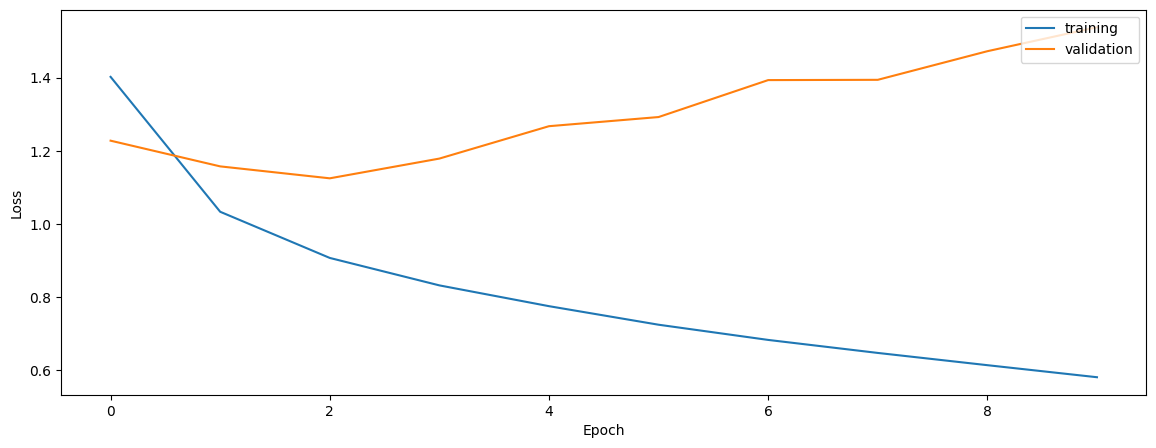

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6614167180025402
0.577143238633427
0.5765978915138652


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6165655182903643
0.5941668459552496
0.5719209458575106


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6136146352807421
0.587303333700077
0.5699260943718022


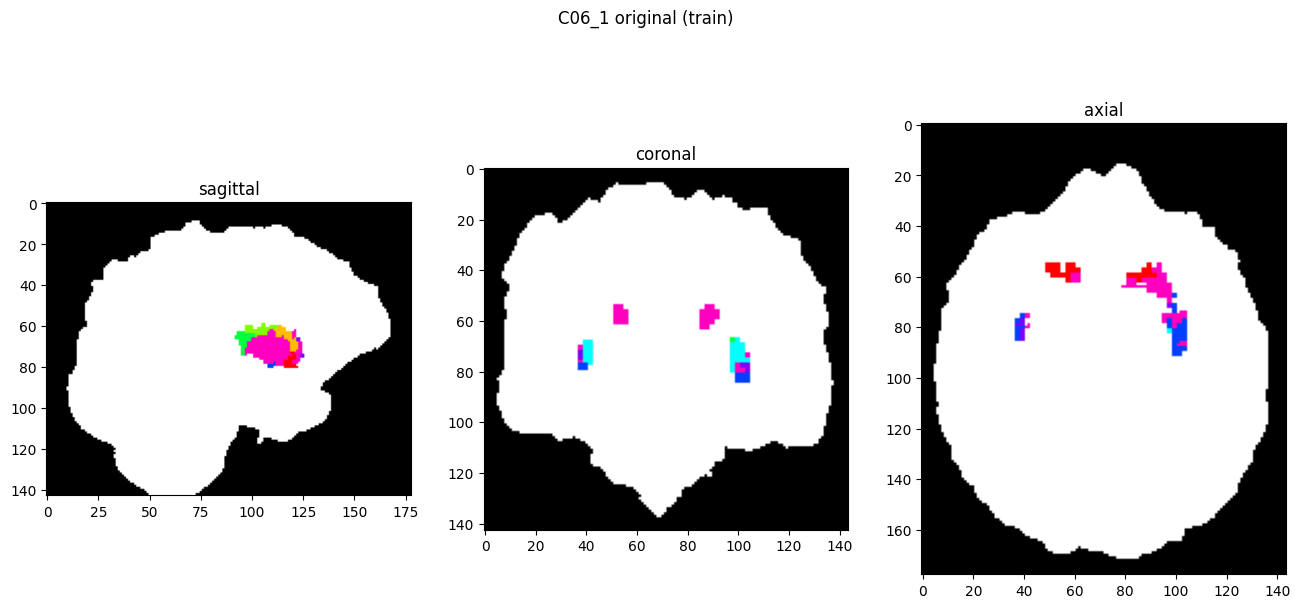

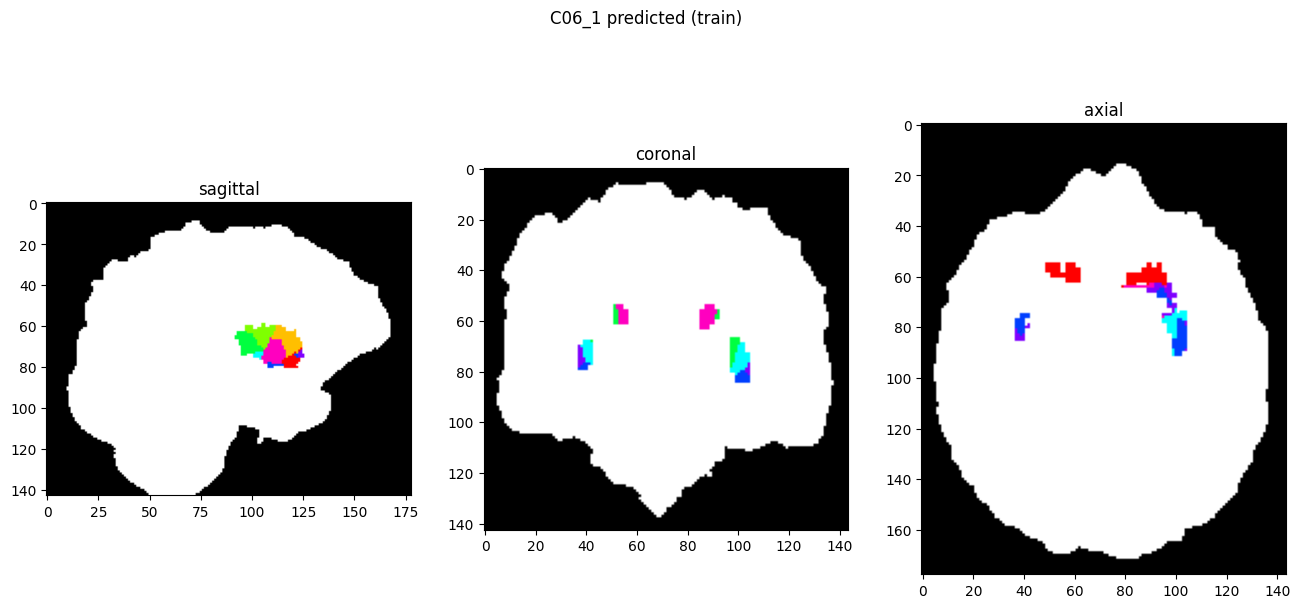

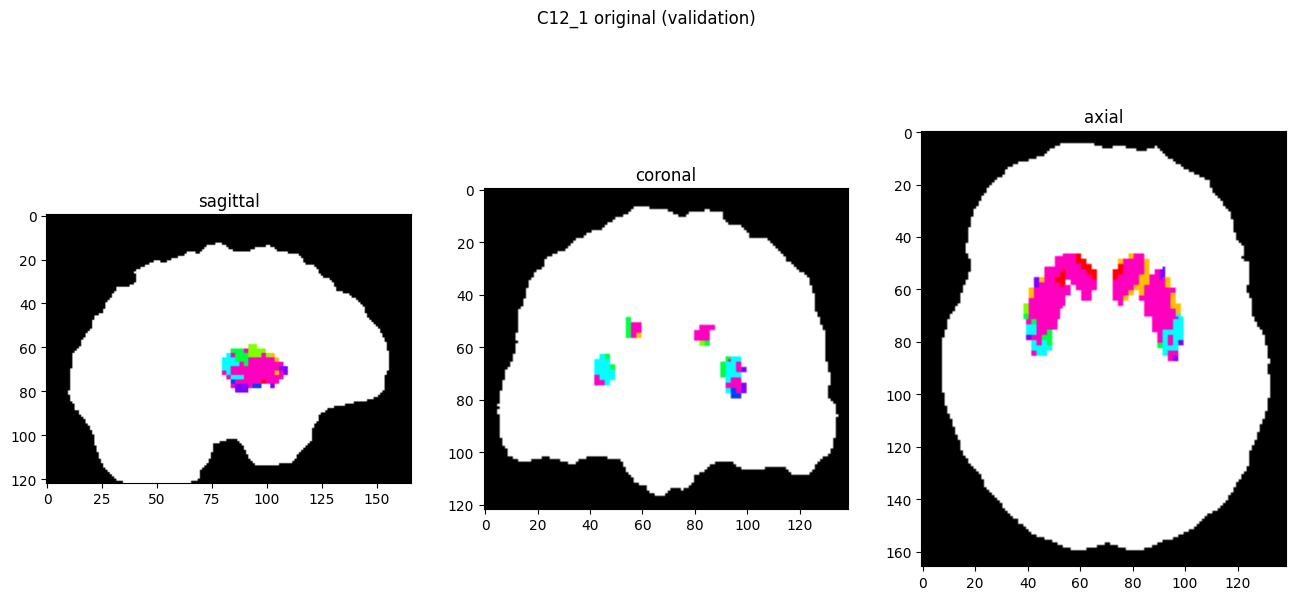

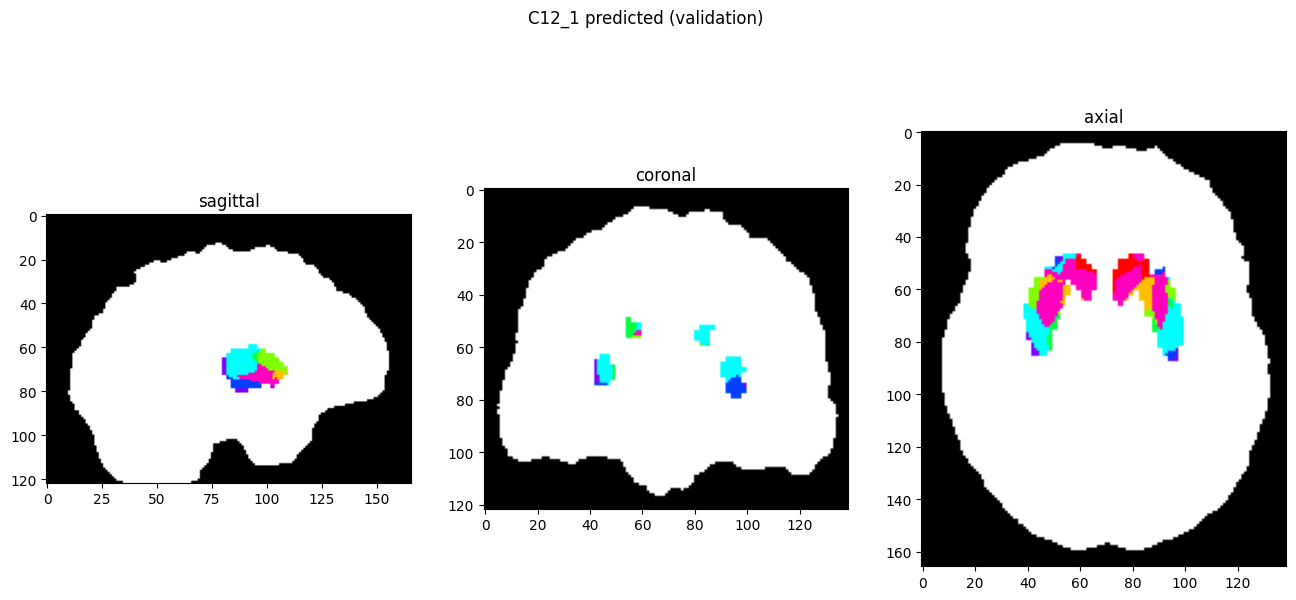

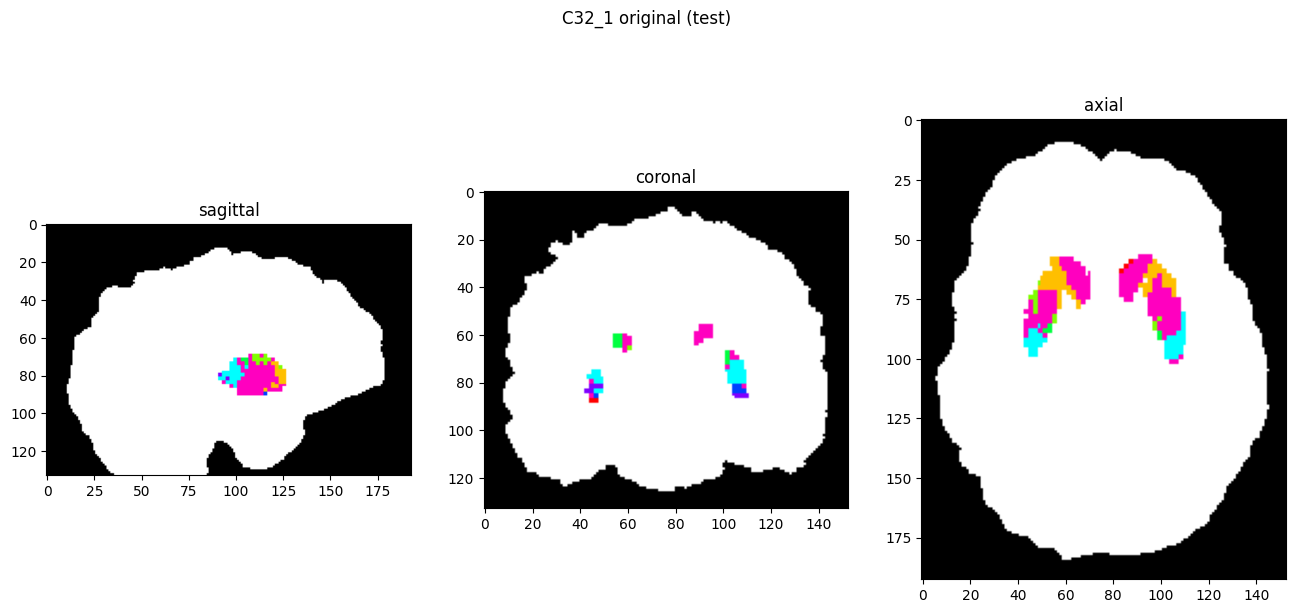

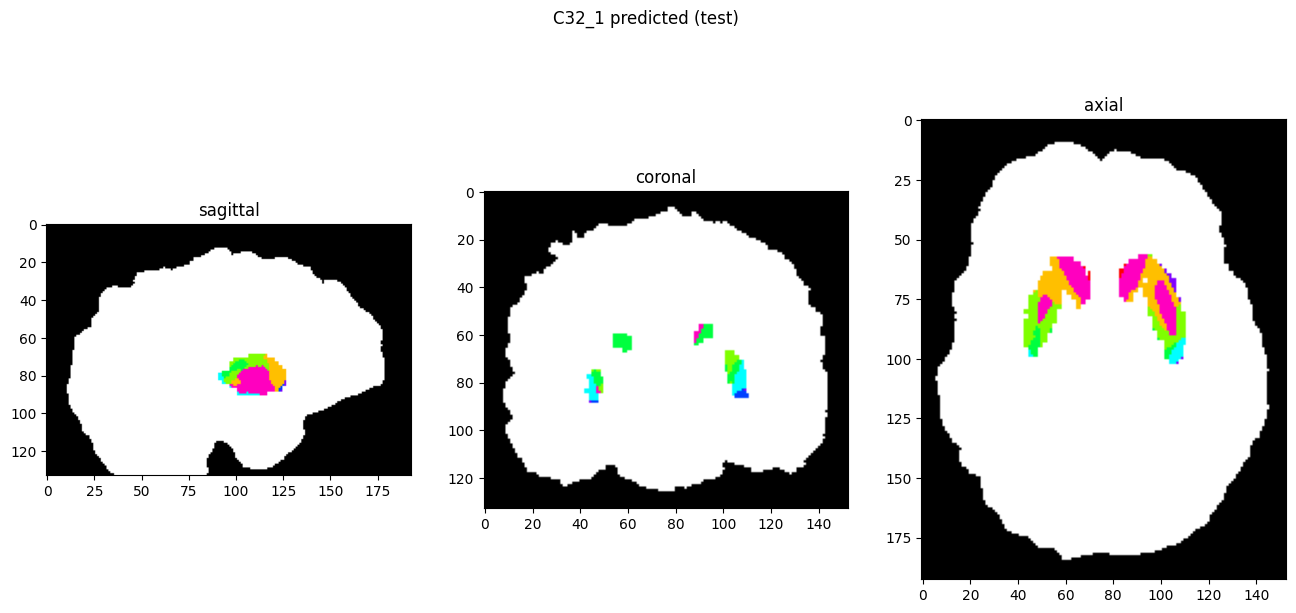

In [10]:
showResults(model, gen, threshold=0)